In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model,manifold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import copy
import pylab
import tensorflow as tf
from keras.layers.core import Activation
from keras.models import Sequential
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.backend import sigmoid 
from keras.layers import Dense
#Project functions
from Project_functions import get_monthi,get_mean_temp


In [12]:
#setup
df = pd.read_csv("consumption.csv")
weather_avg = pd.read_csv('weather-avg.csv')
weather_min = pd.read_csv('weather-min.csv')
weather_max = pd.read_csv('weather-max.csv')
info = pd.read_csv('addinfo.csv')
weather_avg = weather_avg.set_index("meter_id")
weather_min = weather_min.set_index("meter_id")
weather_max = weather_max.set_index("meter_id")
info = info.set_index("meter_id")
weather_avg_sorted = weather_avg.reindex(df.iloc[:,0])
weather_min_sorted = weather_min.reindex(df.iloc[:,0])
weather_max_sorted = weather_max.reindex(df.iloc[:,0])
info_sorted = info.reindex(df.iloc[:,0])
brinfo=info_sorted['num_bedrooms']
values = {'num_bedrooms' : brinfo.mean()}
info_filled_br = info_sorted.fillna(value = values)
brinfo_filled = info_filled_br['num_bedrooms']

In [44]:
#these don't work out of the function file apperantly
def Eval_random_Split(features,npEn_con,split,model,print_res=True):
    X_train, X_test, y_train, y_test = train_test_split(
    features , npEn_con, test_size=split, random_state=0)
    #print(X_train.shape, y_train.shape)
    #print(X_test.shape, y_test.shape)
    model.fit(X_train,y_train)
    if print_res:
        y_pred=model.predict(X_test)
        print('Coefficients: \n', model.coef_)
        print('Intercept: {}'.format(model.intercept_))
        # The mean squared error
        print('Mean squared error: %.8f' % mean_squared_error(y_test, y_pred))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: %.8f' % r2_score(y_test, y_pred))
    return model

def Check_1D(features,npEn_con,split,model,print_res=True):
    #extract only the last month from the features
    features_lm=features[:,(features.shape[-1]-1)]
    features_lm=features_lm.reshape(-1,1)
    #use previously made function
    return Eval_random_Split(features_lm,npEn_con,split,model,print_res)

#z-normalization on data:
def normalise_features(np_features):
    #np_features_norm= np.zeros(shape = np_features.shape)
    np_features_norm=np_features
    if np_features.ndim==1:
        np_features_norm=(np_features-np.mean(np_features))/np.std(np_features)
    else: 
        for i in range(np_features.shape[1]):
            np_features_norm[:,i] = (np_features[:,i]-np.mean(np_features[:,i]))/np.std(np_features[:,i])
    return np_features_norm

def Eval_Kfold_Split(features,npEn_con,n_splits,model,print_res=True):
    kf = KFold(n_splits, shuffle=True)
    models_arr=[]
    MSE_arr=[]
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        cmodel=model
        cmodel.fit(features[train_index,],npEn_con[train_index])
        models_arr.append(cmodel)
        y_pred = cmodel.predict(features[test_index,])
        MSE_arr.append(mean_squared_error(npEn_con[test_index,], y_pred));
        R2_arr.append(r2_score(npEn_con[test_index,], y_pred))
    if print_res:
        # The mean squared error
        print('Mean squared error:')
        print(np.mean(MSE_arr))
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))
    return models_arr,np.mean(R2_arr)

def swish(x):
    return K.sigmoid(x) * x

get_custom_objects().update({'swish': Activation(swish)})

In [4]:
def sort_data(nim,nom,combine_output=False):
    #nim: number of input months
    #nom: number of output months
    
    #CHECK INPUTS
    if nim<1:
        print("number of input months (nim) should be greater or equal to 1")
        return 0
    if nom<1:
        print("number of output months (nom) should be greater or equal to 1")
        return 0
    
    #DATA STORAGE
    En_con=[]        #current/future consumption (this is what we try to predict)
    prev_con=[]      #previous consumption
    prev_daily_con=[]  #previous consumption on a daily basis
    #extra info
    temps=[]
    temps_min=[]
    temps_max=[]
    month_arr=[]
    br_arr=[]       #Bedroom info array
    br_arr_mean=[]
    dwt_arr=[]      #dwelling type array
    y = pd.get_dummies(info_sorted.dwelling_type, prefix='dwelling_type')
    
    #LOOP
    NaN_t=1200  #thershold
    #NaN_day_T=20 #the amount of days of data we want in a input month(28 days)
    for i in range(df.shape[0]): # loop over all users
        meter=df.iloc[i] # = row number i  
    
        #loop over all month from januari until month 14-nim-nom
        #if the month is higher then this we don't have enough data for the nim input and nom output variables
        #in the case of nim=1 nom=1 we get range(1,12) wich result in m going from 1 to 11 like we want
        for m in range (1,14-nim-nom): 
            #load current month
            bi, ei =get_monthi(m)    #bi (begin index) ei(end index)
            month=meter[bi:ei]       #data for the month m for the row user (row) i
            #load bedroom info
            row = brinfo[i:i+1]               #bedroom info with NaN values
            row_mean = brinfo_filled[i:i+1]  #bedroom info with mean values
            #Load dwelling type
            dew_type_row = y[i:i+1]
            
            # Count the amount of NaN's in all months that will be used
            n_NaN=0
            for k in range(nim+nom):
                bi, ei =get_monthi(m+k)        #bi (begin index) ei(end index)
                tempmonth=meter[bi:ei]       #data for the month m for the row user (row) i
                n_NaN+=tempmonth.isnull().sum() 
            
            if n_NaN<NaN_t:
                #save input for month j,j+1,..,j+nim-1
                input_months=np.zeros(nim)
                input_days=np.zeros([nim,28])
                input_temps=np.zeros(nim)
                input_temps_min=np.zeros(nim)
                input_temps_max=np.zeros(nim)
                output_months=np.zeros(nom)
                output_temps=np.zeros(nom)
                output_temps_min=np.zeros(nom)
                output_temps_max=np.zeros(nom)
                for k in range(nim):
                    #load month for input j+k (k goes from 0 to nim-1)
                    bik,eik=get_monthi(m+k)
                    input_months[k]=meter[bik:eik].mean()
                    daily_con=np.zeros(28)
                    current_month=meter[bik:eik]
                    #print(current_month)
                    #save daily data
                    for d in range(28):
                        daily_con[d]=current_month[d*48:(d+1)*48].mean()
                        input_days[k,:]=daily_con
                    #replace all NaN with the mean value
                    input_days[k,np.isnan(input_days[k,:])]=input_months[k] 
                    #temperatures
                    input_temps[k]=get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+k)
                    input_temps_min[k]=get_mean_temp(weather_min_sorted.iloc[i:i+1],m+k)
                    input_temps_max[k]=get_mean_temp(weather_max_sorted.iloc[i:i+1],m+k)
                for k in range(nom):
                    #load month for input j+nim+k
                    bik,eik=get_monthi(m+nim+k)
                    output_months[k]=meter[bik:eik].mean()
                    #temps
                    output_temps[k]=get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+nim+k)
                    output_temps_min[k]=get_mean_temp(weather_min_sorted.iloc[i:i+1],m+nim+k)
                    output_temps_max[k]=get_mean_temp(weather_max_sorted.iloc[i:i+1],m+nim+k)
                #debug if statement checks for NaN in input month
#                 if np.isnan(np.sum(input_months)):
#                     print("input month has nan value for months=%i index=%i" %(m,i))
#                     print(input_months)
#                     return 1
#                 if np.isnan(np.sum(np.sum(input_days))):
#                     print("input days has nan value for months=%i index=%i" %(m,i))
#                     print(input_days)
#                     return 1
#                 if np.isnan(np.sum(output_months)):
#                     print("Output months has nan value for months=%i index=%i" %(m,i))
#                     print(output_months)
#                     return 1
                #store Energy consumption data
                prev_con.append(input_months)
                prev_daily_con.append(input_days)
                En_con.append(output_months)
                #save extra information 
                temps.append(np.concatenate((input_temps,output_temps)))
                temps_min.append(np.concatenate((input_temps_min,output_temps_min)))
                temps_max.append(np.concatenate((input_temps_max,output_temps_max)))
                month_arr.append(m+nim)
                #bedroom info
                n_br=row[0]
                br=np.zeros(5)
                if ~np.isnan(n_br):
                    #print(n_br)
                    br[np.int(n_br-1)]=1
                br_arr.append(br)
                br_arr_mean.append(row_mean[0])
                #dwelling type
                dwt_arr.append(dew_type_row.to_numpy().ravel())
                        
                #break out of outer month loops since the inner month loop takes care of all months
                #break
                
    # converting list to numpy arrays: 
    npEn_con=np.array(En_con)
    npprev_con=np.array(prev_con)
    npprev_daily_con=np.array(prev_daily_con)
    nptemps=np.array(temps)
    nptemps_min=np.array(temps_min)
    nptemps_max=np.array(temps_max)
    npmonth=np.array(month_arr)
    npbr=np.array(br_arr)
    npbrmean=np.array(br_arr_mean)
    npdwt=np.array(dwt_arr)
    
    #This should probably be done differently 
    if combine_output:
        return [npEn_con,npprev_con,npprev_daily_con,nptemps,nptemps_min,nptemps_max,npmonth,npbr,npbrmean,npdwt]
    else:
        return npEn_con,npprev_con,npprev_daily_con,nptemps,nptemps_min,nptemps_max,npmonth,npbr,npbrmean,npdwt

In [5]:
def normalisedata(data):
    datanorm=data
    for i in range(len(data)):
        #noramlise all non one hot encoded variables
        if i != 7 and i != 9:
            datanorm[i]=normalise_features(datanorm[i])
    return datanorm

In [6]:
#organise data (This takes really long)
nim_arr=[1, 2, 3]
nom_arr=[1, 2, 3, 6]
data_arr=[]
for nim in nim_arr:
    for nom in nom_arr:
        data=[]
        data.append(nim)
        data.append(nom)
        data.append(normalisedata(sort_data(nim,nom,True)))
        data_arr.append(data)

In [ ]:
def swish(x):
    return K.sigmoid(x) * x

get_custom_objects().update({'swish': Activation(swish)})

In [59]:
def run_NN_tests(data,En,nim,nom,pr=False):
    n_splits=10
    R2mean_arr=[]
    history_arr=[]
    if pr:
        print('\n#####################################')
        print('0) Include all input temprature info + (one hot enconding br)+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[6],data[7],data[9])))
    
    
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(40, input_dim=(4*nim+11), activation='relu'),
                tf.keras.layers.Dense(nom)])
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)

    
    if pr:
        print('\n#####################################')
        print('1) Include all temprature info + (one hot enconding br)+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],
                               data[5],data[6],data[7],data[9])))
    
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(40, input_dim=(nim+3*(nim+nom)+11), activation='relu'),
                tf.keras.layers.Dense(nom)])
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)   
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))
        
    if pr:
        print('\n#####################################')
        print('2) Include all input temprature info + (one hot enconding br)+dwellling type+swish')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[6],data[7],data[9])))
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
#         model = tf.keras.models.Sequential([
#                 tf.keras.layers.Dense(40, input_dim=(4*nim+11), activation='swish_act'),
#                 tf.keras.layers.Dense(nom)])
        model = Sequential()
        model.add(Dense(40, input_dim=(4*nim+11), activation='swish'))
        model.add(Dense(nom))
        
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)

    
    if pr:
        print('\n#####################################')
        print('3) Include all temprature info + (one hot enconding br)+dwellling type swish')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],
                               data[5],data[6],data[7],data[9])))
    
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        model = Sequential()
        model.add(Dense(40, input_dim=(nim+3*(nim+nom)+11), activation='swish'))
        model.add(Dense(nom))
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
    
    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))


    return R2mean_arr,history_arr

In [63]:
data11=data_arr[11][2]
print(data_arr[11][0])
print(data_arr[11][1])
R211,history11=run_NN_tests(data11,data11[0],3,6,True)

3
6

#####################################
0) Include all input temprature info + (one hot enconding br)+dwellling type
#####################################
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 289us/sample - loss: 0.9643 - mean_squared_error: 0.9643 - val_loss: 0.6603 - val_mean_squared_error: 0.6603
Epoch 2/20
1524/1524 [==============================] - 0s 48us/sample - loss: 0.5346 - mean_squared_error: 0.5346 - val_loss: 0.4580 - val_mean_squared_error: 0.4580
Epoch 3/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.3789 - mean_squared_error: 0.3789 - val_loss: 0.3725 - val_mean_squared_error: 0.3725
Epoch 4/20
1524/1524 [==============================] - 0s 47us/sample - loss: 0.3271 - mean_squared_error: 0.3271 - val_loss: 0.3310 - val_mean_squared_error: 0.3310
Epoch 5/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.3046 - mean_squared_error: 0.3046 - val_loss:

1524/1524 [==============================] - 0s 52us/sample - loss: 0.2692 - mean_squared_error: 0.2692 - val_loss: 0.2207 - val_mean_squared_error: 0.2207
Epoch 9/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2623 - mean_squared_error: 0.2623 - val_loss: 0.2096 - val_mean_squared_error: 0.2096
Epoch 10/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2074 - val_mean_squared_error: 0.2074
Epoch 11/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2498 - mean_squared_error: 0.2498 - val_loss: 0.2024 - val_mean_squared_error: 0.2024
Epoch 12/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.1990 - val_mean_squared_error: 0.1990
Epoch 13/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2409 - mean_squared_error: 0.2409 - val_loss: 0.1979 - val_mean_squared_error: 0.1979
Epoch

1525/1525 [==============================] - 0s 40us/sample - loss: 0.2298 - mean_squared_error: 0.2298 - val_loss: 0.2419 - val_mean_squared_error: 0.2419
Epoch 17/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2266 - mean_squared_error: 0.2266 - val_loss: 0.2280 - val_mean_squared_error: 0.2280
Epoch 18/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.2321 - val_mean_squared_error: 0.2321
Epoch 19/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2222 - mean_squared_error: 0.2222 - val_loss: 0.2332 - val_mean_squared_error: 0.2332
Epoch 20/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.2204 - mean_squared_error: 0.2204 - val_loss: 0.2349 - val_mean_squared_error: 0.2349
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 281us/sample - loss: 0.8244 - mean_squared_error: 0.8244 - val_los

1525/1525 [==============================] - 0s 41us/sample - loss: 0.3179 - mean_squared_error: 0.3179 - val_loss: 0.3641 - val_mean_squared_error: 0.3641
Epoch 5/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.3527 - val_mean_squared_error: 0.3527
Epoch 6/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.2920 - mean_squared_error: 0.2920 - val_loss: 0.3423 - val_mean_squared_error: 0.3423
Epoch 7/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2843 - mean_squared_error: 0.2843 - val_loss: 0.3382 - val_mean_squared_error: 0.3382
Epoch 8/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.2761 - mean_squared_error: 0.2761 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 9/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.2689 - mean_squared_error: 0.2689 - val_loss: 0.3209 - val_mean_squared_error: 0.3209
Epoch 10/

1525/1525 [==============================] - 0s 44us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2000 - val_mean_squared_error: 0.2000
Epoch 13/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.1995 - val_mean_squared_error: 0.1995
Epoch 14/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.1961 - val_mean_squared_error: 0.1961
Epoch 15/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2421 - mean_squared_error: 0.2421 - val_loss: 0.1976 - val_mean_squared_error: 0.1976
Epoch 16/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.1928 - val_mean_squared_error: 0.1928
Epoch 17/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.2369 - mean_squared_error: 0.2369 - val_loss: 0.1912 - val_mean_squared_error: 0.1912
Epoc

1524/1524 [==============================] - 0s 46us/sample - loss: 0.2315 - mean_squared_error: 0.2315 - val_loss: 0.2159 - val_mean_squared_error: 0.2159
Epoch 20/20
1524/1524 [==============================] - 0s 43us/sample - loss: 0.2305 - mean_squared_error: 0.2305 - val_loss: 0.2125 - val_mean_squared_error: 0.2125
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 280us/sample - loss: 1.0798 - mean_squared_error: 1.0798 - val_loss: 0.7523 - val_mean_squared_error: 0.7523
Epoch 2/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.6521 - mean_squared_error: 0.6521 - val_loss: 0.5072 - val_mean_squared_error: 0.5072
Epoch 3/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.4567 - mean_squared_error: 0.4567 - val_loss: 0.3813 - val_mean_squared_error: 0.3813
Epoch 4/20
1524/1524 [==============================] - 0s 43us/sample - loss: 0.3708 - mean_squared_error: 0.3708 - val_loss: 

1525/1525 [==============================] - 0s 37us/sample - loss: 0.2883 - mean_squared_error: 0.2883 - val_loss: 0.1797 - val_mean_squared_error: 0.1797
Epoch 8/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2807 - mean_squared_error: 0.2807 - val_loss: 0.1821 - val_mean_squared_error: 0.1821
Epoch 9/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2759 - mean_squared_error: 0.2759 - val_loss: 0.1749 - val_mean_squared_error: 0.1749
Epoch 10/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2692 - mean_squared_error: 0.2692 - val_loss: 0.1758 - val_mean_squared_error: 0.1758
Epoch 11/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2655 - mean_squared_error: 0.2655 - val_loss: 0.1742 - val_mean_squared_error: 0.1742
Epoch 12/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.1741 - val_mean_squared_error: 0.1741
Epoch 

1525/1525 [==============================] - 0s 38us/sample - loss: 0.2326 - mean_squared_error: 0.2326 - val_loss: 0.1616 - val_mean_squared_error: 0.1616
Epoch 16/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.2281 - mean_squared_error: 0.2281 - val_loss: 0.1595 - val_mean_squared_error: 0.1595
Epoch 17/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2274 - mean_squared_error: 0.2274 - val_loss: 0.1622 - val_mean_squared_error: 0.1622
Epoch 18/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2250 - mean_squared_error: 0.2250 - val_loss: 0.1649 - val_mean_squared_error: 0.1649
Epoch 19/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2229 - mean_squared_error: 0.2229 - val_loss: 0.1616 - val_mean_squared_error: 0.1616
Epoch 20/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Trai

1525/1525 [==============================] - 0s 40us/sample - loss: 0.3648 - mean_squared_error: 0.3648 - val_loss: 0.3380 - val_mean_squared_error: 0.3380
Epoch 4/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.3145 - mean_squared_error: 0.3145 - val_loss: 0.3269 - val_mean_squared_error: 0.3269
Epoch 5/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.2948 - mean_squared_error: 0.2948 - val_loss: 0.3202 - val_mean_squared_error: 0.3202
Epoch 6/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2859 - mean_squared_error: 0.2859 - val_loss: 0.3133 - val_mean_squared_error: 0.3133
Epoch 7/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.2740 - mean_squared_error: 0.2740 - val_loss: 0.3125 - val_mean_squared_error: 0.3125
Epoch 8/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2660 - mean_squared_error: 0.2660 - val_loss: 0.3039 - val_mean_squared_error: 0.3039
Epoch 9/2

1524/1524 [==============================] - 0s 31us/step - loss: 0.2597 - mean_squared_error: 0.3683 - val_loss: 0.2123 - val_mean_squared_error: 0.3619
Epoch 11/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2548 - mean_squared_error: 0.3572 - val_loss: 0.2118 - val_mean_squared_error: 0.3517
Epoch 12/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2499 - mean_squared_error: 0.3459 - val_loss: 0.2052 - val_mean_squared_error: 0.3428
Epoch 13/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2447 - mean_squared_error: 0.3385 - val_loss: 0.2015 - val_mean_squared_error: 0.3350
Epoch 14/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2415 - mean_squared_error: 0.3324 - val_loss: 0.1984 - val_mean_squared_error: 0.3280
Epoch 15/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2384 - mean_squared_error: 0.3249 - val_loss: 0.1998 - val_mean_squared_error: 0.3217
Epoch 16/20
1524

Epoch 19/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2174 - mean_squared_error: 0.2897 - val_loss: 0.2240 - val_mean_squared_error: 0.2880
Epoch 20/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2168 - mean_squared_error: 0.2866 - val_loss: 0.2207 - val_mean_squared_error: 0.2845
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 106us/step - loss: 0.9447 - mean_squared_error: 1.0597 - val_loss: 0.6300 - val_mean_squared_error: 0.9235
Epoch 2/20
1525/1525 [==============================] - 0s 39us/step - loss: 0.5441 - mean_squared_error: 0.8159 - val_loss: 0.3947 - val_mean_squared_error: 0.7264
Epoch 3/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.3640 - mean_squared_error: 0.6612 - val_loss: 0.3008 - val_mean_squared_error: 0.6029
Epoch 4/20
1525/1525 [==============================] - 0s 37us/step - loss: 0.3042 - mean_squared_error: 0.5622 - val_loss: 

1525/1525 [==============================] - 0s 34us/step - loss: 0.2750 - mean_squared_error: 0.4558 - val_loss: 0.3056 - val_mean_squared_error: 0.4437
Epoch 8/20
1525/1525 [==============================] - 0s 43us/step - loss: 0.2666 - mean_squared_error: 0.4315 - val_loss: 0.2994 - val_mean_squared_error: 0.4219
Epoch 9/20
1525/1525 [==============================] - 0s 34us/step - loss: 0.2594 - mean_squared_error: 0.4141 - val_loss: 0.3002 - val_mean_squared_error: 0.4043
Epoch 10/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2529 - mean_squared_error: 0.3966 - val_loss: 0.2924 - val_mean_squared_error: 0.3895
Epoch 11/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2471 - mean_squared_error: 0.3830 - val_loss: 0.2875 - val_mean_squared_error: 0.3769
Epoch 12/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2414 - mean_squared_error: 0.3710 - val_loss: 0.2881 - val_mean_squared_error: 0.3660
Epoch 13/20
1525/1

Epoch 16/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2307 - mean_squared_error: 0.3312 - val_loss: 0.1999 - val_mean_squared_error: 0.3277
Epoch 17/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2275 - mean_squared_error: 0.3246 - val_loss: 0.1983 - val_mean_squared_error: 0.3216
Epoch 18/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2240 - mean_squared_error: 0.3183 - val_loss: 0.1957 - val_mean_squared_error: 0.3160
Epoch 19/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2212 - mean_squared_error: 0.3131 - val_loss: 0.1945 - val_mean_squared_error: 0.3109
Epoch 20/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2215 - mean_squared_error: 0.3088 - val_loss: 0.1962 - val_mean_squared_error: 0.3063
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 104us/step - loss: 0.8901 - mean_squared_error: 1.0063 - val_los

1524/1524 [==============================] - 0s 31us/step - loss: 0.3848 - mean_squared_error: 0.7135 - val_loss: 0.2772 - val_mean_squared_error: 0.6483
Epoch 4/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.3161 - mean_squared_error: 0.6024 - val_loss: 0.2589 - val_mean_squared_error: 0.5629
Epoch 5/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2911 - mean_squared_error: 0.5344 - val_loss: 0.2573 - val_mean_squared_error: 0.5074
Epoch 6/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2809 - mean_squared_error: 0.4876 - val_loss: 0.2604 - val_mean_squared_error: 0.4690
Epoch 7/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2730 - mean_squared_error: 0.4542 - val_loss: 0.2521 - val_mean_squared_error: 0.4406
Epoch 8/20
1524/1524 [==============================] - 0s 34us/step - loss: 0.2664 - mean_squared_error: 0.4280 - val_loss: 0.2510 - val_mean_squared_error: 0.4186
Epoch 9/20
1524/1524 

Epoch 12/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.2529 - mean_squared_error: 0.3902 - val_loss: 0.2017 - val_mean_squared_error: 0.3843
Epoch 13/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2476 - mean_squared_error: 0.3797 - val_loss: 0.1918 - val_mean_squared_error: 0.3734
Epoch 14/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2434 - mean_squared_error: 0.3689 - val_loss: 0.1885 - val_mean_squared_error: 0.3637
Epoch 15/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2413 - mean_squared_error: 0.3593 - val_loss: 0.1796 - val_mean_squared_error: 0.3551
Epoch 16/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2351 - mean_squared_error: 0.3510 - val_loss: 0.1746 - val_mean_squared_error: 0.3473
Epoch 17/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.2308 - mean_squared_error: 0.3438 - val_loss: 0.1734 - val_mean_squared_error: 0.3400
Epoc

Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 106us/step - loss: 1.0953 - mean_squared_error: 1.3247 - val_loss: 0.7375 - val_mean_squared_error: 1.0672
Epoch 2/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.6329 - mean_squared_error: 0.9523 - val_loss: 0.5192 - val_mean_squared_error: 0.8439
Epoch 3/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.3873 - mean_squared_error: 0.7597 - val_loss: 0.4356 - val_mean_squared_error: 0.6922
Epoch 4/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2996 - mean_squared_error: 0.6419 - val_loss: 0.4222 - val_mean_squared_error: 0.5963
Epoch 5/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2809 - mean_squared_error: 0.5625 - val_loss: 0.4136 - val_mean_squared_error: 0.5355
Epoch 6/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2694 - mean_squared_error: 0.5135 - val_loss: 0.

1525/1525 [==============================] - 0s 37us/step - loss: 0.2499 - mean_squared_error: 0.3767 - val_loss: 0.2577 - val_mean_squared_error: 0.3686
Epoch 10/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2445 - mean_squared_error: 0.3624 - val_loss: 0.2512 - val_mean_squared_error: 0.3563
Epoch 11/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2398 - mean_squared_error: 0.3505 - val_loss: 0.2434 - val_mean_squared_error: 0.3457
Epoch 12/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2354 - mean_squared_error: 0.3416 - val_loss: 0.2379 - val_mean_squared_error: 0.3365
Epoch 13/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2319 - mean_squared_error: 0.3313 - val_loss: 0.2398 - val_mean_squared_error: 0.3285
Epoch 14/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2305 - mean_squared_error: 0.3249 - val_loss: 0.2385 - val_mean_squared_error: 0.3215
Epoch 15/20
1525

[0.7569853237539681, 0.7540106372901864, 0.761751331579989, 0.7641711289289113]


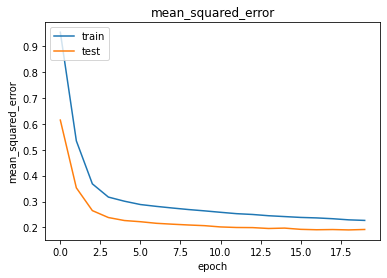

In [64]:
print(R211)
history=history11[0]
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [65]:
#run tests
R2_arr=[]
for data in data_arr:
    print('nim=:%i nom=%i' %(data[0],data[1]))
    R2,_=run_NN_tests(data[2],data[2][0],data[0],data[1],pr=False)
    R2_arr.append(R2)


nim=:1 nom=1
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 62us/sample - loss: 0.1928 - mean_squared_error: 0.1928 - val_loss: 0.1252 - val_mean_squared_error: 0.1252
Epoch 2/20
15979/15979 [==============================] - 1s 37us/sample - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.1233 - val_mean_squared_error: 0.1233
Epoch 3/20
15979/15979 [==============================] - 1s 36us/sample - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.1209 - val_mean_squared_error: 0.1209
Epoch 4/20
15979/15979 [==============================] - 1s 36us/sample - loss: 0.1317 - mean_squared_error: 0.1317 - val_loss: 0.1241 - val_mean_squared_error: 0.1241
Epoch 5/20
15979/15979 [==============================] - 1s 36us/sample - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.1215 - val_mean_squared_error: 0.1215
Epoch 6/20
15979/15979 [==============================] - 1s 39us/sample - loss: 0.1307 - mea

15979/15979 [==============================] - 1s 40us/sample - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1269 - val_mean_squared_error: 0.1269
Epoch 9/20
15979/15979 [==============================] - 1s 44us/sample - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.1271 - val_mean_squared_error: 0.1271
Epoch 10/20
15979/15979 [==============================] - 1s 57us/sample - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1262 - val_mean_squared_error: 0.1262
Epoch 11/20
15979/15979 [==============================] - 1s 33us/sample - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 12/20
15979/15979 [==============================] - 1s 32us/sample - loss: 0.1278 - mean_squared_error: 0.1278 - val_loss: 0.1258 - val_mean_squared_error: 0.1258
Epoch 13/20
15979/15979 [==============================] - 1s 32us/sample - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.1272 - val_mean_squared_error: 

15979/15979 [==============================] - 1s 40us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1163 - val_mean_squared_error: 0.1163
Epoch 16/20
15979/15979 [==============================] - 1s 34us/sample - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.1194 - val_mean_squared_error: 0.1194
Epoch 17/20
15979/15979 [==============================] - 1s 34us/sample - loss: 0.1280 - mean_squared_error: 0.1280 - val_loss: 0.1179 - val_mean_squared_error: 0.1179
Epoch 18/20
15979/15979 [==============================] - 1s 33us/sample - loss: 0.1277 - mean_squared_error: 0.1277 - val_loss: 0.1158 - val_mean_squared_error: 0.1158
Epoch 19/20
15979/15979 [==============================] - 1s 34us/sample - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1179 - val_mean_squared_error: 0.1179
Epoch 20/20
15979/15979 [==============================] - 1s 36us/sample - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1163 - val_mean_squared_error:

15980/15980 [==============================] - 1s 34us/sample - loss: 0.1358 - mean_squared_error: 0.1358 - val_loss: 0.1097 - val_mean_squared_error: 0.1097
Epoch 3/20
15980/15980 [==============================] - 1s 34us/sample - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1110 - val_mean_squared_error: 0.1110
Epoch 4/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1328 - mean_squared_error: 0.1328 - val_loss: 0.1090 - val_mean_squared_error: 0.1090
Epoch 5/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1321 - mean_squared_error: 0.1321 - val_loss: 0.1110 - val_mean_squared_error: 0.1110
Epoch 6/20
15980/15980 [==============================] - 1s 33us/sample - loss: 0.1316 - mean_squared_error: 0.1316 - val_loss: 0.1101 - val_mean_squared_error: 0.1101
Epoch 7/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 0.1106 - val_mean_squared_error: 0.11

Epoch 10/20
15980/15980 [==============================] - 1s 35us/sample - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1215 - val_mean_squared_error: 0.1215
Epoch 11/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1292 - mean_squared_error: 0.1292 - val_loss: 0.1191 - val_mean_squared_error: 0.1191
Epoch 12/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1171 - val_mean_squared_error: 0.1171
Epoch 13/20
15980/15980 [==============================] - 1s 33us/sample - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1181 - val_mean_squared_error: 0.1181
Epoch 14/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1186 - val_mean_squared_error: 0.1186
Epoch 15/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1208 - val_mean_sq

Epoch 18/20
15979/15979 [==============================] - 1s 31us/sample - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.1495 - val_mean_squared_error: 0.1495
Epoch 19/20
15979/15979 [==============================] - 1s 32us/sample - loss: 0.1213 - mean_squared_error: 0.1213 - val_loss: 0.1496 - val_mean_squared_error: 0.1496
Epoch 20/20
15979/15979 [==============================] - 1s 32us/sample - loss: 0.1216 - mean_squared_error: 0.1216 - val_loss: 0.1476 - val_mean_squared_error: 0.1476
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 55us/sample - loss: 0.2094 - mean_squared_error: 0.2094 - val_loss: 0.1276 - val_mean_squared_error: 0.1276
Epoch 2/20
15979/15979 [==============================] - 1s 33us/sample - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1230 - val_mean_squared_error: 0.1230
Epoch 3/20
15979/15979 [==============================] - 1s 33us/sample - loss: 0.1319 - mean_squared_

15979/15979 [==============================] - 1s 34us/sample - loss: 0.1249 - mean_squared_error: 0.1249 - val_loss: 0.1596 - val_mean_squared_error: 0.1596
Epoch 6/20
15979/15979 [==============================] - 1s 33us/sample - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1579 - val_mean_squared_error: 0.1579
Epoch 7/20
15979/15979 [==============================] - 1s 34us/sample - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1578 - val_mean_squared_error: 0.1578
Epoch 8/20
15979/15979 [==============================] - 1s 34us/sample - loss: 0.1229 - mean_squared_error: 0.1229 - val_loss: 0.1561 - val_mean_squared_error: 0.1561
Epoch 9/20
15979/15979 [==============================] - 1s 33us/sample - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.1558 - val_mean_squared_error: 0.1558
Epoch 10/20
15979/15979 [==============================] - 1s 34us/sample - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.1568 - val_mean_squared_error: 0.1

Epoch 13/20
15980/15980 [==============================] - 1s 34us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.0957 - val_mean_squared_error: 0.0957
Epoch 14/20
15980/15980 [==============================] - 1s 37us/sample - loss: 0.1279 - mean_squared_error: 0.1279 - val_loss: 0.0914 - val_mean_squared_error: 0.0914
Epoch 15/20
15980/15980 [==============================] - 1s 31us/sample - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 0.0957 - val_mean_squared_error: 0.0957
Epoch 16/20
15980/15980 [==============================] - 1s 33us/sample - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 0.0936 - val_mean_squared_error: 0.0936
Epoch 17/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.0945 - val_mean_squared_error: 0.0945
Epoch 18/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.0915 - val_mean_sq

Train on 15980 samples, validate on 1775 samples
Epoch 1/20
15980/15980 [==============================] - 1s 55us/sample - loss: 0.1800 - mean_squared_error: 0.1800 - val_loss: 0.1490 - val_mean_squared_error: 0.1490
Epoch 2/20
15980/15980 [==============================] - 1s 33us/sample - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.1428 - val_mean_squared_error: 0.1428
Epoch 3/20
15980/15980 [==============================] - 1s 33us/sample - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1453 - val_mean_squared_error: 0.1453
Epoch 4/20
15980/15980 [==============================] - 1s 32us/sample - loss: 0.1264 - mean_squared_error: 0.1264 - val_loss: 0.1445 - val_mean_squared_error: 0.1445
Epoch 5/20
15980/15980 [==============================] - 1s 31us/sample - loss: 0.1255 - mean_squared_error: 0.1255 - val_loss: 0.1402 - val_mean_squared_error: 0.1402
Epoch 6/20
15980/15980 [==============================] - 1s 33us/sample - loss: 0.1251 - mean_squared_err

Epoch 9/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1308 - mean_squared_error: 0.1430 - val_loss: 0.1244 - val_mean_squared_error: 0.1424
Epoch 10/20
15979/15979 [==============================] - 0s 27us/step - loss: 0.1300 - mean_squared_error: 0.1419 - val_loss: 0.1260 - val_mean_squared_error: 0.1411
Epoch 11/20
15979/15979 [==============================] - 0s 27us/step - loss: 0.1300 - mean_squared_error: 0.1403 - val_loss: 0.1254 - val_mean_squared_error: 0.1401
Epoch 12/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1307 - mean_squared_error: 0.1395 - val_loss: 0.1248 - val_mean_squared_error: 0.1393
Epoch 13/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1301 - mean_squared_error: 0.1388 - val_loss: 0.1250 - val_mean_squared_error: 0.1385
Epoch 14/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1304 - mean_squared_error: 0.1382 - val_loss: 0.1245 - val_mean_squared_error: 

15979/15979 [==============================] - 0s 26us/step - loss: 0.1281 - mean_squared_error: 0.1403 - val_loss: 0.1409 - val_mean_squared_error: 0.1402
Epoch 18/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1282 - mean_squared_error: 0.1399 - val_loss: 0.1396 - val_mean_squared_error: 0.1396
Epoch 19/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1281 - mean_squared_error: 0.1393 - val_loss: 0.1393 - val_mean_squared_error: 0.1391
Epoch 20/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1277 - mean_squared_error: 0.1388 - val_loss: 0.1414 - val_mean_squared_error: 0.1386
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.2754 - mean_squared_error: 0.4980 - val_loss: 0.1193 - val_mean_squared_error: 0.2678
Epoch 2/20
15979/15979 [==============================] - 0s 27us/step - loss: 0.1355 - mean_squared_error: 0.2258 - val_los

15980/15980 [==============================] - 1s 32us/step - loss: 0.1297 - mean_squared_error: 0.1488 - val_loss: 0.1328 - val_mean_squared_error: 0.1469
Epoch 6/20
15980/15980 [==============================] - 0s 28us/step - loss: 0.1301 - mean_squared_error: 0.1450 - val_loss: 0.1326 - val_mean_squared_error: 0.1441
Epoch 7/20
15980/15980 [==============================] - 0s 27us/step - loss: 0.1295 - mean_squared_error: 0.1428 - val_loss: 0.1430 - val_mean_squared_error: 0.1421
Epoch 8/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1298 - mean_squared_error: 0.1410 - val_loss: 0.1341 - val_mean_squared_error: 0.1407
Epoch 9/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1297 - mean_squared_error: 0.1400 - val_loss: 0.1325 - val_mean_squared_error: 0.1395
Epoch 10/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1291 - mean_squared_error: 0.1391 - val_loss: 0.1338 - val_mean_squared_error: 0.1385
Epoch 11

15980/15980 [==============================] - 0s 26us/step - loss: 0.1260 - mean_squared_error: 0.1407 - val_loss: 0.1572 - val_mean_squared_error: 0.1405
Epoch 14/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1260 - mean_squared_error: 0.1399 - val_loss: 0.1559 - val_mean_squared_error: 0.1397
Epoch 15/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1258 - mean_squared_error: 0.1389 - val_loss: 0.1565 - val_mean_squared_error: 0.1389
Epoch 16/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1258 - mean_squared_error: 0.1383 - val_loss: 0.1563 - val_mean_squared_error: 0.1383
Epoch 17/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1255 - mean_squared_error: 0.1379 - val_loss: 0.1564 - val_mean_squared_error: 0.1377
Epoch 18/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1258 - mean_squared_error: 0.1374 - val_loss: 0.1561 - val_mean_squared_error: 0.1372
Epoc

15979/15979 [==============================] - 1s 34us/step - loss: 0.1913 - mean_squared_error: 0.3139 - val_loss: 0.1091 - val_mean_squared_error: 0.1874
Epoch 2/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1327 - mean_squared_error: 0.1687 - val_loss: 0.1144 - val_mean_squared_error: 0.1583
Epoch 3/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1307 - mean_squared_error: 0.1525 - val_loss: 0.1103 - val_mean_squared_error: 0.1483
Epoch 4/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1302 - mean_squared_error: 0.1448 - val_loss: 0.1134 - val_mean_squared_error: 0.1432
Epoch 5/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1299 - mean_squared_error: 0.1412 - val_loss: 0.1125 - val_mean_squared_error: 0.1402
Epoch 6/20
15979/15979 [==============================] - 0s 26us/step - loss: 0.1289 - mean_squared_error: 0.1391 - val_loss: 0.1123 - val_mean_squared_error: 0.1380
Epoch 7/2

15979/15979 [==============================] - 0s 26us/step - loss: 0.1281 - mean_squared_error: 0.1389 - val_loss: 0.1227 - val_mean_squared_error: 0.1381
Epoch 10/20
15979/15979 [==============================] - 0s 28us/step - loss: 0.1274 - mean_squared_error: 0.1373 - val_loss: 0.1216 - val_mean_squared_error: 0.1370
Epoch 11/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1272 - mean_squared_error: 0.1364 - val_loss: 0.1223 - val_mean_squared_error: 0.1360
Epoch 12/20
15979/15979 [==============================] - 0s 28us/step - loss: 0.1275 - mean_squared_error: 0.1357 - val_loss: 0.1231 - val_mean_squared_error: 0.1353
Epoch 13/20
15979/15979 [==============================] - 0s 30us/step - loss: 0.1274 - mean_squared_error: 0.1350 - val_loss: 0.1270 - val_mean_squared_error: 0.1347
Epoch 14/20
15979/15979 [==============================] - 0s 28us/step - loss: 0.1274 - mean_squared_error: 0.1345 - val_loss: 0.1203 - val_mean_squared_error: 0.1341
Epoc

Epoch 17/20
15980/15980 [==============================] - 0s 27us/step - loss: 0.1270 - mean_squared_error: 0.1335 - val_loss: 0.1203 - val_mean_squared_error: 0.1332
Epoch 18/20
15980/15980 [==============================] - 0s 28us/step - loss: 0.1268 - mean_squared_error: 0.1329 - val_loss: 0.1199 - val_mean_squared_error: 0.1328
Epoch 19/20
15980/15980 [==============================] - 0s 27us/step - loss: 0.1268 - mean_squared_error: 0.1324 - val_loss: 0.1210 - val_mean_squared_error: 0.1324
Epoch 20/20
15980/15980 [==============================] - 0s 28us/step - loss: 0.1264 - mean_squared_error: 0.1322 - val_loss: 0.1202 - val_mean_squared_error: 0.1321
Train on 15980 samples, validate on 1775 samples
Epoch 1/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.3225 - mean_squared_error: 0.5995 - val_loss: 0.1490 - val_mean_squared_error: 0.3150
Epoch 2/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1298 - mean_squared_error: 0.25

15980/15980 [==============================] - 0s 29us/step - loss: 0.1268 - mean_squared_error: 0.1562 - val_loss: 0.1337 - val_mean_squared_error: 0.1529
Epoch 6/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1269 - mean_squared_error: 0.1506 - val_loss: 0.1350 - val_mean_squared_error: 0.1486
Epoch 7/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1266 - mean_squared_error: 0.1467 - val_loss: 0.1402 - val_mean_squared_error: 0.1456
Epoch 8/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1267 - mean_squared_error: 0.1444 - val_loss: 0.1359 - val_mean_squared_error: 0.1434
Epoch 9/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1262 - mean_squared_error: 0.1426 - val_loss: 0.1339 - val_mean_squared_error: 0.1416
Epoch 10/20
15980/15980 [==============================] - 0s 26us/step - loss: 0.1269 - mean_squared_error: 0.1409 - val_loss: 0.1352 - val_mean_squared_error: 0.1402
Epoch 11

13231/13231 [==============================] - 0s 32us/sample - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2229 - val_mean_squared_error: 0.2229
Epoch 14/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.2032 - mean_squared_error: 0.2032 - val_loss: 0.2224 - val_mean_squared_error: 0.2224
Epoch 15/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.2032 - mean_squared_error: 0.2032 - val_loss: 0.2226 - val_mean_squared_error: 0.2226
Epoch 16/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.2021 - mean_squared_error: 0.2021 - val_loss: 0.2203 - val_mean_squared_error: 0.2203
Epoch 17/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.2020 - mean_squared_error: 0.2020 - val_loss: 0.2205 - val_mean_squared_error: 0.2205
Epoch 18/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.2019 - mean_squared_error: 0.2019 - val_loss: 0.2201 - val_mean_squared_error:

Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 61us/sample - loss: 0.3296 - mean_squared_error: 0.3296 - val_loss: 0.2674 - val_mean_squared_error: 0.2674
Epoch 2/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.2131 - mean_squared_error: 0.2131 - val_loss: 0.2597 - val_mean_squared_error: 0.2597
Epoch 3/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.2095 - mean_squared_error: 0.2095 - val_loss: 0.2546 - val_mean_squared_error: 0.2546
Epoch 4/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.2072 - mean_squared_error: 0.2072 - val_loss: 0.2607 - val_mean_squared_error: 0.2607
Epoch 5/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.2053 - mean_squared_error: 0.2053 - val_loss: 0.2596 - val_mean_squared_error: 0.2596
Epoch 6/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.2052 - mean_squared_err

13232/13232 [==============================] - 0s 32us/sample - loss: 0.2112 - mean_squared_error: 0.2112 - val_loss: 0.1796 - val_mean_squared_error: 0.1796
Epoch 9/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2106 - mean_squared_error: 0.2106 - val_loss: 0.1804 - val_mean_squared_error: 0.1804
Epoch 10/20
13232/13232 [==============================] - 0s 36us/sample - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.1824 - val_mean_squared_error: 0.1824
Epoch 11/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2094 - mean_squared_error: 0.2094 - val_loss: 0.1808 - val_mean_squared_error: 0.1808
Epoch 12/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2095 - mean_squared_error: 0.2095 - val_loss: 0.1798 - val_mean_squared_error: 0.1798
Epoch 13/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2085 - mean_squared_error: 0.2085 - val_loss: 0.1840 - val_mean_squared_error: 

Epoch 16/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2044 - mean_squared_error: 0.2044 - val_loss: 0.2086 - val_mean_squared_error: 0.2086
Epoch 17/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2113 - val_mean_squared_error: 0.2113
Epoch 18/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2039 - mean_squared_error: 0.2039 - val_loss: 0.2118 - val_mean_squared_error: 0.2118
Epoch 19/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 0.2086 - val_mean_squared_error: 0.2086
Epoch 20/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2034 - mean_squared_error: 0.2034 - val_loss: 0.2113 - val_mean_squared_error: 0.2113
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 60us/sample - loss: 0.4693 - mean_square

13231/13231 [==============================] - 0s 37us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.1823 - val_mean_squared_error: 0.1823
Epoch 4/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.2152 - mean_squared_error: 0.2152 - val_loss: 0.1800 - val_mean_squared_error: 0.1800
Epoch 5/20
13231/13231 [==============================] - 0s 36us/sample - loss: 0.2127 - mean_squared_error: 0.2127 - val_loss: 0.1914 - val_mean_squared_error: 0.1914
Epoch 6/20
13231/13231 [==============================] - 0s 38us/sample - loss: 0.2113 - mean_squared_error: 0.2113 - val_loss: 0.1783 - val_mean_squared_error: 0.1783
Epoch 7/20
13231/13231 [==============================] - 0s 33us/sample - loss: 0.2100 - mean_squared_error: 0.2100 - val_loss: 0.1795 - val_mean_squared_error: 0.1795
Epoch 8/20
13231/13231 [==============================] - 0s 34us/sample - loss: 0.2087 - mean_squared_error: 0.2087 - val_loss: 0.1782 - val_mean_squared_error: 0.17

Epoch 11/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1996 - mean_squared_error: 0.1996 - val_loss: 0.2404 - val_mean_squared_error: 0.2404
Epoch 12/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1987 - mean_squared_error: 0.1987 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 13/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1987 - mean_squared_error: 0.1987 - val_loss: 0.2392 - val_mean_squared_error: 0.2392
Epoch 14/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1982 - mean_squared_error: 0.1982 - val_loss: 0.2367 - val_mean_squared_error: 0.2367
Epoch 15/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 16/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1975 - mean_squared_error: 0.1975 - val_loss: 0.2377 - val_mean_sq

Epoch 19/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2005 - mean_squared_error: 0.2005 - val_loss: 0.2217 - val_mean_squared_error: 0.2217
Epoch 20/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.2163 - val_mean_squared_error: 0.2163
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 60us/sample - loss: 0.5562 - mean_squared_error: 0.5562 - val_loss: 0.2716 - val_mean_squared_error: 0.2716
Epoch 2/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2286 - mean_squared_error: 0.2286 - val_loss: 0.2390 - val_mean_squared_error: 0.2390
Epoch 3/20
13232/13232 [==============================] - 0s 36us/sample - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.2314 - val_mean_squared_error: 0.2314
Epoch 4/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2091 - mean_squared_e

13232/13232 [==============================] - 0s 32us/sample - loss: 0.2142 - mean_squared_error: 0.2142 - val_loss: 0.1635 - val_mean_squared_error: 0.1635
Epoch 7/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2131 - mean_squared_error: 0.2131 - val_loss: 0.1627 - val_mean_squared_error: 0.1627
Epoch 8/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.2120 - mean_squared_error: 0.2120 - val_loss: 0.1591 - val_mean_squared_error: 0.1591
Epoch 9/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.1624 - val_mean_squared_error: 0.1624
Epoch 10/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.1576 - val_mean_squared_error: 0.1576
Epoch 11/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.2084 - mean_squared_error: 0.2084 - val_loss: 0.1601 - val_mean_squared_error: 0.

Epoch 14/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1953 - mean_squared_error: 0.1953 - val_loss: 0.2681 - val_mean_squared_error: 0.2681
Epoch 15/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 0.2665 - val_mean_squared_error: 0.2665
Epoch 16/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1949 - mean_squared_error: 0.1949 - val_loss: 0.2675 - val_mean_squared_error: 0.2675
Epoch 17/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1938 - mean_squared_error: 0.1938 - val_loss: 0.2688 - val_mean_squared_error: 0.2688
Epoch 18/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.1936 - mean_squared_error: 0.1936 - val_loss: 0.2669 - val_mean_squared_error: 0.2669
Epoch 19/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1931 - mean_squared_error: 0.1931 - val_loss: 0.2655 - val_mean_sq

Epoch 2/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2165 - mean_squared_error: 0.3009 - val_loss: 0.2480 - val_mean_squared_error: 0.2803
Epoch 3/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2106 - mean_squared_error: 0.2649 - val_loss: 0.2431 - val_mean_squared_error: 0.2579
Epoch 4/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2087 - mean_squared_error: 0.2508 - val_loss: 0.2432 - val_mean_squared_error: 0.2463
Epoch 5/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2078 - mean_squared_error: 0.2417 - val_loss: 0.2410 - val_mean_squared_error: 0.2392
Epoch 6/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2069 - mean_squared_error: 0.2365 - val_loss: 0.2430 - val_mean_squared_error: 0.2344
Epoch 7/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2065 - mean_squared_error: 0.2314 - val_loss: 0.2410 - val_mean_squared_error: 0.230

13232/13232 [==============================] - 0s 27us/step - loss: 0.2097 - mean_squared_error: 0.2269 - val_loss: 0.2024 - val_mean_squared_error: 0.2258
Epoch 11/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2087 - mean_squared_error: 0.2247 - val_loss: 0.2021 - val_mean_squared_error: 0.2242
Epoch 12/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2086 - mean_squared_error: 0.2232 - val_loss: 0.2016 - val_mean_squared_error: 0.2228
Epoch 13/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2097 - mean_squared_error: 0.2221 - val_loss: 0.2008 - val_mean_squared_error: 0.2217
Epoch 14/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2090 - mean_squared_error: 0.2210 - val_loss: 0.2009 - val_mean_squared_error: 0.2208
Epoch 15/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2087 - mean_squared_error: 0.2200 - val_loss: 0.2019 - val_mean_squared_error: 0.2199
Epoc

13232/13232 [==============================] - 0s 26us/step - loss: 0.2107 - mean_squared_error: 0.2200 - val_loss: 0.1847 - val_mean_squared_error: 0.2198
Epoch 19/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2099 - mean_squared_error: 0.2192 - val_loss: 0.1855 - val_mean_squared_error: 0.2191
Epoch 20/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2100 - mean_squared_error: 0.2188 - val_loss: 0.1837 - val_mean_squared_error: 0.2186
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.3624 - mean_squared_error: 0.5708 - val_loss: 0.2037 - val_mean_squared_error: 0.3563
Epoch 2/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2215 - mean_squared_error: 0.3118 - val_loss: 0.1974 - val_mean_squared_error: 0.2858
Epoch 3/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2168 - mean_squared_error: 0.2718 - val_loss

13232/13232 [==============================] - 0s 26us/step - loss: 0.2108 - mean_squared_error: 0.2430 - val_loss: 0.2031 - val_mean_squared_error: 0.2401
Epoch 7/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2106 - mean_squared_error: 0.2372 - val_loss: 0.2031 - val_mean_squared_error: 0.2357
Epoch 8/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2101 - mean_squared_error: 0.2341 - val_loss: 0.2023 - val_mean_squared_error: 0.2324
Epoch 9/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2098 - mean_squared_error: 0.2313 - val_loss: 0.2006 - val_mean_squared_error: 0.2298
Epoch 10/20
13232/13232 [==============================] - 0s 31us/step - loss: 0.2098 - mean_squared_error: 0.2287 - val_loss: 0.2003 - val_mean_squared_error: 0.2277
Epoch 11/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2093 - mean_squared_error: 0.2267 - val_loss: 0.2025 - val_mean_squared_error: 0.2259
Epoch 1

13231/13231 [==============================] - 0s 27us/step - loss: 0.2074 - mean_squared_error: 0.2229 - val_loss: 0.2004 - val_mean_squared_error: 0.2226
Epoch 15/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.2075 - mean_squared_error: 0.2221 - val_loss: 0.1965 - val_mean_squared_error: 0.2215
Epoch 16/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.2054 - mean_squared_error: 0.2210 - val_loss: 0.1965 - val_mean_squared_error: 0.2205
Epoch 17/20
13231/13231 [==============================] - 0s 29us/step - loss: 0.2057 - mean_squared_error: 0.2200 - val_loss: 0.1917 - val_mean_squared_error: 0.2195
Epoch 18/20
13231/13231 [==============================] - 0s 28us/step - loss: 0.2060 - mean_squared_error: 0.2191 - val_loss: 0.1943 - val_mean_squared_error: 0.2187
Epoch 19/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.2056 - mean_squared_error: 0.2184 - val_loss: 0.1931 - val_mean_squared_error: 0.2179
Epoc

13232/13232 [==============================] - 0s 26us/step - loss: 0.2134 - mean_squared_error: 0.3503 - val_loss: 0.2563 - val_mean_squared_error: 0.3127
Epoch 3/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.2080 - mean_squared_error: 0.2919 - val_loss: 0.2512 - val_mean_squared_error: 0.2788
Epoch 4/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.2055 - mean_squared_error: 0.2689 - val_loss: 0.2495 - val_mean_squared_error: 0.2613
Epoch 5/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2053 - mean_squared_error: 0.2554 - val_loss: 0.2459 - val_mean_squared_error: 0.2509
Epoch 6/20
13232/13232 [==============================] - 0s 29us/step - loss: 0.2038 - mean_squared_error: 0.2468 - val_loss: 0.2476 - val_mean_squared_error: 0.2437
Epoch 7/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2042 - mean_squared_error: 0.2402 - val_loss: 0.2440 - val_mean_squared_error: 0.2386
Epoch 8/2

13232/13232 [==============================] - 0s 26us/step - loss: 0.2055 - mean_squared_error: 0.2259 - val_loss: 0.2125 - val_mean_squared_error: 0.2250
Epoch 11/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2048 - mean_squared_error: 0.2243 - val_loss: 0.2117 - val_mean_squared_error: 0.2232
Epoch 12/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2034 - mean_squared_error: 0.2221 - val_loss: 0.2105 - val_mean_squared_error: 0.2216
Epoch 13/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2031 - mean_squared_error: 0.2206 - val_loss: 0.2120 - val_mean_squared_error: 0.2202
Epoch 14/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2031 - mean_squared_error: 0.2194 - val_loss: 0.2104 - val_mean_squared_error: 0.2191
Epoch 15/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2032 - mean_squared_error: 0.2184 - val_loss: 0.2112 - val_mean_squared_error: 0.2181
Epoc

13232/13232 [==============================] - 0s 26us/step - loss: 0.2079 - mean_squared_error: 0.2148 - val_loss: 0.1720 - val_mean_squared_error: 0.2144
Epoch 19/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2078 - mean_squared_error: 0.2143 - val_loss: 0.1685 - val_mean_squared_error: 0.2138
Epoch 20/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.2069 - mean_squared_error: 0.2135 - val_loss: 0.1689 - val_mean_squared_error: 0.2133
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 36us/step - loss: 0.3510 - mean_squared_error: 0.5594 - val_loss: 0.1906 - val_mean_squared_error: 0.3435
Epoch 2/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2169 - mean_squared_error: 0.3022 - val_loss: 0.1860 - val_mean_squared_error: 0.2771
Epoch 3/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.2138 - mean_squared_error: 0.2640 - val_loss

Epoch 6/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2462 - mean_squared_error: 0.2462 - val_loss: 0.2593 - val_mean_squared_error: 0.2593
Epoch 7/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.2564 - val_mean_squared_error: 0.2564
Epoch 8/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2568 - val_mean_squared_error: 0.2568
Epoch 9/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2436 - mean_squared_error: 0.2436 - val_loss: 0.2551 - val_mean_squared_error: 0.2551
Epoch 10/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2432 - mean_squared_error: 0.2432 - val_loss: 0.2573 - val_mean_squared_error: 0.2573
Epoch 11/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2423 - mean_squared_error: 0.2423 - val_loss: 0.2551 - val_mean_square

Epoch 14/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2032 - val_mean_squared_error: 0.2032
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2477 - mean_squared_error: 0.2477 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Epoch 16/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2474 - mean_squared_error: 0.2474 - val_loss: 0.2090 - val_mean_squared_error: 0.2090
Epoch 17/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2475 - mean_squared_error: 0.2475 - val_loss: 0.2023 - val_mean_squared_error: 0.2023
Epoch 18/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2463 - mean_squared_error: 0.2463 - val_loss: 0.2035 - val_mean_squared_error: 0.2035
Epoch 19/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2463 - mean_squared_error: 0.2463 - val_loss: 0.2024 - val_mean_sq

10752/10752 [==============================] - 1s 64us/sample - loss: 0.5086 - mean_squared_error: 0.5086 - val_loss: 0.2605 - val_mean_squared_error: 0.2605
Epoch 2/20
10752/10752 [==============================] - 0s 34us/sample - loss: 0.2625 - mean_squared_error: 0.2625 - val_loss: 0.2483 - val_mean_squared_error: 0.2483
Epoch 3/20
10752/10752 [==============================] - 0s 36us/sample - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 0.2436 - val_mean_squared_error: 0.2436
Epoch 4/20
10752/10752 [==============================] - 0s 36us/sample - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.2424 - val_mean_squared_error: 0.2424
Epoch 5/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2410 - val_mean_squared_error: 0.2410
Epoch 6/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2385 - val_mean_squared_error: 0.23

10752/10752 [==============================] - 0s 32us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2198 - val_mean_squared_error: 0.2198
Epoch 9/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2224 - val_mean_squared_error: 0.2224
Epoch 10/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2465 - mean_squared_error: 0.2465 - val_loss: 0.2217 - val_mean_squared_error: 0.2217
Epoch 11/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2462 - mean_squared_error: 0.2462 - val_loss: 0.2225 - val_mean_squared_error: 0.2225
Epoch 12/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2457 - mean_squared_error: 0.2457 - val_loss: 0.2220 - val_mean_squared_error: 0.2220
Epoch 13/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2450 - mean_squared_error: 0.2450 - val_loss: 0.2230 - val_mean_squared_error: 

Epoch 16/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2402 - mean_squared_error: 0.2402 - val_loss: 0.2598 - val_mean_squared_error: 0.2598
Epoch 17/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2585 - val_mean_squared_error: 0.2585
Epoch 18/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2394 - mean_squared_error: 0.2394 - val_loss: 0.2613 - val_mean_squared_error: 0.2613
Epoch 19/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.2393 - mean_squared_error: 0.2393 - val_loss: 0.2612 - val_mean_squared_error: 0.2612
Epoch 20/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2636 - val_mean_squared_error: 0.2636
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 70us/sample - loss: 0.4279 - mean_square

10751/10751 [==============================] - 0s 33us/sample - loss: 0.2550 - mean_squared_error: 0.2550 - val_loss: 0.2315 - val_mean_squared_error: 0.2315
Epoch 4/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.2278 - val_mean_squared_error: 0.2278
Epoch 5/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2302 - val_mean_squared_error: 0.2302
Epoch 6/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2339 - val_mean_squared_error: 0.2339
Epoch 7/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2289 - val_mean_squared_error: 0.2289
Epoch 8/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.2276 - val_mean_squared_error: 0.22

10751/10751 [==============================] - 0s 32us/sample - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2835 - val_mean_squared_error: 0.2835
Epoch 11/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2854 - val_mean_squared_error: 0.2854
Epoch 12/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2382 - mean_squared_error: 0.2382 - val_loss: 0.2921 - val_mean_squared_error: 0.2921
Epoch 13/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2385 - mean_squared_error: 0.2385 - val_loss: 0.2834 - val_mean_squared_error: 0.2834
Epoch 14/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2384 - mean_squared_error: 0.2384 - val_loss: 0.2851 - val_mean_squared_error: 0.2851
Epoch 15/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2386 - mean_squared_error: 0.2386 - val_loss: 0.2843 - val_mean_squared_error:

Epoch 18/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.2383 - val_mean_squared_error: 0.2383
Epoch 19/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2409 - mean_squared_error: 0.2409 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 20/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2404 - mean_squared_error: 0.2404 - val_loss: 0.2383 - val_mean_squared_error: 0.2383
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 65us/sample - loss: 0.5126 - mean_squared_error: 0.5126 - val_loss: 0.3061 - val_mean_squared_error: 0.3061
Epoch 2/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2590 - mean_squared_error: 0.2590 - val_loss: 0.2834 - val_mean_squared_error: 0.2834
Epoch 3/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2482 - mean_squared_

10751/10751 [==============================] - 0s 27us/step - loss: 0.2494 - mean_squared_error: 0.2864 - val_loss: 0.2437 - val_mean_squared_error: 0.2826
Epoch 6/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2487 - mean_squared_error: 0.2799 - val_loss: 0.2426 - val_mean_squared_error: 0.2768
Epoch 7/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2479 - mean_squared_error: 0.2747 - val_loss: 0.2440 - val_mean_squared_error: 0.2726
Epoch 8/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2480 - mean_squared_error: 0.2705 - val_loss: 0.2435 - val_mean_squared_error: 0.2695
Epoch 9/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2468 - mean_squared_error: 0.2683 - val_loss: 0.2416 - val_mean_squared_error: 0.2669
Epoch 10/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2463 - mean_squared_error: 0.2658 - val_loss: 0.2412 - val_mean_squared_error: 0.2648
Epoch 11

10751/10751 [==============================] - ETA: 0s - loss: 0.2449 - mean_squared_error: 0.26 - 0s 26us/step - loss: 0.2456 - mean_squared_error: 0.2635 - val_loss: 0.2484 - val_mean_squared_error: 0.2628
Epoch 14/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2453 - mean_squared_error: 0.2619 - val_loss: 0.2494 - val_mean_squared_error: 0.2616
Epoch 15/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2449 - mean_squared_error: 0.2610 - val_loss: 0.2501 - val_mean_squared_error: 0.2605
Epoch 16/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2452 - mean_squared_error: 0.2600 - val_loss: 0.2480 - val_mean_squared_error: 0.2596
Epoch 17/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2445 - mean_squared_error: 0.2591 - val_loss: 0.2503 - val_mean_squared_error: 0.2587
Epoch 18/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2447 - mean_squared_error: 0.2582 - va

10751/10751 [==============================] - 0s 37us/step - loss: 0.4334 - mean_squared_error: 0.6293 - val_loss: 0.2906 - val_mean_squared_error: 0.4278
Epoch 2/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2539 - mean_squared_error: 0.3722 - val_loss: 0.2812 - val_mean_squared_error: 0.3402
Epoch 3/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2496 - mean_squared_error: 0.3223 - val_loss: 0.2781 - val_mean_squared_error: 0.3105
Epoch 4/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2476 - mean_squared_error: 0.3012 - val_loss: 0.2784 - val_mean_squared_error: 0.2954
Epoch 5/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2455 - mean_squared_error: 0.2906 - val_loss: 0.2781 - val_mean_squared_error: 0.2860
Epoch 6/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2456 - mean_squared_error: 0.2822 - val_loss: 0.2737 - val_mean_squared_error: 0.2797
Epoch 7/2

10752/10752 [==============================] - 0s 31us/step - loss: 0.2477 - mean_squared_error: 0.2627 - val_loss: 0.2341 - val_mean_squared_error: 0.2617
Epoch 10/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2466 - mean_squared_error: 0.2602 - val_loss: 0.2363 - val_mean_squared_error: 0.2600
Epoch 11/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2471 - mean_squared_error: 0.2593 - val_loss: 0.2337 - val_mean_squared_error: 0.2587
Epoch 12/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2466 - mean_squared_error: 0.2580 - val_loss: 0.2356 - val_mean_squared_error: 0.2576
Epoch 13/20
10752/10752 [==============================] - 0s 31us/step - loss: 0.2462 - mean_squared_error: 0.2570 - val_loss: 0.2340 - val_mean_squared_error: 0.2567
Epoch 14/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.2460 - mean_squared_error: 0.2564 - val_loss: 0.2329 - val_mean_squared_error: 0.2558
Epoc

10752/10752 [==============================] - 0s 26us/step - loss: 0.2430 - mean_squared_error: 0.2559 - val_loss: 0.2601 - val_mean_squared_error: 0.2559
Epoch 18/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2426 - mean_squared_error: 0.2556 - val_loss: 0.2578 - val_mean_squared_error: 0.2553
Epoch 19/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2426 - mean_squared_error: 0.2548 - val_loss: 0.2581 - val_mean_squared_error: 0.2547
Epoch 20/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2423 - mean_squared_error: 0.2544 - val_loss: 0.2588 - val_mean_squared_error: 0.2541
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 41us/step - loss: 0.5086 - mean_squared_error: 0.8174 - val_loss: 0.2629 - val_mean_squared_error: 0.4949
Epoch 2/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2531 - mean_squared_error: 0.4208 - val_los

10751/10751 [==============================] - 0s 29us/step - loss: 0.2446 - mean_squared_error: 0.2973 - val_loss: 0.2776 - val_mean_squared_error: 0.2920
Epoch 6/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2440 - mean_squared_error: 0.2871 - val_loss: 0.2738 - val_mean_squared_error: 0.2845
Epoch 7/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2434 - mean_squared_error: 0.2812 - val_loss: 0.2737 - val_mean_squared_error: 0.2790
Epoch 8/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2430 - mean_squared_error: 0.2755 - val_loss: 0.2751 - val_mean_squared_error: 0.2749
Epoch 9/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2425 - mean_squared_error: 0.2729 - val_loss: 0.2721 - val_mean_squared_error: 0.2716
Epoch 10/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2419 - mean_squared_error: 0.2701 - val_loss: 0.2715 - val_mean_squared_error: 0.2689
Epoch 11

10751/10751 [==============================] - 0s 30us/step - loss: 0.2500 - mean_squared_error: 0.2609 - val_loss: 0.2073 - val_mean_squared_error: 0.2606
Epoch 14/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2484 - mean_squared_error: 0.2602 - val_loss: 0.2041 - val_mean_squared_error: 0.2594
Epoch 15/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2489 - mean_squared_error: 0.2590 - val_loss: 0.2053 - val_mean_squared_error: 0.2584
Epoch 16/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2491 - mean_squared_error: 0.2578 - val_loss: 0.2069 - val_mean_squared_error: 0.2576
Epoch 17/20
10751/10751 [==============================] - 0s 31us/step - loss: 0.2490 - mean_squared_error: 0.2574 - val_loss: 0.2041 - val_mean_squared_error: 0.2568
Epoch 18/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2486 - mean_squared_error: 0.2563 - val_loss: 0.2086 - val_mean_squared_error: 0.2561
Epoc

10752/10752 [==============================] - 0s 37us/step - loss: 0.4933 - mean_squared_error: 0.7364 - val_loss: 0.2892 - val_mean_squared_error: 0.4832
Epoch 2/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2562 - mean_squared_error: 0.4080 - val_loss: 0.2731 - val_mean_squared_error: 0.3682
Epoch 3/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2497 - mean_squared_error: 0.3477 - val_loss: 0.2680 - val_mean_squared_error: 0.3287
Epoch 4/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2466 - mean_squared_error: 0.3171 - val_loss: 0.2638 - val_mean_squared_error: 0.3084
Epoch 5/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2451 - mean_squared_error: 0.3006 - val_loss: 0.2650 - val_mean_squared_error: 0.2961
Epoch 6/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2446 - mean_squared_error: 0.2909 - val_loss: 0.2673 - val_mean_squared_error: 0.2877
Epoch 7/2

10752/10752 [==============================] - 0s 26us/step - loss: 0.2466 - mean_squared_error: 0.2745 - val_loss: 0.2218 - val_mean_squared_error: 0.2729
Epoch 10/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2469 - mean_squared_error: 0.2711 - val_loss: 0.2223 - val_mean_squared_error: 0.2700
Epoch 11/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2461 - mean_squared_error: 0.2689 - val_loss: 0.2226 - val_mean_squared_error: 0.2676
Epoch 12/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2466 - mean_squared_error: 0.2662 - val_loss: 0.2224 - val_mean_squared_error: 0.2657
Epoch 13/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2460 - mean_squared_error: 0.2646 - val_loss: 0.2222 - val_mean_squared_error: 0.2640
Epoch 14/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2462 - mean_squared_error: 0.2632 - val_loss: 0.2226 - val_mean_squared_error: 0.2625
Epoc

4890/4890 [==============================] - 0s 36us/sample - loss: 0.2631 - mean_squared_error: 0.2631 - val_loss: 0.2009 - val_mean_squared_error: 0.2009
Epoch 18/20
4890/4890 [==============================] - 0s 35us/sample - loss: 0.2618 - mean_squared_error: 0.2618 - val_loss: 0.2049 - val_mean_squared_error: 0.2049
Epoch 19/20
4890/4890 [==============================] - 0s 36us/sample - loss: 0.2621 - mean_squared_error: 0.2621 - val_loss: 0.2009 - val_mean_squared_error: 0.2009
Epoch 20/20
4890/4890 [==============================] - 0s 36us/sample - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.2005 - val_mean_squared_error: 0.2005
Train on 4890 samples, validate on 544 samples
Epoch 1/20
4890/4890 [==============================] - 1s 108us/sample - loss: 0.6305 - mean_squared_error: 0.6305 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 2/20
4890/4890 [==============================] - 0s 35us/sample - loss: 0.3250 - mean_squared_error: 0.3250 - val_loss

4891/4891 [==============================] - 0s 35us/sample - loss: 0.2617 - mean_squared_error: 0.2617 - val_loss: 0.3355 - val_mean_squared_error: 0.3355
Epoch 6/20
4891/4891 [==============================] - 0s 35us/sample - loss: 0.2591 - mean_squared_error: 0.2591 - val_loss: 0.3360 - val_mean_squared_error: 0.3360
Epoch 7/20
4891/4891 [==============================] - 0s 36us/sample - loss: 0.2572 - mean_squared_error: 0.2572 - val_loss: 0.3393 - val_mean_squared_error: 0.3393
Epoch 8/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.3356 - val_mean_squared_error: 0.3356
Epoch 9/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2532 - mean_squared_error: 0.2532 - val_loss: 0.3354 - val_mean_squared_error: 0.3354
Epoch 10/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 11

4891/4891 [==============================] - 0s 33us/sample - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.3414 - val_mean_squared_error: 0.3414
Epoch 14/20
4891/4891 [==============================] - 0s 33us/sample - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.3416 - val_mean_squared_error: 0.3416
Epoch 15/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.3394 - val_mean_squared_error: 0.3394
Epoch 16/20
4891/4891 [==============================] - 0s 37us/sample - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.3419 - val_mean_squared_error: 0.3419
Epoch 17/20
4891/4891 [==============================] - 0s 37us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.3401 - val_mean_squared_error: 0.3401
Epoch 18/20
4891/4891 [==============================] - 0s 39us/sample - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoc

4891/4891 [==============================] - 1s 107us/sample - loss: 0.7028 - mean_squared_error: 0.7028 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 2/20
4891/4891 [==============================] - 0s 35us/sample - loss: 0.3326 - mean_squared_error: 0.3326 - val_loss: 0.2417 - val_mean_squared_error: 0.2417
Epoch 3/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2911 - mean_squared_error: 0.2911 - val_loss: 0.2314 - val_mean_squared_error: 0.2314
Epoch 4/20
4891/4891 [==============================] - 0s 35us/sample - loss: 0.2823 - mean_squared_error: 0.2823 - val_loss: 0.2231 - val_mean_squared_error: 0.2231
Epoch 5/20
4891/4891 [==============================] - 0s 35us/sample - loss: 0.2778 - mean_squared_error: 0.2778 - val_loss: 0.2205 - val_mean_squared_error: 0.2205
Epoch 6/20
4891/4891 [==============================] - 0s 35us/sample - loss: 0.2747 - mean_squared_error: 0.2747 - val_loss: 0.2180 - val_mean_squared_error: 0.2180
Epoch 7/

4890/4890 [==============================] - 0s 33us/sample - loss: 0.2617 - mean_squared_error: 0.2617 - val_loss: 0.2649 - val_mean_squared_error: 0.2649
Epoch 10/20
4890/4890 [==============================] - 0s 32us/sample - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.2665 - val_mean_squared_error: 0.2665
Epoch 11/20
4890/4890 [==============================] - 0s 33us/sample - loss: 0.2575 - mean_squared_error: 0.2575 - val_loss: 0.2746 - val_mean_squared_error: 0.2746
Epoch 12/20
4890/4890 [==============================] - 0s 33us/sample - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.2653 - val_mean_squared_error: 0.2653
Epoch 13/20
4890/4890 [==============================] - 0s 34us/sample - loss: 0.2567 - mean_squared_error: 0.2567 - val_loss: 0.2663 - val_mean_squared_error: 0.2663
Epoch 14/20
4890/4890 [==============================] - 0s 34us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.2645 - val_mean_squared_error: 0.2645
Epoc

4890/4890 [==============================] - 0s 39us/sample - loss: 0.2582 - mean_squared_error: 0.2582 - val_loss: 0.2222 - val_mean_squared_error: 0.2222
Epoch 18/20
4890/4890 [==============================] - 0s 37us/sample - loss: 0.2584 - mean_squared_error: 0.2584 - val_loss: 0.2266 - val_mean_squared_error: 0.2266
Epoch 19/20
4890/4890 [==============================] - 0s 34us/sample - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 20/20
4890/4890 [==============================] - 0s 35us/sample - loss: 0.2574 - mean_squared_error: 0.2574 - val_loss: 0.2206 - val_mean_squared_error: 0.2206
Train on 4891 samples, validate on 543 samples
Epoch 1/20
4891/4891 [==============================] - 1s 111us/sample - loss: 0.8997 - mean_squared_error: 0.8997 - val_loss: 0.5386 - val_mean_squared_error: 0.5386
Epoch 2/20
4891/4891 [==============================] - 0s 37us/sample - loss: 0.4046 - mean_squared_error: 0.4046 - val_loss

4891/4891 [==============================] - 0s 34us/sample - loss: 0.2615 - mean_squared_error: 0.2615 - val_loss: 0.3038 - val_mean_squared_error: 0.3038
Epoch 6/20
4891/4891 [==============================] - 0s 43us/sample - loss: 0.2597 - mean_squared_error: 0.2597 - val_loss: 0.3110 - val_mean_squared_error: 0.3110
Epoch 7/20
4891/4891 [==============================] - 0s 35us/sample - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.3038 - val_mean_squared_error: 0.3038
Epoch 8/20
4891/4891 [==============================] - 0s 37us/sample - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.3037 - val_mean_squared_error: 0.3037
Epoch 9/20
4891/4891 [==============================] - 0s 41us/sample - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 0.3010 - val_mean_squared_error: 0.3010
Epoch 10/20
4891/4891 [==============================] - 0s 33us/sample - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.3003 - val_mean_squared_error: 0.3003
Epoch 11

4891/4891 [==============================] - 0s 37us/sample - loss: 0.2576 - mean_squared_error: 0.2576 - val_loss: 0.2517 - val_mean_squared_error: 0.2517
Epoch 14/20
4891/4891 [==============================] - 0s 41us/sample - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.2522 - val_mean_squared_error: 0.2522
Epoch 15/20
4891/4891 [==============================] - 0s 33us/sample - loss: 0.2562 - mean_squared_error: 0.2562 - val_loss: 0.2520 - val_mean_squared_error: 0.2520
Epoch 16/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2512 - val_mean_squared_error: 0.2512
Epoch 17/20
4891/4891 [==============================] - 0s 33us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.2524 - val_mean_squared_error: 0.2524
Epoch 18/20
4891/4891 [==============================] - 0s 34us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.2498 - val_mean_squared_error: 0.2499
Epoc

4890/4890 [==============================] - 0s 50us/step - loss: 0.6752 - mean_squared_error: 0.8660 - val_loss: 0.4745 - val_mean_squared_error: 0.6591
Epoch 2/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.3186 - mean_squared_error: 0.5638 - val_loss: 0.3584 - val_mean_squared_error: 0.4902
Epoch 3/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2738 - mean_squared_error: 0.4515 - val_loss: 0.3451 - val_mean_squared_error: 0.4197
Epoch 4/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2647 - mean_squared_error: 0.4006 - val_loss: 0.3387 - val_mean_squared_error: 0.3825
Epoch 5/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2604 - mean_squared_error: 0.3707 - val_loss: 0.3359 - val_mean_squared_error: 0.3594
Epoch 6/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2572 - mean_squared_error: 0.3521 - val_loss: 0.3360 - val_mean_squared_error: 0.3435
Epoch 7/20
4890/4890 

4890/4890 [==============================] - 0s 26us/step - loss: 0.2593 - mean_squared_error: 0.3178 - val_loss: 0.2618 - val_mean_squared_error: 0.3142
Epoch 11/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2581 - mean_squared_error: 0.3119 - val_loss: 0.2634 - val_mean_squared_error: 0.3091
Epoch 12/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2574 - mean_squared_error: 0.3073 - val_loss: 0.2631 - val_mean_squared_error: 0.3049
Epoch 13/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2572 - mean_squared_error: 0.3034 - val_loss: 0.2619 - val_mean_squared_error: 0.3012
Epoch 14/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2572 - mean_squared_error: 0.2997 - val_loss: 0.2619 - val_mean_squared_error: 0.2981
Epoch 15/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2561 - mean_squared_error: 0.2971 - val_loss: 0.2640 - val_mean_squared_error: 0.2953
Epoch 16/20
4890

Epoch 19/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2554 - mean_squared_error: 0.2830 - val_loss: 0.2615 - val_mean_squared_error: 0.2821
Epoch 20/20
4891/4891 [==============================] - 0s 26us/step - loss: 0.2550 - mean_squared_error: 0.2813 - val_loss: 0.2624 - val_mean_squared_error: 0.2808
Train on 4891 samples, validate on 543 samples
Epoch 1/20
4891/4891 [==============================] - 0s 49us/step - loss: 0.7569 - mean_squared_error: 0.9845 - val_loss: 0.3451 - val_mean_squared_error: 0.7321
Epoch 2/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.3509 - mean_squared_error: 0.6235 - val_loss: 0.2244 - val_mean_squared_error: 0.5334
Epoch 3/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2878 - mean_squared_error: 0.4852 - val_loss: 0.2109 - val_mean_squared_error: 0.4479
Epoch 4/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2773 - mean_squared_error: 0.4223 - val_loss: 0

Epoch 8/20
4891/4891 [==============================] - 0s 36us/step - loss: 0.2577 - mean_squared_error: 0.3124 - val_loss: 0.2821 - val_mean_squared_error: 0.3080
Epoch 9/20
4891/4891 [==============================] - 0s 29us/step - loss: 0.2579 - mean_squared_error: 0.3064 - val_loss: 0.2811 - val_mean_squared_error: 0.3027
Epoch 10/20
4891/4891 [==============================] - 0s 37us/step - loss: 0.2572 - mean_squared_error: 0.3005 - val_loss: 0.2810 - val_mean_squared_error: 0.2984
Epoch 11/20
4891/4891 [==============================] - 0s 34us/step - loss: 0.2561 - mean_squared_error: 0.2966 - val_loss: 0.2791 - val_mean_squared_error: 0.2947
Epoch 12/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2560 - mean_squared_error: 0.2932 - val_loss: 0.2771 - val_mean_squared_error: 0.2917
Epoch 13/20
4891/4891 [==============================] - 0s 28us/step - loss: 0.2561 - mean_squared_error: 0.2906 - val_loss: 0.2779 - val_mean_squared_error: 0.2891
Epoch 

Epoch 17/20
4890/4890 [==============================] - 0s 33us/step - loss: 0.2526 - mean_squared_error: 0.2947 - val_loss: 0.2885 - val_mean_squared_error: 0.2935
Epoch 18/20
4890/4890 [==============================] - 0s 32us/step - loss: 0.2528 - mean_squared_error: 0.2927 - val_loss: 0.2848 - val_mean_squared_error: 0.2914
Epoch 19/20
4890/4890 [==============================] - 0s 31us/step - loss: 0.2528 - mean_squared_error: 0.2906 - val_loss: 0.2931 - val_mean_squared_error: 0.2895
Epoch 20/20
4890/4890 [==============================] - 0s 30us/step - loss: 0.2518 - mean_squared_error: 0.2888 - val_loss: 0.2888 - val_mean_squared_error: 0.2879
Train on 4890 samples, validate on 544 samples
Epoch 1/20
4890/4890 [==============================] - 0s 59us/step - loss: 0.8849 - mean_squared_error: 1.1070 - val_loss: 0.4989 - val_mean_squared_error: 0.8642
Epoch 2/20
4890/4890 [==============================] - 0s 35us/step - loss: 0.3932 - mean_squared_error: 0.7277 - val_loss:

4890/4890 [==============================] - 0s 28us/step - loss: 0.2666 - mean_squared_error: 0.4174 - val_loss: 0.2774 - val_mean_squared_error: 0.4018
Epoch 6/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2636 - mean_squared_error: 0.3892 - val_loss: 0.2766 - val_mean_squared_error: 0.3788
Epoch 7/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2621 - mean_squared_error: 0.3692 - val_loss: 0.2785 - val_mean_squared_error: 0.3622
Epoch 8/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2618 - mean_squared_error: 0.3564 - val_loss: 0.2828 - val_mean_squared_error: 0.3499
Epoch 9/20
4890/4890 [==============================] - 0s 26us/step - loss: 0.2591 - mean_squared_error: 0.3447 - val_loss: 0.2774 - val_mean_squared_error: 0.3399
Epoch 10/20
4890/4890 [==============================] - 0s 27us/step - loss: 0.2577 - mean_squared_error: 0.3353 - val_loss: 0.2774 - val_mean_squared_error: 0.3319
Epoch 11/20
4890/489

Epoch 14/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2575 - mean_squared_error: 0.3099 - val_loss: 0.2526 - val_mean_squared_error: 0.3079
Epoch 15/20
4891/4891 [==============================] - 0s 28us/step - loss: 0.2576 - mean_squared_error: 0.3058 - val_loss: 0.2630 - val_mean_squared_error: 0.3045
Epoch 16/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2580 - mean_squared_error: 0.3028 - val_loss: 0.2620 - val_mean_squared_error: 0.3016
Epoch 17/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2593 - mean_squared_error: 0.3005 - val_loss: 0.2508 - val_mean_squared_error: 0.2991
Epoch 18/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2568 - mean_squared_error: 0.2980 - val_loss: 0.2536 - val_mean_squared_error: 0.2967
Epoch 19/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2554 - mean_squared_error: 0.2957 - val_loss: 0.2509 - val_mean_squared_error: 0.2945
Epoc

4891/4891 [==============================] - 0s 27us/step - loss: 0.3611 - mean_squared_error: 0.6821 - val_loss: 0.2692 - val_mean_squared_error: 0.5754
Epoch 3/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2829 - mean_squared_error: 0.5201 - val_loss: 0.2593 - val_mean_squared_error: 0.4757
Epoch 4/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2735 - mean_squared_error: 0.4470 - val_loss: 0.2483 - val_mean_squared_error: 0.4241
Epoch 5/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2686 - mean_squared_error: 0.4066 - val_loss: 0.2480 - val_mean_squared_error: 0.3923
Epoch 6/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2679 - mean_squared_error: 0.3812 - val_loss: 0.2403 - val_mean_squared_error: 0.3710
Epoch 7/20
4891/4891 [==============================] - 0s 27us/step - loss: 0.2657 - mean_squared_error: 0.3628 - val_loss: 0.2399 - val_mean_squared_error: 0.3555
Epoch 8/20
4891/4891 

Epoch 11/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1129 - val_mean_squared_error: 0.1129
Epoch 12/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1149 - val_mean_squared_error: 0.1149
Epoch 13/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 14/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1139 - val_mean_squared_error: 0.1139
Epoch 15/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1270 - mean_squared_error: 0.1270 - val_loss: 0.1119 - val_mean_squared_error: 0.1119
Epoch 16/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1131 - val_mean_sq

Epoch 19/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1202 - mean_squared_error: 0.1202 - val_loss: 0.1776 - val_mean_squared_error: 0.1776
Epoch 20/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1199 - mean_squared_error: 0.1199 - val_loss: 0.1863 - val_mean_squared_error: 0.1863
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 62us/sample - loss: 0.2321 - mean_squared_error: 0.2321 - val_loss: 0.1403 - val_mean_squared_error: 0.1403
Epoch 2/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.1427 - mean_squared_error: 0.1427 - val_loss: 0.1261 - val_mean_squared_error: 0.1261
Epoch 3/20
13232/13232 [==============================] - 1s 38us/sample - loss: 0.1339 - mean_squared_error: 0.1339 - val_loss: 0.1238 - val_mean_squared_error: 0.1238
Epoch 4/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1309 - mean_squared_e

13232/13232 [==============================] - 0s 34us/sample - loss: 0.1296 - mean_squared_error: 0.1296 - val_loss: 0.1329 - val_mean_squared_error: 0.1329
Epoch 7/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1343 - val_mean_squared_error: 0.1343
Epoch 8/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1312 - val_mean_squared_error: 0.1312
Epoch 9/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.1336 - val_mean_squared_error: 0.1336
Epoch 10/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.1345 - val_mean_squared_error: 0.1345
Epoch 11/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1351 - val_mean_squared_error: 0.

Epoch 14/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1126 - val_mean_squared_error: 0.1126
Epoch 15/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 16/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1273 - mean_squared_error: 0.1273 - val_loss: 0.1141 - val_mean_squared_error: 0.1141
Epoch 17/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1137 - val_mean_squared_error: 0.1137
Epoch 18/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1274 - mean_squared_error: 0.1274 - val_loss: 0.1098 - val_mean_squared_error: 0.1098
Epoch 19/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1266 - mean_squared_error: 0.1266 - val_loss: 0.1098 - val_mean_sq

13231/13231 [==============================] - 1s 59us/sample - loss: 0.3354 - mean_squared_error: 0.3354 - val_loss: 0.1286 - val_mean_squared_error: 0.1286
Epoch 2/20
13231/13231 [==============================] - 0s 33us/sample - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 3/20
13231/13231 [==============================] - 0s 33us/sample - loss: 0.1386 - mean_squared_error: 0.1386 - val_loss: 0.1046 - val_mean_squared_error: 0.1046
Epoch 4/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1019 - val_mean_squared_error: 0.1019
Epoch 5/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.1330 - mean_squared_error: 0.1330 - val_loss: 0.1089 - val_mean_squared_error: 0.1089
Epoch 6/20
13231/13231 [==============================] - 0s 33us/sample - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.1015 - val_mean_squared_error: 0.10

Epoch 9/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1251 - mean_squared_error: 0.1251 - val_loss: 0.1417 - val_mean_squared_error: 0.1417
Epoch 10/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1470 - val_mean_squared_error: 0.1470
Epoch 11/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1250 - mean_squared_error: 0.1250 - val_loss: 0.1423 - val_mean_squared_error: 0.1423
Epoch 12/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1236 - mean_squared_error: 0.1236 - val_loss: 0.1429 - val_mean_squared_error: 0.1429
Epoch 13/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1235 - mean_squared_error: 0.1235 - val_loss: 0.1429 - val_mean_squared_error: 0.1429
Epoch 14/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1230 - mean_squared_error: 0.1230 - val_loss: 0.1434 - val_mean_squ

Epoch 17/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1252 - mean_squared_error: 0.1252 - val_loss: 0.1363 - val_mean_squared_error: 0.1363
Epoch 18/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1242 - mean_squared_error: 0.1242 - val_loss: 0.1338 - val_mean_squared_error: 0.1338
Epoch 19/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.1345 - val_mean_squared_error: 0.1345
Epoch 20/20
13232/13232 [==============================] - 0s 36us/sample - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1363 - val_mean_squared_error: 0.1363
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 62us/sample - loss: 0.2179 - mean_squared_error: 0.2179 - val_loss: 0.1723 - val_mean_squared_error: 0.1723
Epoch 2/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1357 - mean_squared

13232/13232 [==============================] - 0s 32us/sample - loss: 0.1358 - mean_squared_error: 0.1358 - val_loss: 0.0891 - val_mean_squared_error: 0.0891
Epoch 5/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.0879 - val_mean_squared_error: 0.0879
Epoch 6/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1326 - mean_squared_error: 0.1326 - val_loss: 0.0913 - val_mean_squared_error: 0.0913
Epoch 7/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1333 - mean_squared_error: 0.1333 - val_loss: 0.0908 - val_mean_squared_error: 0.0908
Epoch 8/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.0872 - val_mean_squared_error: 0.0872
Epoch 9/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1320 - mean_squared_error: 0.1320 - val_loss: 0.0889 - val_mean_squared_error: 0.08

Epoch 12/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 13/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1262 - mean_squared_error: 0.1262 - val_loss: 0.1175 - val_mean_squared_error: 0.1175
Epoch 14/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.1168 - val_mean_squared_error: 0.1168
Epoch 15/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1258 - mean_squared_error: 0.1258 - val_loss: 0.1153 - val_mean_squared_error: 0.1153
Epoch 16/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1260 - mean_squared_error: 0.1260 - val_loss: 0.1153 - val_mean_squared_error: 0.1153
Epoch 17/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1252 - mean_squared_error: 0.1252 - val_loss: 0.1162 - val_mean_sq

13231/13231 [==============================] - 0s 26us/step - loss: 0.1302 - mean_squared_error: 0.1355 - val_loss: 0.1171 - val_mean_squared_error: 0.1354
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.1924 - mean_squared_error: 0.2975 - val_loss: 0.1632 - val_mean_squared_error: 0.1909
Epoch 2/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.1327 - mean_squared_error: 0.1745 - val_loss: 0.1578 - val_mean_squared_error: 0.1625
Epoch 3/20
13232/13232 [==============================] - 0s 29us/step - loss: 0.1308 - mean_squared_error: 0.1545 - val_loss: 0.1562 - val_mean_squared_error: 0.1526
Epoch 4/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.1292 - mean_squared_error: 0.1498 - val_loss: 0.1545 - val_mean_squared_error: 0.1474
Epoch 5/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1296 - mean_squared_error: 0.1461 - val_loss: 

13232/13232 [==============================] - 0s 26us/step - loss: 0.1293 - mean_squared_error: 0.1433 - val_loss: 0.1364 - val_mean_squared_error: 0.1423
Epoch 9/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1286 - mean_squared_error: 0.1413 - val_loss: 0.1361 - val_mean_squared_error: 0.1409
Epoch 10/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1289 - mean_squared_error: 0.1400 - val_loss: 0.1436 - val_mean_squared_error: 0.1398
Epoch 11/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1292 - mean_squared_error: 0.1396 - val_loss: 0.1374 - val_mean_squared_error: 0.1389
Epoch 12/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1280 - mean_squared_error: 0.1386 - val_loss: 0.1373 - val_mean_squared_error: 0.1381
Epoch 13/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1282 - mean_squared_error: 0.1378 - val_loss: 0.1374 - val_mean_squared_error: 0.1374
Epoch

13232/13232 [==============================] - 0s 27us/step - loss: 0.1302 - mean_squared_error: 0.1392 - val_loss: 0.1258 - val_mean_squared_error: 0.1392
Epoch 17/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1298 - mean_squared_error: 0.1388 - val_loss: 0.1241 - val_mean_squared_error: 0.1386
Epoch 18/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1298 - mean_squared_error: 0.1383 - val_loss: 0.1255 - val_mean_squared_error: 0.1381
Epoch 19/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1294 - mean_squared_error: 0.1377 - val_loss: 0.1239 - val_mean_squared_error: 0.1376
Epoch 20/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1295 - mean_squared_error: 0.1372 - val_loss: 0.1273 - val_mean_squared_error: 0.1372
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 35us/step - loss: 0.2503 - mean_squared_error: 0.4416 - val_lo

13232/13232 [==============================] - 0s 26us/step - loss: 0.1313 - mean_squared_error: 0.1891 - val_loss: 0.1284 - val_mean_squared_error: 0.1822
Epoch 5/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1309 - mean_squared_error: 0.1766 - val_loss: 0.1283 - val_mean_squared_error: 0.1718
Epoch 6/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1304 - mean_squared_error: 0.1682 - val_loss: 0.1287 - val_mean_squared_error: 0.1648
Epoch 7/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1308 - mean_squared_error: 0.1622 - val_loss: 0.1275 - val_mean_squared_error: 0.1599
Epoch 8/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1295 - mean_squared_error: 0.1576 - val_loss: 0.1275 - val_mean_squared_error: 0.1560
Epoch 9/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1304 - mean_squared_error: 0.1544 - val_loss: 0.1278 - val_mean_squared_error: 0.1531
Epoch 10/

13231/13231 [==============================] - 0s 26us/step - loss: 0.1298 - mean_squared_error: 0.1378 - val_loss: 0.1145 - val_mean_squared_error: 0.1373
Epoch 13/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1287 - mean_squared_error: 0.1369 - val_loss: 0.1179 - val_mean_squared_error: 0.1366
Epoch 14/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1287 - mean_squared_error: 0.1363 - val_loss: 0.1174 - val_mean_squared_error: 0.1359
Epoch 15/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1291 - mean_squared_error: 0.1355 - val_loss: 0.1191 - val_mean_squared_error: 0.1354
Epoch 16/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1286 - mean_squared_error: 0.1351 - val_loss: 0.1144 - val_mean_squared_error: 0.1349
Epoch 17/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1285 - mean_squared_error: 0.1345 - val_loss: 0.1190 - val_mean_squared_error: 0.1345
Epoc

13232/13232 [==============================] - 0s 26us/step - loss: 0.1292 - mean_squared_error: 0.1396 - val_loss: 0.1073 - val_mean_squared_error: 0.1393
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 35us/step - loss: 0.3051 - mean_squared_error: 0.5314 - val_loss: 0.1543 - val_mean_squared_error: 0.2986
Epoch 2/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1427 - mean_squared_error: 0.2489 - val_loss: 0.1328 - val_mean_squared_error: 0.2186
Epoch 3/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.1336 - mean_squared_error: 0.2011 - val_loss: 0.1405 - val_mean_squared_error: 0.1898
Epoch 4/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.1327 - mean_squared_error: 0.1817 - val_loss: 0.1287 - val_mean_squared_error: 0.1754
Epoch 5/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.1310 - mean_squared_error: 0.1697 - val_loss: 

13232/13232 [==============================] - 0s 27us/step - loss: 0.1280 - mean_squared_error: 0.1472 - val_loss: 0.1402 - val_mean_squared_error: 0.1460
Epoch 9/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1285 - mean_squared_error: 0.1447 - val_loss: 0.1354 - val_mean_squared_error: 0.1441
Epoch 10/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1280 - mean_squared_error: 0.1431 - val_loss: 0.1324 - val_mean_squared_error: 0.1426
Epoch 11/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1275 - mean_squared_error: 0.1419 - val_loss: 0.1333 - val_mean_squared_error: 0.1412
Epoch 12/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1271 - mean_squared_error: 0.1405 - val_loss: 0.1349 - val_mean_squared_error: 0.1401
Epoch 13/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1278 - mean_squared_error: 0.1398 - val_loss: 0.1383 - val_mean_squared_error: 0.1392
Epoch

13232/13232 [==============================] - 0s 33us/step - loss: 0.1281 - mean_squared_error: 0.1381 - val_loss: 0.1174 - val_mean_squared_error: 0.1378
Epoch 17/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1286 - mean_squared_error: 0.1377 - val_loss: 0.1174 - val_mean_squared_error: 0.1372
Epoch 18/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1282 - mean_squared_error: 0.1368 - val_loss: 0.1161 - val_mean_squared_error: 0.1366
Epoch 19/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1279 - mean_squared_error: 0.1364 - val_loss: 0.1169 - val_mean_squared_error: 0.1361
Epoch 20/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.1280 - mean_squared_error: 0.1358 - val_loss: 0.1158 - val_mean_squared_error: 0.1357
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 39us/step - loss: 0.3545 - mean_squared_error: 0.7203 - val_lo

Epoch 4/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2245 - mean_squared_error: 0.2245 - val_loss: 0.2215 - val_mean_squared_error: 0.2215
Epoch 5/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2212 - mean_squared_error: 0.2212 - val_loss: 0.2153 - val_mean_squared_error: 0.2153
Epoch 6/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2180 - mean_squared_error: 0.2180 - val_loss: 0.2163 - val_mean_squared_error: 0.2163
Epoch 7/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2164 - mean_squared_error: 0.2164 - val_loss: 0.2157 - val_mean_squared_error: 0.2157
Epoch 8/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2144 - mean_squared_error: 0.2144 - val_loss: 0.2141 - val_mean_squared_error: 0.2141
Epoch 9/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2127 - mean_squared_error: 0.2127 - val_loss: 0.2125 - val_mean_squared_

Epoch 12/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2155 - mean_squared_error: 0.2155 - val_loss: 0.1576 - val_mean_squared_error: 0.1576
Epoch 13/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2153 - mean_squared_error: 0.2153 - val_loss: 0.1576 - val_mean_squared_error: 0.1576
Epoch 14/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2133 - mean_squared_error: 0.2133 - val_loss: 0.1562 - val_mean_squared_error: 0.1562
Epoch 15/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.1549 - val_mean_squared_error: 0.1549
Epoch 16/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.1550 - val_mean_squared_error: 0.1550
Epoch 17/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2126 - mean_squared_error: 0.2126 - val_loss: 0.1537 - val_mean_sq

Epoch 20/20
10751/10751 [==============================] - 0s 39us/sample - loss: 0.2002 - mean_squared_error: 0.2002 - val_loss: 0.2321 - val_mean_squared_error: 0.2321
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 68us/sample - loss: 0.3905 - mean_squared_error: 0.3905 - val_loss: 0.2464 - val_mean_squared_error: 0.2464
Epoch 2/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2428 - mean_squared_error: 0.2428 - val_loss: 0.2276 - val_mean_squared_error: 0.2276
Epoch 3/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2295 - mean_squared_error: 0.2295 - val_loss: 0.2218 - val_mean_squared_error: 0.2218
Epoch 4/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2240 - mean_squared_error: 0.2240 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 5/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2196 - mean_squared_er

10752/10752 [==============================] - 0s 31us/sample - loss: 0.2121 - mean_squared_error: 0.2121 - val_loss: 0.2207 - val_mean_squared_error: 0.2207
Epoch 8/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2110 - mean_squared_error: 0.2110 - val_loss: 0.2190 - val_mean_squared_error: 0.2190
Epoch 9/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2115 - mean_squared_error: 0.2115 - val_loss: 0.2194 - val_mean_squared_error: 0.2194
Epoch 10/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2085 - mean_squared_error: 0.2085 - val_loss: 0.2188 - val_mean_squared_error: 0.2188
Epoch 11/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2194 - val_mean_squared_error: 0.2194
Epoch 12/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2078 - mean_squared_error: 0.2078 - val_loss: 0.2167 - val_mean_squared_error: 0

Epoch 15/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2060 - mean_squared_error: 0.2060 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 16/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.2056 - val_mean_squared_error: 0.2056
Epoch 17/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2047 - mean_squared_error: 0.2047 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Epoch 18/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2048 - mean_squared_error: 0.2048 - val_loss: 0.2077 - val_mean_squared_error: 0.2077
Epoch 19/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2032 - mean_squared_error: 0.2032 - val_loss: 0.2058 - val_mean_squared_error: 0.2058
Epoch 20/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2040 - mean_squared_error: 0.2040 - val_loss: 0.2049 - val_mean_sq

10751/10751 [==============================] - 0s 33us/sample - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.2184 - val_mean_squared_error: 0.2184
Epoch 3/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2314 - mean_squared_error: 0.2314 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 4/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2232 - mean_squared_error: 0.2232 - val_loss: 0.2010 - val_mean_squared_error: 0.2010
Epoch 5/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2210 - mean_squared_error: 0.2210 - val_loss: 0.1965 - val_mean_squared_error: 0.1965
Epoch 6/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2179 - mean_squared_error: 0.2179 - val_loss: 0.2040 - val_mean_squared_error: 0.2040
Epoch 7/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 0.1866 - val_mean_squared_error: 0.18

Epoch 10/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2042 - mean_squared_error: 0.2042 - val_loss: 0.2655 - val_mean_squared_error: 0.2655
Epoch 11/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2041 - mean_squared_error: 0.2041 - val_loss: 0.2640 - val_mean_squared_error: 0.2640
Epoch 12/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2022 - mean_squared_error: 0.2022 - val_loss: 0.2646 - val_mean_squared_error: 0.2646
Epoch 13/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2023 - mean_squared_error: 0.2023 - val_loss: 0.2610 - val_mean_squared_error: 0.2610
Epoch 14/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2007 - mean_squared_error: 0.2007 - val_loss: 0.2647 - val_mean_squared_error: 0.2647
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2016 - mean_squared_error: 0.2016 - val_loss: 0.2640 - val_mean_sq

Epoch 18/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2093 - mean_squared_error: 0.2093 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 19/20
10752/10752 [==============================] - ETA: 0s - loss: 0.2028 - mean_squared_error: 0.20 - 0s 31us/sample - loss: 0.2068 - mean_squared_error: 0.2068 - val_loss: 0.1736 - val_mean_squared_error: 0.1736
Epoch 20/20
10752/10752 [==============================] - 0s 35us/sample - loss: 0.2062 - mean_squared_error: 0.2062 - val_loss: 0.1725 - val_mean_squared_error: 0.1725
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 63us/sample - loss: 0.3734 - mean_squared_error: 0.3734 - val_loss: 0.2585 - val_mean_squared_error: 0.2585
Epoch 2/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.2350 - mean_squared_error: 0.2350 - val_loss: 0.2469 - val_mean_squared_error: 0.2469
Epoch 3/20
10752/10752 [===========================

10751/10751 [==============================] - 0s 27us/step - loss: 0.2191 - mean_squared_error: 0.2436 - val_loss: 0.1846 - val_mean_squared_error: 0.2396
Epoch 6/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2182 - mean_squared_error: 0.2369 - val_loss: 0.1831 - val_mean_squared_error: 0.2354
Epoch 7/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2164 - mean_squared_error: 0.2339 - val_loss: 0.1934 - val_mean_squared_error: 0.2323
Epoch 8/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2166 - mean_squared_error: 0.2315 - val_loss: 0.1837 - val_mean_squared_error: 0.2299
Epoch 9/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2162 - mean_squared_error: 0.2294 - val_loss: 0.1826 - val_mean_squared_error: 0.2280
Epoch 10/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2158 - mean_squared_error: 0.2274 - val_loss: 0.1829 - val_mean_squared_error: 0.2265
Epoch 11

10751/10751 [==============================] - 0s 27us/step - loss: 0.2011 - mean_squared_error: 0.2321 - val_loss: 0.3258 - val_mean_squared_error: 0.2316
Epoch 14/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2010 - mean_squared_error: 0.2306 - val_loss: 0.3192 - val_mean_squared_error: 0.2303
Epoch 15/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1991 - mean_squared_error: 0.2295 - val_loss: 0.3215 - val_mean_squared_error: 0.2290
Epoch 16/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1990 - mean_squared_error: 0.2283 - val_loss: 0.3212 - val_mean_squared_error: 0.2279
Epoch 17/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2004 - mean_squared_error: 0.2272 - val_loss: 0.3199 - val_mean_squared_error: 0.2270
Epoch 18/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.1988 - mean_squared_error: 0.2266 - val_loss: 0.3211 - val_mean_squared_error: 0.2261
Epoc

10751/10751 [==============================] - 0s 44us/step - loss: 0.3412 - mean_squared_error: 0.4881 - val_loss: 0.2330 - val_mean_squared_error: 0.3378
Epoch 2/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2308 - mean_squared_error: 0.2992 - val_loss: 0.2253 - val_mean_squared_error: 0.2829
Epoch 3/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2214 - mean_squared_error: 0.2712 - val_loss: 0.2231 - val_mean_squared_error: 0.2622
Epoch 4/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2185 - mean_squared_error: 0.2554 - val_loss: 0.2255 - val_mean_squared_error: 0.2513
Epoch 5/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2149 - mean_squared_error: 0.2483 - val_loss: 0.2226 - val_mean_squared_error: 0.2441
Epoch 6/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2146 - mean_squared_error: 0.2414 - val_loss: 0.2272 - val_mean_squared_error: 0.2393
Epoch 7/2

10752/10752 [==============================] - 0s 27us/step - loss: 0.2131 - mean_squared_error: 0.2369 - val_loss: 0.2293 - val_mean_squared_error: 0.2358
Epoch 10/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.2140 - mean_squared_error: 0.2346 - val_loss: 0.2374 - val_mean_squared_error: 0.2338
Epoch 11/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.2125 - mean_squared_error: 0.2326 - val_loss: 0.2309 - val_mean_squared_error: 0.2320
Epoch 12/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.2117 - mean_squared_error: 0.2315 - val_loss: 0.2291 - val_mean_squared_error: 0.2305
Epoch 13/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2112 - mean_squared_error: 0.2297 - val_loss: 0.2276 - val_mean_squared_error: 0.2291
Epoch 14/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2118 - mean_squared_error: 0.2282 - val_loss: 0.2303 - val_mean_squared_error: 0.2280
Epoc

10752/10752 [==============================] - 0s 27us/step - loss: 0.2142 - mean_squared_error: 0.2219 - val_loss: 0.1774 - val_mean_squared_error: 0.2217
Epoch 18/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2140 - mean_squared_error: 0.2213 - val_loss: 0.1774 - val_mean_squared_error: 0.2211
Epoch 19/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2133 - mean_squared_error: 0.2205 - val_loss: 0.1758 - val_mean_squared_error: 0.2205
Epoch 20/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.2130 - mean_squared_error: 0.2202 - val_loss: 0.1751 - val_mean_squared_error: 0.2199
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 36us/step - loss: 0.3487 - mean_squared_error: 0.5278 - val_loss: 0.2267 - val_mean_squared_error: 0.3434
Epoch 2/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2326 - mean_squared_error: 0.3072 - val_los

10751/10751 [==============================] - 0s 29us/step - loss: 0.2110 - mean_squared_error: 0.2446 - val_loss: 0.2471 - val_mean_squared_error: 0.2418
Epoch 6/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.2104 - mean_squared_error: 0.2390 - val_loss: 0.2435 - val_mean_squared_error: 0.2372
Epoch 7/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2088 - mean_squared_error: 0.2343 - val_loss: 0.2444 - val_mean_squared_error: 0.2335
Epoch 8/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.2083 - mean_squared_error: 0.2319 - val_loss: 0.2439 - val_mean_squared_error: 0.2308
Epoch 9/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2074 - mean_squared_error: 0.2301 - val_loss: 0.2519 - val_mean_squared_error: 0.2287
Epoch 10/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2073 - mean_squared_error: 0.2274 - val_loss: 0.2419 - val_mean_squared_error: 0.2269
Epoch 11

10751/10751 [==============================] - 0s 26us/step - loss: 0.2072 - mean_squared_error: 0.2324 - val_loss: 0.2252 - val_mean_squared_error: 0.2314
Epoch 14/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.2096 - mean_squared_error: 0.2304 - val_loss: 0.2242 - val_mean_squared_error: 0.2300
Epoch 15/20
10751/10751 [==============================] - 0s 30us/step - loss: 0.2081 - mean_squared_error: 0.2287 - val_loss: 0.2385 - val_mean_squared_error: 0.2287
Epoch 16/20
10751/10751 [==============================] - 0s 30us/step - loss: 0.2069 - mean_squared_error: 0.2277 - val_loss: 0.2273 - val_mean_squared_error: 0.2275
Epoch 17/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2073 - mean_squared_error: 0.2267 - val_loss: 0.2337 - val_mean_squared_error: 0.2264
Epoch 18/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2069 - mean_squared_error: 0.2257 - val_loss: 0.2265 - val_mean_squared_error: 0.2255
Epoc

10752/10752 [==============================] - 0s 39us/step - loss: 0.3845 - mean_squared_error: 0.5883 - val_loss: 0.2189 - val_mean_squared_error: 0.3770
Epoch 2/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.2462 - mean_squared_error: 0.3336 - val_loss: 0.1982 - val_mean_squared_error: 0.3079
Epoch 3/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.2310 - mean_squared_error: 0.2919 - val_loss: 0.1875 - val_mean_squared_error: 0.2806
Epoch 4/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2246 - mean_squared_error: 0.2712 - val_loss: 0.1916 - val_mean_squared_error: 0.2655
Epoch 5/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2198 - mean_squared_error: 0.2592 - val_loss: 0.1817 - val_mean_squared_error: 0.2556
Epoch 6/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2190 - mean_squared_error: 0.2525 - val_loss: 0.1807 - val_mean_squared_error: 0.2488
Epoch 7/2

Epoch 9/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2041 - mean_squared_error: 0.2356 - val_loss: 0.2838 - val_mean_squared_error: 0.2343
Epoch 10/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.2047 - mean_squared_error: 0.2332 - val_loss: 0.2785 - val_mean_squared_error: 0.2321
Epoch 11/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.2035 - mean_squared_error: 0.2310 - val_loss: 0.2779 - val_mean_squared_error: 0.2302
Epoch 12/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.2030 - mean_squared_error: 0.2291 - val_loss: 0.2775 - val_mean_squared_error: 0.2285
Epoch 13/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2029 - mean_squared_error: 0.2273 - val_loss: 0.2743 - val_mean_squared_error: 0.2271
Epoch 14/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.2032 - mean_squared_error: 0.2262 - val_loss: 0.2782 - val_mean_squared_error: 

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.2496 - val_mean_squared_error: 0.2496
Epoch 18/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2420 - mean_squared_error: 0.2420 - val_loss: 0.2407 - val_mean_squared_error: 0.2407
Epoch 19/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2419 - mean_squared_error: 0.2419 - val_loss: 0.2463 - val_mean_squared_error: 0.2463
Epoch 20/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.2403 - val_mean_squared_error: 0.2403
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 83us/sample - loss: 0.3994 - mean_squared_error: 0.3994 - val_loss: 0.2891 - val_mean_squared_error: 0.2891
Epoch 2/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2748 - mean_squared_error: 0.2748 - val_loss:

8551/8551 [==============================] - 0s 38us/sample - loss: 0.2540 - mean_squared_error: 0.2540 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 6/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2215 - val_mean_squared_error: 0.2215
Epoch 7/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2503 - mean_squared_error: 0.2503 - val_loss: 0.2218 - val_mean_squared_error: 0.2218
Epoch 8/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2489 - mean_squared_error: 0.2489 - val_loss: 0.2232 - val_mean_squared_error: 0.2232
Epoch 9/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2240 - val_mean_squared_error: 0.2240
Epoch 10/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2244 - val_mean_squared_error: 0.2244
Epoch 11

8551/8551 [==============================] - 0s 34us/sample - loss: 0.2406 - mean_squared_error: 0.2406 - val_loss: 0.2444 - val_mean_squared_error: 0.2444
Epoch 14/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2400 - mean_squared_error: 0.2400 - val_loss: 0.2431 - val_mean_squared_error: 0.2431
Epoch 15/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.2458 - val_mean_squared_error: 0.2458
Epoch 16/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.2432 - val_mean_squared_error: 0.2432
Epoch 17/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.2490 - val_mean_squared_error: 0.2490
Epoch 18/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2382 - mean_squared_error: 0.2382 - val_loss: 0.2417 - val_mean_squared_error: 0.2417
Epoc

8551/8551 [==============================] - 1s 77us/sample - loss: 0.4121 - mean_squared_error: 0.4121 - val_loss: 0.2688 - val_mean_squared_error: 0.2688
Epoch 2/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2762 - mean_squared_error: 0.2762 - val_loss: 0.2479 - val_mean_squared_error: 0.2479
Epoch 3/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2672 - mean_squared_error: 0.2672 - val_loss: 0.2370 - val_mean_squared_error: 0.2370
Epoch 4/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2623 - mean_squared_error: 0.2623 - val_loss: 0.2290 - val_mean_squared_error: 0.2290
Epoch 5/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2595 - mean_squared_error: 0.2595 - val_loss: 0.2230 - val_mean_squared_error: 0.2230
Epoch 6/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2572 - mean_squared_error: 0.2572 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 7/2

8551/8551 [==============================] - 0s 34us/sample - loss: 0.2447 - mean_squared_error: 0.2447 - val_loss: 0.2978 - val_mean_squared_error: 0.2978
Epoch 10/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2421 - mean_squared_error: 0.2421 - val_loss: 0.2949 - val_mean_squared_error: 0.2949
Epoch 11/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2416 - mean_squared_error: 0.2416 - val_loss: 0.2939 - val_mean_squared_error: 0.2939
Epoch 12/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2397 - mean_squared_error: 0.2397 - val_loss: 0.2961 - val_mean_squared_error: 0.2961
Epoch 13/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 0.2951 - val_mean_squared_error: 0.2951
Epoch 14/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2393 - mean_squared_error: 0.2393 - val_loss: 0.2912 - val_mean_squared_error: 0.2912
Epoc

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.1945 - val_mean_squared_error: 0.1945
Epoch 18/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.1947 - val_mean_squared_error: 0.1947
Epoch 19/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.1928 - val_mean_squared_error: 0.1928
Epoch 20/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.1928 - val_mean_squared_error: 0.1928
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 81us/sample - loss: 0.5691 - mean_squared_error: 0.5691 - val_loss: 0.2847 - val_mean_squared_error: 0.2847
Epoch 2/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2784 - mean_squared_error: 0.2784 - val_loss:

8551/8551 [==============================] - 0s 34us/sample - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2593 - val_mean_squared_error: 0.2593
Epoch 6/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.2567 - val_mean_squared_error: 0.2567
Epoch 7/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.2619 - val_mean_squared_error: 0.2619
Epoch 8/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2477 - mean_squared_error: 0.2477 - val_loss: 0.2621 - val_mean_squared_error: 0.2621
Epoch 9/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2543 - val_mean_squared_error: 0.2543
Epoch 10/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.2543 - val_mean_squared_error: 0.2543
Epoch 11

8551/8551 [==============================] - 0s 33us/sample - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.2528 - val_mean_squared_error: 0.2528
Epoch 14/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2435 - mean_squared_error: 0.2435 - val_loss: 0.2420 - val_mean_squared_error: 0.2420
Epoch 15/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2432 - mean_squared_error: 0.2432 - val_loss: 0.2414 - val_mean_squared_error: 0.2414
Epoch 16/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2425 - mean_squared_error: 0.2425 - val_loss: 0.2482 - val_mean_squared_error: 0.2482
Epoch 17/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2474 - val_mean_squared_error: 0.2474
Epoch 18/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2414 - val_mean_squared_error: 0.2414
Epoc

8551/8551 [==============================] - 0s 40us/step - loss: 0.4763 - mean_squared_error: 0.7453 - val_loss: 0.3137 - val_mean_squared_error: 0.4670
Epoch 2/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2729 - mean_squared_error: 0.4089 - val_loss: 0.2864 - val_mean_squared_error: 0.3691
Epoch 3/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2593 - mean_squared_error: 0.3468 - val_loss: 0.2743 - val_mean_squared_error: 0.3327
Epoch 4/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2530 - mean_squared_error: 0.3229 - val_loss: 0.2732 - val_mean_squared_error: 0.3130
Epoch 5/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2502 - mean_squared_error: 0.3061 - val_loss: 0.2689 - val_mean_squared_error: 0.3008
Epoch 6/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2488 - mean_squared_error: 0.2971 - val_loss: 0.2685 - val_mean_squared_error: 0.2924
Epoch 7/20
8551/8551 

8551/8551 [==============================] - 0s 27us/step - loss: 0.2474 - mean_squared_error: 0.2808 - val_loss: 0.2579 - val_mean_squared_error: 0.2801
Epoch 11/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2469 - mean_squared_error: 0.2784 - val_loss: 0.2556 - val_mean_squared_error: 0.2772
Epoch 12/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2469 - mean_squared_error: 0.2757 - val_loss: 0.2556 - val_mean_squared_error: 0.2747
Epoch 13/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2465 - mean_squared_error: 0.2736 - val_loss: 0.2544 - val_mean_squared_error: 0.2726
Epoch 14/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2460 - mean_squared_error: 0.2717 - val_loss: 0.2544 - val_mean_squared_error: 0.2708
Epoch 15/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2459 - mean_squared_error: 0.2699 - val_loss: 0.2546 - val_mean_squared_error: 0.2692
Epoch 16/20
8551

Epoch 19/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2375 - mean_squared_error: 0.2589 - val_loss: 0.3276 - val_mean_squared_error: 0.2586
Epoch 20/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2365 - mean_squared_error: 0.2578 - val_loss: 0.3212 - val_mean_squared_error: 0.2579
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.4859 - mean_squared_error: 0.6971 - val_loss: 0.2126 - val_mean_squared_error: 0.4702
Epoch 2/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2778 - mean_squared_error: 0.4038 - val_loss: 0.1976 - val_mean_squared_error: 0.3680
Epoch 3/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2655 - mean_squared_error: 0.3494 - val_loss: 0.1938 - val_mean_squared_error: 0.3309
Epoch 4/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2610 - mean_squared_error: 0.3197 - val_loss: 0

Epoch 8/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2420 - mean_squared_error: 0.2720 - val_loss: 0.3042 - val_mean_squared_error: 0.2707
Epoch 9/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2417 - mean_squared_error: 0.2688 - val_loss: 0.3029 - val_mean_squared_error: 0.2681
Epoch 10/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2414 - mean_squared_error: 0.2668 - val_loss: 0.3056 - val_mean_squared_error: 0.2661
Epoch 11/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2414 - mean_squared_error: 0.2649 - val_loss: 0.3037 - val_mean_squared_error: 0.2644
Epoch 12/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2407 - mean_squared_error: 0.2634 - val_loss: 0.3096 - val_mean_squared_error: 0.2630
Epoch 13/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2409 - mean_squared_error: 0.2623 - val_loss: 0.3065 - val_mean_squared_error: 0.2618
Epoch 

Epoch 17/20
8550/8550 [==============================] - 0s 27us/step - loss: 0.2497 - mean_squared_error: 0.2597 - val_loss: 0.2073 - val_mean_squared_error: 0.2595
Epoch 18/20
8550/8550 [==============================] - 0s 26us/step - loss: 0.2497 - mean_squared_error: 0.2587 - val_loss: 0.2124 - val_mean_squared_error: 0.2588
Epoch 19/20
8550/8550 [==============================] - 0s 27us/step - loss: 0.2497 - mean_squared_error: 0.2586 - val_loss: 0.2107 - val_mean_squared_error: 0.2581
Epoch 20/20
8550/8550 [==============================] - 0s 31us/step - loss: 0.2489 - mean_squared_error: 0.2579 - val_loss: 0.2044 - val_mean_squared_error: 0.2574
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 40us/step - loss: 0.4495 - mean_squared_error: 0.6786 - val_loss: 0.3156 - val_mean_squared_error: 0.4432
Epoch 2/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2684 - mean_squared_error: 0.3860 - val_loss:

8551/8551 [==============================] - 0s 27us/step - loss: 0.2567 - mean_squared_error: 0.3030 - val_loss: 0.2150 - val_mean_squared_error: 0.2979
Epoch 6/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2552 - mean_squared_error: 0.2938 - val_loss: 0.2101 - val_mean_squared_error: 0.2900
Epoch 7/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2543 - mean_squared_error: 0.2866 - val_loss: 0.2217 - val_mean_squared_error: 0.2844
Epoch 8/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2528 - mean_squared_error: 0.2817 - val_loss: 0.2117 - val_mean_squared_error: 0.2799
Epoch 9/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2551 - mean_squared_error: 0.2779 - val_loss: 0.2118 - val_mean_squared_error: 0.2767
Epoch 10/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2527 - mean_squared_error: 0.2754 - val_loss: 0.2093 - val_mean_squared_error: 0.2738
Epoch 11/20
8551/855

Epoch 14/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2412 - mean_squared_error: 0.2742 - val_loss: 0.2903 - val_mean_squared_error: 0.2730
Epoch 15/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2407 - mean_squared_error: 0.2717 - val_loss: 0.2918 - val_mean_squared_error: 0.2712
Epoch 16/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2404 - mean_squared_error: 0.2699 - val_loss: 0.3014 - val_mean_squared_error: 0.2696
Epoch 17/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2419 - mean_squared_error: 0.2686 - val_loss: 0.2920 - val_mean_squared_error: 0.2683
Epoch 18/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2406 - mean_squared_error: 0.2677 - val_loss: 0.2907 - val_mean_squared_error: 0.2670
Epoch 19/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2402 - mean_squared_error: 0.2660 - val_loss: 0.2893 - val_mean_squared_error: 0.2659
Epoc

8551/8551 [==============================] - 0s 27us/step - loss: 0.2751 - mean_squared_error: 0.4117 - val_loss: 0.2266 - val_mean_squared_error: 0.3716
Epoch 3/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2659 - mean_squared_error: 0.3514 - val_loss: 0.2268 - val_mean_squared_error: 0.3344
Epoch 4/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2612 - mean_squared_error: 0.3235 - val_loss: 0.2206 - val_mean_squared_error: 0.3150
Epoch 5/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2580 - mean_squared_error: 0.3088 - val_loss: 0.2246 - val_mean_squared_error: 0.3027
Epoch 6/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2557 - mean_squared_error: 0.2972 - val_loss: 0.2211 - val_mean_squared_error: 0.2943
Epoch 7/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2550 - mean_squared_error: 0.2909 - val_loss: 0.2186 - val_mean_squared_error: 0.2881
Epoch 8/20
8551/8551 

Epoch 11/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.1917 - val_mean_squared_error: 0.1917
Epoch 12/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.1924 - val_mean_squared_error: 0.1924
Epoch 13/20
2496/2496 [==============================] - 0s 33us/sample - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.1911 - val_mean_squared_error: 0.1911
Epoch 14/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.2454 - mean_squared_error: 0.2454 - val_loss: 0.1883 - val_mean_squared_error: 0.1883
Epoch 15/20
2496/2496 [==============================] - 0s 33us/sample - loss: 0.2440 - mean_squared_error: 0.2440 - val_loss: 0.1883 - val_mean_squared_error: 0.1883
Epoch 16/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2411 - mean_squared_error: 0.2411 - val_loss: 0.1826 - val_mean_squared_error:

Epoch 19/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.2326 - mean_squared_error: 0.2326 - val_loss: 0.2291 - val_mean_squared_error: 0.2291
Epoch 20/20
2496/2496 [==============================] - 0s 33us/sample - loss: 0.2317 - mean_squared_error: 0.2317 - val_loss: 0.2255 - val_mean_squared_error: 0.2255
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 167us/sample - loss: 0.8205 - mean_squared_error: 0.8205 - val_loss: 0.4919 - val_mean_squared_error: 0.4919
Epoch 2/20
2496/2496 [==============================] - 0s 36us/sample - loss: 0.4377 - mean_squared_error: 0.4377 - val_loss: 0.3116 - val_mean_squared_error: 0.3116
Epoch 3/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.3132 - mean_squared_error: 0.3132 - val_loss: 0.2751 - val_mean_squared_error: 0.2751
Epoch 4/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.2865 - mean_squared_error: 0.2865 

2497/2497 [==============================] - 0s 39us/sample - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.3171 - val_mean_squared_error: 0.3171
Epoch 8/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2480 - mean_squared_error: 0.2480 - val_loss: 0.3090 - val_mean_squared_error: 0.3090
Epoch 9/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.3075 - val_mean_squared_error: 0.3075
Epoch 10/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2427 - mean_squared_error: 0.2427 - val_loss: 0.3049 - val_mean_squared_error: 0.3049
Epoch 11/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2387 - mean_squared_error: 0.2387 - val_loss: 0.3033 - val_mean_squared_error: 0.3033
Epoch 12/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2365 - mean_squared_error: 0.2365 - val_loss: 0.2998 - val_mean_squared_error: 0.2998
Epoch 

2497/2497 [==============================] - 0s 37us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.1871 - val_mean_squared_error: 0.1871
Epoch 16/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.1851 - val_mean_squared_error: 0.1851
Epoch 17/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.1840 - val_mean_squared_error: 0.1840
Epoch 18/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2420 - mean_squared_error: 0.2420 - val_loss: 0.1840 - val_mean_squared_error: 0.1840
Epoch 19/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2423 - mean_squared_error: 0.2423 - val_loss: 0.1833 - val_mean_squared_error: 0.1833
Epoch 20/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2384 - mean_squared_error: 0.2384 - val_loss: 0.1822 - val_mean_squared_error: 0.1822
Trai

2496/2496 [==============================] - 0s 34us/sample - loss: 0.3217 - mean_squared_error: 0.3217 - val_loss: 0.2673 - val_mean_squared_error: 0.2673
Epoch 4/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2868 - mean_squared_error: 0.2868 - val_loss: 0.2431 - val_mean_squared_error: 0.2431
Epoch 5/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2729 - mean_squared_error: 0.2729 - val_loss: 0.2352 - val_mean_squared_error: 0.2352
Epoch 6/20
2496/2496 [==============================] - 0s 36us/sample - loss: 0.2661 - mean_squared_error: 0.2661 - val_loss: 0.2309 - val_mean_squared_error: 0.2309
Epoch 7/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2611 - mean_squared_error: 0.2611 - val_loss: 0.2292 - val_mean_squared_error: 0.2292
Epoch 8/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2571 - mean_squared_error: 0.2571 - val_loss: 0.2253 - val_mean_squared_error: 0.2253
Epoch 9/2

2496/2496 [==============================] - 0s 33us/sample - loss: 0.2465 - mean_squared_error: 0.2465 - val_loss: 0.2906 - val_mean_squared_error: 0.2906
Epoch 12/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2426 - mean_squared_error: 0.2426 - val_loss: 0.2832 - val_mean_squared_error: 0.2832
Epoch 13/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2901 - val_mean_squared_error: 0.2901
Epoch 14/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.2404 - mean_squared_error: 0.2404 - val_loss: 0.2892 - val_mean_squared_error: 0.2892
Epoch 15/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.2369 - mean_squared_error: 0.2369 - val_loss: 0.2816 - val_mean_squared_error: 0.2816
Epoch 16/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2352 - mean_squared_error: 0.2352 - val_loss: 0.2911 - val_mean_squared_error: 0.2911
Epoc

2497/2497 [==============================] - 0s 46us/sample - loss: 0.2412 - mean_squared_error: 0.2412 - val_loss: 0.2538 - val_mean_squared_error: 0.2538
Epoch 20/20
2497/2497 [==============================] - 0s 41us/sample - loss: 0.2338 - mean_squared_error: 0.2338 - val_loss: 0.2589 - val_mean_squared_error: 0.2589
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 190us/sample - loss: 0.9993 - mean_squared_error: 0.9993 - val_loss: 0.5596 - val_mean_squared_error: 0.5596
Epoch 2/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.5319 - mean_squared_error: 0.5319 - val_loss: 0.3257 - val_mean_squared_error: 0.3257
Epoch 3/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.3498 - mean_squared_error: 0.3498 - val_loss: 0.2580 - val_mean_squared_error: 0.2580
Epoch 4/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.3053 - mean_squared_error: 0.3053 - val_loss: 

2497/2497 [==============================] - 0s 36us/sample - loss: 0.2740 - mean_squared_error: 0.2740 - val_loss: 0.2308 - val_mean_squared_error: 0.2308
Epoch 8/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2732 - mean_squared_error: 0.2732 - val_loss: 0.2289 - val_mean_squared_error: 0.2289
Epoch 9/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2973 - mean_squared_error: 0.2973 - val_loss: 0.2252 - val_mean_squared_error: 0.2252
Epoch 10/20
2497/2497 [==============================] - 0s 42us/sample - loss: 0.2605 - mean_squared_error: 0.2605 - val_loss: 0.2188 - val_mean_squared_error: 0.2188
Epoch 11/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2563 - mean_squared_error: 0.2563 - val_loss: 0.2203 - val_mean_squared_error: 0.2203
Epoch 12/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2535 - mean_squared_error: 0.2535 - val_loss: 0.2179 - val_mean_squared_error: 0.2179
Epoch 

2497/2497 [==============================] - 0s 36us/sample - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2412 - val_mean_squared_error: 0.2412
Epoch 16/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2435 - mean_squared_error: 0.2435 - val_loss: 0.2397 - val_mean_squared_error: 0.2397
Epoch 17/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2409 - mean_squared_error: 0.2409 - val_loss: 0.2390 - val_mean_squared_error: 0.2390
Epoch 18/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2385 - mean_squared_error: 0.2385 - val_loss: 0.2330 - val_mean_squared_error: 0.2330
Epoch 19/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2346 - mean_squared_error: 0.2346 - val_loss: 0.2269 - val_mean_squared_error: 0.2269
Epoch 20/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2340 - mean_squared_error: 0.2340 - val_loss: 0.2273 - val_mean_squared_error: 0.2273
Trai

2496/2496 [==============================] - 0s 28us/step - loss: 0.2962 - mean_squared_error: 0.5724 - val_loss: 0.2715 - val_mean_squared_error: 0.5204
Epoch 4/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2681 - mean_squared_error: 0.4849 - val_loss: 0.2618 - val_mean_squared_error: 0.4565
Epoch 5/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2585 - mean_squared_error: 0.4348 - val_loss: 0.2627 - val_mean_squared_error: 0.4167
Epoch 6/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2525 - mean_squared_error: 0.4035 - val_loss: 0.2639 - val_mean_squared_error: 0.3893
Epoch 7/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2483 - mean_squared_error: 0.3793 - val_loss: 0.2633 - val_mean_squared_error: 0.3692
Epoch 8/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2451 - mean_squared_error: 0.3622 - val_loss: 0.2536 - val_mean_squared_error: 0.3538
Epoch 9/20
2496/2496 

2497/2497 [==============================] - 0s 28us/step - loss: 0.2475 - mean_squared_error: 0.3580 - val_loss: 0.2258 - val_mean_squared_error: 0.3528
Epoch 13/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2442 - mean_squared_error: 0.3481 - val_loss: 0.2213 - val_mean_squared_error: 0.3442
Epoch 14/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2417 - mean_squared_error: 0.3409 - val_loss: 0.2294 - val_mean_squared_error: 0.3368
Epoch 15/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2390 - mean_squared_error: 0.3338 - val_loss: 0.2239 - val_mean_squared_error: 0.3302
Epoch 16/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2383 - mean_squared_error: 0.3272 - val_loss: 0.2189 - val_mean_squared_error: 0.3243
Epoch 17/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2358 - mean_squared_error: 0.3215 - val_loss: 0.2228 - val_mean_squared_error: 0.3190
Epoch 18/20
2497

Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 71us/step - loss: 0.7927 - mean_squared_error: 0.9501 - val_loss: 0.5169 - val_mean_squared_error: 0.7772
Epoch 2/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.4179 - mean_squared_error: 0.6727 - val_loss: 0.2929 - val_mean_squared_error: 0.5913
Epoch 3/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.3089 - mean_squared_error: 0.5340 - val_loss: 0.2339 - val_mean_squared_error: 0.4939
Epoch 4/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2833 - mean_squared_error: 0.4659 - val_loss: 0.2143 - val_mean_squared_error: 0.4391
Epoch 5/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2727 - mean_squared_error: 0.4202 - val_loss: 0.2050 - val_mean_squared_error: 0.4043
Epoch 6/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2671 - mean_squared_error: 0.3914 - val_loss: 0.1

Epoch 10/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2449 - mean_squared_error: 0.3264 - val_loss: 0.2581 - val_mean_squared_error: 0.3220
Epoch 11/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2408 - mean_squared_error: 0.3182 - val_loss: 0.2557 - val_mean_squared_error: 0.3148
Epoch 12/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2378 - mean_squared_error: 0.3114 - val_loss: 0.2532 - val_mean_squared_error: 0.3085
Epoch 13/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2348 - mean_squared_error: 0.3062 - val_loss: 0.2484 - val_mean_squared_error: 0.3029
Epoch 14/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2320 - mean_squared_error: 0.3000 - val_loss: 0.2467 - val_mean_squared_error: 0.2979
Epoch 15/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2308 - mean_squared_error: 0.2961 - val_loss: 0.2485 - val_mean_squared_error: 0.2936
Epoc

2496/2496 [==============================] - 0s 28us/step - loss: 0.2197 - mean_squared_error: 0.3064 - val_loss: 0.3373 - val_mean_squared_error: 0.3041
Epoch 19/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2175 - mean_squared_error: 0.3028 - val_loss: 0.3282 - val_mean_squared_error: 0.3001
Epoch 20/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2169 - mean_squared_error: 0.2983 - val_loss: 0.3322 - val_mean_squared_error: 0.2965
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 71us/step - loss: 1.1393 - mean_squared_error: 1.4500 - val_loss: 0.8613 - val_mean_squared_error: 1.1168
Epoch 2/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.6374 - mean_squared_error: 0.9962 - val_loss: 0.4631 - val_mean_squared_error: 0.8730
Epoch 3/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.3692 - mean_squared_error: 0.7816 - val_loss: 0.2940 - val

Epoch 7/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2545 - mean_squared_error: 0.4112 - val_loss: 0.2408 - val_mean_squared_error: 0.4003
Epoch 8/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2501 - mean_squared_error: 0.3906 - val_loss: 0.2444 - val_mean_squared_error: 0.3814
Epoch 9/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2478 - mean_squared_error: 0.3743 - val_loss: 0.2507 - val_mean_squared_error: 0.3665
Epoch 10/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2440 - mean_squared_error: 0.3609 - val_loss: 0.2403 - val_mean_squared_error: 0.3542
Epoch 11/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2418 - mean_squared_error: 0.3493 - val_loss: 0.2407 - val_mean_squared_error: 0.3439
Epoch 12/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2399 - mean_squared_error: 0.3403 - val_loss: 0.2389 - val_mean_squared_error: 0.3352
Epoch 1

Epoch 16/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2265 - mean_squared_error: 0.2907 - val_loss: 0.2979 - val_mean_squared_error: 0.2886
Epoch 17/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2270 - mean_squared_error: 0.2875 - val_loss: 0.2938 - val_mean_squared_error: 0.2854
Epoch 18/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2241 - mean_squared_error: 0.2843 - val_loss: 0.2985 - val_mean_squared_error: 0.2823
Epoch 19/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2225 - mean_squared_error: 0.2814 - val_loss: 0.3014 - val_mean_squared_error: 0.2796
Epoch 20/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.2228 - mean_squared_error: 0.2784 - val_loss: 0.2962 - val_mean_squared_error: 0.2771
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 72us/step - loss: 0.7304 - mean_squared_error: 0.8969 - val_loss

2497/2497 [==============================] - 0s 32us/step - loss: 0.2766 - mean_squared_error: 0.5261 - val_loss: 0.2494 - val_mean_squared_error: 0.4922
Epoch 5/20
2497/2497 [==============================] - 0s 35us/step - loss: 0.2673 - mean_squared_error: 0.4662 - val_loss: 0.2469 - val_mean_squared_error: 0.4465
Epoch 6/20
2497/2497 [==============================] - 0s 33us/step - loss: 0.2611 - mean_squared_error: 0.4295 - val_loss: 0.2394 - val_mean_squared_error: 0.4150
Epoch 7/20
2497/2497 [==============================] - 0s 42us/step - loss: 0.2574 - mean_squared_error: 0.4031 - val_loss: 0.2401 - val_mean_squared_error: 0.3921
Epoch 8/20
2497/2497 [==============================] - 0s 41us/step - loss: 0.2549 - mean_squared_error: 0.3828 - val_loss: 0.2376 - val_mean_squared_error: 0.3747
Epoch 9/20
2497/2497 [==============================] - 0s 32us/step - loss: 0.2499 - mean_squared_error: 0.3678 - val_loss: 0.2406 - val_mean_squared_error: 0.3606
Epoch 10/20
2497/2497

10751/10751 [==============================] - 0s 33us/sample - loss: 0.1296 - mean_squared_error: 0.1296 - val_loss: 0.1324 - val_mean_squared_error: 0.1324
Epoch 13/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1280 - mean_squared_error: 0.1280 - val_loss: 0.1339 - val_mean_squared_error: 0.1339
Epoch 14/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1337 - val_mean_squared_error: 0.1337
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 0.1309 - val_mean_squared_error: 0.1309
Epoch 16/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1340 - val_mean_squared_error: 0.1340
Epoch 17/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1325 - val_mean_squared_error:

Epoch 20/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1230 - mean_squared_error: 0.1230 - val_loss: 0.1538 - val_mean_squared_error: 0.1538
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 68us/sample - loss: 0.2717 - mean_squared_error: 0.2717 - val_loss: 0.1698 - val_mean_squared_error: 0.1698
Epoch 2/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1446 - mean_squared_error: 0.1446 - val_loss: 0.1511 - val_mean_squared_error: 0.1511
Epoch 3/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1370 - mean_squared_error: 0.1370 - val_loss: 0.1471 - val_mean_squared_error: 0.1471
Epoch 4/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1354 - mean_squared_error: 0.1354 - val_loss: 0.1463 - val_mean_squared_error: 0.1463
Epoch 5/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1339 - mean_squared_er

10752/10752 [==============================] - 0s 32us/sample - loss: 0.1352 - mean_squared_error: 0.1352 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 8/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1339 - mean_squared_error: 0.1339 - val_loss: 0.1150 - val_mean_squared_error: 0.1150
Epoch 9/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1330 - mean_squared_error: 0.1330 - val_loss: 0.1214 - val_mean_squared_error: 0.1214
Epoch 10/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1335 - mean_squared_error: 0.1335 - val_loss: 0.1144 - val_mean_squared_error: 0.1144
Epoch 11/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1322 - mean_squared_error: 0.1322 - val_loss: 0.1170 - val_mean_squared_error: 0.1170
Epoch 12/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1316 - mean_squared_error: 0.1316 - val_loss: 0.1150 - val_mean_squared_error: 0

Epoch 15/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1271 - mean_squared_error: 0.1271 - val_loss: 0.1472 - val_mean_squared_error: 0.1472
Epoch 16/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1487 - val_mean_squared_error: 0.1487
Epoch 17/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1268 - mean_squared_error: 0.1268 - val_loss: 0.1486 - val_mean_squared_error: 0.1486
Epoch 18/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1457 - val_mean_squared_error: 0.1457
Epoch 19/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.1260 - mean_squared_error: 0.1260 - val_loss: 0.1490 - val_mean_squared_error: 0.1490
Epoch 20/20
10752/10752 [==============================] - 0s 36us/sample - loss: 0.1262 - mean_squared_error: 0.1262 - val_loss: 0.1444 - val_mean_sq

10751/10751 [==============================] - 0s 34us/sample - loss: 0.1487 - mean_squared_error: 0.1487 - val_loss: 0.1628 - val_mean_squared_error: 0.1628
Epoch 3/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1352 - mean_squared_error: 0.1352 - val_loss: 0.1568 - val_mean_squared_error: 0.1568
Epoch 4/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1323 - mean_squared_error: 0.1323 - val_loss: 0.1630 - val_mean_squared_error: 0.1630
Epoch 5/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1307 - mean_squared_error: 0.1307 - val_loss: 0.1537 - val_mean_squared_error: 0.1537
Epoch 6/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1538 - val_mean_squared_error: 0.1538
Epoch 7/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1280 - mean_squared_error: 0.1280 - val_loss: 0.1555 - val_mean_squared_error: 0.15

Epoch 10/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1391 - val_mean_squared_error: 0.1391
Epoch 11/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1379 - val_mean_squared_error: 0.1379
Epoch 12/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1414 - val_mean_squared_error: 0.1414
Epoch 13/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.1294 - mean_squared_error: 0.1294 - val_loss: 0.1347 - val_mean_squared_error: 0.1347
Epoch 14/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 0.1393 - val_mean_squared_error: 0.1393
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1264 - mean_squared_error: 0.1264 - val_loss: 0.1428 - val_mean_sq

10751/10751 [==============================] - 0s 33us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1183 - val_mean_squared_error: 0.1183
Epoch 18/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1132 - val_mean_squared_error: 0.1132
Epoch 19/20
10751/10751 [==============================] - 0s 37us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1153 - val_mean_squared_error: 0.1153
Epoch 20/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1139 - val_mean_squared_error: 0.1139
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 64us/sample - loss: 0.2704 - mean_squared_error: 0.2704 - val_loss: 0.1630 - val_mean_squared_error: 0.1630
Epoch 2/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1452 - mean_squared_error: 0.14

10752/10752 [==============================] - 0s 31us/sample - loss: 0.1397 - mean_squared_error: 0.1397 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 5/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1374 - mean_squared_error: 0.1374 - val_loss: 0.1083 - val_mean_squared_error: 0.1083
Epoch 6/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1356 - mean_squared_error: 0.1356 - val_loss: 0.1117 - val_mean_squared_error: 0.1117
Epoch 7/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1347 - mean_squared_error: 0.1347 - val_loss: 0.1168 - val_mean_squared_error: 0.1168
Epoch 8/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1340 - mean_squared_error: 0.1340 - val_loss: 0.1127 - val_mean_squared_error: 0.1127
Epoch 9/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1334 - mean_squared_error: 0.1334 - val_loss: 0.1097 - val_mean_squared_error: 0.10

Epoch 12/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1307 - mean_squared_error: 0.1477 - val_loss: 0.1539 - val_mean_squared_error: 0.1470
Epoch 13/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1304 - mean_squared_error: 0.1465 - val_loss: 0.1524 - val_mean_squared_error: 0.1459
Epoch 14/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1305 - mean_squared_error: 0.1454 - val_loss: 0.1530 - val_mean_squared_error: 0.1450
Epoch 15/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1295 - mean_squared_error: 0.1441 - val_loss: 0.1532 - val_mean_squared_error: 0.1441
Epoch 16/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1288 - mean_squared_error: 0.1435 - val_loss: 0.1583 - val_mean_squared_error: 0.1433
Epoch 17/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1299 - mean_squared_error: 0.1427 - val_loss: 0.1593 - val_mean_squared_error:

10751/10751 [==============================] - 0s 27us/step - loss: 0.1342 - mean_squared_error: 0.1462 - val_loss: 0.1223 - val_mean_squared_error: 0.1459
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 36us/step - loss: 0.3756 - mean_squared_error: 0.6956 - val_loss: 0.1858 - val_mean_squared_error: 0.3668
Epoch 2/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1492 - mean_squared_error: 0.2996 - val_loss: 0.1447 - val_mean_squared_error: 0.2558
Epoch 3/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1391 - mean_squared_error: 0.2333 - val_loss: 0.1327 - val_mean_squared_error: 0.2162
Epoch 4/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1361 - mean_squared_error: 0.2038 - val_loss: 0.1313 - val_mean_squared_error: 0.1959
Epoch 5/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1354 - mean_squared_error: 0.1894 - val_loss: 

10751/10751 [==============================] - 0s 26us/step - loss: 0.1348 - mean_squared_error: 0.1568 - val_loss: 0.1325 - val_mean_squared_error: 0.1555
Epoch 9/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1344 - mean_squared_error: 0.1542 - val_loss: 0.1323 - val_mean_squared_error: 0.1531
Epoch 10/20
10751/10751 [==============================] - 0s 25us/step - loss: 0.1348 - mean_squared_error: 0.1522 - val_loss: 0.1330 - val_mean_squared_error: 0.1513
Epoch 11/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1330 - mean_squared_error: 0.1501 - val_loss: 0.1285 - val_mean_squared_error: 0.1496
Epoch 12/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1335 - mean_squared_error: 0.1488 - val_loss: 0.1291 - val_mean_squared_error: 0.1482
Epoch 13/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1328 - mean_squared_error: 0.1479 - val_loss: 0.1307 - val_mean_squared_error: 0.1470
Epoch

10752/10752 [==============================] - 0s 27us/step - loss: 0.1318 - mean_squared_error: 0.1419 - val_loss: 0.1298 - val_mean_squared_error: 0.1419
Epoch 17/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1309 - mean_squared_error: 0.1413 - val_loss: 0.1297 - val_mean_squared_error: 0.1412
Epoch 18/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1317 - mean_squared_error: 0.1408 - val_loss: 0.1275 - val_mean_squared_error: 0.1407
Epoch 19/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1306 - mean_squared_error: 0.1403 - val_loss: 0.1302 - val_mean_squared_error: 0.1401
Epoch 20/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1307 - mean_squared_error: 0.1397 - val_loss: 0.1262 - val_mean_squared_error: 0.1396
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 0s 36us/step - loss: 0.2993 - mean_squared_error: 0.5080 - val_lo

10751/10751 [==============================] - 0s 28us/step - loss: 0.1340 - mean_squared_error: 0.1591 - val_loss: 0.1388 - val_mean_squared_error: 0.1565
Epoch 5/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1330 - mean_squared_error: 0.1529 - val_loss: 0.1405 - val_mean_squared_error: 0.1519
Epoch 6/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1324 - mean_squared_error: 0.1502 - val_loss: 0.1384 - val_mean_squared_error: 0.1488
Epoch 7/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1323 - mean_squared_error: 0.1473 - val_loss: 0.1382 - val_mean_squared_error: 0.1465
Epoch 8/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1317 - mean_squared_error: 0.1448 - val_loss: 0.1390 - val_mean_squared_error: 0.1447
Epoch 9/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1313 - mean_squared_error: 0.1437 - val_loss: 0.1365 - val_mean_squared_error: 0.1433
Epoch 10/

10751/10751 [==============================] - 0s 27us/step - loss: 0.1333 - mean_squared_error: 0.1451 - val_loss: 0.1159 - val_mean_squared_error: 0.1443
Epoch 13/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1319 - mean_squared_error: 0.1438 - val_loss: 0.1217 - val_mean_squared_error: 0.1433
Epoch 14/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1331 - mean_squared_error: 0.1429 - val_loss: 0.1162 - val_mean_squared_error: 0.1424
Epoch 15/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1324 - mean_squared_error: 0.1420 - val_loss: 0.1150 - val_mean_squared_error: 0.1416
Epoch 16/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1317 - mean_squared_error: 0.1411 - val_loss: 0.1199 - val_mean_squared_error: 0.1409
Epoch 17/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1322 - mean_squared_error: 0.1407 - val_loss: 0.1148 - val_mean_squared_error: 0.1403
Epoc

10751/10751 [==============================] - 0s 27us/step - loss: 0.1266 - mean_squared_error: 0.1387 - val_loss: 0.1497 - val_mean_squared_error: 0.1385
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 37us/step - loss: 0.2363 - mean_squared_error: 0.3488 - val_loss: 0.0990 - val_mean_squared_error: 0.2293
Epoch 2/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1518 - mean_squared_error: 0.2049 - val_loss: 0.0917 - val_mean_squared_error: 0.1867
Epoch 3/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1446 - mean_squared_error: 0.1772 - val_loss: 0.0969 - val_mean_squared_error: 0.1708
Epoch 4/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1415 - mean_squared_error: 0.1651 - val_loss: 0.0997 - val_mean_squared_error: 0.1622
Epoch 5/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1397 - mean_squared_error: 0.1592 - val_loss: 

10752/10752 [==============================] - 0s 26us/step - loss: 0.1319 - mean_squared_error: 0.1500 - val_loss: 0.1508 - val_mean_squared_error: 0.1489
Epoch 9/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1314 - mean_squared_error: 0.1481 - val_loss: 0.1454 - val_mean_squared_error: 0.1471
Epoch 10/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1314 - mean_squared_error: 0.1464 - val_loss: 0.1488 - val_mean_squared_error: 0.1457
Epoch 11/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1302 - mean_squared_error: 0.1449 - val_loss: 0.1556 - val_mean_squared_error: 0.1445
Epoch 12/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1311 - mean_squared_error: 0.1441 - val_loss: 0.1524 - val_mean_squared_error: 0.1436
Epoch 13/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1284 - mean_squared_error: 0.1431 - val_loss: 0.1481 - val_mean_squared_error: 0.1426
Epoch

10752/10752 [==============================] - 0s 27us/step - loss: 0.1312 - mean_squared_error: 0.1444 - val_loss: 0.1185 - val_mean_squared_error: 0.1438
Epoch 17/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1317 - mean_squared_error: 0.1435 - val_loss: 0.1284 - val_mean_squared_error: 0.1431
Epoch 18/20
10752/10752 [==============================] - 0s 31us/step - loss: 0.1308 - mean_squared_error: 0.1428 - val_loss: 0.1254 - val_mean_squared_error: 0.1424
Epoch 19/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1311 - mean_squared_error: 0.1419 - val_loss: 0.1226 - val_mean_squared_error: 0.1417
Epoch 20/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1311 - mean_squared_error: 0.1416 - val_loss: 0.1227 - val_mean_squared_error: 0.1412
nim=:3 nom=2
Train on 8550 samples, validate on 951 samples
Epoch 1/20
8550/8550 [==============================] - 1s 75us/sample - loss: 0.3566 - mean_squared_error: 0.35

8551/8551 [==============================] - 0s 32us/sample - loss: 0.2226 - mean_squared_error: 0.2226 - val_loss: 0.2750 - val_mean_squared_error: 0.2750
Epoch 5/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.2676 - val_mean_squared_error: 0.2676
Epoch 6/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2156 - mean_squared_error: 0.2156 - val_loss: 0.2667 - val_mean_squared_error: 0.2667
Epoch 7/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2129 - mean_squared_error: 0.2129 - val_loss: 0.2643 - val_mean_squared_error: 0.2643
Epoch 8/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2101 - mean_squared_error: 0.2101 - val_loss: 0.2641 - val_mean_squared_error: 0.2641
Epoch 9/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2088 - mean_squared_error: 0.2088 - val_loss: 0.2607 - val_mean_squared_error: 0.2607
Epoch 10/

8551/8551 [==============================] - ETA: 0s - loss: 0.2173 - mean_squared_error: 0.21 - 0s 34us/sample - loss: 0.2172 - mean_squared_error: 0.2172 - val_loss: 0.1736 - val_mean_squared_error: 0.1736
Epoch 13/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2162 - mean_squared_error: 0.2162 - val_loss: 0.1757 - val_mean_squared_error: 0.1757
Epoch 14/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2161 - mean_squared_error: 0.2161 - val_loss: 0.1735 - val_mean_squared_error: 0.1735
Epoch 15/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 0.1720 - val_mean_squared_error: 0.1720
Epoch 16/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2147 - mean_squared_error: 0.2147 - val_loss: 0.1710 - val_mean_squared_error: 0.1710
Epoch 17/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2130 - mean_squared_error: 0.2130 - va

8551/8551 [==============================] - 0s 34us/sample - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.1784 - val_mean_squared_error: 0.1784
Epoch 20/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2091 - mean_squared_error: 0.2091 - val_loss: 0.1815 - val_mean_squared_error: 0.1815
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 75us/sample - loss: 0.3226 - mean_squared_error: 0.3226 - val_loss: 0.2719 - val_mean_squared_error: 0.2719
Epoch 2/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2393 - mean_squared_error: 0.2393 - val_loss: 0.2518 - val_mean_squared_error: 0.2518
Epoch 3/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2258 - mean_squared_error: 0.2258 - val_loss: 0.2429 - val_mean_squared_error: 0.2429
Epoch 4/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2204 - mean_squared_error: 0.2204 - val_loss: 0

8551/8551 [==============================] - 0s 33us/sample - loss: 0.2191 - mean_squared_error: 0.2191 - val_loss: 0.2377 - val_mean_squared_error: 0.2377
Epoch 8/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2170 - mean_squared_error: 0.2170 - val_loss: 0.2430 - val_mean_squared_error: 0.2430
Epoch 9/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2158 - mean_squared_error: 0.2158 - val_loss: 0.2354 - val_mean_squared_error: 0.2354
Epoch 10/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2148 - mean_squared_error: 0.2148 - val_loss: 0.2323 - val_mean_squared_error: 0.2323
Epoch 11/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2124 - mean_squared_error: 0.2124 - val_loss: 0.2309 - val_mean_squared_error: 0.2309
Epoch 12/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2119 - mean_squared_error: 0.2119 - val_loss: 0.2334 - val_mean_squared_error: 0.2334
Epoch 

8551/8551 [==============================] - 0s 36us/sample - loss: 0.2160 - mean_squared_error: 0.2160 - val_loss: 0.1590 - val_mean_squared_error: 0.1590
Epoch 16/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2155 - mean_squared_error: 0.2155 - val_loss: 0.1473 - val_mean_squared_error: 0.1473
Epoch 17/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2141 - mean_squared_error: 0.2141 - val_loss: 0.1498 - val_mean_squared_error: 0.1498
Epoch 18/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2144 - mean_squared_error: 0.2144 - val_loss: 0.1478 - val_mean_squared_error: 0.1478
Epoch 19/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2126 - mean_squared_error: 0.2126 - val_loss: 0.1504 - val_mean_squared_error: 0.1504
Epoch 20/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2125 - mean_squared_error: 0.2125 - val_loss: 0.1529 - val_mean_squared_error: 0.1529
Trai

8551/8551 [==============================] - 0s 32us/sample - loss: 0.2304 - mean_squared_error: 0.2304 - val_loss: 0.2529 - val_mean_squared_error: 0.2529
Epoch 4/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2217 - mean_squared_error: 0.2217 - val_loss: 0.2491 - val_mean_squared_error: 0.2491
Epoch 5/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2160 - mean_squared_error: 0.2160 - val_loss: 0.2551 - val_mean_squared_error: 0.2551
Epoch 6/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2124 - mean_squared_error: 0.2124 - val_loss: 0.2557 - val_mean_squared_error: 0.2557
Epoch 7/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2103 - mean_squared_error: 0.2103 - val_loss: 0.2459 - val_mean_squared_error: 0.2459
Epoch 8/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.2483 - val_mean_squared_error: 0.2483
Epoch 9/2

8551/8551 [==============================] - 0s 32us/sample - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2116 - val_mean_squared_error: 0.2116
Epoch 12/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.2129 - val_mean_squared_error: 0.2129
Epoch 13/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2097 - mean_squared_error: 0.2097 - val_loss: 0.2080 - val_mean_squared_error: 0.2080
Epoch 14/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2086 - mean_squared_error: 0.2086 - val_loss: 0.2140 - val_mean_squared_error: 0.2140
Epoch 15/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2072 - mean_squared_error: 0.2072 - val_loss: 0.2080 - val_mean_squared_error: 0.2080
Epoch 16/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2076 - mean_squared_error: 0.2076 - val_loss: 0.2048 - val_mean_squared_error: 0.2048
Epoc

8551/8551 [==============================] - 0s 33us/sample - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 0.2653 - val_mean_squared_error: 0.2653
Epoch 20/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.1995 - mean_squared_error: 0.1995 - val_loss: 0.2635 - val_mean_squared_error: 0.2635
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 75us/sample - loss: 0.4299 - mean_squared_error: 0.4299 - val_loss: 0.2888 - val_mean_squared_error: 0.2888
Epoch 2/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2360 - mean_squared_error: 0.2360 - val_loss: 0.2789 - val_mean_squared_error: 0.2789
Epoch 3/20
8551/8551 [==============================] - 0s 32us/sample - loss: 0.2218 - mean_squared_error: 0.2218 - val_loss: 0.2674 - val_mean_squared_error: 0.2674
Epoch 4/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2147 - mean_squared_error: 0.2147 - val_loss: 0

8551/8551 [==============================] - 0s 27us/step - loss: 0.2103 - mean_squared_error: 0.2464 - val_loss: 0.2671 - val_mean_squared_error: 0.2433
Epoch 8/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2098 - mean_squared_error: 0.2418 - val_loss: 0.2646 - val_mean_squared_error: 0.2397
Epoch 9/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2094 - mean_squared_error: 0.2378 - val_loss: 0.2648 - val_mean_squared_error: 0.2370
Epoch 10/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2084 - mean_squared_error: 0.2356 - val_loss: 0.2607 - val_mean_squared_error: 0.2347
Epoch 11/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2079 - mean_squared_error: 0.2330 - val_loss: 0.2548 - val_mean_squared_error: 0.2327
Epoch 12/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2058 - mean_squared_error: 0.2313 - val_loss: 0.2581 - val_mean_squared_error: 0.2309
Epoch 13/20
8551/8

Epoch 16/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2063 - mean_squared_error: 0.2398 - val_loss: 0.2498 - val_mean_squared_error: 0.2393
Epoch 17/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2071 - mean_squared_error: 0.2384 - val_loss: 0.2561 - val_mean_squared_error: 0.2377
Epoch 18/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2068 - mean_squared_error: 0.2371 - val_loss: 0.2555 - val_mean_squared_error: 0.2362
Epoch 19/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2055 - mean_squared_error: 0.2354 - val_loss: 0.2514 - val_mean_squared_error: 0.2348
Epoch 20/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2061 - mean_squared_error: 0.2341 - val_loss: 0.2534 - val_mean_squared_error: 0.2336
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.3717 - mean_squared_error: 0.5627 - val_loss

8551/8551 [==============================] - 0s 27us/step - loss: 0.2163 - mean_squared_error: 0.2882 - val_loss: 0.2768 - val_mean_squared_error: 0.2805
Epoch 5/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2151 - mean_squared_error: 0.2739 - val_loss: 0.2694 - val_mean_squared_error: 0.2685
Epoch 6/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2110 - mean_squared_error: 0.2635 - val_loss: 0.2678 - val_mean_squared_error: 0.2598
Epoch 7/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2098 - mean_squared_error: 0.2555 - val_loss: 0.2664 - val_mean_squared_error: 0.2534
Epoch 8/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2091 - mean_squared_error: 0.2512 - val_loss: 0.2647 - val_mean_squared_error: 0.2486
Epoch 9/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2085 - mean_squared_error: 0.2464 - val_loss: 0.2646 - val_mean_squared_error: 0.2447
Epoch 10/20
8551/8551

8551/8551 [==============================] - 0s 27us/step - loss: 0.2156 - mean_squared_error: 0.2450 - val_loss: 0.2054 - val_mean_squared_error: 0.2436
Epoch 13/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2167 - mean_squared_error: 0.2426 - val_loss: 0.2016 - val_mean_squared_error: 0.2414
Epoch 14/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2155 - mean_squared_error: 0.2399 - val_loss: 0.2035 - val_mean_squared_error: 0.2395
Epoch 15/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2152 - mean_squared_error: 0.2386 - val_loss: 0.2029 - val_mean_squared_error: 0.2378
Epoch 16/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2138 - mean_squared_error: 0.2368 - val_loss: 0.2028 - val_mean_squared_error: 0.2362
Epoch 17/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2137 - mean_squared_error: 0.2358 - val_loss: 0.2021 - val_mean_squared_error: 0.2348
Epoch 18/20
8551

Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.4429 - mean_squared_error: 0.7116 - val_loss: 0.2810 - val_mean_squared_error: 0.4357
Epoch 2/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2607 - mean_squared_error: 0.3798 - val_loss: 0.2501 - val_mean_squared_error: 0.3462
Epoch 3/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2366 - mean_squared_error: 0.3258 - val_loss: 0.2333 - val_mean_squared_error: 0.3092
Epoch 4/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2258 - mean_squared_error: 0.2952 - val_loss: 0.2260 - val_mean_squared_error: 0.2882
Epoch 5/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2211 - mean_squared_error: 0.2809 - val_loss: 0.2246 - val_mean_squared_error: 0.2747
Epoch 6/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2196 - mean_squared_error: 0.2697 - val_loss: 0.2

8551/8551 [==============================] - 0s 28us/step - loss: 0.2130 - mean_squared_error: 0.2455 - val_loss: 0.2289 - val_mean_squared_error: 0.2443
Epoch 10/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2125 - mean_squared_error: 0.2425 - val_loss: 0.2322 - val_mean_squared_error: 0.2413
Epoch 11/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2122 - mean_squared_error: 0.2396 - val_loss: 0.2256 - val_mean_squared_error: 0.2388
Epoch 12/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2113 - mean_squared_error: 0.2375 - val_loss: 0.2290 - val_mean_squared_error: 0.2366
Epoch 13/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2113 - mean_squared_error: 0.2352 - val_loss: 0.2290 - val_mean_squared_error: 0.2348
Epoch 14/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2120 - mean_squared_error: 0.2340 - val_loss: 0.2280 - val_mean_squared_error: 0.2333
Epoch 15/20
8551

Epoch 18/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2113 - mean_squared_error: 0.2321 - val_loss: 0.1975 - val_mean_squared_error: 0.2318
Epoch 19/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2099 - mean_squared_error: 0.2314 - val_loss: 0.1972 - val_mean_squared_error: 0.2306
Epoch 20/20
8551/8551 [==============================] - 0s 36us/step - loss: 0.2120 - mean_squared_error: 0.2297 - val_loss: 0.1942 - val_mean_squared_error: 0.2295
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 45us/step - loss: 0.3922 - mean_squared_error: 0.5814 - val_loss: 0.2798 - val_mean_squared_error: 0.3872
Epoch 2/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2563 - mean_squared_error: 0.3419 - val_loss: 0.2555 - val_mean_squared_error: 0.3206
Epoch 3/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2357 - mean_squared_error: 0.3043 - val_loss: 

8551/8551 [==============================] - 0s 27us/step - loss: 0.2177 - mean_squared_error: 0.2502 - val_loss: 0.2496 - val_mean_squared_error: 0.2482
Epoch 7/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2177 - mean_squared_error: 0.2452 - val_loss: 0.2325 - val_mean_squared_error: 0.2441
Epoch 8/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2151 - mean_squared_error: 0.2418 - val_loss: 0.2455 - val_mean_squared_error: 0.2408
Epoch 9/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2130 - mean_squared_error: 0.2390 - val_loss: 0.2327 - val_mean_squared_error: 0.2380
Epoch 10/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2122 - mean_squared_error: 0.2370 - val_loss: 0.2339 - val_mean_squared_error: 0.2356
Epoch 11/20
8551/8551 [==============================] - 0s 26us/step - loss: 0.2115 - mean_squared_error: 0.2347 - val_loss: 0.2315 - val_mean_squared_error: 0.2336
Epoch 12/20
8551/85

Epoch 15/20
6590/6590 [==============================] - 0s 32us/sample - loss: 0.2399 - mean_squared_error: 0.2399 - val_loss: 0.2009 - val_mean_squared_error: 0.2009
Epoch 16/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.1949 - val_mean_squared_error: 0.1949
Epoch 17/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2386 - mean_squared_error: 0.2386 - val_loss: 0.1972 - val_mean_squared_error: 0.1972
Epoch 18/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2375 - mean_squared_error: 0.2375 - val_loss: 0.1955 - val_mean_squared_error: 0.1955
Epoch 19/20
6590/6590 [==============================] - 0s 33us/sample - loss: 0.2380 - mean_squared_error: 0.2380 - val_loss: 0.2047 - val_mean_squared_error: 0.2047
Epoch 20/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2380 - mean_squared_error: 0.2380 - val_loss: 0.1998 - val_mean_squared_error:

6591/6591 [==============================] - 0s 34us/sample - loss: 0.2753 - mean_squared_error: 0.2753 - val_loss: 0.2622 - val_mean_squared_error: 0.2622
Epoch 4/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2650 - mean_squared_error: 0.2650 - val_loss: 0.2587 - val_mean_squared_error: 0.2587
Epoch 5/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2590 - mean_squared_error: 0.2590 - val_loss: 0.2550 - val_mean_squared_error: 0.2550
Epoch 6/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2528 - val_mean_squared_error: 0.2528
Epoch 7/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2462 - val_mean_squared_error: 0.2462
Epoch 8/20
6591/6591 [==============================] - 0s 33us/sample - loss: 0.2456 - mean_squared_error: 0.2456 - val_loss: 0.2477 - val_mean_squared_error: 0.2477
Epoch 9/2

6591/6591 [==============================] - 0s 35us/sample - loss: 0.2423 - mean_squared_error: 0.2423 - val_loss: 0.2234 - val_mean_squared_error: 0.2234
Epoch 12/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2415 - mean_squared_error: 0.2415 - val_loss: 0.2201 - val_mean_squared_error: 0.2201
Epoch 13/20
6591/6591 [==============================] - 0s 33us/sample - loss: 0.2398 - mean_squared_error: 0.2398 - val_loss: 0.2250 - val_mean_squared_error: 0.2250
Epoch 14/20
6591/6591 [==============================] - 0s 33us/sample - loss: 0.2393 - mean_squared_error: 0.2393 - val_loss: 0.2265 - val_mean_squared_error: 0.2265
Epoch 15/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2384 - mean_squared_error: 0.2384 - val_loss: 0.2252 - val_mean_squared_error: 0.2252
Epoch 16/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2384 - mean_squared_error: 0.2384 - val_loss: 0.2263 - val_mean_squared_error: 0.2263
Epoc

6591/6591 [==============================] - 0s 36us/sample - loss: 0.2340 - mean_squared_error: 0.2340 - val_loss: 0.2335 - val_mean_squared_error: 0.2335
Epoch 20/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2323 - mean_squared_error: 0.2323 - val_loss: 0.2343 - val_mean_squared_error: 0.2343
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 90us/sample - loss: 0.3914 - mean_squared_error: 0.3914 - val_loss: 0.2892 - val_mean_squared_error: 0.2892
Epoch 2/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2758 - mean_squared_error: 0.2758 - val_loss: 0.2844 - val_mean_squared_error: 0.2844
Epoch 3/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2704 - val_mean_squared_error: 0.2704
Epoch 4/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2585 - mean_squared_error: 0.2585 - val_loss: 0

6590/6590 [==============================] - 0s 35us/sample - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.1837 - val_mean_squared_error: 0.1837
Epoch 8/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.1848 - val_mean_squared_error: 0.1848
Epoch 9/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.1836 - val_mean_squared_error: 0.1836
Epoch 10/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.1824 - val_mean_squared_error: 0.1824
Epoch 11/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2444 - mean_squared_error: 0.2444 - val_loss: 0.1895 - val_mean_squared_error: 0.1895
Epoch 12/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2422 - mean_squared_error: 0.2422 - val_loss: 0.1913 - val_mean_squared_error: 0.1913
Epoch 

6590/6590 [==============================] - 0s 33us/sample - loss: 0.2369 - mean_squared_error: 0.2369 - val_loss: 0.2404 - val_mean_squared_error: 0.2404
Epoch 16/20
6590/6590 [==============================] - 0s 33us/sample - loss: 0.2374 - mean_squared_error: 0.2374 - val_loss: 0.2452 - val_mean_squared_error: 0.2452
Epoch 17/20
6590/6590 [==============================] - 0s 32us/sample - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.2389 - val_mean_squared_error: 0.2389
Epoch 18/20
6590/6590 [==============================] - 0s 33us/sample - loss: 0.2356 - mean_squared_error: 0.2356 - val_loss: 0.2414 - val_mean_squared_error: 0.2414
Epoch 19/20
6590/6590 [==============================] - 0s 33us/sample - loss: 0.2342 - mean_squared_error: 0.2342 - val_loss: 0.2415 - val_mean_squared_error: 0.2415
Epoch 20/20
6590/6590 [==============================] - 0s 33us/sample - loss: 0.2350 - mean_squared_error: 0.2350 - val_loss: 0.2417 - val_mean_squared_error: 0.2417
Trai

Epoch 3/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2683 - mean_squared_error: 0.2683 - val_loss: 0.2514 - val_mean_squared_error: 0.2514
Epoch 4/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.2483 - val_mean_squared_error: 0.2483
Epoch 5/20
6591/6591 [==============================] - 0s 40us/sample - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2404 - val_mean_squared_error: 0.2404
Epoch 6/20
6591/6591 [==============================] - 0s 32us/sample - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 7/20
6591/6591 [==============================] - 0s 33us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.2387 - val_mean_squared_error: 0.2387
Epoch 8/20
6591/6591 [==============================] - 0s 33us/sample - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.2397 - val_mean_squared_error: 0.239

6591/6591 [==============================] - 0s 36us/sample - loss: 0.2301 - mean_squared_error: 0.2301 - val_loss: 0.3319 - val_mean_squared_error: 0.3319
Epoch 12/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2285 - mean_squared_error: 0.2285 - val_loss: 0.3237 - val_mean_squared_error: 0.3237
Epoch 13/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2282 - mean_squared_error: 0.2282 - val_loss: 0.3289 - val_mean_squared_error: 0.3289
Epoch 14/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2273 - mean_squared_error: 0.2273 - val_loss: 0.3286 - val_mean_squared_error: 0.3286
Epoch 15/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.3258 - val_mean_squared_error: 0.3258
Epoch 16/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2267 - mean_squared_error: 0.2267 - val_loss: 0.3273 - val_mean_squared_error: 0.3273
Epoc

6591/6591 [==============================] - 0s 33us/sample - loss: 0.2357 - mean_squared_error: 0.2357 - val_loss: 0.2189 - val_mean_squared_error: 0.2189
Epoch 20/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2366 - mean_squared_error: 0.2366 - val_loss: 0.2173 - val_mean_squared_error: 0.2173
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 0s 49us/step - loss: 0.4675 - mean_squared_error: 0.7031 - val_loss: 0.2653 - val_mean_squared_error: 0.4551
Epoch 2/20
6590/6590 [==============================] - 0s 31us/step - loss: 0.2855 - mean_squared_error: 0.3989 - val_loss: 0.2438 - val_mean_squared_error: 0.3668
Epoch 3/20
6590/6590 [==============================] - 0s 34us/step - loss: 0.2676 - mean_squared_error: 0.3465 - val_loss: 0.2308 - val_mean_squared_error: 0.3322
Epoch 4/20
6590/6590 [==============================] - 0s 35us/step - loss: 0.2591 - mean_squared_error: 0.3219 - val_loss: 0.2295 - 

Epoch 8/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2448 - mean_squared_error: 0.2788 - val_loss: 0.2440 - val_mean_squared_error: 0.2768
Epoch 9/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2429 - mean_squared_error: 0.2747 - val_loss: 0.2456 - val_mean_squared_error: 0.2731
Epoch 10/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2420 - mean_squared_error: 0.2716 - val_loss: 0.2440 - val_mean_squared_error: 0.2700
Epoch 11/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2421 - mean_squared_error: 0.2686 - val_loss: 0.2433 - val_mean_squared_error: 0.2674
Epoch 12/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2405 - mean_squared_error: 0.2664 - val_loss: 0.2426 - val_mean_squared_error: 0.2652
Epoch 13/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2394 - mean_squared_error: 0.2648 - val_loss: 0.2427 - val_mean_squared_error: 0.2632
Epoch 

Epoch 17/20
6591/6591 [==============================] - 0s 34us/step - loss: 0.2369 - mean_squared_error: 0.2564 - val_loss: 0.2415 - val_mean_squared_error: 0.2559
Epoch 18/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2356 - mean_squared_error: 0.2548 - val_loss: 0.2640 - val_mean_squared_error: 0.2549
Epoch 19/20
6591/6591 [==============================] - 0s 36us/step - loss: 0.2358 - mean_squared_error: 0.2543 - val_loss: 0.2658 - val_mean_squared_error: 0.2540
Epoch 20/20
6591/6591 [==============================] - 0s 37us/step - loss: 0.2365 - mean_squared_error: 0.2536 - val_loss: 0.2455 - val_mean_squared_error: 0.2533
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 0s 49us/step - loss: 0.4720 - mean_squared_error: 0.6988 - val_loss: 0.2549 - val_mean_squared_error: 0.4601
Epoch 2/20
6591/6591 [==============================] - 0s 33us/step - loss: 0.2792 - mean_squared_error: 0.3991 - val_loss:

6591/6591 [==============================] - 0s 28us/step - loss: 0.2484 - mean_squared_error: 0.3037 - val_loss: 0.2421 - val_mean_squared_error: 0.2979
Epoch 6/20
6591/6591 [==============================] - 0s 26us/step - loss: 0.2472 - mean_squared_error: 0.2929 - val_loss: 0.2409 - val_mean_squared_error: 0.2893
Epoch 7/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2443 - mean_squared_error: 0.2851 - val_loss: 0.2383 - val_mean_squared_error: 0.2827
Epoch 8/20
6591/6591 [==============================] - 0s 34us/step - loss: 0.2430 - mean_squared_error: 0.2797 - val_loss: 0.2395 - val_mean_squared_error: 0.2777
Epoch 9/20
6591/6591 [==============================] - 0s 34us/step - loss: 0.2431 - mean_squared_error: 0.2755 - val_loss: 0.2403 - val_mean_squared_error: 0.2738
Epoch 10/20
6591/6591 [==============================] - 0s 33us/step - loss: 0.2410 - mean_squared_error: 0.2715 - val_loss: 0.2355 - val_mean_squared_error: 0.2705
Epoch 11/20
6591/659

Epoch 14/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2324 - mean_squared_error: 0.2570 - val_loss: 0.3033 - val_mean_squared_error: 0.2564
Epoch 15/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2325 - mean_squared_error: 0.2562 - val_loss: 0.2984 - val_mean_squared_error: 0.2553
Epoch 16/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2326 - mean_squared_error: 0.2547 - val_loss: 0.2982 - val_mean_squared_error: 0.2543
Epoch 17/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2318 - mean_squared_error: 0.2534 - val_loss: 0.2999 - val_mean_squared_error: 0.2533
Epoch 18/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2311 - mean_squared_error: 0.2529 - val_loss: 0.3060 - val_mean_squared_error: 0.2525
Epoch 19/20
6591/6591 [==============================] - 0s 26us/step - loss: 0.2314 - mean_squared_error: 0.2520 - val_loss: 0.2970 - val_mean_squared_error: 0.2518
Epoc

6590/6590 [==============================] - 0s 26us/step - loss: 0.2987 - mean_squared_error: 0.4143 - val_loss: 0.2244 - val_mean_squared_error: 0.3776
Epoch 3/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2759 - mean_squared_error: 0.3573 - val_loss: 0.2186 - val_mean_squared_error: 0.3413
Epoch 4/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2634 - mean_squared_error: 0.3304 - val_loss: 0.2125 - val_mean_squared_error: 0.3204
Epoch 5/20
6590/6590 [==============================] - 0s 26us/step - loss: 0.2574 - mean_squared_error: 0.3133 - val_loss: 0.2145 - val_mean_squared_error: 0.3068
Epoch 6/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2523 - mean_squared_error: 0.3029 - val_loss: 0.2101 - val_mean_squared_error: 0.2970
Epoch 7/20
6590/6590 [==============================] - 0s 26us/step - loss: 0.2498 - mean_squared_error: 0.2925 - val_loss: 0.2072 - val_mean_squared_error: 0.2896
Epoch 8/20
6590/6590 

6591/6591 [==============================] - 0s 26us/step - loss: 0.2390 - mean_squared_error: 0.2706 - val_loss: 0.2581 - val_mean_squared_error: 0.2693
Epoch 12/20
6591/6591 [==============================] - 0s 26us/step - loss: 0.2376 - mean_squared_error: 0.2676 - val_loss: 0.2566 - val_mean_squared_error: 0.2668
Epoch 13/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2384 - mean_squared_error: 0.2657 - val_loss: 0.2544 - val_mean_squared_error: 0.2648
Epoch 14/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2369 - mean_squared_error: 0.2637 - val_loss: 0.2578 - val_mean_squared_error: 0.2629
Epoch 15/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2367 - mean_squared_error: 0.2620 - val_loss: 0.2629 - val_mean_squared_error: 0.2613
Epoch 16/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2375 - mean_squared_error: 0.2604 - val_loss: 0.2555 - val_mean_squared_error: 0.2599
Epoch 17/20
6591

Epoch 20/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2379 - mean_squared_error: 0.2619 - val_loss: 0.2362 - val_mean_squared_error: 0.2616
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 0s 44us/step - loss: 0.4876 - mean_squared_error: 0.7269 - val_loss: 0.3135 - val_mean_squared_error: 0.4764
Epoch 2/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2729 - mean_squared_error: 0.4165 - val_loss: 0.2819 - val_mean_squared_error: 0.3735
Epoch 3/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2568 - mean_squared_error: 0.3529 - val_loss: 0.2767 - val_mean_squared_error: 0.3347
Epoch 4/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2516 - mean_squared_error: 0.3238 - val_loss: 0.2668 - val_mean_squared_error: 0.3143
Epoch 5/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2462 - mean_squared_error: 0.3078 - val_loss: 0.

Epoch 9/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2408 - mean_squared_error: 0.2849 - val_loss: 0.2733 - val_mean_squared_error: 0.2829
Epoch 10/20
6591/6591 [==============================] - 0s 26us/step - loss: 0.2391 - mean_squared_error: 0.2808 - val_loss: 0.2756 - val_mean_squared_error: 0.2788
Epoch 11/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2395 - mean_squared_error: 0.2767 - val_loss: 0.2741 - val_mean_squared_error: 0.2756
Epoch 12/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2384 - mean_squared_error: 0.2738 - val_loss: 0.2719 - val_mean_squared_error: 0.2728
Epoch 13/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2366 - mean_squared_error: 0.2715 - val_loss: 0.2790 - val_mean_squared_error: 0.2702
Epoch 14/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2376 - mean_squared_error: 0.2690 - val_loss: 0.2686 - val_mean_squared_error: 0.2682
Epoch

1524/1524 [==============================] - 0s 39us/sample - loss: 0.2191 - mean_squared_error: 0.2191 - val_loss: 0.3338 - val_mean_squared_error: 0.3338
Epoch 18/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.2190 - mean_squared_error: 0.2190 - val_loss: 0.3244 - val_mean_squared_error: 0.3244
Epoch 19/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.3123 - val_mean_squared_error: 0.3123
Epoch 20/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 0.3293 - val_mean_squared_error: 0.3293
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 277us/sample - loss: 1.2548 - mean_squared_error: 1.2548 - val_loss: 0.7402 - val_mean_squared_error: 0.7402
Epoch 2/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.6023 - mean_squared_error: 0.6023 - val_loss

1525/1525 [==============================] - 0s 38us/sample - loss: 0.2940 - mean_squared_error: 0.2940 - val_loss: 0.3291 - val_mean_squared_error: 0.3291
Epoch 6/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2824 - mean_squared_error: 0.2824 - val_loss: 0.3233 - val_mean_squared_error: 0.3233
Epoch 7/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2739 - mean_squared_error: 0.2739 - val_loss: 0.3088 - val_mean_squared_error: 0.3088
Epoch 8/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2667 - mean_squared_error: 0.2667 - val_loss: 0.3034 - val_mean_squared_error: 0.3034
Epoch 9/20
1525/1525 [==============================] - 0s 46us/sample - loss: 0.2613 - mean_squared_error: 0.2613 - val_loss: 0.3002 - val_mean_squared_error: 0.3002
Epoch 10/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.2895 - val_mean_squared_error: 0.2895
Epoch 11

1525/1525 [==============================] - 0s 39us/sample - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 0.1980 - val_mean_squared_error: 0.1980
Epoch 14/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2465 - mean_squared_error: 0.2465 - val_loss: 0.1952 - val_mean_squared_error: 0.1952
Epoch 15/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2402 - mean_squared_error: 0.2402 - val_loss: 0.1920 - val_mean_squared_error: 0.1920
Epoch 16/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.2375 - mean_squared_error: 0.2375 - val_loss: 0.1915 - val_mean_squared_error: 0.1915
Epoch 17/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2349 - mean_squared_error: 0.2349 - val_loss: 0.1908 - val_mean_squared_error: 0.1908
Epoch 18/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2312 - mean_squared_error: 0.2312 - val_loss: 0.1915 - val_mean_squared_error: 0.1915
Epoc

Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 314us/sample - loss: 0.8405 - mean_squared_error: 0.8405 - val_loss: 0.5199 - val_mean_squared_error: 0.5199
Epoch 2/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.4962 - mean_squared_error: 0.4962 - val_loss: 0.3410 - val_mean_squared_error: 0.3410
Epoch 3/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.3497 - mean_squared_error: 0.3497 - val_loss: 0.3060 - val_mean_squared_error: 0.3060
Epoch 4/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.3163 - mean_squared_error: 0.3163 - val_loss: 0.2907 - val_mean_squared_error: 0.2907
Epoch 5/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2982 - mean_squared_error: 0.2982 - val_loss: 0.2734 - val_mean_squared_error: 0.2734
Epoch 6/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2875 - mean_squared_error: 0.2875 - 

1524/1524 [==============================] - 0s 37us/sample - loss: 0.2675 - mean_squared_error: 0.2675 - val_loss: 0.1570 - val_mean_squared_error: 0.1570
Epoch 10/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2629 - mean_squared_error: 0.2629 - val_loss: 0.1577 - val_mean_squared_error: 0.1577
Epoch 11/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2583 - mean_squared_error: 0.2583 - val_loss: 0.1563 - val_mean_squared_error: 0.1563
Epoch 12/20
1524/1524 [==============================] - 0s 36us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.1523 - val_mean_squared_error: 0.1523
Epoch 13/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.2477 - mean_squared_error: 0.2477 - val_loss: 0.1534 - val_mean_squared_error: 0.1534
Epoch 14/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2438 - mean_squared_error: 0.2438 - val_loss: 0.1607 - val_mean_squared_error: 0.1607
Epoc

1524/1524 [==============================] - 0s 40us/sample - loss: 0.2387 - mean_squared_error: 0.2387 - val_loss: 0.1910 - val_mean_squared_error: 0.1910
Epoch 18/20
1524/1524 [==============================] - 0s 36us/sample - loss: 0.2364 - mean_squared_error: 0.2364 - val_loss: 0.1914 - val_mean_squared_error: 0.1914
Epoch 19/20
1524/1524 [==============================] - 0s 36us/sample - loss: 0.2326 - mean_squared_error: 0.2326 - val_loss: 0.1940 - val_mean_squared_error: 0.1940
Epoch 20/20
1524/1524 [==============================] - 0s 35us/sample - loss: 0.2297 - mean_squared_error: 0.2297 - val_loss: 0.1927 - val_mean_squared_error: 0.1927
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 276us/sample - loss: 0.9163 - mean_squared_error: 0.9163 - val_loss: 0.8858 - val_mean_squared_error: 0.8858
Epoch 2/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.5450 - mean_squared_error: 0.5450 - val_loss

1525/1525 [==============================] - 0s 39us/sample - loss: 0.3074 - mean_squared_error: 0.3074 - val_loss: 0.3695 - val_mean_squared_error: 0.3695
Epoch 6/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2937 - mean_squared_error: 0.2937 - val_loss: 0.3577 - val_mean_squared_error: 0.3577
Epoch 7/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.2842 - mean_squared_error: 0.2842 - val_loss: 0.3436 - val_mean_squared_error: 0.3436
Epoch 8/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2741 - mean_squared_error: 0.2741 - val_loss: 0.3364 - val_mean_squared_error: 0.3364
Epoch 9/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2684 - mean_squared_error: 0.2684 - val_loss: 0.3266 - val_mean_squared_error: 0.3266
Epoch 10/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2633 - mean_squared_error: 0.2633 - val_loss: 0.3199 - val_mean_squared_error: 0.3199
Epoch 11

1525/1525 [==============================] - 0s 35us/sample - loss: 0.2341 - mean_squared_error: 0.2341 - val_loss: 0.2929 - val_mean_squared_error: 0.2929
Epoch 14/20
1525/1525 [==============================] - 0s 35us/sample - loss: 0.2302 - mean_squared_error: 0.2302 - val_loss: 0.2903 - val_mean_squared_error: 0.2903
Epoch 15/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2267 - mean_squared_error: 0.2267 - val_loss: 0.2944 - val_mean_squared_error: 0.2944
Epoch 16/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2231 - mean_squared_error: 0.2231 - val_loss: 0.2870 - val_mean_squared_error: 0.2870
Epoch 17/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2218 - mean_squared_error: 0.2218 - val_loss: 0.2866 - val_mean_squared_error: 0.2866
Epoch 18/20
1525/1525 [==============================] - 0s 36us/sample - loss: 0.2219 - mean_squared_error: 0.2219 - val_loss: 0.2859 - val_mean_squared_error: 0.2859
Epoc

1524/1524 [==============================] - 0s 100us/step - loss: 1.1243 - mean_squared_error: 1.3011 - val_loss: 0.7889 - val_mean_squared_error: 1.1031
Epoch 2/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.6195 - mean_squared_error: 0.9565 - val_loss: 0.4153 - val_mean_squared_error: 0.8532
Epoch 3/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.4095 - mean_squared_error: 0.7740 - val_loss: 0.2809 - val_mean_squared_error: 0.7006
Epoch 4/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.3370 - mean_squared_error: 0.6513 - val_loss: 0.2444 - val_mean_squared_error: 0.6067
Epoch 5/20
1524/1524 [==============================] - 0s 27us/step - loss: 0.3070 - mean_squared_error: 0.5727 - val_loss: 0.2319 - val_mean_squared_error: 0.5449
Epoch 6/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.2902 - mean_squared_error: 0.5201 - val_loss: 0.2230 - val_mean_squared_error: 0.5011
Epoch 7/20
1524/1524

1524/1524 [==============================] - 0s 28us/step - loss: 0.2520 - mean_squared_error: 0.3605 - val_loss: 0.1932 - val_mean_squared_error: 0.3547
Epoch 11/20
1524/1524 [==============================] - 0s 27us/step - loss: 0.2484 - mean_squared_error: 0.3493 - val_loss: 0.1916 - val_mean_squared_error: 0.3445
Epoch 12/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2443 - mean_squared_error: 0.3413 - val_loss: 0.1876 - val_mean_squared_error: 0.3357
Epoch 13/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2414 - mean_squared_error: 0.3318 - val_loss: 0.1870 - val_mean_squared_error: 0.3280
Epoch 14/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2373 - mean_squared_error: 0.3249 - val_loss: 0.1834 - val_mean_squared_error: 0.3211
Epoch 15/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2346 - mean_squared_error: 0.3183 - val_loss: 0.1814 - val_mean_squared_error: 0.3150
Epoch 16/20
1524

Epoch 19/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2178 - mean_squared_error: 0.2903 - val_loss: 0.1752 - val_mean_squared_error: 0.2888
Epoch 20/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2172 - mean_squared_error: 0.2865 - val_loss: 0.1699 - val_mean_squared_error: 0.2850
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 101us/step - loss: 1.0650 - mean_squared_error: 1.2223 - val_loss: 0.7621 - val_mean_squared_error: 1.0455
Epoch 2/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.6137 - mean_squared_error: 0.9272 - val_loss: 0.4692 - val_mean_squared_error: 0.8229
Epoch 3/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.4022 - mean_squared_error: 0.7442 - val_loss: 0.3449 - val_mean_squared_error: 0.6801
Epoch 4/20
1525/1525 [==============================] - 0s 27us/step - loss: 0.3292 - mean_squared_error: 0.6329 - val_loss: 

1525/1525 [==============================] - 0s 28us/step - loss: 0.2593 - mean_squared_error: 0.3768 - val_loss: 0.3435 - val_mean_squared_error: 0.3677
Epoch 8/20
1525/1525 [==============================] - 0s 27us/step - loss: 0.2512 - mean_squared_error: 0.3605 - val_loss: 0.3393 - val_mean_squared_error: 0.3542
Epoch 9/20
1525/1525 [==============================] - 0s 26us/step - loss: 0.2447 - mean_squared_error: 0.3474 - val_loss: 0.3338 - val_mean_squared_error: 0.3430
Epoch 10/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2376 - mean_squared_error: 0.3375 - val_loss: 0.3306 - val_mean_squared_error: 0.3333
Epoch 11/20
1525/1525 [==============================] - 0s 27us/step - loss: 0.2322 - mean_squared_error: 0.3292 - val_loss: 0.3228 - val_mean_squared_error: 0.3250
Epoch 12/20
1525/1525 [==============================] - 0s 27us/step - loss: 0.2289 - mean_squared_error: 0.3208 - val_loss: 0.3208 - val_mean_squared_error: 0.3177
Epoch 13/20
1525/1

1524/1524 [==============================] - 0s 32us/step - loss: 0.2343 - mean_squared_error: 0.3201 - val_loss: 0.1817 - val_mean_squared_error: 0.3171
Epoch 16/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2324 - mean_squared_error: 0.3138 - val_loss: 0.1860 - val_mean_squared_error: 0.3115
Epoch 17/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2302 - mean_squared_error: 0.3094 - val_loss: 0.1783 - val_mean_squared_error: 0.3064
Epoch 18/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2278 - mean_squared_error: 0.3043 - val_loss: 0.1826 - val_mean_squared_error: 0.3018
Epoch 19/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2274 - mean_squared_error: 0.2998 - val_loss: 0.1823 - val_mean_squared_error: 0.2976
Epoch 20/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2214 - mean_squared_error: 0.2958 - val_loss: 0.1779 - val_mean_squared_error: 0.2936
Train on 1524 sa

Epoch 4/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.3146 - mean_squared_error: 0.5237 - val_loss: 0.2827 - val_mean_squared_error: 0.4918
Epoch 5/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2948 - mean_squared_error: 0.4695 - val_loss: 0.2652 - val_mean_squared_error: 0.4517
Epoch 6/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2810 - mean_squared_error: 0.4389 - val_loss: 0.2550 - val_mean_squared_error: 0.4227
Epoch 7/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2709 - mean_squared_error: 0.4115 - val_loss: 0.2462 - val_mean_squared_error: 0.4006
Epoch 8/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2662 - mean_squared_error: 0.3901 - val_loss: 0.2455 - val_mean_squared_error: 0.3835
Epoch 9/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2573 - mean_squared_error: 0.3764 - val_loss: 0.2334 - val_mean_squared_error: 0.3692
Epoch 10/2

1525/1525 [==============================] - 0s 28us/step - loss: 0.2344 - mean_squared_error: 0.3323 - val_loss: 0.2722 - val_mean_squared_error: 0.3279
Epoch 13/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2319 - mean_squared_error: 0.3242 - val_loss: 0.2692 - val_mean_squared_error: 0.3208
Epoch 14/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2281 - mean_squared_error: 0.3175 - val_loss: 0.2561 - val_mean_squared_error: 0.3144
Epoch 15/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2263 - mean_squared_error: 0.3120 - val_loss: 0.2589 - val_mean_squared_error: 0.3087
Epoch 16/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2194 - mean_squared_error: 0.3060 - val_loss: 0.2551 - val_mean_squared_error: 0.3033
Epoch 17/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2176 - mean_squared_error: 0.3009 - val_loss: 0.2540 - val_mean_squared_error: 0.2985
Epoch 18/20
1525

Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 99us/step - loss: 1.0224 - mean_squared_error: 1.2944 - val_loss: 0.6619 - val_mean_squared_error: 1.0019
Epoch 2/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.5969 - mean_squared_error: 0.8942 - val_loss: 0.4232 - val_mean_squared_error: 0.7903
Epoch 3/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.4295 - mean_squared_error: 0.7225 - val_loss: 0.3103 - val_mean_squared_error: 0.6654
Epoch 4/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.3565 - mean_squared_error: 0.6237 - val_loss: 0.2644 - val_mean_squared_error: 0.5853
Epoch 5/20
1525/1525 [==============================] - 0s 34us/step - loss: 0.3173 - mean_squared_error: 0.5558 - val_loss: 0.2438 - val_mean_squared_error: 0.5300
Epoch 6/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2986 - mean_squared_error: 0.5097 - val_loss: 0.2

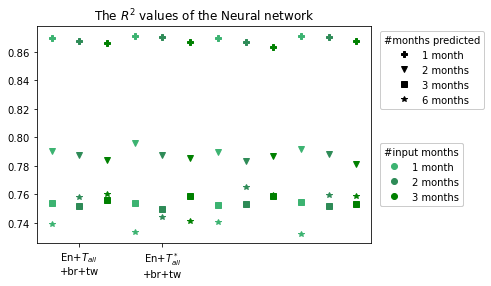

In [66]:
colors=['mediumseagreen','seagreen','green','darkgreen']
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,3,4)+0.33
plt.plot(offset_2inputs,R2_arr[4],marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr[5],marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr[6],marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_arr[7],marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,3,4)+0.66
plt.plot(offset_3inputs,R2_arr[8],marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr[9],marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr[10],marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_arr[11],marker='*',linestyle = 'None',color=colors[2])

plt.title('The $R^2$ values of the Neural network')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']
labels2 = ['1 month','2 months','3 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels2, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.33, 1.33],['En+$T_{all}$ \n+br+tw' ,'En+$T_{all}^*$ \n+br+tw'])
plt.show()

In [49]:
print(R2_arr)

[[0.8692815784437409, 0.8704551602653023], [0.7916333677769833, 0.7934167424044294], [0.750271464918258, 0.7549237820007202], [0.736922020393857, 0.7342303419826751], [0.8691001241561622, 0.8702407835449864], [0.7871034444594196, 0.7876313614628889], [0.7538818710496961, 0.7509996212354028], [0.7552457488216431, 0.7507697138548116], [0.8655995216779979, 0.865781464263763], [0.7863062410675832, 0.783611239304324], [0.7565237046630104, 0.7543775641085683], [0.7568657353538847, 0.75176563296714]]


In [67]:
#run tests
R21D_arr=[]
for data in data_arr:
    if data[0] != 1:
        print('nim=:%i nom=%i' %(data[0],data[1]))
        nim=data[0]
        nom=data[1]
        data1D=copy.deepcopy(data[2])
        data1D[1]=copy.deepcopy(data[2][1][:,-1].reshape(-1,1))
        data1D[3]=copy.deepcopy(data[2][3][:,np.arange(nim-1,nim+nom)])
        data1D[4]=copy.deepcopy(data[2][4][:,np.arange(nim-1,nim+nom)])
        data1D[5]=copy.deepcopy(data[2][5][:,np.arange(nim-1,nim+nom)])
    
        R2,_=run_NN_tests(data1D,data[2][0],1,data[1],pr=False)
        R21D_arr.append(R2)

nim=:2 nom=1
Train on 13231 samples, validate on 1471 samples
Epoch 1/20
13231/13231 [==============================] - 1s 69us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.1364 - val_mean_squared_error: 0.1364
Epoch 2/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.1338 - val_mean_squared_error: 0.1338
Epoch 3/20
13231/13231 [==============================] - 1s 39us/sample - loss: 0.1357 - mean_squared_error: 0.1357 - val_loss: 0.1307 - val_mean_squared_error: 0.1307
Epoch 4/20
13231/13231 [==============================] - 0s 34us/sample - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.1289 - val_mean_squared_error: 0.1289
Epoch 5/20
13231/13231 [==============================] - 0s 34us/sample - loss: 0.1333 - mean_squared_error: 0.1333 - val_loss: 0.1277 - val_mean_squared_error: 0.1277
Epoch 6/20
13231/13231 [==============================] - 0s 37us/sample - loss: 0.1324 - mea

13232/13232 [==============================] - 0s 33us/sample - loss: 0.1336 - mean_squared_error: 0.1336 - val_loss: 0.1094 - val_mean_squared_error: 0.1094
Epoch 9/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1091 - val_mean_squared_error: 0.1091
Epoch 10/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1118 - val_mean_squared_error: 0.1118
Epoch 11/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 12/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1323 - mean_squared_error: 0.1323 - val_loss: 0.1084 - val_mean_squared_error: 0.1084
Epoch 13/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1319 - mean_squared_error: 0.1319 - val_loss: 0.1072 - val_mean_squared_error: 

Epoch 16/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1283 - mean_squared_error: 0.1283 - val_loss: 0.1367 - val_mean_squared_error: 0.1367
Epoch 17/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1367 - val_mean_squared_error: 0.1367
Epoch 18/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1432 - val_mean_squared_error: 0.1432
Epoch 19/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1294 - mean_squared_error: 0.1294 - val_loss: 0.1390 - val_mean_squared_error: 0.1390
Epoch 20/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1356 - val_mean_squared_error: 0.1356
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 61us/sample - loss: 0.2612 - mean_square

13232/13232 [==============================] - 0s 33us/sample - loss: 0.1345 - mean_squared_error: 0.1345 - val_loss: 0.1408 - val_mean_squared_error: 0.1408
Epoch 4/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1440 - val_mean_squared_error: 0.1440
Epoch 5/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1315 - mean_squared_error: 0.1315 - val_loss: 0.1410 - val_mean_squared_error: 0.1410
Epoch 6/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1308 - mean_squared_error: 0.1308 - val_loss: 0.1430 - val_mean_squared_error: 0.1430
Epoch 7/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1433 - val_mean_squared_error: 0.1433
Epoch 8/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1292 - mean_squared_error: 0.1292 - val_loss: 0.1436 - val_mean_squared_error: 0.14

Epoch 11/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1260 - val_mean_squared_error: 0.1260
Epoch 12/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1255 - val_mean_squared_error: 0.1255
Epoch 13/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.1240 - val_mean_squared_error: 0.1240
Epoch 14/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1237 - val_mean_squared_error: 0.1237
Epoch 15/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.1241 - val_mean_squared_error: 0.1241
Epoch 16/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.1234 - val_mean_sq

Epoch 19/20
13231/13231 [==============================] - 0s 33us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1040 - val_mean_squared_error: 0.1040
Epoch 20/20
13231/13231 [==============================] - 0s 32us/sample - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1031 - val_mean_squared_error: 0.1031
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 59us/sample - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.1631 - val_mean_squared_error: 0.1631
Epoch 2/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.1551 - val_mean_squared_error: 0.1551
Epoch 3/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1334 - mean_squared_error: 0.1334 - val_loss: 0.1520 - val_mean_squared_error: 0.1520
Epoch 4/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1308 - mean_squared_e

13232/13232 [==============================] - 0s 33us/sample - loss: 0.1307 - mean_squared_error: 0.1307 - val_loss: 0.1270 - val_mean_squared_error: 0.1270
Epoch 7/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.1270 - val_mean_squared_error: 0.1270
Epoch 8/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 9/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.1262 - val_mean_squared_error: 0.1262
Epoch 10/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1261 - val_mean_squared_error: 0.1261
Epoch 11/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 0.1345 - val_mean_squared_error: 0.

Epoch 14/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.1453 - val_mean_squared_error: 0.1453
Epoch 15/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1253 - mean_squared_error: 0.1253 - val_loss: 0.1450 - val_mean_squared_error: 0.1450
Epoch 16/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1428 - val_mean_squared_error: 0.1428
Epoch 17/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1493 - val_mean_squared_error: 0.1493
Epoch 18/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1452 - val_mean_squared_error: 0.1452
Epoch 19/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1243 - mean_squared_error: 0.1243 - val_loss: 0.1435 - val_mean_sq

13232/13232 [==============================] - 1s 58us/sample - loss: 0.2560 - mean_squared_error: 0.2560 - val_loss: 0.1451 - val_mean_squared_error: 0.1451
Epoch 2/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1348 - mean_squared_error: 0.1348 - val_loss: 0.1407 - val_mean_squared_error: 0.1407
Epoch 3/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.1384 - val_mean_squared_error: 0.1384
Epoch 4/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.1291 - mean_squared_error: 0.1291 - val_loss: 0.1463 - val_mean_squared_error: 0.1463
Epoch 5/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.1398 - val_mean_squared_error: 0.1398
Epoch 6/20
13232/13232 [==============================] - 0s 32us/sample - loss: 0.1280 - mean_squared_error: 0.1280 - val_loss: 0.1418 - val_mean_squared_error: 0.14

13231/13231 [==============================] - 0s 26us/step - loss: 0.1330 - mean_squared_error: 0.1471 - val_loss: 0.1266 - val_mean_squared_error: 0.1461
Epoch 10/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1328 - mean_squared_error: 0.1453 - val_loss: 0.1249 - val_mean_squared_error: 0.1447
Epoch 11/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1330 - mean_squared_error: 0.1441 - val_loss: 0.1254 - val_mean_squared_error: 0.1436
Epoch 12/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1331 - mean_squared_error: 0.1430 - val_loss: 0.1255 - val_mean_squared_error: 0.1427
Epoch 13/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1328 - mean_squared_error: 0.1421 - val_loss: 0.1258 - val_mean_squared_error: 0.1418
Epoch 14/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1325 - mean_squared_error: 0.1414 - val_loss: 0.1278 - val_mean_squared_error: 0.1411
Epoc

13232/13232 [==============================] - 0s 26us/step - loss: 0.1327 - mean_squared_error: 0.1450 - val_loss: 0.1262 - val_mean_squared_error: 0.1447
Epoch 18/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1326 - mean_squared_error: 0.1443 - val_loss: 0.1282 - val_mean_squared_error: 0.1440
Epoch 19/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1324 - mean_squared_error: 0.1437 - val_loss: 0.1258 - val_mean_squared_error: 0.1433
Epoch 20/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1328 - mean_squared_error: 0.1431 - val_loss: 0.1269 - val_mean_squared_error: 0.1428
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2634 - mean_squared_error: 0.4439 - val_loss: 0.1697 - val_mean_squared_error: 0.2604
Epoch 2/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1382 - mean_squared_error: 0.2224 - val_los

13232/13232 [==============================] - 0s 26us/step - loss: 0.1328 - mean_squared_error: 0.1556 - val_loss: 0.1344 - val_mean_squared_error: 0.1535
Epoch 6/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1327 - mean_squared_error: 0.1513 - val_loss: 0.1336 - val_mean_squared_error: 0.1500
Epoch 7/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1333 - mean_squared_error: 0.1486 - val_loss: 0.1345 - val_mean_squared_error: 0.1476
Epoch 8/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1322 - mean_squared_error: 0.1459 - val_loss: 0.1364 - val_mean_squared_error: 0.1457
Epoch 9/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1322 - mean_squared_error: 0.1445 - val_loss: 0.1349 - val_mean_squared_error: 0.1443
Epoch 10/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1320 - mean_squared_error: 0.1435 - val_loss: 0.1353 - val_mean_squared_error: 0.1431
Epoch 11

13232/13232 [==============================] - 0s 28us/step - loss: 0.1330 - mean_squared_error: 0.1410 - val_loss: 0.1226 - val_mean_squared_error: 0.1408
Epoch 14/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1327 - mean_squared_error: 0.1405 - val_loss: 0.1234 - val_mean_squared_error: 0.1401
Epoch 15/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1328 - mean_squared_error: 0.1396 - val_loss: 0.1258 - val_mean_squared_error: 0.1396
Epoch 16/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1323 - mean_squared_error: 0.1392 - val_loss: 0.1232 - val_mean_squared_error: 0.1391
Epoch 17/20
13232/13232 [==============================] - 0s 25us/step - loss: 0.1327 - mean_squared_error: 0.1387 - val_loss: 0.1232 - val_mean_squared_error: 0.1386
Epoch 18/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1326 - mean_squared_error: 0.1385 - val_loss: 0.1242 - val_mean_squared_error: 0.1383
Epoc

13231/13231 [==============================] - 0s 34us/step - loss: 0.2817 - mean_squared_error: 0.5431 - val_loss: 0.1486 - val_mean_squared_error: 0.2751
Epoch 2/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1342 - mean_squared_error: 0.2298 - val_loss: 0.1402 - val_mean_squared_error: 0.2034
Epoch 3/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1317 - mean_squared_error: 0.1901 - val_loss: 0.1397 - val_mean_squared_error: 0.1794
Epoch 4/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1313 - mean_squared_error: 0.1721 - val_loss: 0.1427 - val_mean_squared_error: 0.1675
Epoch 5/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1307 - mean_squared_error: 0.1636 - val_loss: 0.1379 - val_mean_squared_error: 0.1602
Epoch 6/20
13231/13231 [==============================] - 0s 26us/step - loss: 0.1305 - mean_squared_error: 0.1577 - val_loss: 0.1376 - val_mean_squared_error: 0.1554
Epoch 7/2

13232/13232 [==============================] - 0s 26us/step - loss: 0.1323 - mean_squared_error: 0.1404 - val_loss: 0.1146 - val_mean_squared_error: 0.1397
Epoch 10/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1312 - mean_squared_error: 0.1391 - val_loss: 0.1159 - val_mean_squared_error: 0.1387
Epoch 11/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1311 - mean_squared_error: 0.1380 - val_loss: 0.1156 - val_mean_squared_error: 0.1378
Epoch 12/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1312 - mean_squared_error: 0.1374 - val_loss: 0.1148 - val_mean_squared_error: 0.1372
Epoch 13/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1312 - mean_squared_error: 0.1368 - val_loss: 0.1143 - val_mean_squared_error: 0.1366
Epoch 14/20
13232/13232 [==============================] - 0s 25us/step - loss: 0.1316 - mean_squared_error: 0.1364 - val_loss: 0.1156 - val_mean_squared_error: 0.1361
Epoc

13232/13232 [==============================] - 0s 26us/step - loss: 0.1302 - mean_squared_error: 0.1448 - val_loss: 0.1168 - val_mean_squared_error: 0.1445
Epoch 18/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1307 - mean_squared_error: 0.1441 - val_loss: 0.1166 - val_mean_squared_error: 0.1436
Epoch 19/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1304 - mean_squared_error: 0.1432 - val_loss: 0.1191 - val_mean_squared_error: 0.1428
Epoch 20/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1303 - mean_squared_error: 0.1424 - val_loss: 0.1167 - val_mean_squared_error: 0.1422
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.3617 - mean_squared_error: 0.6791 - val_loss: 0.1258 - val_mean_squared_error: 0.3499
Epoch 2/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1347 - mean_squared_error: 0.2794 - val_los

13232/13232 [==============================] - 0s 26us/step - loss: 0.1289 - mean_squared_error: 0.1823 - val_loss: 0.1561 - val_mean_squared_error: 0.1768
Epoch 6/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1283 - mean_squared_error: 0.1723 - val_loss: 0.1536 - val_mean_squared_error: 0.1691
Epoch 7/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1279 - mean_squared_error: 0.1661 - val_loss: 0.1574 - val_mean_squared_error: 0.1636
Epoch 8/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1277 - mean_squared_error: 0.1612 - val_loss: 0.1537 - val_mean_squared_error: 0.1594
Epoch 9/20
13232/13232 [==============================] - 0s 25us/step - loss: 0.1278 - mean_squared_error: 0.1578 - val_loss: 0.1523 - val_mean_squared_error: 0.1562
Epoch 10/20
13232/13232 [==============================] - 0s 26us/step - loss: 0.1267 - mean_squared_error: 0.1547 - val_loss: 0.1536 - val_mean_squared_error: 0.1535
Epoch 11

10751/10751 [==============================] - 0s 35us/sample - loss: 0.2185 - mean_squared_error: 0.2185 - val_loss: 0.1888 - val_mean_squared_error: 0.1888
Epoch 14/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.1870 - val_mean_squared_error: 0.1870
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2177 - mean_squared_error: 0.2177 - val_loss: 0.1871 - val_mean_squared_error: 0.1871
Epoch 16/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2170 - mean_squared_error: 0.2170 - val_loss: 0.1853 - val_mean_squared_error: 0.1853
Epoch 17/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2170 - mean_squared_error: 0.2170 - val_loss: 0.1853 - val_mean_squared_error: 0.1853
Epoch 18/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2167 - mean_squared_error: 0.2167 - val_loss: 0.1860 - val_mean_squared_error:

Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 83us/sample - loss: 0.3666 - mean_squared_error: 0.3666 - val_loss: 0.3075 - val_mean_squared_error: 0.3075
Epoch 2/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2211 - mean_squared_error: 0.2211 - val_loss: 0.2833 - val_mean_squared_error: 0.2833
Epoch 3/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.2162 - mean_squared_error: 0.2162 - val_loss: 0.2820 - val_mean_squared_error: 0.2820
Epoch 4/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.2786 - val_mean_squared_error: 0.2786
Epoch 5/20
10751/10751 [==============================] - 0s 46us/sample - loss: 0.2120 - mean_squared_error: 0.2120 - val_loss: 0.2763 - val_mean_squared_error: 0.2763
Epoch 6/20
10751/10751 [==============================] - 1s 47us/sample - loss: 0.2112 - mean_squared_err

10751/10751 [==============================] - 0s 34us/sample - loss: 0.2173 - mean_squared_error: 0.2173 - val_loss: 0.2304 - val_mean_squared_error: 0.2304
Epoch 9/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2163 - mean_squared_error: 0.2163 - val_loss: 0.2323 - val_mean_squared_error: 0.2323
Epoch 10/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2159 - mean_squared_error: 0.2159 - val_loss: 0.2295 - val_mean_squared_error: 0.2295
Epoch 11/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2149 - mean_squared_error: 0.2149 - val_loss: 0.2276 - val_mean_squared_error: 0.2276
Epoch 12/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2148 - mean_squared_error: 0.2148 - val_loss: 0.2267 - val_mean_squared_error: 0.2267
Epoch 13/20
10751/10751 [==============================] - 0s 37us/sample - loss: 0.2134 - mean_squared_error: 0.2134 - val_loss: 0.2327 - val_mean_squared_error: 

Epoch 16/20
10752/10752 [==============================] - 0s 46us/sample - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2437 - val_mean_squared_error: 0.2437
Epoch 17/20
10752/10752 [==============================] - 0s 46us/sample - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2420 - val_mean_squared_error: 0.2420
Epoch 18/20
10752/10752 [==============================] - 0s 36us/sample - loss: 0.2096 - mean_squared_error: 0.2096 - val_loss: 0.2415 - val_mean_squared_error: 0.2415
Epoch 19/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.2409 - val_mean_squared_error: 0.2409
Epoch 20/20
10752/10752 [==============================] - 0s 46us/sample - loss: 0.2090 - mean_squared_error: 0.2090 - val_loss: 0.2439 - val_mean_squared_error: 0.2439
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 92us/sample - loss: 0.3479 - mean_square

10751/10751 [==============================] - 0s 34us/sample - loss: 0.2238 - mean_squared_error: 0.2238 - val_loss: 0.2324 - val_mean_squared_error: 0.2324
Epoch 4/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2192 - mean_squared_error: 0.2192 - val_loss: 0.2317 - val_mean_squared_error: 0.2317
Epoch 5/20
10751/10751 [==============================] - 0s 39us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.2278 - val_mean_squared_error: 0.2278
Epoch 6/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2165 - mean_squared_error: 0.2165 - val_loss: 0.2292 - val_mean_squared_error: 0.2292
Epoch 7/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2147 - mean_squared_error: 0.2147 - val_loss: 0.2331 - val_mean_squared_error: 0.2331
Epoch 8/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.2152 - mean_squared_error: 0.2152 - val_loss: 0.2295 - val_mean_squared_error: 0.22

Epoch 11/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.2045 - val_mean_squared_error: 0.2045
Epoch 12/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2140 - mean_squared_error: 0.2140 - val_loss: 0.2043 - val_mean_squared_error: 0.2043
Epoch 13/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.2140 - mean_squared_error: 0.2140 - val_loss: 0.2034 - val_mean_squared_error: 0.2034
Epoch 14/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2127 - mean_squared_error: 0.2127 - val_loss: 0.2014 - val_mean_squared_error: 0.2014
Epoch 15/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2135 - mean_squared_error: 0.2135 - val_loss: 0.2031 - val_mean_squared_error: 0.2031
Epoch 16/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2129 - mean_squared_error: 0.2129 - val_loss: 0.2014 - val_mean_sq

Epoch 19/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2110 - mean_squared_error: 0.2110 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 20/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2114 - mean_squared_error: 0.2114 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 78us/sample - loss: 0.4191 - mean_squared_error: 0.4191 - val_loss: 0.2276 - val_mean_squared_error: 0.2276
Epoch 2/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.2339 - mean_squared_error: 0.2339 - val_loss: 0.2094 - val_mean_squared_error: 0.2094
Epoch 3/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.2250 - mean_squared_error: 0.2250 - val_loss: 0.2071 - val_mean_squared_error: 0.2071
Epoch 4/20
10751/10751 [==============================] - 0s 37us/sample - loss: 0.2223 - mean_squared_e

10752/10752 [==============================] - 0s 37us/sample - loss: 0.2210 - mean_squared_error: 0.2210 - val_loss: 0.1996 - val_mean_squared_error: 0.1996
Epoch 7/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2194 - mean_squared_error: 0.2194 - val_loss: 0.1882 - val_mean_squared_error: 0.1882
Epoch 8/20
10752/10752 [==============================] - 0s 39us/sample - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.1885 - val_mean_squared_error: 0.1885
Epoch 9/20
10752/10752 [==============================] - 0s 39us/sample - loss: 0.2177 - mean_squared_error: 0.2177 - val_loss: 0.1917 - val_mean_squared_error: 0.1917
Epoch 10/20
10752/10752 [==============================] - 0s 38us/sample - loss: 0.2177 - mean_squared_error: 0.2177 - val_loss: 0.1874 - val_mean_squared_error: 0.1874
Epoch 11/20
10752/10752 [==============================] - 0s 39us/sample - loss: 0.2157 - mean_squared_error: 0.2157 - val_loss: 0.1854 - val_mean_squared_error: 0.

Epoch 14/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2078 - mean_squared_error: 0.2078 - val_loss: 0.2491 - val_mean_squared_error: 0.2491
Epoch 15/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2069 - mean_squared_error: 0.2069 - val_loss: 0.2491 - val_mean_squared_error: 0.2491
Epoch 16/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2076 - mean_squared_error: 0.2076 - val_loss: 0.2490 - val_mean_squared_error: 0.2490
Epoch 17/20
10752/10752 [==============================] - 0s 38us/sample - loss: 0.2064 - mean_squared_error: 0.2064 - val_loss: 0.2543 - val_mean_squared_error: 0.2543
Epoch 18/20
10752/10752 [==============================] - 0s 36us/sample - loss: 0.2063 - mean_squared_error: 0.2063 - val_loss: 0.2500 - val_mean_squared_error: 0.2500
Epoch 19/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.2562 - val_mean_sq

Epoch 2/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2337 - mean_squared_error: 0.2941 - val_loss: 0.2029 - val_mean_squared_error: 0.2763
Epoch 3/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2256 - mean_squared_error: 0.2652 - val_loss: 0.1984 - val_mean_squared_error: 0.2582
Epoch 4/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.2234 - mean_squared_error: 0.2527 - val_loss: 0.1963 - val_mean_squared_error: 0.2488
Epoch 5/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2225 - mean_squared_error: 0.2455 - val_loss: 0.1968 - val_mean_squared_error: 0.2429
Epoch 6/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2218 - mean_squared_error: 0.2392 - val_loss: 0.2028 - val_mean_squared_error: 0.2390
Epoch 7/20
10751/10751 [==============================] - 0s 37us/step - loss: 0.2212 - mean_squared_error: 0.2376 - val_loss: 0.1949 - val_mean_squared_error: 0.236

10751/10751 [==============================] - 0s 39us/step - loss: 0.2171 - mean_squared_error: 0.2412 - val_loss: 0.2308 - val_mean_squared_error: 0.2402
Epoch 11/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2163 - mean_squared_error: 0.2390 - val_loss: 0.2238 - val_mean_squared_error: 0.2381
Epoch 12/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2162 - mean_squared_error: 0.2376 - val_loss: 0.2239 - val_mean_squared_error: 0.2363
Epoch 13/20
10751/10751 [==============================] - 0s 31us/step - loss: 0.2168 - mean_squared_error: 0.2357 - val_loss: 0.2235 - val_mean_squared_error: 0.2349
Epoch 14/20
10751/10751 [==============================] - 0s 31us/step - loss: 0.2161 - mean_squared_error: 0.2338 - val_loss: 0.2237 - val_mean_squared_error: 0.2336
Epoch 15/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.2158 - mean_squared_error: 0.2331 - val_loss: 0.2223 - val_mean_squared_error: 0.2324
Epoc

Epoch 18/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.2094 - mean_squared_error: 0.2251 - val_loss: 0.2686 - val_mean_squared_error: 0.2250
Epoch 19/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2096 - mean_squared_error: 0.2247 - val_loss: 0.2662 - val_mean_squared_error: 0.2245
Epoch 20/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.2094 - mean_squared_error: 0.2243 - val_loss: 0.2729 - val_mean_squared_error: 0.2241
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 0s 45us/step - loss: 0.3336 - mean_squared_error: 0.4684 - val_loss: 0.2450 - val_mean_squared_error: 0.3303
Epoch 2/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2266 - mean_squared_error: 0.2952 - val_loss: 0.2394 - val_mean_squared_error: 0.2780
Epoch 3/20
10752/10752 [==============================] - 0s 35us/step - loss: 0.2207 - mean_squared_error: 0.267

10752/10752 [==============================] - 0s 33us/step - loss: 0.2169 - mean_squared_error: 0.2507 - val_loss: 0.2425 - val_mean_squared_error: 0.2482
Epoch 7/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2171 - mean_squared_error: 0.2462 - val_loss: 0.2427 - val_mean_squared_error: 0.2441
Epoch 8/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2159 - mean_squared_error: 0.2423 - val_loss: 0.2393 - val_mean_squared_error: 0.2408
Epoch 9/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2152 - mean_squared_error: 0.2388 - val_loss: 0.2390 - val_mean_squared_error: 0.2382
Epoch 10/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2162 - mean_squared_error: 0.2377 - val_loss: 0.2406 - val_mean_squared_error: 0.2363
Epoch 11/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.2146 - mean_squared_error: 0.2352 - val_loss: 0.2414 - val_mean_squared_error: 0.2345
Epoch 1

10751/10751 [==============================] - 0s 32us/step - loss: 0.2204 - mean_squared_error: 0.2290 - val_loss: 0.1688 - val_mean_squared_error: 0.2282
Epoch 15/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.2194 - mean_squared_error: 0.2278 - val_loss: 0.1687 - val_mean_squared_error: 0.2273
Epoch 16/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2192 - mean_squared_error: 0.2268 - val_loss: 0.1708 - val_mean_squared_error: 0.2265
Epoch 17/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2192 - mean_squared_error: 0.2261 - val_loss: 0.1683 - val_mean_squared_error: 0.2257
Epoch 18/20
10751/10751 [==============================] - 0s 31us/step - loss: 0.2185 - mean_squared_error: 0.2255 - val_loss: 0.1723 - val_mean_squared_error: 0.2251
Epoch 19/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.2188 - mean_squared_error: 0.2248 - val_loss: 0.1745 - val_mean_squared_error: 0.2245
Epoc

10751/10751 [==============================] - 0s 36us/step - loss: 0.2280 - mean_squared_error: 0.3444 - val_loss: 0.2178 - val_mean_squared_error: 0.3117
Epoch 3/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2234 - mean_squared_error: 0.2935 - val_loss: 0.2076 - val_mean_squared_error: 0.2814
Epoch 4/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2209 - mean_squared_error: 0.2727 - val_loss: 0.2128 - val_mean_squared_error: 0.2658
Epoch 5/20
10751/10751 [==============================] - 0s 37us/step - loss: 0.2192 - mean_squared_error: 0.2615 - val_loss: 0.2078 - val_mean_squared_error: 0.2562
Epoch 6/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.2189 - mean_squared_error: 0.2517 - val_loss: 0.2045 - val_mean_squared_error: 0.2497
Epoch 7/20
10751/10751 [==============================] - 0s 37us/step - loss: 0.2186 - mean_squared_error: 0.2475 - val_loss: 0.2047 - val_mean_squared_error: 0.2451
Epoch 8/2

10752/10752 [==============================] - 0s 40us/step - loss: 0.2147 - mean_squared_error: 0.2436 - val_loss: 0.2270 - val_mean_squared_error: 0.2423
Epoch 11/20
10752/10752 [==============================] - 0s 39us/step - loss: 0.2151 - mean_squared_error: 0.2413 - val_loss: 0.2254 - val_mean_squared_error: 0.2399
Epoch 12/20
10752/10752 [==============================] - 0s 40us/step - loss: 0.2144 - mean_squared_error: 0.2389 - val_loss: 0.2226 - val_mean_squared_error: 0.2378
Epoch 13/20
10752/10752 [==============================] - 0s 39us/step - loss: 0.2146 - mean_squared_error: 0.2372 - val_loss: 0.2217 - val_mean_squared_error: 0.2361
Epoch 14/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2140 - mean_squared_error: 0.2355 - val_loss: 0.2253 - val_mean_squared_error: 0.2346
Epoch 15/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2141 - mean_squared_error: 0.2341 - val_loss: 0.2225 - val_mean_squared_error: 0.2333
Epoc

10752/10752 [==============================] - 0s 42us/step - loss: 0.2139 - mean_squared_error: 0.2280 - val_loss: 0.2176 - val_mean_squared_error: 0.2275
Epoch 19/20
10752/10752 [==============================] - 0s 38us/step - loss: 0.2133 - mean_squared_error: 0.2269 - val_loss: 0.2144 - val_mean_squared_error: 0.2268
Epoch 20/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2135 - mean_squared_error: 0.2265 - val_loss: 0.2142 - val_mean_squared_error: 0.2261
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 54us/step - loss: 0.4601 - mean_squared_error: 0.7012 - val_loss: 0.2315 - val_mean_squared_error: 0.4481
Epoch 2/20
10752/10752 [==============================] - 0s 38us/step - loss: 0.2275 - mean_squared_error: 0.3783 - val_loss: 0.2267 - val_mean_squared_error: 0.3352
Epoch 3/20
10752/10752 [==============================] - 0s 38us/step - loss: 0.2226 - mean_squared_error: 0.3143 - val_loss

8551/8551 [==============================] - 0s 46us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2532 - val_mean_squared_error: 0.2532
Epoch 7/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2476 - val_mean_squared_error: 0.2476
Epoch 8/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2481 - val_mean_squared_error: 0.2481
Epoch 9/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2483 - val_mean_squared_error: 0.2483
Epoch 10/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.2506 - val_mean_squared_error: 0.2506
Epoch 11/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2493 - mean_squared_error: 0.2493 - val_loss: 0.2480 - val_mean_squared_error: 0.2480
Epoch 1

8551/8551 [==============================] - 0s 45us/sample - loss: 0.2527 - mean_squared_error: 0.2527 - val_loss: 0.1984 - val_mean_squared_error: 0.1984
Epoch 15/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.1984 - val_mean_squared_error: 0.1984
Epoch 16/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2034 - val_mean_squared_error: 0.2034
Epoch 17/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.1973 - val_mean_squared_error: 0.1973
Epoch 18/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2506 - mean_squared_error: 0.2506 - val_loss: 0.1982 - val_mean_squared_error: 0.1982
Epoch 19/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.1954 - val_mean_squared_error: 0.1954
Epoc

8551/8551 [==============================] - 0s 50us/sample - loss: 0.2716 - mean_squared_error: 0.2716 - val_loss: 0.2474 - val_mean_squared_error: 0.2474
Epoch 3/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2636 - mean_squared_error: 0.2636 - val_loss: 0.2434 - val_mean_squared_error: 0.2434
Epoch 4/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2604 - mean_squared_error: 0.2604 - val_loss: 0.2380 - val_mean_squared_error: 0.2380
Epoch 5/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2580 - mean_squared_error: 0.2580 - val_loss: 0.2424 - val_mean_squared_error: 0.2424
Epoch 6/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.2384 - val_mean_squared_error: 0.2384
Epoch 7/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2376 - val_mean_squared_error: 0.2376
Epoch 8/2

8551/8551 [==============================] - 0s 47us/sample - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2748 - val_mean_squared_error: 0.2748
Epoch 11/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2471 - mean_squared_error: 0.2471 - val_loss: 0.2745 - val_mean_squared_error: 0.2745
Epoch 12/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2746 - val_mean_squared_error: 0.2746
Epoch 13/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2456 - mean_squared_error: 0.2456 - val_loss: 0.2751 - val_mean_squared_error: 0.2751
Epoch 14/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2456 - mean_squared_error: 0.2456 - val_loss: 0.2748 - val_mean_squared_error: 0.2748
Epoch 15/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.2739 - val_mean_squared_error: 0.2739
Epoc

8550/8550 [==============================] - 1s 62us/sample - loss: 0.2463 - mean_squared_error: 0.2463 - val_loss: 0.2631 - val_mean_squared_error: 0.2631
Epoch 19/20
8550/8550 [==============================] - 1s 61us/sample - loss: 0.2438 - mean_squared_error: 0.2438 - val_loss: 0.2634 - val_mean_squared_error: 0.2634
Epoch 20/20
8550/8550 [==============================] - 1s 70us/sample - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.2630 - val_mean_squared_error: 0.2630
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 123us/sample - loss: 0.4256 - mean_squared_error: 0.4256 - val_loss: 0.2448 - val_mean_squared_error: 0.2448
Epoch 2/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2679 - mean_squared_error: 0.2679 - val_loss: 0.2318 - val_mean_squared_error: 0.2318
Epoch 3/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2615 - mean_squared_error: 0.2615 - val_loss:

8551/8551 [==============================] - 0s 45us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.3101 - val_mean_squared_error: 0.3101
Epoch 7/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.3085 - val_mean_squared_error: 0.3085
Epoch 8/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.3085 - val_mean_squared_error: 0.3085
Epoch 9/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2452 - mean_squared_error: 0.2452 - val_loss: 0.3094 - val_mean_squared_error: 0.3094
Epoch 10/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.3051 - val_mean_squared_error: 0.3051
Epoch 11/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.3051 - val_mean_squared_error: 0.3051
Epoch 1

8551/8551 [==============================] - 0s 48us/sample - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2444 - val_mean_squared_error: 0.2444
Epoch 15/20
8551/8551 [==============================] - 0s 49us/sample - loss: 0.2474 - mean_squared_error: 0.2474 - val_loss: 0.2365 - val_mean_squared_error: 0.2365
Epoch 16/20
8551/8551 [==============================] - 0s 48us/sample - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.2427 - val_mean_squared_error: 0.2427
Epoch 17/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.2424 - val_mean_squared_error: 0.2424
Epoch 18/20
8551/8551 [==============================] - 0s 49us/sample - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.2358 - val_mean_squared_error: 0.2358
Epoch 19/20
8551/8551 [==============================] - 0s 50us/sample - loss: 0.2464 - mean_squared_error: 0.2464 - val_loss: 0.2375 - val_mean_squared_error: 0.2375
Epoc

8551/8551 [==============================] - 0s 49us/sample - loss: 0.2709 - mean_squared_error: 0.2709 - val_loss: 0.2640 - val_mean_squared_error: 0.2640
Epoch 3/20
8551/8551 [==============================] - 0s 48us/sample - loss: 0.2594 - mean_squared_error: 0.2594 - val_loss: 0.2624 - val_mean_squared_error: 0.2624
Epoch 4/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.2607 - val_mean_squared_error: 0.2607
Epoch 5/20
8551/8551 [==============================] - 0s 48us/sample - loss: 0.2537 - mean_squared_error: 0.2537 - val_loss: 0.2623 - val_mean_squared_error: 0.2623
Epoch 6/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2585 - val_mean_squared_error: 0.2585
Epoch 7/20
8551/8551 [==============================] - 0s 49us/sample - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.2574 - val_mean_squared_error: 0.2574
Epoch 8/2

8550/8550 [==============================] - 0s 40us/step - loss: 0.2396 - mean_squared_error: 0.2690 - val_loss: 0.3476 - val_mean_squared_error: 0.2686
Epoch 11/20
8550/8550 [==============================] - 0s 40us/step - loss: 0.2389 - mean_squared_error: 0.2673 - val_loss: 0.3514 - val_mean_squared_error: 0.2669
Epoch 12/20
8550/8550 [==============================] - 0s 41us/step - loss: 0.2389 - mean_squared_error: 0.2660 - val_loss: 0.3465 - val_mean_squared_error: 0.2655
Epoch 13/20
8550/8550 [==============================] - 0s 37us/step - loss: 0.2386 - mean_squared_error: 0.2649 - val_loss: 0.3495 - val_mean_squared_error: 0.2643
Epoch 14/20
8550/8550 [==============================] - 0s 38us/step - loss: 0.2384 - mean_squared_error: 0.2635 - val_loss: 0.3469 - val_mean_squared_error: 0.2632
Epoch 15/20
8550/8550 [==============================] - 0s 40us/step - loss: 0.2382 - mean_squared_error: 0.2625 - val_loss: 0.3449 - val_mean_squared_error: 0.2622
Epoch 16/20
8550

Epoch 19/20
8551/8551 [==============================] - 0s 40us/step - loss: 0.2506 - mean_squared_error: 0.2691 - val_loss: 0.2378 - val_mean_squared_error: 0.2685
Epoch 20/20
8551/8551 [==============================] - 0s 42us/step - loss: 0.2494 - mean_squared_error: 0.2682 - val_loss: 0.2387 - val_mean_squared_error: 0.2675
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 60us/step - loss: 0.5592 - mean_squared_error: 0.8740 - val_loss: 0.2307 - val_mean_squared_error: 0.5414
Epoch 2/20
8551/8551 [==============================] - 0s 42us/step - loss: 0.2745 - mean_squared_error: 0.4502 - val_loss: 0.2144 - val_mean_squared_error: 0.4020
Epoch 3/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.2663 - mean_squared_error: 0.3768 - val_loss: 0.2087 - val_mean_squared_error: 0.3541
Epoch 4/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2622 - mean_squared_error: 0.3409 - val_loss: 0

Epoch 8/20
8551/8551 [==============================] - 0s 46us/step - loss: 0.2572 - mean_squared_error: 0.2860 - val_loss: 0.2048 - val_mean_squared_error: 0.2837
Epoch 9/20
8551/8551 [==============================] - 0s 44us/step - loss: 0.2562 - mean_squared_error: 0.2818 - val_loss: 0.2056 - val_mean_squared_error: 0.2801
Epoch 10/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2558 - mean_squared_error: 0.2789 - val_loss: 0.2054 - val_mean_squared_error: 0.2771
Epoch 11/20
8551/8551 [==============================] - 0s 42us/step - loss: 0.2552 - mean_squared_error: 0.2761 - val_loss: 0.2043 - val_mean_squared_error: 0.2747
Epoch 12/20
8551/8551 [==============================] - 0s 45us/step - loss: 0.2551 - mean_squared_error: 0.2738 - val_loss: 0.2067 - val_mean_squared_error: 0.2726
Epoch 13/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2552 - mean_squared_error: 0.2716 - val_loss: 0.2036 - val_mean_squared_error: 0.2709
Epoch 

Epoch 17/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2402 - mean_squared_error: 0.2656 - val_loss: 0.3340 - val_mean_squared_error: 0.2651
Epoch 18/20
8551/8551 [==============================] - 0s 42us/step - loss: 0.2403 - mean_squared_error: 0.2646 - val_loss: 0.3316 - val_mean_squared_error: 0.2642
Epoch 19/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2401 - mean_squared_error: 0.2637 - val_loss: 0.3289 - val_mean_squared_error: 0.2634
Epoch 20/20
8551/8551 [==============================] - 0s 43us/step - loss: 0.2403 - mean_squared_error: 0.2632 - val_loss: 0.3297 - val_mean_squared_error: 0.2627
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 59us/step - loss: 0.4313 - mean_squared_error: 0.6116 - val_loss: 0.2886 - val_mean_squared_error: 0.4255
Epoch 2/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2644 - mean_squared_error: 0.3731 - val_loss:

8550/8550 [==============================] - 0s 41us/step - loss: 0.2499 - mean_squared_error: 0.3246 - val_loss: 0.2697 - val_mean_squared_error: 0.3156
Epoch 6/20
8550/8550 [==============================] - 0s 43us/step - loss: 0.2492 - mean_squared_error: 0.3099 - val_loss: 0.2730 - val_mean_squared_error: 0.3048
Epoch 7/20
8550/8550 [==============================] - 0s 39us/step - loss: 0.2486 - mean_squared_error: 0.3003 - val_loss: 0.2781 - val_mean_squared_error: 0.2971
Epoch 8/20
8550/8550 [==============================] - 0s 37us/step - loss: 0.2483 - mean_squared_error: 0.2946 - val_loss: 0.2726 - val_mean_squared_error: 0.2913
Epoch 9/20
8550/8550 [==============================] - 0s 38us/step - loss: 0.2471 - mean_squared_error: 0.2886 - val_loss: 0.2701 - val_mean_squared_error: 0.2866
Epoch 10/20
8550/8550 [==============================] - 0s 39us/step - loss: 0.2467 - mean_squared_error: 0.2845 - val_loss: 0.2743 - val_mean_squared_error: 0.2829
Epoch 11/20
8550/855

Epoch 14/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.2516 - mean_squared_error: 0.2719 - val_loss: 0.2239 - val_mean_squared_error: 0.2707
Epoch 15/20
8551/8551 [==============================] - 0s 43us/step - loss: 0.2527 - mean_squared_error: 0.2694 - val_loss: 0.2253 - val_mean_squared_error: 0.2693
Epoch 16/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2514 - mean_squared_error: 0.2685 - val_loss: 0.2258 - val_mean_squared_error: 0.2680
Epoch 17/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2503 - mean_squared_error: 0.2673 - val_loss: 0.2267 - val_mean_squared_error: 0.2669
Epoch 18/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.2523 - mean_squared_error: 0.2666 - val_loss: 0.2247 - val_mean_squared_error: 0.2659
Epoch 19/20
8551/8551 [==============================] - 0s 45us/step - loss: 0.2506 - mean_squared_error: 0.2653 - val_loss: 0.2253 - val_mean_squared_error: 0.2649
Epoc

8551/8551 [==============================] - 0s 41us/step - loss: 0.2623 - mean_squared_error: 0.3899 - val_loss: 0.2351 - val_mean_squared_error: 0.3528
Epoch 3/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.2579 - mean_squared_error: 0.3342 - val_loss: 0.2337 - val_mean_squared_error: 0.3198
Epoch 4/20
8551/8551 [==============================] - 0s 42us/step - loss: 0.2555 - mean_squared_error: 0.3123 - val_loss: 0.2326 - val_mean_squared_error: 0.3030
Epoch 5/20
8551/8551 [==============================] - ETA: 0s - loss: 0.2551 - mean_squared_error: 0.29 - 0s 40us/step - loss: 0.2547 - mean_squared_error: 0.2980 - val_loss: 0.2420 - val_mean_squared_error: 0.2929
Epoch 6/20
8551/8551 [==============================] - 0s 38us/step - loss: 0.2537 - mean_squared_error: 0.2886 - val_loss: 0.2400 - val_mean_squared_error: 0.2862
Epoch 7/20
8551/8551 [==============================] - 0s 37us/step - loss: 0.2540 - mean_squared_error: 0.2830 - val_loss: 0.2460 - 

8551/8551 [==============================] - 0s 44us/step - loss: 0.2474 - mean_squared_error: 0.2800 - val_loss: 0.2884 - val_mean_squared_error: 0.2792
Epoch 11/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.2476 - mean_squared_error: 0.2778 - val_loss: 0.2807 - val_mean_squared_error: 0.2766
Epoch 12/20
8551/8551 [==============================] - 0s 37us/step - loss: 0.2462 - mean_squared_error: 0.2752 - val_loss: 0.2786 - val_mean_squared_error: 0.2743
Epoch 13/20
8551/8551 [==============================] - 0s 38us/step - loss: 0.2470 - mean_squared_error: 0.2733 - val_loss: 0.2757 - val_mean_squared_error: 0.2725
Epoch 14/20
8551/8551 [==============================] - 0s 37us/step - loss: 0.2459 - mean_squared_error: 0.2711 - val_loss: 0.2809 - val_mean_squared_error: 0.2708
Epoch 15/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2463 - mean_squared_error: 0.2699 - val_loss: 0.2813 - val_mean_squared_error: 0.2694
Epoch 16/20
8551

Epoch 19/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2450 - mean_squared_error: 0.2648 - val_loss: 0.2728 - val_mean_squared_error: 0.2644
Epoch 20/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2454 - mean_squared_error: 0.2642 - val_loss: 0.2690 - val_mean_squared_error: 0.2636
nim=:2 nom=6
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 198us/sample - loss: 0.8861 - mean_squared_error: 0.8861 - val_loss: 0.6689 - val_mean_squared_error: 0.6689
Epoch 2/20
2496/2496 [==============================] - 0s 40us/sample - loss: 0.5145 - mean_squared_error: 0.5145 - val_loss: 0.4088 - val_mean_squared_error: 0.4088
Epoch 3/20
2496/2496 [==============================] - 0s 40us/sample - loss: 0.3388 - mean_squared_error: 0.3388 - val_loss: 0.3108 - val_mean_squared_error: 0.3108
Epoch 4/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2886 - mean_squared_error

Epoch 7/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2587 - mean_squared_error: 0.2587 - val_loss: 0.2221 - val_mean_squared_error: 0.2221
Epoch 8/20
2496/2496 [==============================] - 0s 40us/sample - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2207 - val_mean_squared_error: 0.2207
Epoch 9/20
2496/2496 [==============================] - 0s 39us/sample - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2208 - val_mean_squared_error: 0.2208
Epoch 10/20
2496/2496 [==============================] - 0s 40us/sample - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.2178 - val_mean_squared_error: 0.2178
Epoch 11/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2181 - val_mean_squared_error: 0.2181
Epoch 12/20
2496/2496 [==============================] - 0s 40us/sample - loss: 0.2496 - mean_squared_error: 0.2496 - val_loss: 0.2157 - val_mean_squared_error: 0.

2497/2497 [==============================] - 0s 37us/sample - loss: 0.2451 - mean_squared_error: 0.2451 - val_loss: 0.2691 - val_mean_squared_error: 0.2691
Epoch 16/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2436 - mean_squared_error: 0.2436 - val_loss: 0.2706 - val_mean_squared_error: 0.2706
Epoch 17/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2729 - val_mean_squared_error: 0.2729
Epoch 18/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2420 - mean_squared_error: 0.2420 - val_loss: 0.2717 - val_mean_squared_error: 0.2717
Epoch 19/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2400 - mean_squared_error: 0.2400 - val_loss: 0.2709 - val_mean_squared_error: 0.2709
Epoch 20/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2398 - mean_squared_error: 0.2398 - val_loss: 0.2697 - val_mean_squared_error: 0.2697
Trai

2497/2497 [==============================] - 0s 36us/sample - loss: 0.3525 - mean_squared_error: 0.3525 - val_loss: 0.4039 - val_mean_squared_error: 0.4039
Epoch 4/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2906 - mean_squared_error: 0.2906 - val_loss: 0.3506 - val_mean_squared_error: 0.3506
Epoch 5/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2704 - mean_squared_error: 0.2704 - val_loss: 0.3315 - val_mean_squared_error: 0.3315
Epoch 6/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2609 - mean_squared_error: 0.2609 - val_loss: 0.3224 - val_mean_squared_error: 0.3224
Epoch 7/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.3151 - val_mean_squared_error: 0.3151
Epoch 8/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.3146 - val_mean_squared_error: 0.3146
Epoch 9/2

2497/2497 [==============================] - 0s 36us/sample - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2664 - val_mean_squared_error: 0.2664
Epoch 12/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2473 - mean_squared_error: 0.2473 - val_loss: 0.2667 - val_mean_squared_error: 0.2667
Epoch 13/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.2661 - val_mean_squared_error: 0.2661
Epoch 14/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2449 - mean_squared_error: 0.2449 - val_loss: 0.2652 - val_mean_squared_error: 0.2652
Epoch 15/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.2672 - val_mean_squared_error: 0.2672
Epoch 16/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.2662 - val_mean_squared_error: 0.2662
Epoc

2496/2496 [==============================] - 0s 42us/sample - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.1540 - val_mean_squared_error: 0.1540
Epoch 20/20
2496/2496 [==============================] - 0s 35us/sample - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.1532 - val_mean_squared_error: 0.1532
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 160us/sample - loss: 0.9250 - mean_squared_error: 0.9250 - val_loss: 0.7501 - val_mean_squared_error: 0.7501
Epoch 2/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.5156 - mean_squared_error: 0.5156 - val_loss: 0.4962 - val_mean_squared_error: 0.4962
Epoch 3/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.3404 - mean_squared_error: 0.3404 - val_loss: 0.3817 - val_mean_squared_error: 0.3817
Epoch 4/20
2496/2496 [==============================] - 0s 34us/sample - loss: 0.2825 - mean_squared_error: 0.2825 - val_loss: 

2497/2497 [==============================] - 0s 37us/sample - loss: 0.2594 - mean_squared_error: 0.2594 - val_loss: 0.3225 - val_mean_squared_error: 0.3225
Epoch 8/20
2497/2497 [==============================] - 0s 35us/sample - loss: 0.2537 - mean_squared_error: 0.2537 - val_loss: 0.3265 - val_mean_squared_error: 0.3265
Epoch 9/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.3200 - val_mean_squared_error: 0.3200
Epoch 10/20
2497/2497 [==============================] - 0s 35us/sample - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.3203 - val_mean_squared_error: 0.3203
Epoch 11/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2450 - mean_squared_error: 0.2450 - val_loss: 0.3157 - val_mean_squared_error: 0.3157
Epoch 12/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2442 - mean_squared_error: 0.2442 - val_loss: 0.3185 - val_mean_squared_error: 0.3185
Epoch 

2497/2497 [==============================] - 0s 37us/sample - loss: 0.2434 - mean_squared_error: 0.2434 - val_loss: 0.2699 - val_mean_squared_error: 0.2699
Epoch 16/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2435 - mean_squared_error: 0.2435 - val_loss: 0.2559 - val_mean_squared_error: 0.2559
Epoch 17/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2585 - val_mean_squared_error: 0.2585
Epoch 18/20
2497/2497 [==============================] - 0s 35us/sample - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.2561 - val_mean_squared_error: 0.2561
Epoch 19/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2586 - val_mean_squared_error: 0.2586
Epoch 20/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.2562 - val_mean_squared_error: 0.2562
Trai

2497/2497 [==============================] - 0s 37us/sample - loss: 0.3683 - mean_squared_error: 0.3683 - val_loss: 0.4238 - val_mean_squared_error: 0.4238
Epoch 4/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2923 - mean_squared_error: 0.2923 - val_loss: 0.3805 - val_mean_squared_error: 0.3805
Epoch 5/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2705 - mean_squared_error: 0.2705 - val_loss: 0.3741 - val_mean_squared_error: 0.3741
Epoch 6/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2616 - mean_squared_error: 0.2616 - val_loss: 0.3702 - val_mean_squared_error: 0.3702
Epoch 7/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2631 - mean_squared_error: 0.2631 - val_loss: 0.3645 - val_mean_squared_error: 0.3645
Epoch 8/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2532 - mean_squared_error: 0.2532 - val_loss: 0.3616 - val_mean_squared_error: 0.3616
Epoch 9/2

Epoch 12/20
2496/2496 [==============================] - 0s 26us/step - loss: 0.2423 - mean_squared_error: 0.3188 - val_loss: 0.2801 - val_mean_squared_error: 0.3164
Epoch 13/20
2496/2496 [==============================] - 0s 26us/step - loss: 0.2409 - mean_squared_error: 0.3129 - val_loss: 0.2848 - val_mean_squared_error: 0.3109
Epoch 14/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2401 - mean_squared_error: 0.3086 - val_loss: 0.2809 - val_mean_squared_error: 0.3062
Epoch 15/20
2496/2496 [==============================] - 0s 26us/step - loss: 0.2402 - mean_squared_error: 0.3038 - val_loss: 0.2801 - val_mean_squared_error: 0.3020
Epoch 16/20
2496/2496 [==============================] - 0s 25us/step - loss: 0.2392 - mean_squared_error: 0.2998 - val_loss: 0.2840 - val_mean_squared_error: 0.2984
Epoch 17/20
2496/2496 [==============================] - 0s 26us/step - loss: 0.2383 - mean_squared_error: 0.2969 - val_loss: 0.2806 - val_mean_squared_error: 0.2951
Epoc

Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 67us/step - loss: 0.8357 - mean_squared_error: 0.9309 - val_loss: 0.4661 - val_mean_squared_error: 0.8109
Epoch 2/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.4532 - mean_squared_error: 0.7000 - val_loss: 0.3080 - val_mean_squared_error: 0.6244
Epoch 3/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.3122 - mean_squared_error: 0.5692 - val_loss: 0.2674 - val_mean_squared_error: 0.5177
Epoch 4/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2739 - mean_squared_error: 0.4825 - val_loss: 0.2622 - val_mean_squared_error: 0.4558
Epoch 5/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2614 - mean_squared_error: 0.4352 - val_loss: 0.2556 - val_mean_squared_error: 0.4165
Epoch 6/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2582 - mean_squared_error: 0.4036 - val_loss: 0.2

Epoch 10/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2479 - mean_squared_error: 0.3450 - val_loss: 0.2365 - val_mean_squared_error: 0.3397
Epoch 11/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2464 - mean_squared_error: 0.3349 - val_loss: 0.2388 - val_mean_squared_error: 0.3311
Epoch 12/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2460 - mean_squared_error: 0.3277 - val_loss: 0.2364 - val_mean_squared_error: 0.3239
Epoch 13/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2450 - mean_squared_error: 0.3208 - val_loss: 0.2393 - val_mean_squared_error: 0.3178
Epoch 14/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2434 - mean_squared_error: 0.3144 - val_loss: 0.2353 - val_mean_squared_error: 0.3124
Epoch 15/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2428 - mean_squared_error: 0.3097 - val_loss: 0.2375 - val_mean_squared_error: 0.3077
Epoc

Epoch 19/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2420 - mean_squared_error: 0.2999 - val_loss: 0.2343 - val_mean_squared_error: 0.2988
Epoch 20/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2418 - mean_squared_error: 0.2977 - val_loss: 0.2344 - val_mean_squared_error: 0.2959
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 70us/step - loss: 1.0210 - mean_squared_error: 1.0922 - val_loss: 0.6992 - val_mean_squared_error: 1.0058
Epoch 2/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.6011 - mean_squared_error: 0.9063 - val_loss: 0.3766 - val_mean_squared_error: 0.7936
Epoch 3/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.3698 - mean_squared_error: 0.7158 - val_loss: 0.2364 - val_mean_squared_error: 0.6473
Epoch 4/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2913 - mean_squared_error: 0.5967 - val_loss: 0

Epoch 8/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2571 - mean_squared_error: 0.3771 - val_loss: 0.2011 - val_mean_squared_error: 0.3695
Epoch 9/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2566 - mean_squared_error: 0.3626 - val_loss: 0.1957 - val_mean_squared_error: 0.3562
Epoch 10/20
2496/2496 [==============================] - 0s 26us/step - loss: 0.2555 - mean_squared_error: 0.3509 - val_loss: 0.1924 - val_mean_squared_error: 0.3455
Epoch 11/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2531 - mean_squared_error: 0.3409 - val_loss: 0.1935 - val_mean_squared_error: 0.3365
Epoch 12/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2523 - mean_squared_error: 0.3322 - val_loss: 0.1925 - val_mean_squared_error: 0.3290
Epoch 13/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2505 - mean_squared_error: 0.3253 - val_loss: 0.1928 - val_mean_squared_error: 0.3225
Epoch 

Epoch 17/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2474 - mean_squared_error: 0.3322 - val_loss: 0.2460 - val_mean_squared_error: 0.3296
Epoch 18/20
2496/2496 [==============================] - 0s 26us/step - loss: 0.2442 - mean_squared_error: 0.3272 - val_loss: 0.2426 - val_mean_squared_error: 0.3249
Epoch 19/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2441 - mean_squared_error: 0.3230 - val_loss: 0.2405 - val_mean_squared_error: 0.3206
Epoch 20/20
2496/2496 [==============================] - 0s 27us/step - loss: 0.2427 - mean_squared_error: 0.3183 - val_loss: 0.2447 - val_mean_squared_error: 0.3167
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 69us/step - loss: 0.8032 - mean_squared_error: 0.9192 - val_loss: 0.5291 - val_mean_squared_error: 0.7847
Epoch 2/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.4606 - mean_squared_error: 0.7031 - val_loss:

2497/2497 [==============================] - 0s 27us/step - loss: 0.2886 - mean_squared_error: 0.5214 - val_loss: 0.2271 - val_mean_squared_error: 0.4948
Epoch 6/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2764 - mean_squared_error: 0.4751 - val_loss: 0.2228 - val_mean_squared_error: 0.4573
Epoch 7/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2684 - mean_squared_error: 0.4433 - val_loss: 0.2249 - val_mean_squared_error: 0.4295
Epoch 8/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2737 - mean_squared_error: 0.4204 - val_loss: 0.2189 - val_mean_squared_error: 0.4092
Epoch 9/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2614 - mean_squared_error: 0.4015 - val_loss: 0.2126 - val_mean_squared_error: 0.3922
Epoch 10/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2609 - mean_squared_error: 0.3852 - val_loss: 0.2049 - val_mean_squared_error: 0.3785
Epoch 11/20
2497/249

Epoch 14/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2571 - mean_squared_error: 0.3372 - val_loss: 0.1849 - val_mean_squared_error: 0.3339
Epoch 15/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2523 - mean_squared_error: 0.3306 - val_loss: 0.1782 - val_mean_squared_error: 0.3279
Epoch 16/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2533 - mean_squared_error: 0.3258 - val_loss: 0.1808 - val_mean_squared_error: 0.3228
Epoch 17/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2514 - mean_squared_error: 0.3205 - val_loss: 0.1857 - val_mean_squared_error: 0.3182
Epoch 18/20
2497/2497 [==============================] - 0s 26us/step - loss: 0.2498 - mean_squared_error: 0.3165 - val_loss: 0.1821 - val_mean_squared_error: 0.3140
Epoch 19/20
2497/2497 [==============================] - 0s 27us/step - loss: 0.2497 - mean_squared_error: 0.3120 - val_loss: 0.1796 - val_mean_squared_error: 0.3102
Epoc

10751/10751 [==============================] - 0s 33us/sample - loss: 0.1438 - mean_squared_error: 0.1438 - val_loss: 0.1172 - val_mean_squared_error: 0.1172
Epoch 3/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.1188 - val_mean_squared_error: 0.1188
Epoch 4/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1401 - mean_squared_error: 0.1401 - val_loss: 0.1166 - val_mean_squared_error: 0.1166
Epoch 5/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1397 - mean_squared_error: 0.1397 - val_loss: 0.1200 - val_mean_squared_error: 0.1200
Epoch 6/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.1168 - val_mean_squared_error: 0.1168
Epoch 7/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.1162 - val_mean_squared_error: 0.11

Epoch 10/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1401 - mean_squared_error: 0.1401 - val_loss: 0.0952 - val_mean_squared_error: 0.0952
Epoch 11/20
10751/10751 [==============================] - 0s 31us/sample - loss: 0.1391 - mean_squared_error: 0.1391 - val_loss: 0.0958 - val_mean_squared_error: 0.0958
Epoch 12/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.0979 - val_mean_squared_error: 0.0979
Epoch 13/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1389 - mean_squared_error: 0.1389 - val_loss: 0.0959 - val_mean_squared_error: 0.0959
Epoch 14/20
10751/10751 [==============================] - 0s 31us/sample - loss: 0.1384 - mean_squared_error: 0.1384 - val_loss: 0.0956 - val_mean_squared_error: 0.0956
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.0951 - val_mean_sq

Epoch 18/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1297 - mean_squared_error: 0.1297 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Epoch 19/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1300 - mean_squared_error: 0.1300 - val_loss: 0.1636 - val_mean_squared_error: 0.1636
Epoch 20/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1298 - mean_squared_error: 0.1298 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 61us/sample - loss: 0.3234 - mean_squared_error: 0.3234 - val_loss: 0.1277 - val_mean_squared_error: 0.1277
Epoch 2/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1514 - mean_squared_error: 0.1514 - val_loss: 0.1287 - val_mean_squared_error: 0.1287
Epoch 3/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1445 - mean_squared_

10752/10752 [==============================] - 0s 31us/sample - loss: 0.1369 - mean_squared_error: 0.1369 - val_loss: 0.1500 - val_mean_squared_error: 0.1500
Epoch 6/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1359 - mean_squared_error: 0.1359 - val_loss: 0.1456 - val_mean_squared_error: 0.1456
Epoch 7/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1356 - mean_squared_error: 0.1356 - val_loss: 0.1452 - val_mean_squared_error: 0.1452
Epoch 8/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.1449 - val_mean_squared_error: 0.1449
Epoch 9/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1343 - mean_squared_error: 0.1343 - val_loss: 0.1513 - val_mean_squared_error: 0.1513
Epoch 10/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1335 - mean_squared_error: 0.1335 - val_loss: 0.1476 - val_mean_squared_error: 0.1

Epoch 13/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1631 - val_mean_squared_error: 0.1631
Epoch 14/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1639 - val_mean_squared_error: 0.1639
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1279 - mean_squared_error: 0.1279 - val_loss: 0.1777 - val_mean_squared_error: 0.1777
Epoch 16/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1277 - mean_squared_error: 0.1277 - val_loss: 0.1625 - val_mean_squared_error: 0.1625
Epoch 17/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 0.1622 - val_mean_squared_error: 0.1622
Epoch 18/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1276 - mean_squared_error: 0.1276 - val_loss: 0.1637 - val_mean_sq

Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 65us/sample - loss: 0.3757 - mean_squared_error: 0.3757 - val_loss: 0.1512 - val_mean_squared_error: 0.1512
Epoch 2/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1455 - mean_squared_error: 0.1455 - val_loss: 0.1388 - val_mean_squared_error: 0.1388
Epoch 3/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.1409 - mean_squared_error: 0.1409 - val_loss: 0.1328 - val_mean_squared_error: 0.1328
Epoch 4/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.1382 - mean_squared_error: 0.1382 - val_loss: 0.1329 - val_mean_squared_error: 0.1329
Epoch 5/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.1321 - val_mean_squared_error: 0.1321
Epoch 6/20
10751/10751 [==============================] - 0s 32us/sample - loss: 0.1367 - mean_squared_err

10751/10751 [==============================] - 0s 33us/sample - loss: 0.1277 - mean_squared_error: 0.1277 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 9/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1269 - mean_squared_error: 0.1269 - val_loss: 0.1815 - val_mean_squared_error: 0.1815
Epoch 10/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1267 - mean_squared_error: 0.1267 - val_loss: 0.1824 - val_mean_squared_error: 0.1824
Epoch 11/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1261 - mean_squared_error: 0.1261 - val_loss: 0.1861 - val_mean_squared_error: 0.1861
Epoch 12/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1265 - mean_squared_error: 0.1265 - val_loss: 0.1834 - val_mean_squared_error: 0.1834
Epoch 13/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1260 - mean_squared_error: 0.1260 - val_loss: 0.1839 - val_mean_squared_error: 

Epoch 16/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 0.1230 - val_mean_squared_error: 0.1230
Epoch 17/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1315 - mean_squared_error: 0.1315 - val_loss: 0.1275 - val_mean_squared_error: 0.1275
Epoch 18/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1316 - mean_squared_error: 0.1316 - val_loss: 0.1249 - val_mean_squared_error: 0.1249
Epoch 19/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1315 - mean_squared_error: 0.1315 - val_loss: 0.1253 - val_mean_squared_error: 0.1253
Epoch 20/20
10752/10752 [==============================] - 0s 31us/sample - loss: 0.1320 - mean_squared_error: 0.1320 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 61us/sample - loss: 0.3558 - mean_square

10751/10751 [==============================] - 0s 33us/step - loss: 0.1396 - mean_squared_error: 0.1614 - val_loss: 0.1246 - val_mean_squared_error: 0.1582
Epoch 4/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.1393 - mean_squared_error: 0.1556 - val_loss: 0.1247 - val_mean_squared_error: 0.1530
Epoch 5/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.1387 - mean_squared_error: 0.1516 - val_loss: 0.1222 - val_mean_squared_error: 0.1498
Epoch 6/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.1381 - mean_squared_error: 0.1487 - val_loss: 0.1229 - val_mean_squared_error: 0.1476
Epoch 7/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.1385 - mean_squared_error: 0.1467 - val_loss: 0.1219 - val_mean_squared_error: 0.1461
Epoch 8/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.1379 - mean_squared_error: 0.1453 - val_loss: 0.1222 - val_mean_squared_error: 0.1448
Epoch 9/2

10751/10751 [==============================] - 0s 26us/step - loss: 0.1403 - mean_squared_error: 0.1477 - val_loss: 0.1043 - val_mean_squared_error: 0.1472
Epoch 12/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1398 - mean_squared_error: 0.1465 - val_loss: 0.1029 - val_mean_squared_error: 0.1463
Epoch 13/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1403 - mean_squared_error: 0.1458 - val_loss: 0.1066 - val_mean_squared_error: 0.1455
Epoch 14/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1401 - mean_squared_error: 0.1453 - val_loss: 0.1042 - val_mean_squared_error: 0.1449
Epoch 15/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1397 - mean_squared_error: 0.1446 - val_loss: 0.1069 - val_mean_squared_error: 0.1443
Epoch 16/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1399 - mean_squared_error: 0.1442 - val_loss: 0.1013 - val_mean_squared_error: 0.1438
Epoc

10751/10751 [==============================] - 0s 26us/step - loss: 0.1331 - mean_squared_error: 0.1417 - val_loss: 0.1547 - val_mean_squared_error: 0.1417
Epoch 20/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1334 - mean_squared_error: 0.1414 - val_loss: 0.1557 - val_mean_squared_error: 0.1414
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.4328 - mean_squared_error: 0.8398 - val_loss: 0.2015 - val_mean_squared_error: 0.4239
Epoch 2/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1468 - mean_squared_error: 0.3343 - val_loss: 0.1839 - val_mean_squared_error: 0.2843
Epoch 3/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1380 - mean_squared_error: 0.2564 - val_loss: 0.1781 - val_mean_squared_error: 0.2362
Epoch 4/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1345 - mean_squared_error: 0.2222 - val_loss:

10752/10752 [==============================] - 0s 25us/step - loss: 0.1368 - mean_squared_error: 0.1681 - val_loss: 0.1435 - val_mean_squared_error: 0.1667
Epoch 8/20
10752/10752 [==============================] - 0s 25us/step - loss: 0.1366 - mean_squared_error: 0.1647 - val_loss: 0.1423 - val_mean_squared_error: 0.1630
Epoch 9/20
10752/10752 [==============================] - 0s 25us/step - loss: 0.1361 - mean_squared_error: 0.1616 - val_loss: 0.1451 - val_mean_squared_error: 0.1601
Epoch 10/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1356 - mean_squared_error: 0.1584 - val_loss: 0.1472 - val_mean_squared_error: 0.1578
Epoch 11/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1359 - mean_squared_error: 0.1566 - val_loss: 0.1403 - val_mean_squared_error: 0.1558
Epoch 12/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1367 - mean_squared_error: 0.1548 - val_loss: 0.1401 - val_mean_squared_error: 0.1542
Epoch 

10752/10752 [==============================] - 0s 33us/step - loss: 0.1382 - mean_squared_error: 0.1544 - val_loss: 0.1259 - val_mean_squared_error: 0.1539
Epoch 16/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.1381 - mean_squared_error: 0.1533 - val_loss: 0.1239 - val_mean_squared_error: 0.1528
Epoch 17/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.1381 - mean_squared_error: 0.1523 - val_loss: 0.1267 - val_mean_squared_error: 0.1519
Epoch 18/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.1379 - mean_squared_error: 0.1516 - val_loss: 0.1217 - val_mean_squared_error: 0.1510
Epoch 19/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.1376 - mean_squared_error: 0.1506 - val_loss: 0.1238 - val_mean_squared_error: 0.1503
Epoch 20/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.1380 - mean_squared_error: 0.1498 - val_loss: 0.1223 - val_mean_squared_error: 0.1496
Trai

10751/10751 [==============================] - 0s 26us/step - loss: 0.1345 - mean_squared_error: 0.1561 - val_loss: 0.1603 - val_mean_squared_error: 0.1526
Epoch 4/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1338 - mean_squared_error: 0.1496 - val_loss: 0.1544 - val_mean_squared_error: 0.1485
Epoch 5/20
10751/10751 [==============================] - 0s 25us/step - loss: 0.1331 - mean_squared_error: 0.1462 - val_loss: 0.1539 - val_mean_squared_error: 0.1458
Epoch 6/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1331 - mean_squared_error: 0.1442 - val_loss: 0.1545 - val_mean_squared_error: 0.1440
Epoch 7/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1324 - mean_squared_error: 0.1434 - val_loss: 0.1558 - val_mean_squared_error: 0.1427
Epoch 8/20
10751/10751 [==============================] - 0s 25us/step - loss: 0.1318 - mean_squared_error: 0.1425 - val_loss: 0.1590 - val_mean_squared_error: 0.1416
Epoch 9/2

10751/10751 [==============================] - 0s 26us/step - loss: 0.1380 - mean_squared_error: 0.1682 - val_loss: 0.1007 - val_mean_squared_error: 0.1670
Epoch 12/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1386 - mean_squared_error: 0.1657 - val_loss: 0.1054 - val_mean_squared_error: 0.1643
Epoch 13/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1374 - mean_squared_error: 0.1631 - val_loss: 0.1008 - val_mean_squared_error: 0.1620
Epoch 14/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1371 - mean_squared_error: 0.1609 - val_loss: 0.1052 - val_mean_squared_error: 0.1600
Epoch 15/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1379 - mean_squared_error: 0.1590 - val_loss: 0.0999 - val_mean_squared_error: 0.1582
Epoch 16/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.1383 - mean_squared_error: 0.1571 - val_loss: 0.1064 - val_mean_squared_error: 0.1568
Epoc

10752/10752 [==============================] - 0s 27us/step - loss: 0.1323 - mean_squared_error: 0.1443 - val_loss: 0.1468 - val_mean_squared_error: 0.1444
Epoch 20/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1326 - mean_squared_error: 0.1441 - val_loss: 0.1441 - val_mean_squared_error: 0.1438
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 0s 36us/step - loss: 0.3594 - mean_squared_error: 0.6662 - val_loss: 0.1661 - val_mean_squared_error: 0.3494
Epoch 2/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1406 - mean_squared_error: 0.2832 - val_loss: 0.1584 - val_mean_squared_error: 0.2435
Epoch 3/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1374 - mean_squared_error: 0.2242 - val_loss: 0.1582 - val_mean_squared_error: 0.2083
Epoch 4/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1353 - mean_squared_error: 0.1985 - val_loss:

10752/10752 [==============================] - 0s 25us/step - loss: 0.1345 - mean_squared_error: 0.1422 - val_loss: 0.1305 - val_mean_squared_error: 0.1421
Epoch 8/20
10752/10752 [==============================] - 0s 25us/step - loss: 0.1340 - mean_squared_error: 0.1414 - val_loss: 0.1316 - val_mean_squared_error: 0.1410
Epoch 9/20
10752/10752 [==============================] - 0s 25us/step - loss: 0.1344 - mean_squared_error: 0.1406 - val_loss: 0.1280 - val_mean_squared_error: 0.1402
Epoch 10/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1339 - mean_squared_error: 0.1397 - val_loss: 0.1315 - val_mean_squared_error: 0.1395
Epoch 11/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1346 - mean_squared_error: 0.1395 - val_loss: 0.1289 - val_mean_squared_error: 0.1390
Epoch 12/20
10752/10752 [==============================] - 0s 26us/step - loss: 0.1339 - mean_squared_error: 0.1387 - val_loss: 0.1268 - val_mean_squared_error: 0.1386
Epoch 

8551/8551 [==============================] - 0s 33us/sample - loss: 0.2219 - mean_squared_error: 0.2219 - val_loss: 0.1825 - val_mean_squared_error: 0.1825
Epoch 16/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2208 - mean_squared_error: 0.2208 - val_loss: 0.1811 - val_mean_squared_error: 0.1811
Epoch 17/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2201 - mean_squared_error: 0.2201 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 18/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2199 - mean_squared_error: 0.2199 - val_loss: 0.1807 - val_mean_squared_error: 0.1807
Epoch 19/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2195 - mean_squared_error: 0.2195 - val_loss: 0.1822 - val_mean_squared_error: 0.1822
Epoch 20/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2190 - mean_squared_error: 0.2190 - val_loss: 0.1824 - val_mean_squared_error: 0.1824
Trai

8551/8551 [==============================] - 0s 39us/sample - loss: 0.2313 - mean_squared_error: 0.2313 - val_loss: 0.2084 - val_mean_squared_error: 0.2084
Epoch 4/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2288 - mean_squared_error: 0.2288 - val_loss: 0.2078 - val_mean_squared_error: 0.2078
Epoch 5/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.2031 - val_mean_squared_error: 0.2031
Epoch 6/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2252 - mean_squared_error: 0.2252 - val_loss: 0.2049 - val_mean_squared_error: 0.2049
Epoch 7/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2236 - mean_squared_error: 0.2236 - val_loss: 0.2034 - val_mean_squared_error: 0.2034
Epoch 8/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2232 - mean_squared_error: 0.2232 - val_loss: 0.2021 - val_mean_squared_error: 0.2021
Epoch 9/2

8551/8551 [==============================] - 0s 40us/sample - loss: 0.2181 - mean_squared_error: 0.2181 - val_loss: 0.2355 - val_mean_squared_error: 0.2355
Epoch 12/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2166 - mean_squared_error: 0.2166 - val_loss: 0.2322 - val_mean_squared_error: 0.2322
Epoch 13/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2156 - mean_squared_error: 0.2156 - val_loss: 0.2328 - val_mean_squared_error: 0.2328
Epoch 14/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2159 - mean_squared_error: 0.2159 - val_loss: 0.2302 - val_mean_squared_error: 0.2302
Epoch 15/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2155 - mean_squared_error: 0.2155 - val_loss: 0.2309 - val_mean_squared_error: 0.2309
Epoch 16/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.2303 - val_mean_squared_error: 0.2303
Epoc

8551/8551 [==============================] - 0s 38us/sample - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.1972 - val_mean_squared_error: 0.1972
Epoch 20/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2196 - mean_squared_error: 0.2196 - val_loss: 0.1928 - val_mean_squared_error: 0.1928
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 87us/sample - loss: 0.4785 - mean_squared_error: 0.4785 - val_loss: 0.2294 - val_mean_squared_error: 0.2294
Epoch 2/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.2095 - val_mean_squared_error: 0.2095
Epoch 3/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2356 - mean_squared_error: 0.2356 - val_loss: 0.2051 - val_mean_squared_error: 0.2051
Epoch 4/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2317 - mean_squared_error: 0.2317 - val_loss: 0

8551/8551 [==============================] - 0s 39us/sample - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.2110 - val_mean_squared_error: 0.2110
Epoch 8/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2196 - mean_squared_error: 0.2196 - val_loss: 0.2126 - val_mean_squared_error: 0.2126
Epoch 9/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.2104 - val_mean_squared_error: 0.2104
Epoch 10/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2184 - mean_squared_error: 0.2184 - val_loss: 0.2098 - val_mean_squared_error: 0.2098
Epoch 11/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.2150 - val_mean_squared_error: 0.2150
Epoch 12/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2168 - mean_squared_error: 0.2168 - val_loss: 0.2100 - val_mean_squared_error: 0.2100
Epoch 

8551/8551 [==============================] - 0s 39us/sample - loss: 0.2098 - mean_squared_error: 0.2098 - val_loss: 0.2620 - val_mean_squared_error: 0.2620
Epoch 16/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2101 - mean_squared_error: 0.2101 - val_loss: 0.2654 - val_mean_squared_error: 0.2654
Epoch 17/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2104 - mean_squared_error: 0.2104 - val_loss: 0.2634 - val_mean_squared_error: 0.2634
Epoch 18/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2084 - mean_squared_error: 0.2084 - val_loss: 0.2699 - val_mean_squared_error: 0.2699
Epoch 19/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2112 - mean_squared_error: 0.2112 - val_loss: 0.2664 - val_mean_squared_error: 0.2664
Epoch 20/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2089 - mean_squared_error: 0.2089 - val_loss: 0.2735 - val_mean_squared_error: 0.2735
Trai

8551/8551 [==============================] - 0s 41us/sample - loss: 0.2237 - mean_squared_error: 0.2237 - val_loss: 0.2618 - val_mean_squared_error: 0.2618
Epoch 4/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2201 - mean_squared_error: 0.2201 - val_loss: 0.2612 - val_mean_squared_error: 0.2612
Epoch 5/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.2587 - val_mean_squared_error: 0.2587
Epoch 6/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2158 - mean_squared_error: 0.2158 - val_loss: 0.2589 - val_mean_squared_error: 0.2589
Epoch 7/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2158 - mean_squared_error: 0.2158 - val_loss: 0.2520 - val_mean_squared_error: 0.2520
Epoch 8/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2141 - mean_squared_error: 0.2141 - val_loss: 0.2506 - val_mean_squared_error: 0.2506
Epoch 9/2

8551/8551 [==============================] - 0s 39us/sample - loss: 0.2209 - mean_squared_error: 0.2209 - val_loss: 0.1907 - val_mean_squared_error: 0.1907
Epoch 12/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2198 - mean_squared_error: 0.2198 - val_loss: 0.1778 - val_mean_squared_error: 0.1778
Epoch 13/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2192 - mean_squared_error: 0.2192 - val_loss: 0.1765 - val_mean_squared_error: 0.1765
Epoch 14/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2190 - mean_squared_error: 0.2190 - val_loss: 0.1775 - val_mean_squared_error: 0.1775
Epoch 15/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2175 - mean_squared_error: 0.2175 - val_loss: 0.1777 - val_mean_squared_error: 0.1777
Epoch 16/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.1860 - val_mean_squared_error: 0.1860
Epoc

8550/8550 [==============================] - 0s 31us/step - loss: 0.2227 - mean_squared_error: 0.2351 - val_loss: 0.1940 - val_mean_squared_error: 0.2347
Epoch 20/20
8550/8550 [==============================] - 0s 31us/step - loss: 0.2218 - mean_squared_error: 0.2340 - val_loss: 0.1911 - val_mean_squared_error: 0.2339
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 45us/step - loss: 0.4726 - mean_squared_error: 0.7017 - val_loss: 0.2310 - val_mean_squared_error: 0.4604
Epoch 2/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2372 - mean_squared_error: 0.3841 - val_loss: 0.2264 - val_mean_squared_error: 0.3456
Epoch 3/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2304 - mean_squared_error: 0.3228 - val_loss: 0.2198 - val_mean_squared_error: 0.3063
Epoch 4/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2271 - mean_squared_error: 0.2947 - val_loss: 0.2188 - val_

Epoch 8/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2242 - mean_squared_error: 0.2522 - val_loss: 0.2115 - val_mean_squared_error: 0.2502
Epoch 9/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2233 - mean_squared_error: 0.2476 - val_loss: 0.2092 - val_mean_squared_error: 0.2470
Epoch 10/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2234 - mean_squared_error: 0.2457 - val_loss: 0.2081 - val_mean_squared_error: 0.2445
Epoch 11/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2232 - mean_squared_error: 0.2429 - val_loss: 0.2059 - val_mean_squared_error: 0.2424
Epoch 12/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2219 - mean_squared_error: 0.2410 - val_loss: 0.2112 - val_mean_squared_error: 0.2406
Epoch 13/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2223 - mean_squared_error: 0.2394 - val_loss: 0.2103 - val_mean_squared_error: 0.2391
Epoch 

Epoch 17/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2164 - mean_squared_error: 0.2360 - val_loss: 0.2590 - val_mean_squared_error: 0.2357
Epoch 18/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2158 - mean_squared_error: 0.2352 - val_loss: 0.2528 - val_mean_squared_error: 0.2348
Epoch 19/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2159 - mean_squared_error: 0.2347 - val_loss: 0.2604 - val_mean_squared_error: 0.2340
Epoch 20/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2163 - mean_squared_error: 0.2339 - val_loss: 0.2570 - val_mean_squared_error: 0.2334
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 46us/step - loss: 0.4372 - mean_squared_error: 0.6625 - val_loss: 0.2383 - val_mean_squared_error: 0.4286
Epoch 2/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2361 - mean_squared_error: 0.3660 - val_loss:

8551/8551 [==============================] - 0s 30us/step - loss: 0.2191 - mean_squared_error: 0.2667 - val_loss: 0.2672 - val_mean_squared_error: 0.2638
Epoch 6/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2184 - mean_squared_error: 0.2591 - val_loss: 0.2645 - val_mean_squared_error: 0.2570
Epoch 7/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2184 - mean_squared_error: 0.2548 - val_loss: 0.2633 - val_mean_squared_error: 0.2521
Epoch 8/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2176 - mean_squared_error: 0.2487 - val_loss: 0.2648 - val_mean_squared_error: 0.2484
Epoch 9/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2171 - mean_squared_error: 0.2461 - val_loss: 0.2641 - val_mean_squared_error: 0.2454
Epoch 10/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2170 - mean_squared_error: 0.2436 - val_loss: 0.2635 - val_mean_squared_error: 0.2430
Epoch 11/20
8551/855

Epoch 14/20
8550/8550 [==============================] - 0s 43us/step - loss: 0.2157 - mean_squared_error: 0.2368 - val_loss: 0.2464 - val_mean_squared_error: 0.2361
Epoch 15/20
8550/8550 [==============================] - 0s 38us/step - loss: 0.2157 - mean_squared_error: 0.2354 - val_loss: 0.2473 - val_mean_squared_error: 0.2349
Epoch 16/20
8550/8550 [==============================] - 0s 35us/step - loss: 0.2154 - mean_squared_error: 0.2347 - val_loss: 0.2471 - val_mean_squared_error: 0.2339
Epoch 17/20
8550/8550 [==============================] - 0s 44us/step - loss: 0.2139 - mean_squared_error: 0.2333 - val_loss: 0.2461 - val_mean_squared_error: 0.2329
Epoch 18/20
8550/8550 [==============================] - 0s 35us/step - loss: 0.2143 - mean_squared_error: 0.2324 - val_loss: 0.2469 - val_mean_squared_error: 0.2320
Epoch 19/20
8550/8550 [==============================] - 0s 32us/step - loss: 0.2143 - mean_squared_error: 0.2318 - val_loss: 0.2441 - val_mean_squared_error: 0.2313
Epoc

8551/8551 [==============================] - 0s 33us/step - loss: 0.2345 - mean_squared_error: 0.3759 - val_loss: 0.1918 - val_mean_squared_error: 0.3357
Epoch 3/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2299 - mean_squared_error: 0.3136 - val_loss: 0.1928 - val_mean_squared_error: 0.2986
Epoch 4/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2289 - mean_squared_error: 0.2882 - val_loss: 0.1913 - val_mean_squared_error: 0.2800
Epoch 5/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2273 - mean_squared_error: 0.2734 - val_loss: 0.1905 - val_mean_squared_error: 0.2686
Epoch 6/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2262 - mean_squared_error: 0.2639 - val_loss: 0.1900 - val_mean_squared_error: 0.2609
Epoch 7/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2249 - mean_squared_error: 0.2580 - val_loss: 0.1894 - val_mean_squared_error: 0.2552
Epoch 8/20
8551/8551 

8551/8551 [==============================] - 0s 32us/step - loss: 0.2233 - mean_squared_error: 0.2353 - val_loss: 0.1809 - val_mean_squared_error: 0.2343
Epoch 12/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2226 - mean_squared_error: 0.2337 - val_loss: 0.1752 - val_mean_squared_error: 0.2330
Epoch 13/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2229 - mean_squared_error: 0.2323 - val_loss: 0.1746 - val_mean_squared_error: 0.2318
Epoch 14/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2225 - mean_squared_error: 0.2317 - val_loss: 0.1754 - val_mean_squared_error: 0.2308
Epoch 15/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2211 - mean_squared_error: 0.2301 - val_loss: 0.1735 - val_mean_squared_error: 0.2299
Epoch 16/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2212 - mean_squared_error: 0.2294 - val_loss: 0.1778 - val_mean_squared_error: 0.2290
Epoch 17/20
8551

Epoch 20/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2172 - mean_squared_error: 0.2305 - val_loss: 0.2228 - val_mean_squared_error: 0.2301
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 47us/step - loss: 0.5603 - mean_squared_error: 0.8508 - val_loss: 0.3012 - val_mean_squared_error: 0.5506
Epoch 2/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2293 - mean_squared_error: 0.4492 - val_loss: 0.2761 - val_mean_squared_error: 0.3890
Epoch 3/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2210 - mean_squared_error: 0.3557 - val_loss: 0.2702 - val_mean_squared_error: 0.3338
Epoch 4/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2184 - mean_squared_error: 0.3169 - val_loss: 0.2695 - val_mean_squared_error: 0.3059
Epoch 5/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2169 - mean_squared_error: 0.2958 - val_loss: 0.

6590/6590 [==============================] - 0s 38us/sample - loss: 0.2546 - mean_squared_error: 0.2546 - val_loss: 0.2073 - val_mean_squared_error: 0.2073
Epoch 9/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2538 - mean_squared_error: 0.2538 - val_loss: 0.2073 - val_mean_squared_error: 0.2073
Epoch 10/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2535 - mean_squared_error: 0.2535 - val_loss: 0.2056 - val_mean_squared_error: 0.2056
Epoch 11/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2056 - val_mean_squared_error: 0.2056
Epoch 12/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2053 - val_mean_squared_error: 0.2053
Epoch 13/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 0.2045 - val_mean_squared_error: 0.2045
Epoch

6590/6590 [==============================] - 0s 39us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.2037 - val_mean_squared_error: 0.2037
Epoch 17/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.1985 - val_mean_squared_error: 0.1985
Epoch 18/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 0.2011 - val_mean_squared_error: 0.2011
Epoch 19/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2458 - mean_squared_error: 0.2458 - val_loss: 0.1994 - val_mean_squared_error: 0.1994
Epoch 20/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2451 - mean_squared_error: 0.2451 - val_loss: 0.2020 - val_mean_squared_error: 0.2020
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 104us/sample - loss: 0.4971 - mean_squared_error: 0.4971 - val_los

6591/6591 [==============================] - 0s 39us/sample - loss: 0.2595 - mean_squared_error: 0.2595 - val_loss: 0.1997 - val_mean_squared_error: 0.1997
Epoch 5/20
6591/6591 [==============================] - 0s 39us/sample - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.1973 - val_mean_squared_error: 0.1973
Epoch 6/20
6591/6591 [==============================] - 0s 39us/sample - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.1985 - val_mean_squared_error: 0.1985
Epoch 7/20
6591/6591 [==============================] - 0s 39us/sample - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2034 - val_mean_squared_error: 0.2034
Epoch 8/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2520 - mean_squared_error: 0.2520 - val_loss: 0.1980 - val_mean_squared_error: 0.1980
Epoch 9/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.2004 - val_mean_squared_error: 0.2004
Epoch 10/

6591/6591 [==============================] - 0s 38us/sample - loss: 0.2458 - mean_squared_error: 0.2458 - val_loss: 0.2480 - val_mean_squared_error: 0.2480
Epoch 13/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2457 - mean_squared_error: 0.2457 - val_loss: 0.2456 - val_mean_squared_error: 0.2456
Epoch 14/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2452 - val_mean_squared_error: 0.2452
Epoch 15/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2445 - mean_squared_error: 0.2445 - val_loss: 0.2440 - val_mean_squared_error: 0.2440
Epoch 16/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2447 - mean_squared_error: 0.2447 - val_loss: 0.2454 - val_mean_squared_error: 0.2454
Epoch 17/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2432 - mean_squared_error: 0.2432 - val_loss: 0.2447 - val_mean_squared_error: 0.2447
Epoc

6591/6591 [==============================] - 0s 40us/sample - loss: 0.2414 - mean_squared_error: 0.2414 - val_loss: 0.2467 - val_mean_squared_error: 0.2467
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 1s 103us/sample - loss: 0.5632 - mean_squared_error: 0.5632 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 2/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2659 - mean_squared_error: 0.2659 - val_loss: 0.3094 - val_mean_squared_error: 0.3094
Epoch 3/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.3025 - val_mean_squared_error: 0.3025
Epoch 4/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.3002 - val_mean_squared_error: 0.3002
Epoch 5/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 0

6590/6590 [==============================] - 0s 38us/sample - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.1736 - val_mean_squared_error: 0.1736
Epoch 9/20
6590/6590 [==============================] - 0s 37us/sample - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 10/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.1697 - val_mean_squared_error: 0.1697
Epoch 11/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2526 - mean_squared_error: 0.2526 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 12/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.1697 - val_mean_squared_error: 0.1697
Epoch 13/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.1711 - val_mean_squared_error: 0.1711
Epoch

6591/6591 [==============================] - 0s 48us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.2700 - val_mean_squared_error: 0.2700
Epoch 17/20
6591/6591 [==============================] - 0s 46us/sample - loss: 0.2405 - mean_squared_error: 0.2405 - val_loss: 0.2681 - val_mean_squared_error: 0.2681
Epoch 18/20
6591/6591 [==============================] - 0s 40us/sample - loss: 0.2387 - mean_squared_error: 0.2387 - val_loss: 0.2685 - val_mean_squared_error: 0.2685
Epoch 19/20
6591/6591 [==============================] - 0s 41us/sample - loss: 0.2389 - mean_squared_error: 0.2389 - val_loss: 0.2808 - val_mean_squared_error: 0.2808
Epoch 20/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2389 - mean_squared_error: 0.2389 - val_loss: 0.2714 - val_mean_squared_error: 0.2714
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 101us/sample - loss: 0.5083 - mean_squared_error: 0.5083 - val_los

6591/6591 [==============================] - 0s 37us/sample - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2786 - val_mean_squared_error: 0.2786
Epoch 5/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.2797 - val_mean_squared_error: 0.2797
Epoch 6/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.2715 - val_mean_squared_error: 0.2715
Epoch 7/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2814 - val_mean_squared_error: 0.2814
Epoch 8/20
6591/6591 [==============================] - 0s 39us/sample - loss: 0.2436 - mean_squared_error: 0.2436 - val_loss: 0.2748 - val_mean_squared_error: 0.2748
Epoch 9/20
6591/6591 [==============================] - 0s 43us/sample - loss: 0.2432 - mean_squared_error: 0.2432 - val_loss: 0.2709 - val_mean_squared_error: 0.2709
Epoch 10/

6591/6591 [==============================] - 0s 38us/sample - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2142 - val_mean_squared_error: 0.2142
Epoch 13/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2459 - mean_squared_error: 0.2459 - val_loss: 0.2177 - val_mean_squared_error: 0.2177
Epoch 14/20
6591/6591 [==============================] - 0s 39us/sample - loss: 0.2448 - mean_squared_error: 0.2448 - val_loss: 0.2190 - val_mean_squared_error: 0.2190
Epoch 15/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.2169 - val_mean_squared_error: 0.2169
Epoch 16/20
6591/6591 [==============================] - 0s 38us/sample - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.2149 - val_mean_squared_error: 0.2149
Epoch 17/20
6591/6591 [==============================] - 0s 39us/sample - loss: 0.2449 - mean_squared_error: 0.2449 - val_loss: 0.2150 - val_mean_squared_error: 0.2150
Epoc

Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 0s 51us/step - loss: 0.4379 - mean_squared_error: 0.5579 - val_loss: 0.3427 - val_mean_squared_error: 0.4355
Epoch 2/20
6590/6590 [==============================] - 0s 32us/step - loss: 0.2563 - mean_squared_error: 0.3770 - val_loss: 0.3383 - val_mean_squared_error: 0.3480
Epoch 3/20
6590/6590 [==============================] - 0s 32us/step - loss: 0.2469 - mean_squared_error: 0.3276 - val_loss: 0.3403 - val_mean_squared_error: 0.3169
Epoch 4/20
6590/6590 [==============================] - 0s 32us/step - loss: 0.2420 - mean_squared_error: 0.3067 - val_loss: 0.3398 - val_mean_squared_error: 0.3005
Epoch 5/20
6590/6590 [==============================] - 0s 31us/step - loss: 0.2396 - mean_squared_error: 0.2944 - val_loss: 0.3391 - val_mean_squared_error: 0.2902
Epoch 6/20
6590/6590 [==============================] - 0s 31us/step - loss: 0.2378 - mean_squared_error: 0.2864 - val_loss: 0.3

Epoch 10/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2478 - mean_squared_error: 0.2842 - val_loss: 0.2372 - val_mean_squared_error: 0.2812
Epoch 11/20
6591/6591 [==============================] - 0s 33us/step - loss: 0.2469 - mean_squared_error: 0.2796 - val_loss: 0.2373 - val_mean_squared_error: 0.2780
Epoch 12/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2462 - mean_squared_error: 0.2766 - val_loss: 0.2366 - val_mean_squared_error: 0.2753
Epoch 13/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2462 - mean_squared_error: 0.2739 - val_loss: 0.2376 - val_mean_squared_error: 0.2729
Epoch 14/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2462 - mean_squared_error: 0.2719 - val_loss: 0.2378 - val_mean_squared_error: 0.2710
Epoch 15/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2460 - mean_squared_error: 0.2701 - val_loss: 0.2374 - val_mean_squared_error: 0.2692
Epoc

6591/6591 [==============================] - 0s 32us/step - loss: 0.2503 - mean_squared_error: 0.2634 - val_loss: 0.2000 - val_mean_squared_error: 0.2631
Epoch 19/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2504 - mean_squared_error: 0.2626 - val_loss: 0.1991 - val_mean_squared_error: 0.2622
Epoch 20/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2506 - mean_squared_error: 0.2616 - val_loss: 0.1977 - val_mean_squared_error: 0.2614
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 0s 50us/step - loss: 0.5451 - mean_squared_error: 0.8235 - val_loss: 0.3679 - val_mean_squared_error: 0.5376
Epoch 2/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2654 - mean_squared_error: 0.4485 - val_loss: 0.3290 - val_mean_squared_error: 0.4022
Epoch 3/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2548 - mean_squared_error: 0.3778 - val_loss: 0.3252 - val

Epoch 7/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2520 - mean_squared_error: 0.2892 - val_loss: 0.2198 - val_mean_squared_error: 0.2857
Epoch 8/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2513 - mean_squared_error: 0.2835 - val_loss: 0.2198 - val_mean_squared_error: 0.2809
Epoch 9/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2514 - mean_squared_error: 0.2792 - val_loss: 0.2170 - val_mean_squared_error: 0.2773
Epoch 10/20
6591/6591 [==============================] - 0s 34us/step - loss: 0.2507 - mean_squared_error: 0.2760 - val_loss: 0.2172 - val_mean_squared_error: 0.2743
Epoch 11/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2499 - mean_squared_error: 0.2721 - val_loss: 0.2168 - val_mean_squared_error: 0.2718
Epoch 12/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2495 - mean_squared_error: 0.2713 - val_loss: 0.2174 - val_mean_squared_error: 0.2696
Epoch 1

Epoch 16/20
6590/6590 [==============================] - 0s 31us/step - loss: 0.2520 - mean_squared_error: 0.2675 - val_loss: 0.1846 - val_mean_squared_error: 0.2670
Epoch 17/20
6590/6590 [==============================] - 0s 32us/step - loss: 0.2515 - mean_squared_error: 0.2661 - val_loss: 0.1857 - val_mean_squared_error: 0.2657
Epoch 18/20
6590/6590 [==============================] - 0s 33us/step - loss: 0.2506 - mean_squared_error: 0.2653 - val_loss: 0.1833 - val_mean_squared_error: 0.2645
Epoch 19/20
6590/6590 [==============================] - 0s 32us/step - loss: 0.2511 - mean_squared_error: 0.2640 - val_loss: 0.1876 - val_mean_squared_error: 0.2634
Epoch 20/20
6590/6590 [==============================] - 0s 33us/step - loss: 0.2511 - mean_squared_error: 0.2630 - val_loss: 0.1823 - val_mean_squared_error: 0.2625
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 0s 50us/step - loss: 0.8314 - mean_squared_error: 1.2551 - val_loss

6591/6591 [==============================] - 0s 31us/step - loss: 0.2403 - mean_squared_error: 0.3567 - val_loss: 0.3373 - val_mean_squared_error: 0.3427
Epoch 5/20
6591/6591 [==============================] - 0s 33us/step - loss: 0.2390 - mean_squared_error: 0.3320 - val_loss: 0.3375 - val_mean_squared_error: 0.3237
Epoch 6/20
6591/6591 [==============================] - 0s 36us/step - loss: 0.2377 - mean_squared_error: 0.3153 - val_loss: 0.3376 - val_mean_squared_error: 0.3110
Epoch 7/20
6591/6591 [==============================] - 0s 38us/step - loss: 0.2372 - mean_squared_error: 0.3054 - val_loss: 0.3365 - val_mean_squared_error: 0.3018
Epoch 8/20
6591/6591 [==============================] - 0s 36us/step - loss: 0.2361 - mean_squared_error: 0.2978 - val_loss: 0.3372 - val_mean_squared_error: 0.2948
Epoch 9/20
6591/6591 [==============================] - 0s 35us/step - loss: 0.2365 - mean_squared_error: 0.2905 - val_loss: 0.3370 - val_mean_squared_error: 0.2894
Epoch 10/20
6591/6591

Epoch 13/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2461 - mean_squared_error: 0.2801 - val_loss: 0.2281 - val_mean_squared_error: 0.2786
Epoch 14/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2474 - mean_squared_error: 0.2772 - val_loss: 0.2231 - val_mean_squared_error: 0.2762
Epoch 15/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2463 - mean_squared_error: 0.2745 - val_loss: 0.2235 - val_mean_squared_error: 0.2740
Epoch 16/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2453 - mean_squared_error: 0.2725 - val_loss: 0.2228 - val_mean_squared_error: 0.2721
Epoch 17/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2470 - mean_squared_error: 0.2708 - val_loss: 0.2234 - val_mean_squared_error: 0.2705
Epoch 18/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2452 - mean_squared_error: 0.2696 - val_loss: 0.2216 - val_mean_squared_error: 0.2689
Epoc

6591/6591 [==============================] - 0s 51us/step - loss: 0.6514 - mean_squared_error: 0.9015 - val_loss: 0.3212 - val_mean_squared_error: 0.6309
Epoch 2/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2797 - mean_squared_error: 0.5181 - val_loss: 0.2279 - val_mean_squared_error: 0.4510
Epoch 3/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2610 - mean_squared_error: 0.4138 - val_loss: 0.2183 - val_mean_squared_error: 0.3854
Epoch 4/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2574 - mean_squared_error: 0.3678 - val_loss: 0.2136 - val_mean_squared_error: 0.3519
Epoch 5/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2554 - mean_squared_error: 0.3424 - val_loss: 0.2095 - val_mean_squared_error: 0.3316
Epoch 6/20
6591/6591 [==============================] - 0s 32us/step - loss: 0.2535 - mean_squared_error: 0.3241 - val_loss: 0.2114 - val_mean_squared_error: 0.3177
Epoch 7/20
6591/6591 

1524/1524 [==============================] - 0s 40us/sample - loss: 0.2567 - mean_squared_error: 0.2567 - val_loss: 0.3315 - val_mean_squared_error: 0.3315
Epoch 10/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.3309 - val_mean_squared_error: 0.3309
Epoch 11/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.3295 - val_mean_squared_error: 0.3295
Epoch 12/20
1524/1524 [==============================] - 0s 43us/sample - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.3295 - val_mean_squared_error: 0.3295
Epoch 13/20
1524/1524 [==============================] - 0s 42us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.3299 - val_mean_squared_error: 0.3299
Epoch 14/20
1524/1524 [==============================] - 0s 43us/sample - loss: 0.2473 - mean_squared_error: 0.2473 - val_loss: 0.3283 - val_mean_squared_error: 0.3283
Epoc

1524/1524 [==============================] - 0s 41us/sample - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.2222 - val_mean_squared_error: 0.2222
Epoch 18/20
1524/1524 [==============================] - 0s 47us/sample - loss: 0.2574 - mean_squared_error: 0.2574 - val_loss: 0.2168 - val_mean_squared_error: 0.2168
Epoch 19/20
1524/1524 [==============================] - 0s 42us/sample - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.2159 - val_mean_squared_error: 0.2159
Epoch 20/20
1524/1524 [==============================] - 0s 42us/sample - loss: 0.2544 - mean_squared_error: 0.2544 - val_loss: 0.2164 - val_mean_squared_error: 0.2164
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 316us/sample - loss: 0.9785 - mean_squared_error: 0.9785 - val_loss: 1.2492 - val_mean_squared_error: 1.2492
Epoch 2/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.6987 - mean_squared_error: 0.6987 - val_loss

1525/1525 [==============================] - 0s 46us/sample - loss: 0.2934 - mean_squared_error: 0.2934 - val_loss: 0.2273 - val_mean_squared_error: 0.2273
Epoch 6/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2788 - mean_squared_error: 0.2788 - val_loss: 0.2164 - val_mean_squared_error: 0.2164
Epoch 7/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2730 - mean_squared_error: 0.2730 - val_loss: 0.2101 - val_mean_squared_error: 0.2101
Epoch 8/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.2692 - mean_squared_error: 0.2692 - val_loss: 0.2083 - val_mean_squared_error: 0.2083
Epoch 9/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2045 - val_mean_squared_error: 0.2045
Epoch 10/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2633 - mean_squared_error: 0.2633 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 11

1525/1525 [==============================] - 0s 47us/sample - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.2739 - val_mean_squared_error: 0.2739
Epoch 14/20
1525/1525 [==============================] - 0s 48us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2752 - val_mean_squared_error: 0.2752
Epoch 15/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2707 - val_mean_squared_error: 0.2707
Epoch 16/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2688 - val_mean_squared_error: 0.2688
Epoch 17/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2503 - mean_squared_error: 0.2503 - val_loss: 0.2690 - val_mean_squared_error: 0.2690
Epoch 18/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.2735 - val_mean_squared_error: 0.2735
Epoc

1524/1524 [==============================] - 0s 315us/sample - loss: 1.1181 - mean_squared_error: 1.1181 - val_loss: 0.7822 - val_mean_squared_error: 0.7822
Epoch 2/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.8474 - mean_squared_error: 0.8474 - val_loss: 0.6480 - val_mean_squared_error: 0.6480
Epoch 3/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.6716 - mean_squared_error: 0.6716 - val_loss: 0.5263 - val_mean_squared_error: 0.5263
Epoch 4/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.5100 - mean_squared_error: 0.5100 - val_loss: 0.4116 - val_mean_squared_error: 0.4116
Epoch 5/20
1524/1524 [==============================] - 0s 44us/sample - loss: 0.3857 - mean_squared_error: 0.3857 - val_loss: 0.3353 - val_mean_squared_error: 0.3353
Epoch 6/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.3130 - mean_squared_error: 0.3130 - val_loss: 0.2927 - val_mean_squared_error: 0.2927
Epoch 7/

1524/1524 [==============================] - 0s 52us/sample - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.4011 - val_mean_squared_error: 0.4011
Epoch 10/20
1524/1524 [==============================] - 0s 49us/sample - loss: 0.2477 - mean_squared_error: 0.2477 - val_loss: 0.4007 - val_mean_squared_error: 0.4007
Epoch 11/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.2444 - mean_squared_error: 0.2444 - val_loss: 0.3971 - val_mean_squared_error: 0.3971
Epoch 12/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.2411 - mean_squared_error: 0.2411 - val_loss: 0.3996 - val_mean_squared_error: 0.3996
Epoch 13/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.3981 - val_mean_squared_error: 0.3981
Epoch 14/20
1524/1524 [==============================] - 0s 42us/sample - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.3894 - val_mean_squared_error: 0.3894
Epoc

1525/1525 [==============================] - 0s 45us/sample - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2172 - val_mean_squared_error: 0.2172
Epoch 18/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2166 - val_mean_squared_error: 0.2166
Epoch 19/20
1525/1525 [==============================] - 0s 49us/sample - loss: 0.2501 - mean_squared_error: 0.2501 - val_loss: 0.2130 - val_mean_squared_error: 0.2130
Epoch 20/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2187 - val_mean_squared_error: 0.2187
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 327us/sample - loss: 1.1477 - mean_squared_error: 1.1477 - val_loss: 0.8936 - val_mean_squared_error: 0.8936
Epoch 2/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.7235 - mean_squared_error: 0.7235 - val_loss

1525/1525 [==============================] - 0s 51us/sample - loss: 0.3484 - mean_squared_error: 0.3484 - val_loss: 0.2573 - val_mean_squared_error: 0.2573
Epoch 6/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.3026 - mean_squared_error: 0.3026 - val_loss: 0.2464 - val_mean_squared_error: 0.2464
Epoch 7/20
1525/1525 [==============================] - 0s 46us/sample - loss: 0.2855 - mean_squared_error: 0.2855 - val_loss: 0.2380 - val_mean_squared_error: 0.2380
Epoch 8/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.2772 - mean_squared_error: 0.2772 - val_loss: 0.2342 - val_mean_squared_error: 0.2342
Epoch 9/20
1525/1525 [==============================] - 0s 46us/sample - loss: 0.2734 - mean_squared_error: 0.2734 - val_loss: 0.2411 - val_mean_squared_error: 0.2411
Epoch 10/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2679 - mean_squared_error: 0.2679 - val_loss: 0.2384 - val_mean_squared_error: 0.2384
Epoch 11

1524/1524 [==============================] - 0s 33us/step - loss: 0.2416 - mean_squared_error: 0.3339 - val_loss: 0.3481 - val_mean_squared_error: 0.3310
Epoch 14/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2394 - mean_squared_error: 0.3276 - val_loss: 0.3469 - val_mean_squared_error: 0.3252
Epoch 15/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2392 - mean_squared_error: 0.3223 - val_loss: 0.3477 - val_mean_squared_error: 0.3202
Epoch 16/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2377 - mean_squared_error: 0.3174 - val_loss: 0.3452 - val_mean_squared_error: 0.3157
Epoch 17/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2368 - mean_squared_error: 0.3135 - val_loss: 0.3448 - val_mean_squared_error: 0.3117
Epoch 18/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2371 - mean_squared_error: 0.3099 - val_loss: 0.3462 - val_mean_squared_error: 0.3082
Epoch 19/20
1524

Epoch 2/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.6114 - mean_squared_error: 0.8161 - val_loss: 0.6054 - val_mean_squared_error: 0.7432
Epoch 3/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.4248 - mean_squared_error: 0.6920 - val_loss: 0.4877 - val_mean_squared_error: 0.6395
Epoch 4/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.3199 - mean_squared_error: 0.5981 - val_loss: 0.4311 - val_mean_squared_error: 0.5623
Epoch 5/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2758 - mean_squared_error: 0.5348 - val_loss: 0.4170 - val_mean_squared_error: 0.5075
Epoch 6/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2606 - mean_squared_error: 0.4868 - val_loss: 0.4049 - val_mean_squared_error: 0.4687
Epoch 7/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2527 - mean_squared_error: 0.4541 - val_loss: 0.3988 - val_mean_squared_error: 0.4398
Epoch 8/20

Epoch 11/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2561 - mean_squared_error: 0.4275 - val_loss: 0.2349 - val_mean_squared_error: 0.4201
Epoch 12/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.2544 - mean_squared_error: 0.4129 - val_loss: 0.2350 - val_mean_squared_error: 0.4061
Epoch 13/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2532 - mean_squared_error: 0.4008 - val_loss: 0.2340 - val_mean_squared_error: 0.3942
Epoch 14/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.2530 - mean_squared_error: 0.3893 - val_loss: 0.2331 - val_mean_squared_error: 0.3839
Epoch 15/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2512 - mean_squared_error: 0.3793 - val_loss: 0.2327 - val_mean_squared_error: 0.3749
Epoch 16/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2507 - mean_squared_error: 0.3707 - val_loss: 0.2313 - val_mean_squared_error: 0.3670
Epoc

Epoch 20/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2502 - mean_squared_error: 0.3371 - val_loss: 0.2144 - val_mean_squared_error: 0.3344
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 116us/step - loss: 0.9863 - mean_squared_error: 1.0891 - val_loss: 0.7604 - val_mean_squared_error: 0.9664
Epoch 2/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.6886 - mean_squared_error: 0.9044 - val_loss: 0.5123 - val_mean_squared_error: 0.8214
Epoch 3/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.4797 - mean_squared_error: 0.7645 - val_loss: 0.3371 - val_mean_squared_error: 0.7039
Epoch 4/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.3538 - mean_squared_error: 0.6592 - val_loss: 0.2451 - val_mean_squared_error: 0.6138
Epoch 5/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2956 - mean_squared_error: 0.5815 - val_loss: 0

1524/1524 [==============================] - 0s 33us/step - loss: 0.2749 - mean_squared_error: 0.5405 - val_loss: 0.2201 - val_mean_squared_error: 0.5219
Epoch 9/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2687 - mean_squared_error: 0.5079 - val_loss: 0.2255 - val_mean_squared_error: 0.4932
Epoch 10/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2687 - mean_squared_error: 0.4822 - val_loss: 0.2172 - val_mean_squared_error: 0.4701
Epoch 11/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2640 - mean_squared_error: 0.4600 - val_loss: 0.2211 - val_mean_squared_error: 0.4509
Epoch 12/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2612 - mean_squared_error: 0.4436 - val_loss: 0.2144 - val_mean_squared_error: 0.4347
Epoch 13/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2589 - mean_squared_error: 0.4281 - val_loss: 0.2113 - val_mean_squared_error: 0.4208
Epoch 14/20
1524/

Epoch 17/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2533 - mean_squared_error: 0.3411 - val_loss: 0.1870 - val_mean_squared_error: 0.3379
Epoch 18/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2537 - mean_squared_error: 0.3353 - val_loss: 0.1878 - val_mean_squared_error: 0.3328
Epoch 19/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2523 - mean_squared_error: 0.3306 - val_loss: 0.1919 - val_mean_squared_error: 0.3283
Epoch 20/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2528 - mean_squared_error: 0.3268 - val_loss: 0.1907 - val_mean_squared_error: 0.3242
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 112us/step - loss: 1.0346 - mean_squared_error: 1.1567 - val_loss: 0.6252 - val_mean_squared_error: 1.0066
Epoch 2/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.7217 - mean_squared_error: 0.9234 - val_loss

1525/1525 [==============================] - 0s 35us/step - loss: 0.2973 - mean_squared_error: 0.5308 - val_loss: 0.2083 - val_mean_squared_error: 0.5059
Epoch 6/20
1525/1525 [==============================] - 0s 38us/step - loss: 0.2792 - mean_squared_error: 0.4863 - val_loss: 0.2126 - val_mean_squared_error: 0.4668
Epoch 7/20
1525/1525 [==============================] - 0s 41us/step - loss: 0.2710 - mean_squared_error: 0.4519 - val_loss: 0.1967 - val_mean_squared_error: 0.4377
Epoch 8/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2665 - mean_squared_error: 0.4273 - val_loss: 0.1971 - val_mean_squared_error: 0.4153
Epoch 9/20
1525/1525 [==============================] - 0s 37us/step - loss: 0.2639 - mean_squared_error: 0.4080 - val_loss: 0.1946 - val_mean_squared_error: 0.3977
Epoch 10/20
1525/1525 [==============================] - 0s 45us/step - loss: 0.2614 - mean_squared_error: 0.3899 - val_loss: 0.1949 - val_mean_squared_error: 0.3833
Epoch 11/20
1525/152

Epoch 14/20
1525/1525 [==============================] - 0s 36us/step - loss: 0.2543 - mean_squared_error: 0.3754 - val_loss: 0.2391 - val_mean_squared_error: 0.3708
Epoch 15/20
1525/1525 [==============================] - 0s 34us/step - loss: 0.2522 - mean_squared_error: 0.3664 - val_loss: 0.2400 - val_mean_squared_error: 0.3628
Epoch 16/20
1525/1525 [==============================] - 0s 38us/step - loss: 0.2498 - mean_squared_error: 0.3591 - val_loss: 0.2420 - val_mean_squared_error: 0.3557
Epoch 17/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2526 - mean_squared_error: 0.3530 - val_loss: 0.2391 - val_mean_squared_error: 0.3495
Epoch 18/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2501 - mean_squared_error: 0.3465 - val_loss: 0.2337 - val_mean_squared_error: 0.3439
Epoch 19/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2490 - mean_squared_error: 0.3416 - val_loss: 0.2351 - val_mean_squared_error: 0.3388
Epoc

In [68]:
R2np1D=np.array(R21D_arr)
npR2=np.array(R2_arr)
pred1month=np.array(R2_arr[0])
pred2month=np.array(R2_arr[1])
pred3month=np.array(R2_arr[2])
pred6month=np.array(R2_arr[3])

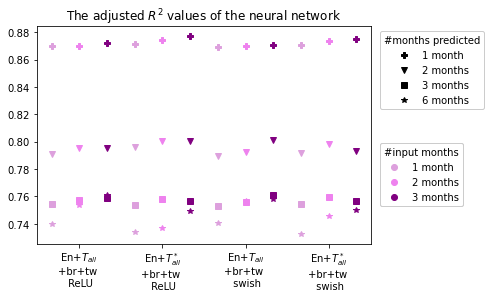

In [70]:
#colors=['greenyellow','yellowgreen','olivedrab','darkolivegreen']
#colors=['lightcoral','indianred','brown','']
colors=['plum','violet','purple','indigo']
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,3,4)+0.33
plt.plot(offset_2inputs,npR2[4]-R2np1D[0]+pred1month,marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[5]-R2np1D[1]+pred2month,marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[6]-R2np1D[2]+pred3month,marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[7]-R2np1D[3]+pred6month,marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,3,4)+0.66
plt.plot(offset_3inputs,npR2[8]-R2np1D[4]+pred1month,marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[9]-R2np1D[5]+pred2month,marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[10]-R2np1D[6]+pred3month,marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[11]-R2np1D[7]+pred6month,marker='*',linestyle = 'None',color=colors[2])


plt.title('The adjusted $R^2$ values of the neural network')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']
labels2 = ['1 month','2 months','3 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels2, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.33, 1.33, 2.33,3.33],['En+$T_{all}$ \n+br+tw \n ReLU' ,'En+$T_{all}^*$ \n+br+tw \n ReLU',
                        'En+$T_{all}$ \n+br+tw \n swish' ,'En+$T_{all}^*$ \n+br+tw \n swish'])
plt.show()

In [76]:
print(npR2.shape)
nppred1236month=np.array([R2_arr[0], R2_arr[1], R2_arr[2],R2_arr[3],
                        R2_arr[0], R2_arr[1], R2_arr[2],R2_arr[3]])
#print(R2np1D)
#print(npR2)
#print('adjusted values')
#print(npR2[4:12]-R2np1D+nppred1236month)

adR2=npR2[4:12]-R2np1D+nppred1236month
i=0
for data in data_arr:
    print('nim=%i nom=%i' %(data[0],data[1]))
    if data[0] == 1:
        print(npR2[i])
    else :
        print(adR2[i-4])
    i+=1

(12, 4)
nim=1 nom=1
[0.86966964 0.87127011 0.86965276 0.87085587]
nim=1 nom=2
[0.79075473 0.79587728 0.78971208 0.79196086]
nim=1 nom=3
[0.7543253  0.75373917 0.75286496 0.75442144]
nim=1 nom=6
[0.73953123 0.73382479 0.74082933 0.7326116 ]
nim=2 nom=1
[0.86971411 0.87464999 0.8697488  0.87379645]
nim=2 nom=2
[0.79567211 0.80028605 0.79254959 0.7981318 ]
nim=2 nom=3
[0.75745752 0.75835498 0.75581461 0.75941434]
nim=2 nom=6
[0.75408612 0.73697641 0.75690211 0.74574277]
nim=3 nom=1
[0.8724768  0.87715715 0.87074342 0.87483983]
nim=3 nom=2
[0.79572076 0.80053986 0.80155637 0.79307423]
nim=3 nom=3
[0.75885102 0.75696304 0.76077794 0.75659431]
nim=3 nom=6
[0.76138528 0.74948999 0.7581224  0.7497624 ]


# All features

In [79]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
info_numeric = info_sorted.select_dtypes(['number']) 
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(info_numeric)

# the model learns that the second feature is double the first
info_numeric_multimp= imp.transform(info_numeric)
info_numeric_multimputed_df = pd.DataFrame(data = info_numeric_multimp)
info_numeric_multimputed_df.columns = info_numeric.columns
info_numeric_multimputed_df.index = info_numeric.index
#info_numeric_multimputed_df
dwelling_type = pd.get_dummies(info_sorted.dwelling_type, prefix='dwelling_type')
heating_fuel  = pd.get_dummies(info_sorted.heating_fuel, prefix='heating_fuel')
hot_water_fuel  = pd.get_dummies(info_sorted.hot_water_fuel, prefix='hot_water_fuel')
boiler_age   = pd.get_dummies(info_sorted.boiler_age , prefix='boiler_age')
loft_insulation = pd.get_dummies(info_sorted.loft_insulation  , prefix='loft_insulation')
wall_insulation= pd.get_dummies(info_sorted.wall_insulation , prefix='wall_insulation')
heating_temperature    = pd.get_dummies(info_sorted.heating_temperature, prefix='heating_temperature')
efficient_lighting_percentage= pd.get_dummies(info_sorted.efficient_lighting_percentage,
                                              prefix='efficient_lighting_percentage')

In [77]:
def sort_big_data(nim,nom):
    #nim: number of input months
    #nom: number of output months
    
    #CHECK INPUTS
    if nim<1:
        print("number of input months (nim) should be greater or equal to 1")
        return 0
    if nom<1:
        print("number of output months (nom) should be greater or equal to 1")
        return 0
    
    #DATA STORAGE
    En_con=[]        #current/future consumption (this is what we try to predict)
    prev_con=[]      #previous consumption
    prev_daily_con=[]  #previous consumption on a daily basis
    #extra info
    temps=[]
    temps_min=[]
    temps_max=[]
    month_arr=[]
    br_arr=[]       #Bedroom info array
    br_arr_mean=[]
    dwt_arr=[]      #dwelling type array
    y = pd.get_dummies(info_sorted.dwelling_type, prefix='dwelling_type')
    #new features
    num_occupants_=[]
    dishwasher_ =[]
    freezer_ =[]
    fridge_freezer_ =[]
    refrigerator_ =[]
    tumble_dryer_ =[]
    washing_machine_ =[]
    game_console_ =[]
    laptop_ =[]
    pc_ =[]
    router_ =[]
    set_top_box_ =[]
    tablet_ =[]
    tv_ =[]
    
    #heating_fuel: 
    heating_fuel_elec=[]
    heating_fuel_gas= []
    heating_fuel_lpg_oil=[]
    heating_fuel_other= []

    #hot_water_fuel:
    hot_water_fuel_elec=[]
    hot_water_fuel_gas=[]
    hot_water_fuel_other=[] 

    #boiler_age:
    boiler_age_new= []
    boiler_age_old= [] 

    #loft_insulation:
    loft_insulation_n=[] 
    loft_insulation_y= []

    #wall_insulation:
    wall_insulation_n=[]
    wall_insulation_not_sure=[]
    wall_insulation_y_cavity= []
    wall_insulation_y_external= []
    wall_insulation_y_internal= []

    #heating_temperature:
    heating_temperature_18_to_20=[]
    heating_temperature_above_20=[]
    heating_temperature_below_18=[]
    heating_temperature_not_sure= []

    #efficient_lighting_percentage:
    efficient_lighting_percentage_0_to_25=[]
    efficient_lighting_percentage_25_to_50=[]
    efficient_lighting_percentage_50_to_75=[]
    efficient_lighting_percentage_75_to_100=[]
        
    num_occupants__ = info_numeric_multimputed_df["num_occupants"]
    dishwasher__ = info_numeric_multimputed_df["dishwasher"]
    freezer__ = info_numeric_multimputed_df["freezer"]
    fridge_freezer__ = info_numeric_multimputed_df["fridge_freezer"]
    refrigerator__ = info_numeric_multimputed_df["refrigerator"]
    tumble_dryer__ = info_numeric_multimputed_df["tumble_dryer"]
    washing_machine__ = info_numeric_multimputed_df["washing_machine"]
    game_console__ = info_numeric_multimputed_df["game_console"]
    laptop__ = info_numeric_multimputed_df["laptop"]
    pc__ = info_numeric_multimputed_df["pc"]
    router__ = info_numeric_multimputed_df["router"]
    set_top_box__= info_numeric_multimputed_df["set_top_box"]
    tablet__ = info_numeric_multimputed_df["tablet"]
    tv__ = info_numeric_multimputed_df["tv"]   
    
    #LOOP
    NaN_t=1200  #thershold
    #NaN_day_T=20 #the amount of days of data we want in a input month(28 days)
    for i in range(df.shape[0]): # loop over all users
        meter=df.iloc[i] # = row number i  
    
        #loop over all month from januari until month 14-nim-nom
        #if the month is higher then this we don't have enough data for the nim input and nom output variables
        #in the case of nim=1 nom=1 we get range(1,12) wich result in m going from 1 to 11 like we want
        for m in range (1,14-nim-nom): 
            #load current month
            bi, ei =get_monthi(m)    #bi (begin index) ei(end index)
            month=meter[bi:ei]       #data for the month m for the row user (row) i
            #load bedroom info
            row = brinfo[i:i+1]               #bedroom info with NaN values
            row_mean = brinfo_filled[i:i+1]  #bedroom info with mean values
            #Load dwelling type
            dew_type_row = y[i:i+1]
            
            num_occupants_row =num_occupants__[i:i+1]
            dishwasher_row = dishwasher__[i:i+1]
            freezer_row = freezer__[i:i+1]
            fridge_freezer_row = fridge_freezer__[i:i+1]
            refrigerator_row = refrigerator__[i:i+1]
            tumble_dryer_row = tumble_dryer__[i:i+1]
            washing_machine_row = washing_machine__[i:i+1]
            game_console_row = game_console__[i:i+1]
            laptop_row =  laptop__[i:i+1]
            pc_row = pc__[i:i+1]
            router_row = router__[i:i+1]
            set_top_box_row = set_top_box__[i:i+1]
            tablet_row = tablet__[i:i+1]
            tv_row = tv__[i:i+1] 
            
            heating_fuel_row = heating_fuel[i:i+1]
            hot_water_fuel_row = hot_water_fuel[i:i+1]
            boiler_age_row = boiler_age[i:i+1]
            loft_insulation_row = loft_insulation[i:i+1]
            wall_insulation_row = wall_insulation[i:i+1]
            heating_temperature_row = heating_temperature[i:i+1]
            efficient_lighting_percentage_row = efficient_lighting_percentage[i:i+1]
            
            # Count the amount of NaN's in all months that will be used
            n_NaN=0
            for k in range(nim+nom):
                bi, ei =get_monthi(m+k)        #bi (begin index) ei(end index)
                tempmonth=meter[bi:ei]       #data for the month m for the row user (row) i
                n_NaN+=tempmonth.isnull().sum() 
            
            if n_NaN<NaN_t:
                #save input for month j,j+1,..,j+nim-1
                input_months=np.zeros(nim)
                input_days=np.zeros([nim,28])
                input_temps=np.zeros(nim)
                input_temps_min=np.zeros(nim)
                input_temps_max=np.zeros(nim)
                output_months=np.zeros(nom)
                output_temps=np.zeros(nom)
                output_temps_min=np.zeros(nom)
                output_temps_max=np.zeros(nom)
                for k in range(nim):
                    #load month for input j+k (k goes from 0 to nim-1)
                    bik,eik=get_monthi(m+k)
                    input_months[k]=meter[bik:eik].mean()
                    daily_con=np.zeros(28)
                    current_month=meter[bik:eik]
                    #print(current_month)
                    #save daily data
                    for d in range(28):
                        daily_con[d]=current_month[d*48:(d+1)*48].mean()
                        input_days[k,:]=daily_con
                    #replace all NaN with the mean value
                    input_days[k,np.isnan(input_days[k,:])]=input_months[k] 
                    #temperatures
                    input_temps[k]=get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+k)
                    input_temps_min[k]=get_mean_temp(weather_min_sorted.iloc[i:i+1],m+k)
                    input_temps_max[k]=get_mean_temp(weather_max_sorted.iloc[i:i+1],m+k)
                for k in range(nom):
                    #load month for input j+nim+k
                    bik,eik=get_monthi(m+nim+k)
                    output_months[k]=meter[bik:eik].mean()
                    #temps
                    output_temps[k]=get_mean_temp(weather_avg_sorted.iloc[i:i+1],m+nim+k)
                    output_temps_min[k]=get_mean_temp(weather_min_sorted.iloc[i:i+1],m+nim+k)
                    output_temps_max[k]=get_mean_temp(weather_max_sorted.iloc[i:i+1],m+nim+k)
                #debug if statement checks for NaN in input month
#                 if np.isnan(np.sum(input_months)):
#                     print("input month has nan value for months=%i index=%i" %(m,i))
#                     print(input_months)
#                     return 1
#                 if np.isnan(np.sum(np.sum(input_days))):
#                     print("input days has nan value for months=%i index=%i" %(m,i))
#                     print(input_days)
#                     return 1
#                 if np.isnan(np.sum(output_months)):
#                     print("Output months has nan value for months=%i index=%i" %(m,i))
#                     print(output_months)
#                     return 1
                #store Energy consumption data
                prev_con.append(input_months)
                prev_daily_con.append(input_days)
                En_con.append(output_months)
                #save extra information 
                temps.append(np.concatenate((input_temps,output_temps)))
                temps_min.append(np.concatenate((input_temps_min,output_temps_min)))
                temps_max.append(np.concatenate((input_temps_max,output_temps_max)))
                month_arr.append(m+nim)
                #bedroom info
                n_br=row[0]
                br=np.zeros(5)
                if ~np.isnan(n_br):
                    #print(n_br)
                    br[np.int(n_br-1)]=1
                br_arr.append(br)
                br_arr_mean.append(row_mean[0])
                #dwelling type
                dwt_arr.append(dew_type_row.to_numpy().ravel())
                #new features
                num_occupants_.append(num_occupants_row[0])
                dishwasher_.append(dishwasher_row[0])
                freezer_.append(freezer_row[0])
                fridge_freezer_.append(fridge_freezer_row[0])
                refrigerator_.append(refrigerator_row[0])
                tumble_dryer_.append(tumble_dryer_row[0])
                washing_machine_.append(washing_machine_row[0])
                game_console_.append(game_console_row[0])
                laptop_.append(laptop_row[0])
                pc_.append(pc_row[0])
                router_.append(router_row[0])
                set_top_box_.append(set_top_box_row[0])
                tablet_.append(tablet_row[0])
                tv_.append(tv_row[0])
                #one-hot-encoded-values:                
                heating_fuel_elec.append(heating_fuel_row.iloc[0,0])
                heating_fuel_gas.append(heating_fuel_row.iloc[0,1])
                heating_fuel_lpg_oil.append(heating_fuel_row.iloc[0,2])
                heating_fuel_other.append(heating_fuel_row.iloc[0,3])
                
                hot_water_fuel_elec.append(hot_water_fuel_row.iloc[0,0])
                hot_water_fuel_gas.append(hot_water_fuel_row.iloc[0,1])
                hot_water_fuel_other.append(hot_water_fuel_row.iloc[0,2])
                
                boiler_age_new.append(boiler_age_row.iloc[0,0])
                boiler_age_old.append(boiler_age_row.iloc[0, 1])
                
                loft_insulation_n.append(loft_insulation_row.iloc[0,0])
                loft_insulation_y.append(loft_insulation_row.iloc[0,1])
                
                wall_insulation_n.append(wall_insulation_row.iloc[0,0])
                wall_insulation_not_sure.append(wall_insulation_row.iloc[0,1])
                wall_insulation_y_cavity.append(wall_insulation_row.iloc[0,2])
                wall_insulation_y_external.append(wall_insulation_row.iloc[0,3])
                wall_insulation_y_internal.append(wall_insulation_row.iloc[0,4])
                
                heating_temperature_18_to_20.append(heating_temperature_row.iloc[0,0])
                heating_temperature_above_20.append(heating_temperature_row.iloc[0,1])
                heating_temperature_below_18.append(heating_temperature_row.iloc[0,2])
                heating_temperature_not_sure.append(heating_temperature_row.iloc[0,3])
                
                efficient_lighting_percentage_0_to_25.append(efficient_lighting_percentage_row.iloc[0,0])
                efficient_lighting_percentage_25_to_50.append(efficient_lighting_percentage_row.iloc[0,1])
                efficient_lighting_percentage_50_to_75.append(efficient_lighting_percentage_row.iloc[0,2])
                efficient_lighting_percentage_75_to_100.append(efficient_lighting_percentage_row.iloc[0,3])
                        
                #break out of outer month loops since the inner month loop takes care of all months
                #break
                
    # converting list to numpy arrays: 
    npEn_con=np.array(En_con)
    npprev_con=np.array(prev_con)
    npprev_daily_con=np.array(prev_daily_con)
    nptemps=np.array(temps)
    nptemps_min=np.array(temps_min)
    nptemps_max=np.array(temps_max)
    npmonth=np.array(month_arr)
    npbr=np.array(br_arr)
    npbrmean=np.array(br_arr_mean)
    npdwt=np.array(dwt_arr)
    num_occupants= np.array(num_occupants_)
    dishwasher =np.array(dishwasher_)
    freezer =np.array(freezer_)
    fridge_freezer =np.array(fridge_freezer_)
    refrigerator =np.array(refrigerator_)
    tumble_dryer =np.array(tumble_dryer_)
    washing_machine =np.array(washing_machine_)
    game_console = np.array(game_console_)
    laptop =np.array(laptop_)
    pc =np.array(pc_)
    router =np.array(router_)
    set_top_box =np.array(set_top_box_)
    tablet =np.array(tablet_)
    tv =np.array(tv_)
    heating_fuel_elec=np.array(heating_fuel_elec)
    heating_fuel_gas= np.array(heating_fuel_gas)
    heating_fuel_lpg_oil=np.array(heating_fuel_lpg_oil)
    heating_fuel_other= np.array(heating_fuel_other)
    hot_water_fuel_elec=np.array(hot_water_fuel_elec)
    hot_water_fuel_gas=np.array(hot_water_fuel_gas)
    hot_water_fuel_other=np.array(hot_water_fuel_other)
    boiler_age_new= np.array(boiler_age_new)
    boiler_age_old= np.array(boiler_age_old)
    loft_insulation_n=np.array(loft_insulation_n)
    loft_insulation_y= np.array(loft_insulation_y)
    wall_insulation_n=np.array(wall_insulation_n)
    wall_insulation_not_sure=np.array(wall_insulation_not_sure)
    wall_insulation_y_cavity= np.array(wall_insulation_y_cavity)
    wall_insulation_y_external= np.array(wall_insulation_y_external)
    wall_insulation_y_internal= np.array(wall_insulation_y_internal)
    heating_temperature_18_to_20=np.array(heating_temperature_18_to_20)
    heating_temperature_above_20=np.array(heating_temperature_above_20)
    heating_temperature_below_18=np.array(heating_temperature_below_18)
    heating_temperature_not_sure= np.array(heating_temperature_not_sure)
    efficient_lighting_percentage_0_to_25=np.array(efficient_lighting_percentage_0_to_25)
    efficient_lighting_percentage_25_to_50=np.array(efficient_lighting_percentage_25_to_50)
    efficient_lighting_percentage_50_to_75=np.array(efficient_lighting_percentage_50_to_75)
    efficient_lighting_percentage_75_to_100=np.array(efficient_lighting_percentage_75_to_100)
    
    features = np.column_stack((npbrmean,npdwt, num_occupants,dishwasher, freezer, fridge_freezer,
                                refrigerator, tumble_dryer, washing_machine,game_console,
                                laptop,pc, router, set_top_box, tablet, tv, heating_fuel_elec,
                                heating_fuel_gas, heating_fuel_lpg_oil, heating_fuel_other,
                                hot_water_fuel_elec, hot_water_fuel_gas, 
                                hot_water_fuel_other, boiler_age_new, boiler_age_old, 
                                loft_insulation_n, loft_insulation_y, wall_insulation_n,
                                wall_insulation_not_sure, wall_insulation_y_cavity
                                ,wall_insulation_y_external, wall_insulation_y_internal, 
                                heating_temperature_18_to_20, 
                                heating_temperature_above_20, 
                                heating_temperature_below_18, heating_temperature_not_sure,
                                efficient_lighting_percentage_0_to_25, 
                                efficient_lighting_percentage_25_to_50, 
                                efficient_lighting_percentage_50_to_75, 
                                efficient_lighting_percentage_75_to_100))
    
    npEn_con_st=StandardScaler().fit_transform(npEn_con) 
    npprev_con_st=StandardScaler().fit_transform(npprev_con) 
    npprev_daily_con_st=normalise_features(npprev_daily_con) 
    nptemps_st=StandardScaler().fit_transform(nptemps) 
    nptemps_min_st=StandardScaler().fit_transform(nptemps_min) 
    nptemps_max_st=StandardScaler().fit_transform(nptemps_max) 
    npmonth_st=normalise_features(npmonth) 
    features_st=StandardScaler().fit_transform(features) 
    
    return [npEn_con_st,npprev_con_st,npprev_daily_con_st,nptemps_st,nptemps_min_st,nptemps_max_st,npmonth_st,features_st]

In [80]:
nim_arr=[1, 2, 3]
nom_arr=[1, 2, 3, 6]
bigdata_arr=[]
for nim in nim_arr:
    for nom in nom_arr:
        if not(nim ==6 and nom == 6):
            data=[]
            data.append(nim)
            data.append(nom)
            data.append(sort_big_data(nim,nom))
            bigdata_arr.append(data)

In [101]:
def run_allfeatures_NN_tests(data,En,nim,nom,size_f,pr=False):
    n_splits=10
    R2mean_arr=[]
    history_arr=[]
    if pr:
        print('\n#####################################')
        print('0) Include all input temprature info + (one hot enconding br)+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[6],data[7])))
    
    
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(40, input_dim=(4*nim+size_f), activation='relu'),
                tf.keras.layers.Dense(nom)])
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)

    
    if pr:
        print('\n#####################################')
        print('1) Include all temprature info + (one hot enconding br)+dwellling type')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],
                               data[5],data[6],data[7])))
    
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(40, input_dim=(nim+3*(nim+nom)+size_f), activation='relu'),
                tf.keras.layers.Dense(nom)])
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))
        
    if pr:
        print('\n#####################################')
        print('2) Include all input temprature info + (one hot enconding br)+dwellling type+swish')
        print('#####################################')
    features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[6],data[7])))
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
#         model = tf.keras.models.Sequential([
#                 tf.keras.layers.Dense(40, input_dim=(4*nim+11), activation='swish_act'),
#                 tf.keras.layers.Dense(nom)])
        model = Sequential()
        model.add(Dense(40, input_dim=(4*nim+size_f), activation='swish'))
        model.add(Dense(nom))
        
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)

    
    if pr:
        print('\n#####################################')
        print('3) Include all temprature info + (one hot enconding br)+dwellling type swish')
        print('#####################################')
    features=np.column_stack(((data[1],data[3],data[4],
                               data[5],data[6],data[7])))
    
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        model = Sequential()
        model.add(Dense(40, input_dim=(nim+3*(nim+nom)+size_f), activation='swish'))
        model.add(Dense(nom))
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)
    return R2mean_arr,history_arr

In [88]:
bigdata11=bigdata_arr[11][2]
print(bigdata_arr[11][0])
print(bigdata_arr[11][1])

3
6


In [102]:
R211,history11=run_allfeatures_NN_tests(bigdata11,data11[0],3,6,45,True)


#####################################
0) Include all input temprature info + (one hot enconding br)+dwellling type
#####################################
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 1s 396us/sample - loss: 1.2438 - mean_squared_error: 1.2438 - val_loss: 0.9855 - val_mean_squared_error: 0.9855
Epoch 2/20
1524/1524 [==============================] - 0s 65us/sample - loss: 0.7174 - mean_squared_error: 0.7174 - val_loss: 0.6548 - val_mean_squared_error: 0.6548
Epoch 3/20
1524/1524 [==============================] - 0s 50us/sample - loss: 0.5004 - mean_squared_error: 0.5004 - val_loss: 0.4906 - val_mean_squared_error: 0.4906
Epoch 4/20
1524/1524 [==============================] - 0s 61us/sample - loss: 0.3925 - mean_squared_error: 0.3925 - val_loss: 0.4069 - val_mean_squared_error: 0.4069
Epoch 5/20
1524/1524 [==============================] - 0s 56us/sample - loss: 0.3465 - mean_squared_error: 0.3465 - val_loss: 0.3

Epoch 8/20
1524/1524 [==============================] - 0s 60us/sample - loss: 0.2879 - mean_squared_error: 0.2879 - val_loss: 0.2342 - val_mean_squared_error: 0.2342
Epoch 9/20
1524/1524 [==============================] - 0s 52us/sample - loss: 0.2794 - mean_squared_error: 0.2794 - val_loss: 0.2260 - val_mean_squared_error: 0.2260
Epoch 10/20
1524/1524 [==============================] - 0s 54us/sample - loss: 0.2724 - mean_squared_error: 0.2724 - val_loss: 0.2225 - val_mean_squared_error: 0.2225
Epoch 11/20
1524/1524 [==============================] - 0s 54us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2195 - val_mean_squared_error: 0.2195
Epoch 12/20
1524/1524 [==============================] - 0s 56us/sample - loss: 0.2595 - mean_squared_error: 0.2595 - val_loss: 0.2195 - val_mean_squared_error: 0.2195
Epoch 13/20
1524/1524 [==============================] - 0s 50us/sample - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.2223 - val_mean_squared_error: 0

1525/1525 [==============================] - 0s 53us/sample - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.3208 - val_mean_squared_error: 0.3208
Epoch 17/20
1525/1525 [==============================] - 0s 54us/sample - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.3121 - val_mean_squared_error: 0.3121
Epoch 18/20
1525/1525 [==============================] - 0s 49us/sample - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.3137 - val_mean_squared_error: 0.3137
Epoch 19/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2423 - mean_squared_error: 0.2423 - val_loss: 0.3108 - val_mean_squared_error: 0.3108
Epoch 20/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2389 - mean_squared_error: 0.2389 - val_loss: 0.3136 - val_mean_squared_error: 0.3136
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 319us/sample - loss: 1.2678 - mean_squared_error: 1.2678 - val_los

Epoch 4/20
1525/1525 [==============================] - 0s 51us/sample - loss: 0.3495 - mean_squared_error: 0.3495 - val_loss: 0.4279 - val_mean_squared_error: 0.4279
Epoch 5/20
1525/1525 [==============================] - 0s 48us/sample - loss: 0.3121 - mean_squared_error: 0.3121 - val_loss: 0.4068 - val_mean_squared_error: 0.4068
Epoch 6/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2931 - mean_squared_error: 0.2931 - val_loss: 0.3883 - val_mean_squared_error: 0.3883
Epoch 7/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2804 - mean_squared_error: 0.2804 - val_loss: 0.3810 - val_mean_squared_error: 0.3810
Epoch 8/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2707 - mean_squared_error: 0.2707 - val_loss: 0.3751 - val_mean_squared_error: 0.3751
Epoch 9/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2616 - mean_squared_error: 0.2616 - val_loss: 0.3690 - val_mean_squared_error: 0.369

Epoch 12/20
1525/1525 [==============================] - 0s 56us/sample - loss: 0.2567 - mean_squared_error: 0.2567 - val_loss: 0.4304 - val_mean_squared_error: 0.4304
Epoch 13/20
1525/1525 [==============================] - 0s 51us/sample - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.4250 - val_mean_squared_error: 0.4250
Epoch 14/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.4267 - val_mean_squared_error: 0.4267
Epoch 15/20
1525/1525 [==============================] - 0s 49us/sample - loss: 0.2467 - mean_squared_error: 0.2467 - val_loss: 0.4187 - val_mean_squared_error: 0.4187
Epoch 16/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2420 - mean_squared_error: 0.2420 - val_loss: 0.4216 - val_mean_squared_error: 0.4216
Epoch 17/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2380 - mean_squared_error: 0.2380 - val_loss: 0.4255 - val_mean_squared_error:

1524/1524 [==============================] - 0s 52us/sample - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.1989 - val_mean_squared_error: 0.1989
Epoch 20/20
1524/1524 [==============================] - 0s 52us/sample - loss: 0.2373 - mean_squared_error: 0.2373 - val_loss: 0.2043 - val_mean_squared_error: 0.2043
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 318us/sample - loss: 1.3115 - mean_squared_error: 1.3115 - val_loss: 1.0785 - val_mean_squared_error: 1.0785
Epoch 2/20
1524/1524 [==============================] - 0s 52us/sample - loss: 0.7100 - mean_squared_error: 0.7100 - val_loss: 0.7266 - val_mean_squared_error: 0.7266
Epoch 3/20
1524/1524 [==============================] - 0s 49us/sample - loss: 0.4995 - mean_squared_error: 0.4995 - val_loss: 0.5289 - val_mean_squared_error: 0.5289
Epoch 4/20
1524/1524 [==============================] - 0s 50us/sample - loss: 0.3940 - mean_squared_error: 0.3940 - val_loss: 

1525/1525 [==============================] - 0s 52us/sample - loss: 0.3006 - mean_squared_error: 0.3006 - val_loss: 0.3561 - val_mean_squared_error: 0.3561
Epoch 8/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2895 - mean_squared_error: 0.2895 - val_loss: 0.3513 - val_mean_squared_error: 0.3513
Epoch 9/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2784 - mean_squared_error: 0.2784 - val_loss: 0.3415 - val_mean_squared_error: 0.3415
Epoch 10/20
1525/1525 [==============================] - 0s 54us/sample - loss: 0.2666 - mean_squared_error: 0.2666 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 11/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2603 - mean_squared_error: 0.2603 - val_loss: 0.3404 - val_mean_squared_error: 0.3404
Epoch 12/20
1525/1525 [==============================] - 0s 51us/sample - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.3283 - val_mean_squared_error: 0.3283
Epoch 

1525/1525 [==============================] - 0s 50us/sample - loss: 0.2471 - mean_squared_error: 0.2471 - val_loss: 0.2814 - val_mean_squared_error: 0.2814
Epoch 16/20
1525/1525 [==============================] - 0s 55us/sample - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.2795 - val_mean_squared_error: 0.2795
Epoch 17/20
1525/1525 [==============================] - 0s 51us/sample - loss: 0.2404 - mean_squared_error: 0.2404 - val_loss: 0.2789 - val_mean_squared_error: 0.2789
Epoch 18/20
1525/1525 [==============================] - 0s 54us/sample - loss: 0.2387 - mean_squared_error: 0.2387 - val_loss: 0.2774 - val_mean_squared_error: 0.2774
Epoch 19/20
1525/1525 [==============================] - 0s 50us/sample - loss: 0.2344 - mean_squared_error: 0.2344 - val_loss: 0.2735 - val_mean_squared_error: 0.2735
Epoch 20/20
1525/1525 [==============================] - 0s 52us/sample - loss: 0.2327 - mean_squared_error: 0.2327 - val_loss: 0.2696 - val_mean_squared_error: 0.2696
Trai

Epoch 3/20
1525/1525 [==============================] - 0s 62us/sample - loss: 0.4974 - mean_squared_error: 0.4974 - val_loss: 0.6791 - val_mean_squared_error: 0.6791
Epoch 4/20
1525/1525 [==============================] - 0s 56us/sample - loss: 0.3809 - mean_squared_error: 0.3809 - val_loss: 0.5472 - val_mean_squared_error: 0.5472
Epoch 5/20
1525/1525 [==============================] - 0s 62us/sample - loss: 0.3281 - mean_squared_error: 0.3281 - val_loss: 0.5038 - val_mean_squared_error: 0.5038
Epoch 6/20
1525/1525 [==============================] - 0s 64us/sample - loss: 0.3038 - mean_squared_error: 0.3038 - val_loss: 0.4635 - val_mean_squared_error: 0.4635
Epoch 7/20
1525/1525 [==============================] - 0s 68us/sample - loss: 0.2865 - mean_squared_error: 0.2865 - val_loss: 0.4530 - val_mean_squared_error: 0.4530
Epoch 8/20
1525/1525 [==============================] - 0s 56us/sample - loss: 0.2748 - mean_squared_error: 0.2748 - val_loss: 0.4371 - val_mean_squared_error: 0.437

1524/1524 [==============================] - 0s 35us/step - loss: 0.2629 - mean_squared_error: 0.4426 - val_loss: 0.2332 - val_mean_squared_error: 0.4324
Epoch 11/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2577 - mean_squared_error: 0.4257 - val_loss: 0.2352 - val_mean_squared_error: 0.4163
Epoch 12/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2548 - mean_squared_error: 0.4090 - val_loss: 0.2297 - val_mean_squared_error: 0.4026
Epoch 13/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2503 - mean_squared_error: 0.3969 - val_loss: 0.2274 - val_mean_squared_error: 0.3907
Epoch 14/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2461 - mean_squared_error: 0.3847 - val_loss: 0.2254 - val_mean_squared_error: 0.3802
Epoch 15/20
1524/1524 [==============================] - 0s 37us/step - loss: 0.2442 - mean_squared_error: 0.3748 - val_loss: 0.2249 - val_mean_squared_error: 0.3710
Epoch 16/20
1524

Epoch 19/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2385 - mean_squared_error: 0.3300 - val_loss: 0.2289 - val_mean_squared_error: 0.3279
Epoch 20/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2366 - mean_squared_error: 0.3255 - val_loss: 0.2235 - val_mean_squared_error: 0.3233
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 117us/step - loss: 1.2897 - mean_squared_error: 1.5790 - val_loss: 0.8633 - val_mean_squared_error: 1.2672
Epoch 2/20
1525/1525 [==============================] - 0s 36us/step - loss: 0.8077 - mean_squared_error: 1.1385 - val_loss: 0.6436 - val_mean_squared_error: 1.0283
Epoch 3/20
1525/1525 [==============================] - 0s 54us/step - loss: 0.5662 - mean_squared_error: 0.9399 - val_loss: 0.4808 - val_mean_squared_error: 0.8710
Epoch 4/20
1525/1525 [==============================] - 0s 44us/step - loss: 0.4221 - mean_squared_error: 0.8068 - val_loss: 

1525/1525 [==============================] - 0s 42us/step - loss: 0.2828 - mean_squared_error: 0.5264 - val_loss: 0.5680 - val_mean_squared_error: 0.5112
Epoch 8/20
1525/1525 [==============================] - 0s 46us/step - loss: 0.2720 - mean_squared_error: 0.4969 - val_loss: 0.5503 - val_mean_squared_error: 0.4847
Epoch 9/20
1525/1525 [==============================] - 0s 39us/step - loss: 0.2631 - mean_squared_error: 0.4739 - val_loss: 0.5315 - val_mean_squared_error: 0.4630
Epoch 10/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2559 - mean_squared_error: 0.4543 - val_loss: 0.5173 - val_mean_squared_error: 0.4449
Epoch 11/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2509 - mean_squared_error: 0.4375 - val_loss: 0.5144 - val_mean_squared_error: 0.4296
Epoch 12/20
1525/1525 [==============================] - 0s 41us/step - loss: 0.2447 - mean_squared_error: 0.4220 - val_loss: 0.5058 - val_mean_squared_error: 0.4164
Epoch 13/20
1525/1

Epoch 16/20
1525/1525 [==============================] - 0s 34us/step - loss: 0.2432 - mean_squared_error: 0.3946 - val_loss: 0.3112 - val_mean_squared_error: 0.3905
Epoch 17/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2407 - mean_squared_error: 0.3858 - val_loss: 0.3108 - val_mean_squared_error: 0.3821
Epoch 18/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.2400 - mean_squared_error: 0.3779 - val_loss: 0.3056 - val_mean_squared_error: 0.3745
Epoch 19/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2350 - mean_squared_error: 0.3704 - val_loss: 0.3016 - val_mean_squared_error: 0.3676
Epoch 20/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2324 - mean_squared_error: 0.3640 - val_loss: 0.3003 - val_mean_squared_error: 0.3611
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 139us/step - loss: 1.0641 - mean_squared_error: 1.3815 - val_los

1524/1524 [==============================] - 0s 33us/step - loss: 0.4709 - mean_squared_error: 0.8605 - val_loss: 0.5591 - val_mean_squared_error: 0.7866
Epoch 4/20
1524/1524 [==============================] - 0s 41us/step - loss: 0.3698 - mean_squared_error: 0.7360 - val_loss: 0.4909 - val_mean_squared_error: 0.6851
Epoch 5/20
1524/1524 [==============================] - 0s 37us/step - loss: 0.3203 - mean_squared_error: 0.6478 - val_loss: 0.4621 - val_mean_squared_error: 0.6147
Epoch 6/20
1524/1524 [==============================] - 0s 37us/step - loss: 0.2953 - mean_squared_error: 0.5878 - val_loss: 0.4465 - val_mean_squared_error: 0.5638
Epoch 7/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2797 - mean_squared_error: 0.5454 - val_loss: 0.4333 - val_mean_squared_error: 0.5253
Epoch 8/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2689 - mean_squared_error: 0.5086 - val_loss: 0.4288 - val_mean_squared_error: 0.4951
Epoch 9/20
1524/1524 

Epoch 12/20
1524/1524 [==============================] - 0s 38us/step - loss: 0.2581 - mean_squared_error: 0.4316 - val_loss: 0.2113 - val_mean_squared_error: 0.4239
Epoch 13/20
1524/1524 [==============================] - 0s 38us/step - loss: 0.2526 - mean_squared_error: 0.4172 - val_loss: 0.2040 - val_mean_squared_error: 0.4103
Epoch 14/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2499 - mean_squared_error: 0.4038 - val_loss: 0.2000 - val_mean_squared_error: 0.3985
Epoch 15/20
1524/1524 [==============================] - 0s 35us/step - loss: 0.2494 - mean_squared_error: 0.3929 - val_loss: 0.2032 - val_mean_squared_error: 0.3882
Epoch 16/20
1524/1524 [==============================] - 0s 34us/step - loss: 0.2441 - mean_squared_error: 0.3834 - val_loss: 0.2008 - val_mean_squared_error: 0.3789
Epoch 17/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2440 - mean_squared_error: 0.3749 - val_loss: 0.1997 - val_mean_squared_error: 0.3707
Epoc

Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 117us/step - loss: 1.0911 - mean_squared_error: 1.3631 - val_loss: 0.8848 - val_mean_squared_error: 1.0770
Epoch 2/20
1525/1525 [==============================] - 0s 39us/step - loss: 0.6183 - mean_squared_error: 0.9578 - val_loss: 0.5734 - val_mean_squared_error: 0.8465
Epoch 3/20
1525/1525 [==============================] - 0s 35us/step - loss: 0.4562 - mean_squared_error: 0.7736 - val_loss: 0.4386 - val_mean_squared_error: 0.7159
Epoch 4/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.3845 - mean_squared_error: 0.6766 - val_loss: 0.3775 - val_mean_squared_error: 0.6326
Epoch 5/20
1525/1525 [==============================] - 0s 37us/step - loss: 0.3463 - mean_squared_error: 0.6050 - val_loss: 0.3242 - val_mean_squared_error: 0.5749
Epoch 6/20
1525/1525 [==============================] - 0s 43us/step - loss: 0.3221 - mean_squared_error: 0.5527 - val_loss: 0.

1525/1525 [==============================] - 0s 39us/step - loss: 0.2675 - mean_squared_error: 0.4760 - val_loss: 0.2524 - val_mean_squared_error: 0.4642
Epoch 10/20
1525/1525 [==============================] - 0s 42us/step - loss: 0.2612 - mean_squared_error: 0.4527 - val_loss: 0.2492 - val_mean_squared_error: 0.4437
Epoch 11/20
1525/1525 [==============================] - 0s 36us/step - loss: 0.2556 - mean_squared_error: 0.4352 - val_loss: 0.2483 - val_mean_squared_error: 0.4265
Epoch 12/20
1525/1525 [==============================] - 0s 37us/step - loss: 0.2530 - mean_squared_error: 0.4190 - val_loss: 0.2453 - val_mean_squared_error: 0.4119
Epoch 13/20
1525/1525 [==============================] - 0s 37us/step - loss: 0.2496 - mean_squared_error: 0.4064 - val_loss: 0.2444 - val_mean_squared_error: 0.3994
Epoch 14/20
1525/1525 [==============================] - 0s 37us/step - loss: 0.2444 - mean_squared_error: 0.3941 - val_loss: 0.2414 - val_mean_squared_error: 0.3883
Epoch 15/20
1525

In [103]:
print(R211)

[0.6799683689857374, 0.714935038107527, 0.7049005825993724, 0.7015321640776022]


In [104]:
#run tests
size_f=45
R2_allfeatures_arr=[]
for data in bigdata_arr:
    print('nim=:%i nom=%i' %(data[0],data[1]))
    R2,_=run_allfeatures_NN_tests(data[2],data[2][0],data[0],data[1],size_f,pr=False)
    R2_allfeatures_arr.append(R2)

nim=:1 nom=1
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 81us/sample - loss: 0.5568 - mean_squared_error: 0.5568 - val_loss: 0.1854 - val_mean_squared_error: 0.1854
Epoch 2/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1590 - mean_squared_error: 0.1590 - val_loss: 0.1577 - val_mean_squared_error: 0.1577
Epoch 3/20
15979/15979 [==============================] - 1s 54us/sample - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.1474 - val_mean_squared_error: 0.1474
Epoch 4/20
15979/15979 [==============================] - 1s 49us/sample - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.1550 - val_mean_squared_error: 0.1550
Epoch 5/20
15979/15979 [==============================] - 1s 47us/sample - loss: 0.1560 - mean_squared_error: 0.1560 - val_loss: 0.1522 - val_mean_squared_error: 0.1522
Epoch 6/20
15979/15979 [==============================] - 1s 47us/sample - loss: 0.1444 - mea

15979/15979 [==============================] - 1s 42us/sample - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1747 - val_mean_squared_error: 0.1747
Epoch 9/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1660 - val_mean_squared_error: 0.1660
Epoch 10/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1367 - mean_squared_error: 0.1367 - val_loss: 0.1611 - val_mean_squared_error: 0.1611
Epoch 11/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1353 - mean_squared_error: 0.1353 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 12/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1342 - mean_squared_error: 0.1342 - val_loss: 0.1738 - val_mean_squared_error: 0.1738
Epoch 13/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1337 - mean_squared_error: 0.1337 - val_loss: 0.1707 - val_mean_squared_error: 

Epoch 16/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1228 - val_mean_squared_error: 0.1228
Epoch 17/20
15979/15979 [==============================] - 1s 43us/sample - loss: 0.1377 - mean_squared_error: 0.1377 - val_loss: 0.1166 - val_mean_squared_error: 0.1166
Epoch 18/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1354 - mean_squared_error: 0.1354 - val_loss: 0.1122 - val_mean_squared_error: 0.1122
Epoch 19/20
15979/15979 [==============================] - 1s 45us/sample - loss: 0.1413 - mean_squared_error: 0.1413 - val_loss: 0.1230 - val_mean_squared_error: 0.1230
Epoch 20/20
15979/15979 [==============================] - 1s 44us/sample - loss: 0.1396 - mean_squared_error: 0.1396 - val_loss: 0.1120 - val_mean_squared_error: 0.1120
Train on 15980 samples, validate on 1775 samples
Epoch 1/20
15980/15980 [==============================] - 1s 65us/sample - loss: 0.4233 - mean_square

15980/15980 [==============================] - 1s 42us/sample - loss: 0.1463 - mean_squared_error: 0.1463 - val_loss: 0.1503 - val_mean_squared_error: 0.1503
Epoch 4/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1526 - mean_squared_error: 0.1526 - val_loss: 0.1409 - val_mean_squared_error: 0.1409
Epoch 5/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1584 - mean_squared_error: 0.1584 - val_loss: 0.1391 - val_mean_squared_error: 0.1391
Epoch 6/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1415 - mean_squared_error: 0.1415 - val_loss: 0.1351 - val_mean_squared_error: 0.1351
Epoch 7/20
15980/15980 [==============================] - 1s 43us/sample - loss: 0.1443 - mean_squared_error: 0.1443 - val_loss: 0.1439 - val_mean_squared_error: 0.1439
Epoch 8/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1431 - mean_squared_error: 0.1431 - val_loss: 0.1332 - val_mean_squared_error: 0.13

Epoch 11/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1413 - mean_squared_error: 0.1413 - val_loss: 0.1483 - val_mean_squared_error: 0.1483
Epoch 12/20
15980/15980 [==============================] - 1s 43us/sample - loss: 0.1415 - mean_squared_error: 0.1415 - val_loss: 0.1382 - val_mean_squared_error: 0.1382
Epoch 13/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1408 - mean_squared_error: 0.1408 - val_loss: 0.1520 - val_mean_squared_error: 0.1520
Epoch 14/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1453 - mean_squared_error: 0.1453 - val_loss: 0.1375 - val_mean_squared_error: 0.1375
Epoch 15/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1426 - mean_squared_error: 0.1426 - val_loss: 0.1445 - val_mean_squared_error: 0.1445
Epoch 16/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1404 - mean_squared_error: 0.1404 - val_loss: 0.1391 - val_mean_sq

Epoch 19/20
15979/15979 [==============================] - 1s 43us/sample - loss: 0.1313 - mean_squared_error: 0.1313 - val_loss: 0.1438 - val_mean_squared_error: 0.1438
Epoch 20/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1311 - mean_squared_error: 0.1311 - val_loss: 0.1564 - val_mean_squared_error: 0.1564
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 67us/sample - loss: 0.5699 - mean_squared_error: 0.5699 - val_loss: 0.1480 - val_mean_squared_error: 0.1480
Epoch 2/20
15979/15979 [==============================] - 1s 47us/sample - loss: 0.1552 - mean_squared_error: 0.1552 - val_loss: 0.1285 - val_mean_squared_error: 0.1285
Epoch 3/20
15979/15979 [==============================] - 1s 54us/sample - loss: 0.1488 - mean_squared_error: 0.1488 - val_loss: 0.1414 - val_mean_squared_error: 0.1414
Epoch 4/20
15979/15979 [==============================] - 1s 59us/sample - loss: 0.1406 - mean_squared_e

15979/15979 [==============================] - 1s 42us/sample - loss: 0.1440 - mean_squared_error: 0.1440 - val_loss: 0.1295 - val_mean_squared_error: 0.1295
Epoch 7/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.1432 - val_mean_squared_error: 0.1432
Epoch 8/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1456 - mean_squared_error: 0.1456 - val_loss: 0.1352 - val_mean_squared_error: 0.1352
Epoch 9/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1367 - mean_squared_error: 0.1367 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 10/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1402 - mean_squared_error: 0.1402 - val_loss: 0.1317 - val_mean_squared_error: 0.1317
Epoch 11/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1424 - mean_squared_error: 0.1424 - val_loss: 0.1316 - val_mean_squared_error: 0.

Epoch 14/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1327 - mean_squared_error: 0.1327 - val_loss: 0.1746 - val_mean_squared_error: 0.1746
Epoch 15/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1302 - mean_squared_error: 0.1302 - val_loss: 0.1662 - val_mean_squared_error: 0.1662
Epoch 16/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1322 - mean_squared_error: 0.1322 - val_loss: 0.1943 - val_mean_squared_error: 0.1943
Epoch 17/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1731 - val_mean_squared_error: 0.1731
Epoch 18/20
15980/15980 [==============================] - 1s 42us/sample - loss: 0.1304 - mean_squared_error: 0.1304 - val_loss: 0.1719 - val_mean_squared_error: 0.1719
Epoch 19/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.1751 - val_mean_sq

15980/15980 [==============================] - 1s 65us/sample - loss: 0.3783 - mean_squared_error: 0.3783 - val_loss: 0.1581 - val_mean_squared_error: 0.1581
Epoch 2/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1534 - mean_squared_error: 0.1534 - val_loss: 0.1336 - val_mean_squared_error: 0.1336
Epoch 3/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1459 - mean_squared_error: 0.1459 - val_loss: 0.1286 - val_mean_squared_error: 0.1286
Epoch 4/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1448 - mean_squared_error: 0.1448 - val_loss: 0.1385 - val_mean_squared_error: 0.1385
Epoch 5/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1426 - mean_squared_error: 0.1426 - val_loss: 0.1258 - val_mean_squared_error: 0.1258
Epoch 6/20
15980/15980 [==============================] - 1s 41us/sample - loss: 0.1456 - mean_squared_error: 0.1456 - val_loss: 0.1223 - val_mean_squared_error: 0.12

15979/15979 [==============================] - 1s 32us/step - loss: 0.1428 - mean_squared_error: 0.1673 - val_loss: 0.1318 - val_mean_squared_error: 0.1662
Epoch 10/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1430 - mean_squared_error: 0.1648 - val_loss: 0.1255 - val_mean_squared_error: 0.1637
Epoch 11/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1397 - mean_squared_error: 0.1623 - val_loss: 0.1265 - val_mean_squared_error: 0.1614
Epoch 12/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1397 - mean_squared_error: 0.1600 - val_loss: 0.1218 - val_mean_squared_error: 0.1594
Epoch 13/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1399 - mean_squared_error: 0.1584 - val_loss: 0.1212 - val_mean_squared_error: 0.1578
Epoch 14/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1366 - mean_squared_error: 0.1567 - val_loss: 0.1236 - val_mean_squared_error: 0.1561
Epoc

15979/15979 [==============================] - 1s 38us/step - loss: 0.1331 - mean_squared_error: 0.1527 - val_loss: 0.1489 - val_mean_squared_error: 0.1524
Epoch 18/20
15979/15979 [==============================] - 1s 42us/step - loss: 0.1336 - mean_squared_error: 0.1518 - val_loss: 0.1439 - val_mean_squared_error: 0.1514
Epoch 19/20
15979/15979 [==============================] - 1s 34us/step - loss: 0.1313 - mean_squared_error: 0.1510 - val_loss: 0.1516 - val_mean_squared_error: 0.1504
Epoch 20/20
15979/15979 [==============================] - 1s 38us/step - loss: 0.1331 - mean_squared_error: 0.1500 - val_loss: 0.1452 - val_mean_squared_error: 0.1496
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 41us/step - loss: 0.4755 - mean_squared_error: 0.8309 - val_loss: 0.1286 - val_mean_squared_error: 0.4580
Epoch 2/20
15979/15979 [==============================] - 1s 37us/step - loss: 0.1568 - mean_squared_error: 0.3585 - val_los

15980/15980 [==============================] - 1s 34us/step - loss: 0.1578 - mean_squared_error: 0.2297 - val_loss: 0.1413 - val_mean_squared_error: 0.2227
Epoch 6/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1398 - mean_squared_error: 0.2152 - val_loss: 0.1392 - val_mean_squared_error: 0.2087
Epoch 7/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1399 - mean_squared_error: 0.2028 - val_loss: 0.1361 - val_mean_squared_error: 0.1988
Epoch 8/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1405 - mean_squared_error: 0.1944 - val_loss: 0.1428 - val_mean_squared_error: 0.1915
Epoch 9/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1432 - mean_squared_error: 0.1886 - val_loss: 0.1485 - val_mean_squared_error: 0.1861
Epoch 10/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1427 - mean_squared_error: 0.1839 - val_loss: 0.1402 - val_mean_squared_error: 0.1818
Epoch 11

15980/15980 [==============================] - 1s 32us/step - loss: 0.1322 - mean_squared_error: 0.1623 - val_loss: 0.1547 - val_mean_squared_error: 0.1615
Epoch 14/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1365 - mean_squared_error: 0.1604 - val_loss: 0.1604 - val_mean_squared_error: 0.1598
Epoch 15/20
15980/15980 [==============================] - 1s 31us/step - loss: 0.1346 - mean_squared_error: 0.1590 - val_loss: 0.1667 - val_mean_squared_error: 0.1583
Epoch 16/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1335 - mean_squared_error: 0.1576 - val_loss: 0.1624 - val_mean_squared_error: 0.1570
Epoch 17/20
15980/15980 [==============================] - 1s 31us/step - loss: 0.1317 - mean_squared_error: 0.1563 - val_loss: 0.1569 - val_mean_squared_error: 0.1556
Epoch 18/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1324 - mean_squared_error: 0.1551 - val_loss: 0.1579 - val_mean_squared_error: 0.1545
Epoc

15979/15979 [==============================] - 1s 42us/step - loss: 0.4535 - mean_squared_error: 0.8512 - val_loss: 0.1913 - val_mean_squared_error: 0.4412
Epoch 2/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1438 - mean_squared_error: 0.3468 - val_loss: 0.1793 - val_mean_squared_error: 0.2909
Epoch 3/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1473 - mean_squared_error: 0.2637 - val_loss: 0.1622 - val_mean_squared_error: 0.2429
Epoch 4/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1378 - mean_squared_error: 0.2283 - val_loss: 0.1810 - val_mean_squared_error: 0.2173
Epoch 5/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1373 - mean_squared_error: 0.2087 - val_loss: 0.1790 - val_mean_squared_error: 0.2021
Epoch 6/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1405 - mean_squared_error: 0.1959 - val_loss: 0.1618 - val_mean_squared_error: 0.1921
Epoch 7/2

15979/15979 [==============================] - 1s 36us/step - loss: 0.1401 - mean_squared_error: 0.1851 - val_loss: 0.1487 - val_mean_squared_error: 0.1831
Epoch 10/20
15979/15979 [==============================] - 1s 41us/step - loss: 0.1364 - mean_squared_error: 0.1807 - val_loss: 0.1474 - val_mean_squared_error: 0.1786
Epoch 11/20
15979/15979 [==============================] - 1s 37us/step - loss: 0.1370 - mean_squared_error: 0.1764 - val_loss: 0.1291 - val_mean_squared_error: 0.1747
Epoch 12/20
15979/15979 [==============================] - 1s 37us/step - loss: 0.1369 - mean_squared_error: 0.1731 - val_loss: 0.1397 - val_mean_squared_error: 0.1716
Epoch 13/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1381 - mean_squared_error: 0.1702 - val_loss: 0.1317 - val_mean_squared_error: 0.1689
Epoch 14/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1350 - mean_squared_error: 0.1672 - val_loss: 0.1342 - val_mean_squared_error: 0.1665
Epoc

15980/15980 [==============================] - 1s 33us/step - loss: 0.1317 - mean_squared_error: 0.1553 - val_loss: 0.1265 - val_mean_squared_error: 0.1547
Epoch 18/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1312 - mean_squared_error: 0.1540 - val_loss: 0.1277 - val_mean_squared_error: 0.1534
Epoch 19/20
15980/15980 [==============================] - 1s 36us/step - loss: 0.1317 - mean_squared_error: 0.1528 - val_loss: 0.1287 - val_mean_squared_error: 0.1523
Epoch 20/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1315 - mean_squared_error: 0.1517 - val_loss: 0.1281 - val_mean_squared_error: 0.1512
Train on 15980 samples, validate on 1775 samples
Epoch 1/20
15980/15980 [==============================] - 1s 45us/step - loss: 0.3780 - mean_squared_error: 0.6546 - val_loss: 0.1716 - val_mean_squared_error: 0.3674
Epoch 2/20
15980/15980 [==============================] - 1s 41us/step - loss: 0.1528 - mean_squared_error: 0.2995 - val_los

15980/15980 [==============================] - 1s 33us/step - loss: 0.1385 - mean_squared_error: 0.1925 - val_loss: 0.1396 - val_mean_squared_error: 0.1873
Epoch 6/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1390 - mean_squared_error: 0.1829 - val_loss: 0.1496 - val_mean_squared_error: 0.1793
Epoch 7/20
15980/15980 [==============================] - 1s 33us/step - loss: 0.1414 - mean_squared_error: 0.1764 - val_loss: 0.1466 - val_mean_squared_error: 0.1739
Epoch 8/20
15980/15980 [==============================] - 1s 36us/step - loss: 0.1368 - mean_squared_error: 0.1717 - val_loss: 0.1359 - val_mean_squared_error: 0.1693
Epoch 9/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1379 - mean_squared_error: 0.1672 - val_loss: 0.1317 - val_mean_squared_error: 0.1658
Epoch 10/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1399 - mean_squared_error: 0.1642 - val_loss: 0.1369 - val_mean_squared_error: 0.1631
Epoch 11

13231/13231 [==============================] - 1s 43us/sample - loss: 0.2141 - mean_squared_error: 0.2141 - val_loss: 0.2689 - val_mean_squared_error: 0.2689
Epoch 14/20
13231/13231 [==============================] - 1s 44us/sample - loss: 0.2133 - mean_squared_error: 0.2133 - val_loss: 0.2728 - val_mean_squared_error: 0.2728
Epoch 15/20
13231/13231 [==============================] - 1s 45us/sample - loss: 0.2141 - mean_squared_error: 0.2141 - val_loss: 0.2698 - val_mean_squared_error: 0.2698
Epoch 16/20
13231/13231 [==============================] - 1s 44us/sample - loss: 0.2105 - mean_squared_error: 0.2105 - val_loss: 0.2783 - val_mean_squared_error: 0.2783
Epoch 17/20
13231/13231 [==============================] - 1s 43us/sample - loss: 0.2112 - mean_squared_error: 0.2112 - val_loss: 0.2770 - val_mean_squared_error: 0.2770
Epoch 18/20
13231/13231 [==============================] - 1s 49us/sample - loss: 0.2135 - mean_squared_error: 0.2135 - val_loss: 0.2708 - val_mean_squared_error:

Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 76us/sample - loss: 0.9148 - mean_squared_error: 0.9148 - val_loss: 0.3351 - val_mean_squared_error: 0.3351
Epoch 2/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2974 - mean_squared_error: 0.2974 - val_loss: 0.2248 - val_mean_squared_error: 0.2248
Epoch 3/20
13232/13232 [==============================] - 1s 40us/sample - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2058 - val_mean_squared_error: 0.2058
Epoch 4/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2374 - mean_squared_error: 0.2374 - val_loss: 0.2004 - val_mean_squared_error: 0.2004
Epoch 5/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2351 - mean_squared_error: 0.2351 - val_loss: 0.1977 - val_mean_squared_error: 0.1977
Epoch 6/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2355 - mean_squared_err

13232/13232 [==============================] - 1s 44us/sample - loss: 0.2211 - mean_squared_error: 0.2211 - val_loss: 0.2416 - val_mean_squared_error: 0.2416
Epoch 9/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2229 - mean_squared_error: 0.2229 - val_loss: 0.2563 - val_mean_squared_error: 0.2563
Epoch 10/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2229 - mean_squared_error: 0.2229 - val_loss: 0.2489 - val_mean_squared_error: 0.2489
Epoch 11/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2201 - mean_squared_error: 0.2201 - val_loss: 0.2522 - val_mean_squared_error: 0.2522
Epoch 12/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2198 - mean_squared_error: 0.2198 - val_loss: 0.2479 - val_mean_squared_error: 0.2479
Epoch 13/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2194 - mean_squared_error: 0.2194 - val_loss: 0.2397 - val_mean_squared_error: 

Epoch 16/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.2398 - val_mean_squared_error: 0.2398
Epoch 17/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2154 - mean_squared_error: 0.2154 - val_loss: 0.2380 - val_mean_squared_error: 0.2380
Epoch 18/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2143 - mean_squared_error: 0.2143 - val_loss: 0.2374 - val_mean_squared_error: 0.2374
Epoch 19/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2147 - mean_squared_error: 0.2147 - val_loss: 0.2383 - val_mean_squared_error: 0.2383
Epoch 20/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2118 - mean_squared_error: 0.2118 - val_loss: 0.2430 - val_mean_squared_error: 0.2430
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 73us/sample - loss: 0.5732 - mean_square

13231/13231 [==============================] - 1s 43us/sample - loss: 0.2322 - mean_squared_error: 0.2322 - val_loss: 0.2579 - val_mean_squared_error: 0.2579
Epoch 4/20
13231/13231 [==============================] - 1s 42us/sample - loss: 0.2276 - mean_squared_error: 0.2276 - val_loss: 0.2432 - val_mean_squared_error: 0.2432
Epoch 5/20
13231/13231 [==============================] - 1s 41us/sample - loss: 0.2207 - mean_squared_error: 0.2207 - val_loss: 0.2458 - val_mean_squared_error: 0.2458
Epoch 6/20
13231/13231 [==============================] - 1s 42us/sample - loss: 0.2206 - mean_squared_error: 0.2206 - val_loss: 0.2454 - val_mean_squared_error: 0.2454
Epoch 7/20
13231/13231 [==============================] - 1s 41us/sample - loss: 0.2182 - mean_squared_error: 0.2182 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 8/20
13231/13231 [==============================] - 1s 42us/sample - loss: 0.2223 - mean_squared_error: 0.2223 - val_loss: 0.2409 - val_mean_squared_error: 0.24

Epoch 11/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2243 - mean_squared_error: 0.2243 - val_loss: 0.1939 - val_mean_squared_error: 0.1939
Epoch 12/20
13232/13232 [==============================] - 1s 46us/sample - loss: 0.2217 - mean_squared_error: 0.2217 - val_loss: 0.1885 - val_mean_squared_error: 0.1885
Epoch 13/20
13232/13232 [==============================] - 1s 52us/sample - loss: 0.2212 - mean_squared_error: 0.2212 - val_loss: 0.1879 - val_mean_squared_error: 0.1879
Epoch 14/20
13232/13232 [==============================] - 1s 48us/sample - loss: 0.2187 - mean_squared_error: 0.2187 - val_loss: 0.1973 - val_mean_squared_error: 0.1973
Epoch 15/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2195 - mean_squared_error: 0.2195 - val_loss: 0.1952 - val_mean_squared_error: 0.1952
Epoch 16/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2173 - mean_squared_error: 0.2173 - val_loss: 0.1867 - val_mean_sq

Epoch 19/20
13232/13232 [==============================] - 1s 44us/sample - loss: 0.2050 - mean_squared_error: 0.2050 - val_loss: 0.2547 - val_mean_squared_error: 0.2547
Epoch 20/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2062 - mean_squared_error: 0.2062 - val_loss: 0.2457 - val_mean_squared_error: 0.2457
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 75us/sample - loss: 0.6737 - mean_squared_error: 0.6737 - val_loss: 0.2878 - val_mean_squared_error: 0.2878
Epoch 2/20
13232/13232 [==============================] - 1s 49us/sample - loss: 0.2495 - mean_squared_error: 0.2495 - val_loss: 0.2598 - val_mean_squared_error: 0.2598
Epoch 3/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2276 - mean_squared_error: 0.2276 - val_loss: 0.2537 - val_mean_squared_error: 0.2537
Epoch 4/20
13232/13232 [==============================] - 1s 50us/sample - loss: 0.2241 - mean_squared_e

13232/13232 [==============================] - 1s 42us/sample - loss: 0.2164 - mean_squared_error: 0.2164 - val_loss: 0.2873 - val_mean_squared_error: 0.2873
Epoch 7/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2172 - mean_squared_error: 0.2172 - val_loss: 0.2714 - val_mean_squared_error: 0.2714
Epoch 8/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2161 - mean_squared_error: 0.2161 - val_loss: 0.2792 - val_mean_squared_error: 0.2792
Epoch 9/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2160 - mean_squared_error: 0.2160 - val_loss: 0.2641 - val_mean_squared_error: 0.2641
Epoch 10/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2114 - mean_squared_error: 0.2114 - val_loss: 0.2695 - val_mean_squared_error: 0.2695
Epoch 11/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2166 - mean_squared_error: 0.2166 - val_loss: 0.2684 - val_mean_squared_error: 0.

Epoch 14/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2155 - mean_squared_error: 0.2155 - val_loss: 0.2167 - val_mean_squared_error: 0.2167
Epoch 15/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 0.2129 - val_mean_squared_error: 0.2129
Epoch 16/20
13232/13232 [==============================] - 1s 51us/sample - loss: 0.2137 - mean_squared_error: 0.2137 - val_loss: 0.2056 - val_mean_squared_error: 0.2056
Epoch 17/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.2117 - mean_squared_error: 0.2117 - val_loss: 0.2185 - val_mean_squared_error: 0.2185
Epoch 18/20
13232/13232 [==============================] - 1s 52us/sample - loss: 0.2097 - mean_squared_error: 0.2097 - val_loss: 0.2134 - val_mean_squared_error: 0.2134
Epoch 19/20
13232/13232 [==============================] - 1s 49us/sample - loss: 0.2130 - mean_squared_error: 0.2130 - val_loss: 0.2187 - val_mean_sq

13232/13232 [==============================] - 1s 43us/step - loss: 0.5321 - mean_squared_error: 0.7957 - val_loss: 0.2925 - val_mean_squared_error: 0.5231
Epoch 2/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2506 - mean_squared_error: 0.4349 - val_loss: 0.2329 - val_mean_squared_error: 0.3829
Epoch 3/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2314 - mean_squared_error: 0.3525 - val_loss: 0.2306 - val_mean_squared_error: 0.3315
Epoch 4/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2277 - mean_squared_error: 0.3163 - val_loss: 0.2343 - val_mean_squared_error: 0.3053
Epoch 5/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2243 - mean_squared_error: 0.2962 - val_loss: 0.2310 - val_mean_squared_error: 0.2892
Epoch 6/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2211 - mean_squared_error: 0.2836 - val_loss: 0.2228 - val_mean_squared_error: 0.2778
Epoch 7/2

13232/13232 [==============================] - 0s 33us/step - loss: 0.2197 - mean_squared_error: 0.2615 - val_loss: 0.2129 - val_mean_squared_error: 0.2588
Epoch 10/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2215 - mean_squared_error: 0.2566 - val_loss: 0.2305 - val_mean_squared_error: 0.2551
Epoch 11/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2194 - mean_squared_error: 0.2532 - val_loss: 0.2110 - val_mean_squared_error: 0.2518
Epoch 12/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2191 - mean_squared_error: 0.2500 - val_loss: 0.2169 - val_mean_squared_error: 0.2491
Epoch 13/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2171 - mean_squared_error: 0.2474 - val_loss: 0.2217 - val_mean_squared_error: 0.2466
Epoch 14/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2174 - mean_squared_error: 0.2455 - val_loss: 0.2202 - val_mean_squared_error: 0.2445
Epoc

13232/13232 [==============================] - 0s 34us/step - loss: 0.2127 - mean_squared_error: 0.2479 - val_loss: 0.2499 - val_mean_squared_error: 0.2469
Epoch 18/20
13232/13232 [==============================] - 0s 35us/step - loss: 0.2165 - mean_squared_error: 0.2461 - val_loss: 0.2292 - val_mean_squared_error: 0.2454
Epoch 19/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2127 - mean_squared_error: 0.2443 - val_loss: 0.2178 - val_mean_squared_error: 0.2437
Epoch 20/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2117 - mean_squared_error: 0.2427 - val_loss: 0.2340 - val_mean_squared_error: 0.2422
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 42us/step - loss: 0.6818 - mean_squared_error: 1.0042 - val_loss: 0.2953 - val_mean_squared_error: 0.6645
Epoch 2/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2650 - mean_squared_error: 0.5382 - val_los

Epoch 5/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2210 - mean_squared_error: 0.3172 - val_loss: 0.2584 - val_mean_squared_error: 0.3074
Epoch 6/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2182 - mean_squared_error: 0.2996 - val_loss: 0.2501 - val_mean_squared_error: 0.2930
Epoch 7/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2155 - mean_squared_error: 0.2873 - val_loss: 0.2465 - val_mean_squared_error: 0.2823
Epoch 8/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2169 - mean_squared_error: 0.2784 - val_loss: 0.2455 - val_mean_squared_error: 0.2745
Epoch 9/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2175 - mean_squared_error: 0.2715 - val_loss: 0.2467 - val_mean_squared_error: 0.2684
Epoch 10/20
13232/13232 [==============================] - 0s 36us/step - loss: 0.2162 - mean_squared_error: 0.2661 - val_loss: 0.2521 - val_mean_squared_error: 0.26

13231/13231 [==============================] - 0s 35us/step - loss: 0.2141 - mean_squared_error: 0.2604 - val_loss: 0.2085 - val_mean_squared_error: 0.2586
Epoch 14/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.2212 - mean_squared_error: 0.2570 - val_loss: 0.2070 - val_mean_squared_error: 0.2558
Epoch 15/20
13231/13231 [==============================] - 0s 35us/step - loss: 0.2147 - mean_squared_error: 0.2542 - val_loss: 0.2147 - val_mean_squared_error: 0.2530
Epoch 16/20
13231/13231 [==============================] - 0s 35us/step - loss: 0.2155 - mean_squared_error: 0.2519 - val_loss: 0.2071 - val_mean_squared_error: 0.2506
Epoch 17/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.2097 - mean_squared_error: 0.2494 - val_loss: 0.2053 - val_mean_squared_error: 0.2482
Epoch 18/20
13231/13231 [==============================] - 0s 35us/step - loss: 0.2103 - mean_squared_error: 0.2473 - val_loss: 0.2065 - val_mean_squared_error: 0.2460
Epoc

13232/13232 [==============================] - 1s 42us/step - loss: 0.5740 - mean_squared_error: 0.8687 - val_loss: 0.2879 - val_mean_squared_error: 0.5618
Epoch 2/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2489 - mean_squared_error: 0.4618 - val_loss: 0.2631 - val_mean_squared_error: 0.4025
Epoch 3/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2227 - mean_squared_error: 0.3667 - val_loss: 0.2595 - val_mean_squared_error: 0.3429
Epoch 4/20
13232/13232 [==============================] - 1s 40us/step - loss: 0.2217 - mean_squared_error: 0.3248 - val_loss: 0.2563 - val_mean_squared_error: 0.3132
Epoch 5/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2176 - mean_squared_error: 0.3034 - val_loss: 0.2566 - val_mean_squared_error: 0.2947
Epoch 6/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2177 - mean_squared_error: 0.2881 - val_loss: 0.2498 - val_mean_squared_error: 0.2823
Epoch 7/2

13232/13232 [==============================] - 0s 34us/step - loss: 0.2198 - mean_squared_error: 0.2768 - val_loss: 0.2252 - val_mean_squared_error: 0.2735
Epoch 10/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2164 - mean_squared_error: 0.2703 - val_loss: 0.2164 - val_mean_squared_error: 0.2678
Epoch 11/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2169 - mean_squared_error: 0.2657 - val_loss: 0.2263 - val_mean_squared_error: 0.2632
Epoch 12/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2136 - mean_squared_error: 0.2615 - val_loss: 0.2137 - val_mean_squared_error: 0.2591
Epoch 13/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2117 - mean_squared_error: 0.2574 - val_loss: 0.2124 - val_mean_squared_error: 0.2554
Epoch 14/20
13232/13232 [==============================] - 1s 41us/step - loss: 0.2142 - mean_squared_error: 0.2540 - val_loss: 0.2084 - val_mean_squared_error: 0.2525
Epoc

13232/13232 [==============================] - 0s 36us/step - loss: 0.2101 - mean_squared_error: 0.2440 - val_loss: 0.2568 - val_mean_squared_error: 0.2433
Epoch 18/20
13232/13232 [==============================] - 0s 35us/step - loss: 0.2092 - mean_squared_error: 0.2425 - val_loss: 0.2488 - val_mean_squared_error: 0.2416
Epoch 19/20
13232/13232 [==============================] - 0s 37us/step - loss: 0.2082 - mean_squared_error: 0.2411 - val_loss: 0.2511 - val_mean_squared_error: 0.2401
Epoch 20/20
13232/13232 [==============================] - 1s 43us/step - loss: 0.2078 - mean_squared_error: 0.2393 - val_loss: 0.2424 - val_mean_squared_error: 0.2387
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 45us/step - loss: 0.5755 - mean_squared_error: 0.8688 - val_loss: 0.2693 - val_mean_squared_error: 0.5611
Epoch 2/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2318 - mean_squared_error: 0.4582 - val_los

10751/10751 [==============================] - 0s 45us/sample - loss: 0.2727 - mean_squared_error: 0.2727 - val_loss: 0.2770 - val_mean_squared_error: 0.2770
Epoch 5/20
10751/10751 [==============================] - 1s 47us/sample - loss: 0.2630 - mean_squared_error: 0.2630 - val_loss: 0.2686 - val_mean_squared_error: 0.2686
Epoch 6/20
10751/10751 [==============================] - 1s 49us/sample - loss: 0.2603 - mean_squared_error: 0.2603 - val_loss: 0.2640 - val_mean_squared_error: 0.2640
Epoch 7/20
10751/10751 [==============================] - 1s 51us/sample - loss: 0.2574 - mean_squared_error: 0.2574 - val_loss: 0.2633 - val_mean_squared_error: 0.2633
Epoch 8/20
10751/10751 [==============================] - 0s 46us/sample - loss: 0.2568 - mean_squared_error: 0.2568 - val_loss: 0.2619 - val_mean_squared_error: 0.2619
Epoch 9/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2570 - mean_squared_error: 0.2570 - val_loss: 0.2620 - val_mean_squared_error: 0.26

Epoch 12/20
10751/10751 [==============================] - 0s 46us/sample - loss: 0.2575 - mean_squared_error: 0.2575 - val_loss: 0.2888 - val_mean_squared_error: 0.2888
Epoch 13/20
10751/10751 [==============================] - 0s 46us/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2837 - val_mean_squared_error: 0.2837
Epoch 14/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2512 - mean_squared_error: 0.2512 - val_loss: 0.2814 - val_mean_squared_error: 0.2814
Epoch 15/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2536 - mean_squared_error: 0.2536 - val_loss: 0.2881 - val_mean_squared_error: 0.2881
Epoch 16/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2774 - val_mean_squared_error: 0.2774
Epoch 17/20
10751/10751 [==============================] - 1s 51us/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2742 - val_mean_sq

Epoch 20/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.2555 - val_mean_squared_error: 0.2555
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 74us/sample - loss: 0.8367 - mean_squared_error: 0.8367 - val_loss: 0.3160 - val_mean_squared_error: 0.3160
Epoch 2/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.3256 - mean_squared_error: 0.3256 - val_loss: 0.2455 - val_mean_squared_error: 0.2455
Epoch 3/20
10752/10752 [==============================] - 0s 40us/sample - loss: 0.2812 - mean_squared_error: 0.2812 - val_loss: 0.2385 - val_mean_squared_error: 0.2385
Epoch 4/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2692 - mean_squared_error: 0.2692 - val_loss: 0.2279 - val_mean_squared_error: 0.2279
Epoch 5/20
10752/10752 [==============================] - 0s 39us/sample - loss: 0.2646 - mean_squared_er

Epoch 7/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2594 - mean_squared_error: 0.2594 - val_loss: 0.3430 - val_mean_squared_error: 0.3430
Epoch 8/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2591 - mean_squared_error: 0.2591 - val_loss: 0.3385 - val_mean_squared_error: 0.3385
Epoch 9/20
10752/10752 [==============================] - 0s 43us/sample - loss: 0.2598 - mean_squared_error: 0.2598 - val_loss: 0.3479 - val_mean_squared_error: 0.3479
Epoch 10/20
10752/10752 [==============================] - 0s 40us/sample - loss: 0.2577 - mean_squared_error: 0.2577 - val_loss: 0.3376 - val_mean_squared_error: 0.3376
Epoch 11/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2568 - mean_squared_error: 0.2568 - val_loss: 0.3350 - val_mean_squared_error: 0.3350
Epoch 12/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.3250 - val_mean_squar

Epoch 15/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.2413 - val_mean_squared_error: 0.2413
Epoch 16/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2379 - val_mean_squared_error: 0.2379
Epoch 17/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2405 - val_mean_squared_error: 0.2405
Epoch 18/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2487 - val_mean_squared_error: 0.2487
Epoch 19/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2514 - mean_squared_error: 0.2514 - val_loss: 0.2465 - val_mean_squared_error: 0.2465
Epoch 20/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2348 - val_mean_sq

10751/10751 [==============================] - 0s 43us/sample - loss: 0.3036 - mean_squared_error: 0.3036 - val_loss: 0.2805 - val_mean_squared_error: 0.2805
Epoch 3/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2742 - mean_squared_error: 0.2742 - val_loss: 0.2732 - val_mean_squared_error: 0.2732
Epoch 4/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2650 - mean_squared_error: 0.2650 - val_loss: 0.2642 - val_mean_squared_error: 0.2642
Epoch 5/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2626 - mean_squared_error: 0.2626 - val_loss: 0.2561 - val_mean_squared_error: 0.2561
Epoch 6/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2556 - mean_squared_error: 0.2556 - val_loss: 0.2695 - val_mean_squared_error: 0.2695
Epoch 7/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2564 - mean_squared_error: 0.2564 - val_loss: 0.2613 - val_mean_squared_error: 0.26

Epoch 10/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2587 - mean_squared_error: 0.2587 - val_loss: 0.2460 - val_mean_squared_error: 0.2460
Epoch 11/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2441 - val_mean_squared_error: 0.2441
Epoch 12/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2464 - val_mean_squared_error: 0.2464
Epoch 13/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2430 - val_mean_squared_error: 0.2430
Epoch 14/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2537 - mean_squared_error: 0.2537 - val_loss: 0.2448 - val_mean_squared_error: 0.2448
Epoch 15/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2507 - mean_squared_error: 0.2507 - val_loss: 0.2462 - val_mean_sq

Epoch 18/20
10752/10752 [==============================] - 0s 40us/sample - loss: 0.2529 - mean_squared_error: 0.2529 - val_loss: 0.2153 - val_mean_squared_error: 0.2153
Epoch 19/20
10752/10752 [==============================] - 1s 58us/sample - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2182 - val_mean_squared_error: 0.2182
Epoch 20/20
10752/10752 [==============================] - 1s 55us/sample - loss: 0.2532 - mean_squared_error: 0.2532 - val_loss: 0.2169 - val_mean_squared_error: 0.2169
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 100us/sample - loss: 0.6937 - mean_squared_error: 0.6937 - val_loss: 0.4082 - val_mean_squared_error: 0.4082
Epoch 2/20
10752/10752 [==============================] - 0s 44us/sample - loss: 0.3091 - mean_squared_error: 0.3091 - val_loss: 0.3159 - val_mean_squared_error: 0.3159
Epoch 3/20
10752/10752 [==============================] - 1s 54us/sample - loss: 0.2735 - mean_squared

10751/10751 [==============================] - 0s 33us/step - loss: 0.2578 - mean_squared_error: 0.4426 - val_loss: 0.3187 - val_mean_squared_error: 0.4239
Epoch 6/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.2563 - mean_squared_error: 0.4094 - val_loss: 0.3158 - val_mean_squared_error: 0.3968
Epoch 7/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.2515 - mean_squared_error: 0.3862 - val_loss: 0.3086 - val_mean_squared_error: 0.3768
Epoch 8/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2511 - mean_squared_error: 0.3687 - val_loss: 0.3157 - val_mean_squared_error: 0.3617
Epoch 9/20
10751/10751 [==============================] - 0s 37us/step - loss: 0.2501 - mean_squared_error: 0.3550 - val_loss: 0.3037 - val_mean_squared_error: 0.3499
Epoch 10/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2512 - mean_squared_error: 0.3449 - val_loss: 0.3098 - val_mean_squared_error: 0.3405
Epoch 11

10751/10751 [==============================] - 0s 40us/step - loss: 0.2596 - mean_squared_error: 0.3085 - val_loss: 0.2016 - val_mean_squared_error: 0.3065
Epoch 14/20
10751/10751 [==============================] - 0s 41us/step - loss: 0.2581 - mean_squared_error: 0.3047 - val_loss: 0.2037 - val_mean_squared_error: 0.3027
Epoch 15/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2607 - mean_squared_error: 0.3008 - val_loss: 0.2106 - val_mean_squared_error: 0.2995
Epoch 16/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2588 - mean_squared_error: 0.2981 - val_loss: 0.2032 - val_mean_squared_error: 0.2966
Epoch 17/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2589 - mean_squared_error: 0.2952 - val_loss: 0.2028 - val_mean_squared_error: 0.2941
Epoch 18/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2591 - mean_squared_error: 0.2927 - val_loss: 0.2029 - val_mean_squared_error: 0.2918
Epoc

10751/10751 [==============================] - 0s 44us/step - loss: 0.9113 - mean_squared_error: 1.3121 - val_loss: 0.3931 - val_mean_squared_error: 0.8874
Epoch 2/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.3496 - mean_squared_error: 0.7227 - val_loss: 0.3020 - val_mean_squared_error: 0.6113
Epoch 3/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.2828 - mean_squared_error: 0.5478 - val_loss: 0.3011 - val_mean_squared_error: 0.5008
Epoch 4/20
10751/10751 [==============================] - 0s 40us/step - loss: 0.2678 - mean_squared_error: 0.4688 - val_loss: 0.3198 - val_mean_squared_error: 0.4430
Epoch 5/20
10751/10751 [==============================] - 0s 44us/step - loss: 0.2620 - mean_squared_error: 0.4231 - val_loss: 0.3135 - val_mean_squared_error: 0.4076
Epoch 6/20
10751/10751 [==============================] - 1s 48us/step - loss: 0.2594 - mean_squared_error: 0.3939 - val_loss: 0.3244 - val_mean_squared_error: 0.3837
Epoch 7/2

10752/10752 [==============================] - 0s 42us/step - loss: 0.2572 - mean_squared_error: 0.3303 - val_loss: 0.2582 - val_mean_squared_error: 0.3260
Epoch 10/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2558 - mean_squared_error: 0.3223 - val_loss: 0.2651 - val_mean_squared_error: 0.3190
Epoch 11/20
10752/10752 [==============================] - 0s 39us/step - loss: 0.2525 - mean_squared_error: 0.3159 - val_loss: 0.2521 - val_mean_squared_error: 0.3130
Epoch 12/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2546 - mean_squared_error: 0.3102 - val_loss: 0.2481 - val_mean_squared_error: 0.3080
Epoch 13/20
10752/10752 [==============================] - 0s 42us/step - loss: 0.2538 - mean_squared_error: 0.3057 - val_loss: 0.2531 - val_mean_squared_error: 0.3038
Epoch 14/20
10752/10752 [==============================] - 0s 40us/step - loss: 0.2548 - mean_squared_error: 0.3020 - val_loss: 0.2505 - val_mean_squared_error: 0.3003
Epoc

10752/10752 [==============================] - 0s 37us/step - loss: 0.2490 - mean_squared_error: 0.3087 - val_loss: 0.2802 - val_mean_squared_error: 0.3072
Epoch 18/20
10752/10752 [==============================] - 1s 56us/step - loss: 0.2468 - mean_squared_error: 0.3052 - val_loss: 0.2734 - val_mean_squared_error: 0.3040
Epoch 19/20
10752/10752 [==============================] - 1s 51us/step - loss: 0.2518 - mean_squared_error: 0.3023 - val_loss: 0.2805 - val_mean_squared_error: 0.3013
Epoch 20/20
10752/10752 [==============================] - 1s 53us/step - loss: 0.2501 - mean_squared_error: 0.3001 - val_loss: 0.2736 - val_mean_squared_error: 0.2989
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 64us/step - loss: 0.9064 - mean_squared_error: 1.2480 - val_loss: 0.6002 - val_mean_squared_error: 0.8976
Epoch 2/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.3491 - mean_squared_error: 0.7397 - val_los

10751/10751 [==============================] - 0s 34us/step - loss: 0.2530 - mean_squared_error: 0.3806 - val_loss: 0.2682 - val_mean_squared_error: 0.3654
Epoch 6/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2534 - mean_squared_error: 0.3562 - val_loss: 0.2764 - val_mean_squared_error: 0.3469
Epoch 7/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2580 - mean_squared_error: 0.3403 - val_loss: 0.2757 - val_mean_squared_error: 0.3343
Epoch 8/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2529 - mean_squared_error: 0.3286 - val_loss: 0.2691 - val_mean_squared_error: 0.3244
Epoch 9/20
10751/10751 [==============================] - 0s 36us/step - loss: 0.2495 - mean_squared_error: 0.3200 - val_loss: 0.2753 - val_mean_squared_error: 0.3163
Epoch 10/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2492 - mean_squared_error: 0.3130 - val_loss: 0.2706 - val_mean_squared_error: 0.3098
Epoch 11

10751/10751 [==============================] - 0s 40us/step - loss: 0.2484 - mean_squared_error: 0.2892 - val_loss: 0.2423 - val_mean_squared_error: 0.2875
Epoch 14/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.2476 - mean_squared_error: 0.2857 - val_loss: 0.2376 - val_mean_squared_error: 0.2846
Epoch 15/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.2511 - mean_squared_error: 0.2833 - val_loss: 0.2463 - val_mean_squared_error: 0.2823
Epoch 16/20
10751/10751 [==============================] - 0s 41us/step - loss: 0.2500 - mean_squared_error: 0.2811 - val_loss: 0.2426 - val_mean_squared_error: 0.2803
Epoch 17/20
10751/10751 [==============================] - 0s 46us/step - loss: 0.2501 - mean_squared_error: 0.2791 - val_loss: 0.2426 - val_mean_squared_error: 0.2784
Epoch 18/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.2459 - mean_squared_error: 0.2776 - val_loss: 0.2414 - val_mean_squared_error: 0.2766
Epoc

10752/10752 [==============================] - 1s 47us/step - loss: 0.6804 - mean_squared_error: 0.8926 - val_loss: 0.3643 - val_mean_squared_error: 0.6652
Epoch 2/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2928 - mean_squared_error: 0.5519 - val_loss: 0.3108 - val_mean_squared_error: 0.4765
Epoch 3/20
10752/10752 [==============================] - 0s 35us/step - loss: 0.2637 - mean_squared_error: 0.4341 - val_loss: 0.2972 - val_mean_squared_error: 0.4058
Epoch 4/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2591 - mean_squared_error: 0.3839 - val_loss: 0.2940 - val_mean_squared_error: 0.3695
Epoch 5/20
10752/10752 [==============================] - 0s 35us/step - loss: 0.2559 - mean_squared_error: 0.3573 - val_loss: 0.2985 - val_mean_squared_error: 0.3474
Epoch 6/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2526 - mean_squared_error: 0.3392 - val_loss: 0.2923 - val_mean_squared_error: 0.3322
Epoch 7/2

10752/10752 [==============================] - 0s 34us/step - loss: 0.2573 - mean_squared_error: 0.3133 - val_loss: 0.2208 - val_mean_squared_error: 0.3100
Epoch 10/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2559 - mean_squared_error: 0.3074 - val_loss: 0.2203 - val_mean_squared_error: 0.3042
Epoch 11/20
10752/10752 [==============================] - 0s 36us/step - loss: 0.2533 - mean_squared_error: 0.3018 - val_loss: 0.2202 - val_mean_squared_error: 0.2993
Epoch 12/20
10752/10752 [==============================] - 0s 36us/step - loss: 0.2538 - mean_squared_error: 0.2967 - val_loss: 0.2284 - val_mean_squared_error: 0.2953
Epoch 13/20
10752/10752 [==============================] - 0s 39us/step - loss: 0.2529 - mean_squared_error: 0.2936 - val_loss: 0.2268 - val_mean_squared_error: 0.2918
Epoch 14/20
10752/10752 [==============================] - 0s 40us/step - loss: 0.2542 - mean_squared_error: 0.2902 - val_loss: 0.2309 - val_mean_squared_error: 0.2889
Epoc

4890/4890 [==============================] - 0s 46us/sample - loss: 0.2653 - mean_squared_error: 0.2653 - val_loss: 0.3076 - val_mean_squared_error: 0.3076
Epoch 18/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2611 - mean_squared_error: 0.2611 - val_loss: 0.2996 - val_mean_squared_error: 0.2996
Epoch 19/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2610 - mean_squared_error: 0.2610 - val_loss: 0.3079 - val_mean_squared_error: 0.3079
Epoch 20/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2601 - mean_squared_error: 0.2601 - val_loss: 0.3173 - val_mean_squared_error: 0.3173
Train on 4890 samples, validate on 544 samples
Epoch 1/20
4890/4890 [==============================] - 1s 130us/sample - loss: 1.0769 - mean_squared_error: 1.0769 - val_loss: 0.7056 - val_mean_squared_error: 0.7056
Epoch 2/20
4890/4890 [==============================] - 0s 46us/sample - loss: 0.5728 - mean_squared_error: 0.5728 - val_loss

4891/4891 [==============================] - 0s 42us/sample - loss: 0.2855 - mean_squared_error: 0.2855 - val_loss: 0.3062 - val_mean_squared_error: 0.3062
Epoch 6/20
4891/4891 [==============================] - 0s 42us/sample - loss: 0.2792 - mean_squared_error: 0.2792 - val_loss: 0.3060 - val_mean_squared_error: 0.3060
Epoch 7/20
4891/4891 [==============================] - 0s 47us/sample - loss: 0.2756 - mean_squared_error: 0.2756 - val_loss: 0.3006 - val_mean_squared_error: 0.3006
Epoch 8/20
4891/4891 [==============================] - 0s 56us/sample - loss: 0.2693 - mean_squared_error: 0.2693 - val_loss: 0.3018 - val_mean_squared_error: 0.3018
Epoch 9/20
4891/4891 [==============================] - 0s 55us/sample - loss: 0.2678 - mean_squared_error: 0.2678 - val_loss: 0.3015 - val_mean_squared_error: 0.3015
Epoch 10/20
4891/4891 [==============================] - 0s 51us/sample - loss: 0.2689 - mean_squared_error: 0.2689 - val_loss: 0.3063 - val_mean_squared_error: 0.3063
Epoch 11

4891/4891 [==============================] - 0s 41us/sample - loss: 0.2674 - mean_squared_error: 0.2674 - val_loss: 0.2531 - val_mean_squared_error: 0.2531
Epoch 14/20
4891/4891 [==============================] - 0s 42us/sample - loss: 0.2675 - mean_squared_error: 0.2675 - val_loss: 0.2550 - val_mean_squared_error: 0.2550
Epoch 15/20
4891/4891 [==============================] - 0s 43us/sample - loss: 0.2665 - mean_squared_error: 0.2665 - val_loss: 0.2489 - val_mean_squared_error: 0.2489
Epoch 16/20
4891/4891 [==============================] - 0s 41us/sample - loss: 0.2667 - mean_squared_error: 0.2667 - val_loss: 0.2503 - val_mean_squared_error: 0.2503
Epoch 17/20
4891/4891 [==============================] - 0s 44us/sample - loss: 0.2653 - mean_squared_error: 0.2653 - val_loss: 0.2526 - val_mean_squared_error: 0.2526
Epoch 18/20
4891/4891 [==============================] - 0s 41us/sample - loss: 0.2649 - mean_squared_error: 0.2649 - val_loss: 0.2539 - val_mean_squared_error: 0.2539
Epoc

4891/4891 [==============================] - 1s 134us/sample - loss: 1.0460 - mean_squared_error: 1.0460 - val_loss: 0.6634 - val_mean_squared_error: 0.6634
Epoch 2/20
4891/4891 [==============================] - 0s 52us/sample - loss: 0.5307 - mean_squared_error: 0.5307 - val_loss: 0.4235 - val_mean_squared_error: 0.4235
Epoch 3/20
4891/4891 [==============================] - 0s 56us/sample - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3339 - val_mean_squared_error: 0.3339
Epoch 4/20
4891/4891 [==============================] - 0s 62us/sample - loss: 0.3073 - mean_squared_error: 0.3073 - val_loss: 0.3014 - val_mean_squared_error: 0.3014
Epoch 5/20
4891/4891 [==============================] - 0s 55us/sample - loss: 0.2915 - mean_squared_error: 0.2915 - val_loss: 0.2843 - val_mean_squared_error: 0.2843
Epoch 6/20
4891/4891 [==============================] - 0s 60us/sample - loss: 0.2830 - mean_squared_error: 0.2830 - val_loss: 0.2802 - val_mean_squared_error: 0.2802
Epoch 7/

4890/4890 [==============================] - 0s 44us/sample - loss: 0.2790 - mean_squared_error: 0.2790 - val_loss: 0.2463 - val_mean_squared_error: 0.2463
Epoch 10/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2760 - mean_squared_error: 0.2760 - val_loss: 0.2406 - val_mean_squared_error: 0.2406
Epoch 11/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2741 - mean_squared_error: 0.2741 - val_loss: 0.2570 - val_mean_squared_error: 0.2570
Epoch 12/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2727 - mean_squared_error: 0.2727 - val_loss: 0.2452 - val_mean_squared_error: 0.2452
Epoch 13/20
4890/4890 [==============================] - 0s 44us/sample - loss: 0.2693 - mean_squared_error: 0.2693 - val_loss: 0.2396 - val_mean_squared_error: 0.2396
Epoch 14/20
4890/4890 [==============================] - 0s 43us/sample - loss: 0.2678 - mean_squared_error: 0.2678 - val_loss: 0.2361 - val_mean_squared_error: 0.2361
Epoc

4890/4890 [==============================] - 0s 50us/sample - loss: 0.2657 - mean_squared_error: 0.2657 - val_loss: 0.2301 - val_mean_squared_error: 0.2301
Epoch 18/20
4890/4890 [==============================] - 0s 45us/sample - loss: 0.2674 - mean_squared_error: 0.2674 - val_loss: 0.2317 - val_mean_squared_error: 0.2317
Epoch 19/20
4890/4890 [==============================] - 0s 45us/sample - loss: 0.2642 - mean_squared_error: 0.2642 - val_loss: 0.2305 - val_mean_squared_error: 0.2305
Epoch 20/20
4890/4890 [==============================] - 0s 62us/sample - loss: 0.2671 - mean_squared_error: 0.2671 - val_loss: 0.2311 - val_mean_squared_error: 0.2311
Train on 4891 samples, validate on 543 samples
Epoch 1/20
4891/4891 [==============================] - 1s 133us/sample - loss: 1.0535 - mean_squared_error: 1.0535 - val_loss: 0.9722 - val_mean_squared_error: 0.9722
Epoch 2/20
4891/4891 [==============================] - 0s 46us/sample - loss: 0.5317 - mean_squared_error: 0.5317 - val_loss

4891/4891 [==============================] - 0s 45us/sample - loss: 0.2844 - mean_squared_error: 0.2844 - val_loss: 0.2664 - val_mean_squared_error: 0.2664
Epoch 6/20
4891/4891 [==============================] - 0s 45us/sample - loss: 0.2800 - mean_squared_error: 0.2800 - val_loss: 0.2548 - val_mean_squared_error: 0.2548
Epoch 7/20
4891/4891 [==============================] - 0s 46us/sample - loss: 0.2752 - mean_squared_error: 0.2752 - val_loss: 0.2516 - val_mean_squared_error: 0.2516
Epoch 8/20
4891/4891 [==============================] - 0s 46us/sample - loss: 0.2706 - mean_squared_error: 0.2706 - val_loss: 0.2502 - val_mean_squared_error: 0.2502
Epoch 9/20
4891/4891 [==============================] - 0s 44us/sample - loss: 0.2668 - mean_squared_error: 0.2668 - val_loss: 0.2441 - val_mean_squared_error: 0.2441
Epoch 10/20
4891/4891 [==============================] - 0s 44us/sample - loss: 0.2663 - mean_squared_error: 0.2663 - val_loss: 0.2483 - val_mean_squared_error: 0.2483
Epoch 11

4891/4891 [==============================] - 0s 47us/sample - loss: 0.2660 - mean_squared_error: 0.2660 - val_loss: 0.2340 - val_mean_squared_error: 0.2340
Epoch 14/20
4891/4891 [==============================] - 0s 44us/sample - loss: 0.2649 - mean_squared_error: 0.2649 - val_loss: 0.2345 - val_mean_squared_error: 0.2345
Epoch 15/20
4891/4891 [==============================] - 0s 44us/sample - loss: 0.2650 - mean_squared_error: 0.2650 - val_loss: 0.2252 - val_mean_squared_error: 0.2252
Epoch 16/20
4891/4891 [==============================] - 0s 44us/sample - loss: 0.2642 - mean_squared_error: 0.2642 - val_loss: 0.2310 - val_mean_squared_error: 0.2310
Epoch 17/20
4891/4891 [==============================] - 0s 46us/sample - loss: 0.2675 - mean_squared_error: 0.2675 - val_loss: 0.2347 - val_mean_squared_error: 0.2347
Epoch 18/20
4891/4891 [==============================] - 0s 46us/sample - loss: 0.2687 - mean_squared_error: 0.2687 - val_loss: 0.2212 - val_mean_squared_error: 0.2212
Epoc

4890/4890 [==============================] - 0s 63us/step - loss: 1.3737 - mean_squared_error: 1.6856 - val_loss: 0.8937 - val_mean_squared_error: 1.3473
Epoch 2/20
4890/4890 [==============================] - 0s 37us/step - loss: 0.6703 - mean_squared_error: 1.1575 - val_loss: 0.5046 - val_mean_squared_error: 1.0023
Epoch 3/20
4890/4890 [==============================] - 0s 37us/step - loss: 0.4009 - mean_squared_error: 0.8900 - val_loss: 0.3608 - val_mean_squared_error: 0.7994
Epoch 4/20
4890/4890 [==============================] - 0s 37us/step - loss: 0.3168 - mean_squared_error: 0.7311 - val_loss: 0.3076 - val_mean_squared_error: 0.6776
Epoch 5/20
4890/4890 [==============================] - 0s 37us/step - loss: 0.2881 - mean_squared_error: 0.6351 - val_loss: 0.2939 - val_mean_squared_error: 0.5992
Epoch 6/20
4890/4890 [==============================] - 0s 40us/step - loss: 0.2777 - mean_squared_error: 0.5701 - val_loss: 0.2940 - val_mean_squared_error: 0.5455
Epoch 7/20
4890/4890 

Epoch 10/20
4890/4890 [==============================] - 0s 36us/step - loss: 0.2723 - mean_squared_error: 0.3852 - val_loss: 0.1960 - val_mean_squared_error: 0.3791
Epoch 11/20
4890/4890 [==============================] - 0s 32us/step - loss: 0.2704 - mean_squared_error: 0.3740 - val_loss: 0.2013 - val_mean_squared_error: 0.3685
Epoch 12/20
4890/4890 [==============================] - 0s 32us/step - loss: 0.2702 - mean_squared_error: 0.3642 - val_loss: 0.1951 - val_mean_squared_error: 0.3597
Epoch 13/20
4890/4890 [==============================] - 0s 32us/step - loss: 0.2701 - mean_squared_error: 0.3558 - val_loss: 0.1923 - val_mean_squared_error: 0.3522
Epoch 14/20
4890/4890 [==============================] - 0s 33us/step - loss: 0.2685 - mean_squared_error: 0.3491 - val_loss: 0.1952 - val_mean_squared_error: 0.3456
Epoch 15/20
4890/4890 [==============================] - 0s 32us/step - loss: 0.2682 - mean_squared_error: 0.3427 - val_loss: 0.1969 - val_mean_squared_error: 0.3400
Epoc

Epoch 19/20
4891/4891 [==============================] - 0s 34us/step - loss: 0.2558 - mean_squared_error: 0.3303 - val_loss: 0.3058 - val_mean_squared_error: 0.3285
Epoch 20/20
4891/4891 [==============================] - 0s 32us/step - loss: 0.2538 - mean_squared_error: 0.3267 - val_loss: 0.3111 - val_mean_squared_error: 0.3250
Train on 4891 samples, validate on 543 samples
Epoch 1/20
4891/4891 [==============================] - 0s 59us/step - loss: 1.0501 - mean_squared_error: 1.2764 - val_loss: 0.7519 - val_mean_squared_error: 1.0311
Epoch 2/20
4891/4891 [==============================] - 0s 33us/step - loss: 0.5330 - mean_squared_error: 0.9036 - val_loss: 0.4558 - val_mean_squared_error: 0.7793
Epoch 3/20
4891/4891 [==============================] - 0s 33us/step - loss: 0.3333 - mean_squared_error: 0.6955 - val_loss: 0.3602 - val_mean_squared_error: 0.6307
Epoch 4/20
4891/4891 [==============================] - 0s 32us/step - loss: 0.2892 - mean_squared_error: 0.5832 - val_loss: 0

Epoch 8/20
4891/4891 [==============================] - 0s 43us/step - loss: 0.2762 - mean_squared_error: 0.4307 - val_loss: 0.2014 - val_mean_squared_error: 0.4204
Epoch 9/20
4891/4891 [==============================] - 0s 43us/step - loss: 0.2738 - mean_squared_error: 0.4115 - val_loss: 0.1953 - val_mean_squared_error: 0.4032
Epoch 10/20
4891/4891 [==============================] - 0s 41us/step - loss: 0.2727 - mean_squared_error: 0.3960 - val_loss: 0.1968 - val_mean_squared_error: 0.3893
Epoch 11/20
4891/4891 [==============================] - 0s 40us/step - loss: 0.2718 - mean_squared_error: 0.3836 - val_loss: 0.1952 - val_mean_squared_error: 0.3779
Epoch 12/20
4891/4891 [==============================] - 0s 57us/step - loss: 0.2721 - mean_squared_error: 0.3731 - val_loss: 0.1985 - val_mean_squared_error: 0.3684
Epoch 13/20
4891/4891 [==============================] - 0s 33us/step - loss: 0.2704 - mean_squared_error: 0.3645 - val_loss: 0.1948 - val_mean_squared_error: 0.3603
Epoch 

4890/4890 [==============================] - 0s 35us/step - loss: 0.2531 - mean_squared_error: 0.3376 - val_loss: 0.3035 - val_mean_squared_error: 0.3346
Epoch 17/20
4890/4890 [==============================] - 0s 33us/step - loss: 0.2522 - mean_squared_error: 0.3326 - val_loss: 0.3070 - val_mean_squared_error: 0.3301
Epoch 18/20
4890/4890 [==============================] - 0s 36us/step - loss: 0.2524 - mean_squared_error: 0.3282 - val_loss: 0.3053 - val_mean_squared_error: 0.3260
Epoch 19/20
4890/4890 [==============================] - 0s 36us/step - loss: 0.2517 - mean_squared_error: 0.3244 - val_loss: 0.3157 - val_mean_squared_error: 0.3224
Epoch 20/20
4890/4890 [==============================] - 0s 34us/step - loss: 0.2510 - mean_squared_error: 0.3208 - val_loss: 0.3040 - val_mean_squared_error: 0.3191
Train on 4890 samples, validate on 544 samples
Epoch 1/20
4890/4890 [==============================] - 0s 58us/step - loss: 1.0676 - mean_squared_error: 1.5407 - val_loss: 0.6742 - v

Epoch 5/20
4890/4890 [==============================] - 0s 49us/step - loss: 0.2755 - mean_squared_error: 0.5358 - val_loss: 0.3047 - val_mean_squared_error: 0.5081
Epoch 6/20
4890/4890 [==============================] - 0s 39us/step - loss: 0.2712 - mean_squared_error: 0.4861 - val_loss: 0.2932 - val_mean_squared_error: 0.4688
Epoch 7/20
4890/4890 [==============================] - 0s 39us/step - loss: 0.2677 - mean_squared_error: 0.4530 - val_loss: 0.2967 - val_mean_squared_error: 0.4403
Epoch 8/20
4890/4890 [==============================] - 0s 40us/step - loss: 0.2631 - mean_squared_error: 0.4292 - val_loss: 0.2885 - val_mean_squared_error: 0.4183
Epoch 9/20
4890/4890 [==============================] - 0s 42us/step - loss: 0.2613 - mean_squared_error: 0.4100 - val_loss: 0.2884 - val_mean_squared_error: 0.4011
Epoch 10/20
4890/4890 [==============================] - 0s 33us/step - loss: 0.2601 - mean_squared_error: 0.3940 - val_loss: 0.2891 - val_mean_squared_error: 0.3872
Epoch 11/

Epoch 14/20
4891/4891 [==============================] - 0s 41us/step - loss: 0.2609 - mean_squared_error: 0.3424 - val_loss: 0.2322 - val_mean_squared_error: 0.3396
Epoch 15/20
4891/4891 [==============================] - 0s 38us/step - loss: 0.2609 - mean_squared_error: 0.3369 - val_loss: 0.2390 - val_mean_squared_error: 0.3341
Epoch 16/20
4891/4891 [==============================] - 0s 34us/step - loss: 0.2597 - mean_squared_error: 0.3313 - val_loss: 0.2317 - val_mean_squared_error: 0.3293
Epoch 17/20
4891/4891 [==============================] - 0s 31us/step - loss: 0.2591 - mean_squared_error: 0.3267 - val_loss: 0.2451 - val_mean_squared_error: 0.3251
Epoch 18/20
4891/4891 [==============================] - 0s 34us/step - loss: 0.2626 - mean_squared_error: 0.3233 - val_loss: 0.2504 - val_mean_squared_error: 0.3215
Epoch 19/20
4891/4891 [==============================] - 0s 35us/step - loss: 0.2603 - mean_squared_error: 0.3200 - val_loss: 0.2343 - val_mean_squared_error: 0.3182
Epoc

4891/4891 [==============================] - 0s 35us/step - loss: 0.5184 - mean_squared_error: 0.8760 - val_loss: 0.3763 - val_mean_squared_error: 0.7629
Epoch 3/20
4891/4891 [==============================] - 0s 36us/step - loss: 0.3393 - mean_squared_error: 0.6797 - val_loss: 0.2757 - val_mean_squared_error: 0.6187
Epoch 4/20
4891/4891 [==============================] - 0s 32us/step - loss: 0.2932 - mean_squared_error: 0.5728 - val_loss: 0.2518 - val_mean_squared_error: 0.5356
Epoch 5/20
4891/4891 [==============================] - 0s 35us/step - loss: 0.2804 - mean_squared_error: 0.5071 - val_loss: 0.2476 - val_mean_squared_error: 0.4834
Epoch 6/20
4891/4891 [==============================] - 0s 34us/step - loss: 0.2739 - mean_squared_error: 0.4635 - val_loss: 0.2374 - val_mean_squared_error: 0.4477
Epoch 7/20
4891/4891 [==============================] - 0s 34us/step - loss: 0.2704 - mean_squared_error: 0.4339 - val_loss: 0.2353 - val_mean_squared_error: 0.4217
Epoch 8/20
4891/4891 

Epoch 11/20
13231/13231 [==============================] - 1s 43us/sample - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.1304 - val_mean_squared_error: 0.1304
Epoch 12/20
13231/13231 [==============================] - 1s 40us/sample - loss: 0.1414 - mean_squared_error: 0.1414 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 13/20
13231/13231 [==============================] - 1s 43us/sample - loss: 0.1396 - mean_squared_error: 0.1396 - val_loss: 0.1251 - val_mean_squared_error: 0.1251
Epoch 14/20
13231/13231 [==============================] - 1s 47us/sample - loss: 0.1361 - mean_squared_error: 0.1361 - val_loss: 0.1241 - val_mean_squared_error: 0.1241
Epoch 15/20
13231/13231 [==============================] - 1s 41us/sample - loss: 0.1365 - mean_squared_error: 0.1365 - val_loss: 0.1118 - val_mean_squared_error: 0.1118
Epoch 16/20
13231/13231 [==============================] - 1s 43us/sample - loss: 0.1351 - mean_squared_error: 0.1351 - val_loss: 0.1154 - val_mean_sq

Epoch 19/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.1284 - val_mean_squared_error: 0.1284
Epoch 20/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.1310 - val_mean_squared_error: 0.1310
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 76us/sample - loss: 0.3628 - mean_squared_error: 0.3628 - val_loss: 0.1691 - val_mean_squared_error: 0.1691
Epoch 2/20
13232/13232 [==============================] - 1s 49us/sample - loss: 0.1769 - mean_squared_error: 0.1769 - val_loss: 0.1401 - val_mean_squared_error: 0.1401
Epoch 3/20
13232/13232 [==============================] - 1s 45us/sample - loss: 0.1554 - mean_squared_error: 0.1554 - val_loss: 0.1354 - val_mean_squared_error: 0.1354
Epoch 4/20
13232/13232 [==============================] - 1s 44us/sample - loss: 0.1518 - mean_squared_e

13232/13232 [==============================] - 1s 43us/sample - loss: 0.1403 - mean_squared_error: 0.1403 - val_loss: 0.1651 - val_mean_squared_error: 0.1651
Epoch 7/20
13232/13232 [==============================] - 1s 40us/sample - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1818 - val_mean_squared_error: 0.1818
Epoch 8/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.1354 - mean_squared_error: 0.1354 - val_loss: 0.1789 - val_mean_squared_error: 0.1789
Epoch 9/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1323 - mean_squared_error: 0.1323 - val_loss: 0.1756 - val_mean_squared_error: 0.1756
Epoch 10/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.1360 - mean_squared_error: 0.1360 - val_loss: 0.1650 - val_mean_squared_error: 0.1650
Epoch 11/20
13232/13232 [==============================] - 1s 44us/sample - loss: 0.1382 - mean_squared_error: 0.1382 - val_loss: 0.1642 - val_mean_squared_error: 0.

13232/13232 [==============================] - 1s 53us/sample - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1413 - val_mean_squared_error: 0.1413
Epoch 14/20
13232/13232 [==============================] - 1s 48us/sample - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1408 - val_mean_squared_error: 0.1408
Epoch 15/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1427 - val_mean_squared_error: 0.1427
Epoch 16/20
13232/13232 [==============================] - 1s 45us/sample - loss: 0.1342 - mean_squared_error: 0.1342 - val_loss: 0.1463 - val_mean_squared_error: 0.1463
Epoch 17/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.1395 - val_mean_squared_error: 0.1395
Epoch 18/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1323 - mean_squared_error: 0.1323 - val_loss: 0.1383 - val_mean_squared_error:

Train on 13231 samples, validate on 1471 samples
Epoch 1/20
13231/13231 [==============================] - 1s 84us/sample - loss: 0.5707 - mean_squared_error: 0.5707 - val_loss: 0.1878 - val_mean_squared_error: 0.1878
Epoch 2/20
13231/13231 [==============================] - 1s 60us/sample - loss: 0.1955 - mean_squared_error: 0.1955 - val_loss: 0.1531 - val_mean_squared_error: 0.1531
Epoch 3/20
13231/13231 [==============================] - 1s 54us/sample - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1510 - val_mean_squared_error: 0.1510
Epoch 4/20
13231/13231 [==============================] - 1s 49us/sample - loss: 0.1459 - mean_squared_error: 0.1459 - val_loss: 0.1241 - val_mean_squared_error: 0.1241
Epoch 5/20
13231/13231 [==============================] - 1s 48us/sample - loss: 0.1402 - mean_squared_error: 0.1402 - val_loss: 0.2132 - val_mean_squared_error: 0.2132
Epoch 6/20
13231/13231 [==============================] - 1s 48us/sample - loss: 0.1497 - mean_squared_err

13232/13232 [==============================] - 1s 46us/sample - loss: 0.1442 - mean_squared_error: 0.1442 - val_loss: 0.1839 - val_mean_squared_error: 0.1839
Epoch 9/20
13232/13232 [==============================] - 1s 54us/sample - loss: 0.1365 - mean_squared_error: 0.1365 - val_loss: 0.1835 - val_mean_squared_error: 0.1835
Epoch 10/20
13232/13232 [==============================] - 1s 49us/sample - loss: 0.1372 - mean_squared_error: 0.1372 - val_loss: 0.1814 - val_mean_squared_error: 0.1814
Epoch 11/20
13232/13232 [==============================] - 1s 61us/sample - loss: 0.1435 - mean_squared_error: 0.1435 - val_loss: 0.1893 - val_mean_squared_error: 0.1893
Epoch 12/20
13232/13232 [==============================] - 1s 48us/sample - loss: 0.1404 - mean_squared_error: 0.1404 - val_loss: 0.1735 - val_mean_squared_error: 0.1735
Epoch 13/20
13232/13232 [==============================] - 1s 47us/sample - loss: 0.1359 - mean_squared_error: 0.1359 - val_loss: 0.1675 - val_mean_squared_error: 

Epoch 16/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.1335 - mean_squared_error: 0.1335 - val_loss: 0.1670 - val_mean_squared_error: 0.1670
Epoch 17/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1316 - mean_squared_error: 0.1316 - val_loss: 0.1583 - val_mean_squared_error: 0.1583
Epoch 18/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1486 - val_mean_squared_error: 0.1486
Epoch 19/20
13232/13232 [==============================] - 1s 44us/sample - loss: 0.1309 - mean_squared_error: 0.1309 - val_loss: 0.1480 - val_mean_squared_error: 0.1480
Epoch 20/20
13232/13232 [==============================] - 1s 54us/sample - loss: 0.1279 - mean_squared_error: 0.1279 - val_loss: 0.1564 - val_mean_squared_error: 0.1564
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 75us/sample - loss: 0.4723 - mean_square

13232/13232 [==============================] - 1s 41us/sample - loss: 0.1502 - mean_squared_error: 0.1502 - val_loss: 0.1732 - val_mean_squared_error: 0.1732
Epoch 4/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1385 - mean_squared_error: 0.1385 - val_loss: 0.1672 - val_mean_squared_error: 0.1672
Epoch 5/20
13232/13232 [==============================] - 1s 40us/sample - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.1646 - val_mean_squared_error: 0.1646
Epoch 6/20
13232/13232 [==============================] - 1s 40us/sample - loss: 0.1336 - mean_squared_error: 0.1336 - val_loss: 0.1629 - val_mean_squared_error: 0.1629
Epoch 7/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1351 - mean_squared_error: 0.1351 - val_loss: 0.1703 - val_mean_squared_error: 0.1703
Epoch 8/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1349 - mean_squared_error: 0.1349 - val_loss: 0.1694 - val_mean_squared_error: 0.16

13232/13232 [==============================] - 1s 44us/sample - loss: 0.1395 - mean_squared_error: 0.1395 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 11/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1361 - mean_squared_error: 0.1361 - val_loss: 0.1175 - val_mean_squared_error: 0.1175
Epoch 12/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1371 - mean_squared_error: 0.1371 - val_loss: 0.1123 - val_mean_squared_error: 0.1123
Epoch 13/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1352 - mean_squared_error: 0.1352 - val_loss: 0.1085 - val_mean_squared_error: 0.1085
Epoch 14/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1355 - mean_squared_error: 0.1355 - val_loss: 0.1153 - val_mean_squared_error: 0.1153
Epoch 15/20
13232/13232 [==============================] - 1s 42us/sample - loss: 0.1372 - mean_squared_error: 0.1372 - val_loss: 0.1274 - val_mean_squared_error:

13231/13231 [==============================] - 1s 41us/step - loss: 0.1357 - mean_squared_error: 0.1630 - val_loss: 0.1304 - val_mean_squared_error: 0.1623
Epoch 19/20
13231/13231 [==============================] - 0s 33us/step - loss: 0.1378 - mean_squared_error: 0.1617 - val_loss: 0.1432 - val_mean_squared_error: 0.1611
Epoch 20/20
13231/13231 [==============================] - 1s 40us/step - loss: 0.1372 - mean_squared_error: 0.1604 - val_loss: 0.1277 - val_mean_squared_error: 0.1598
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 43us/step - loss: 0.4547 - mean_squared_error: 0.8115 - val_loss: 0.1497 - val_mean_squared_error: 0.4402
Epoch 2/20
13232/13232 [==============================] - 1s 43us/step - loss: 0.1739 - mean_squared_error: 0.3513 - val_loss: 0.1227 - val_mean_squared_error: 0.3014
Epoch 3/20
13232/13232 [==============================] - 1s 38us/step - loss: 0.1541 - mean_squared_error: 0.2719 - val_loss

13232/13232 [==============================] - 1s 43us/step - loss: 0.1479 - mean_squared_error: 0.2002 - val_loss: 0.1892 - val_mean_squared_error: 0.1964
Epoch 7/20
13232/13232 [==============================] - 1s 39us/step - loss: 0.1401 - mean_squared_error: 0.1923 - val_loss: 0.1808 - val_mean_squared_error: 0.1889
Epoch 8/20
13232/13232 [==============================] - 1s 39us/step - loss: 0.1388 - mean_squared_error: 0.1853 - val_loss: 0.2037 - val_mean_squared_error: 0.1833
Epoch 9/20
13232/13232 [==============================] - 1s 40us/step - loss: 0.1418 - mean_squared_error: 0.1809 - val_loss: 0.1693 - val_mean_squared_error: 0.1791
Epoch 10/20
13232/13232 [==============================] - 0s 37us/step - loss: 0.1430 - mean_squared_error: 0.1771 - val_loss: 0.1830 - val_mean_squared_error: 0.1758
Epoch 11/20
13232/13232 [==============================] - 1s 45us/step - loss: 0.1439 - mean_squared_error: 0.1745 - val_loss: 0.1733 - val_mean_squared_error: 0.1732
Epoch 1

13232/13232 [==============================] - 1s 40us/step - loss: 0.1387 - mean_squared_error: 0.1783 - val_loss: 0.1437 - val_mean_squared_error: 0.1768
Epoch 15/20
13232/13232 [==============================] - 1s 40us/step - loss: 0.1441 - mean_squared_error: 0.1757 - val_loss: 0.1439 - val_mean_squared_error: 0.1746
Epoch 16/20
13232/13232 [==============================] - 1s 39us/step - loss: 0.1409 - mean_squared_error: 0.1735 - val_loss: 0.1419 - val_mean_squared_error: 0.1725
Epoch 17/20
13232/13232 [==============================] - 1s 49us/step - loss: 0.1408 - mean_squared_error: 0.1716 - val_loss: 0.1411 - val_mean_squared_error: 0.1707
Epoch 18/20
13232/13232 [==============================] - 1s 53us/step - loss: 0.1362 - mean_squared_error: 0.1695 - val_loss: 0.1351 - val_mean_squared_error: 0.1688
Epoch 19/20
13232/13232 [==============================] - 1s 43us/step - loss: 0.1342 - mean_squared_error: 0.1676 - val_loss: 0.1490 - val_mean_squared_error: 0.1670
Epoc

13232/13232 [==============================] - 1s 63us/step - loss: 0.1713 - mean_squared_error: 0.3722 - val_loss: 0.1348 - val_mean_squared_error: 0.3145
Epoch 3/20
13232/13232 [==============================] - 1s 40us/step - loss: 0.1564 - mean_squared_error: 0.2824 - val_loss: 0.1309 - val_mean_squared_error: 0.2601
Epoch 4/20
13232/13232 [==============================] - 1s 42us/step - loss: 0.1561 - mean_squared_error: 0.2455 - val_loss: 0.1278 - val_mean_squared_error: 0.2331
Epoch 5/20
13232/13232 [==============================] - 1s 38us/step - loss: 0.1548 - mean_squared_error: 0.2243 - val_loss: 0.1269 - val_mean_squared_error: 0.2167
Epoch 6/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.1510 - mean_squared_error: 0.2108 - val_loss: 0.1201 - val_mean_squared_error: 0.2052
Epoch 7/20
13232/13232 [==============================] - 1s 44us/step - loss: 0.1476 - mean_squared_error: 0.2006 - val_loss: 0.1168 - val_mean_squared_error: 0.1965
Epoch 8/2

13231/13231 [==============================] - 0s 33us/step - loss: 0.1367 - mean_squared_error: 0.1622 - val_loss: 0.1687 - val_mean_squared_error: 0.1613
Epoch 11/20
13231/13231 [==============================] - ETA: 0s - loss: 0.1352 - mean_squared_error: 0.16 - 0s 32us/step - loss: 0.1378 - mean_squared_error: 0.1601 - val_loss: 0.1576 - val_mean_squared_error: 0.1594
Epoch 12/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.1347 - mean_squared_error: 0.1582 - val_loss: 0.1639 - val_mean_squared_error: 0.1575
Epoch 13/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.1356 - mean_squared_error: 0.1567 - val_loss: 0.1601 - val_mean_squared_error: 0.1560
Epoch 14/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.1320 - mean_squared_error: 0.1549 - val_loss: 0.1573 - val_mean_squared_error: 0.1545
Epoch 15/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.1324 - mean_squared_error: 0.1537 - va

13232/13232 [==============================] - 0s 36us/step - loss: 0.1402 - mean_squared_error: 0.1678 - val_loss: 0.1085 - val_mean_squared_error: 0.1670
Epoch 18/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.1378 - mean_squared_error: 0.1660 - val_loss: 0.1027 - val_mean_squared_error: 0.1652
Epoch 19/20
13232/13232 [==============================] - 0s 35us/step - loss: 0.1397 - mean_squared_error: 0.1644 - val_loss: 0.1057 - val_mean_squared_error: 0.1637
Epoch 20/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1353 - mean_squared_error: 0.1628 - val_loss: 0.1023 - val_mean_squared_error: 0.1621
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 42us/step - loss: 0.4485 - mean_squared_error: 0.7829 - val_loss: 0.2045 - val_mean_squared_error: 0.4370
Epoch 2/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1709 - mean_squared_error: 0.3535 - val_los

13232/13232 [==============================] - 1s 38us/step - loss: 0.1378 - mean_squared_error: 0.2063 - val_loss: 0.2293 - val_mean_squared_error: 0.2011
Epoch 6/20
13232/13232 [==============================] - 1s 39us/step - loss: 0.1377 - mean_squared_error: 0.1954 - val_loss: 0.2280 - val_mean_squared_error: 0.1919
Epoch 7/20
13232/13232 [==============================] - 0s 37us/step - loss: 0.1400 - mean_squared_error: 0.1876 - val_loss: 0.2148 - val_mean_squared_error: 0.1856
Epoch 8/20
13232/13232 [==============================] - 0s 37us/step - loss: 0.1366 - mean_squared_error: 0.1825 - val_loss: 0.2610 - val_mean_squared_error: 0.1809
Epoch 9/20
13232/13232 [==============================] - 1s 48us/step - loss: 0.1340 - mean_squared_error: 0.1779 - val_loss: 0.2386 - val_mean_squared_error: 0.1769
Epoch 10/20
13232/13232 [==============================] - 1s 48us/step - loss: 0.1355 - mean_squared_error: 0.1744 - val_loss: 0.2203 - val_mean_squared_error: 0.1736
Epoch 11

13232/13232 [==============================] - 0s 33us/step - loss: 0.1356 - mean_squared_error: 0.1926 - val_loss: 0.1344 - val_mean_squared_error: 0.1905
Epoch 14/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1377 - mean_squared_error: 0.1884 - val_loss: 0.1303 - val_mean_squared_error: 0.1867
Epoch 15/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.1386 - mean_squared_error: 0.1850 - val_loss: 0.1423 - val_mean_squared_error: 0.1834
Epoch 16/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.1367 - mean_squared_error: 0.1817 - val_loss: 0.1402 - val_mean_squared_error: 0.1805
Epoch 17/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.1358 - mean_squared_error: 0.1792 - val_loss: 0.1356 - val_mean_squared_error: 0.1779
Epoch 18/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1377 - mean_squared_error: 0.1765 - val_loss: 0.1253 - val_mean_squared_error: 0.1756
Epoc

10751/10751 [==============================] - 1s 80us/sample - loss: 0.7279 - mean_squared_error: 0.7279 - val_loss: 0.3118 - val_mean_squared_error: 0.3118
Epoch 2/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2889 - mean_squared_error: 0.2889 - val_loss: 0.2664 - val_mean_squared_error: 0.2664
Epoch 3/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2586 - mean_squared_error: 0.2586 - val_loss: 0.2559 - val_mean_squared_error: 0.2559
Epoch 4/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2444 - mean_squared_error: 0.2444 - val_loss: 0.2476 - val_mean_squared_error: 0.2476
Epoch 5/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2364 - mean_squared_error: 0.2364 - val_loss: 0.2541 - val_mean_squared_error: 0.2541
Epoch 6/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2329 - mean_squared_error: 0.2329 - val_loss: 0.2557 - val_mean_squared_error: 0.25

Epoch 9/20
10751/10751 [==============================] - 0s 45us/sample - loss: 0.2339 - mean_squared_error: 0.2339 - val_loss: 0.2577 - val_mean_squared_error: 0.2577
Epoch 10/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2308 - mean_squared_error: 0.2308 - val_loss: 0.2415 - val_mean_squared_error: 0.2415
Epoch 11/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2242 - mean_squared_error: 0.2242 - val_loss: 0.2410 - val_mean_squared_error: 0.2410
Epoch 12/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.2278 - mean_squared_error: 0.2278 - val_loss: 0.2442 - val_mean_squared_error: 0.2442
Epoch 13/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2256 - mean_squared_error: 0.2256 - val_loss: 0.2427 - val_mean_squared_error: 0.2427
Epoch 14/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2237 - mean_squared_error: 0.2237 - val_loss: 0.2431 - val_mean_squ

Epoch 17/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2178 - mean_squared_error: 0.2178 - val_loss: 0.3428 - val_mean_squared_error: 0.3428
Epoch 18/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.2122 - mean_squared_error: 0.2122 - val_loss: 0.2777 - val_mean_squared_error: 0.2777
Epoch 19/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2129 - mean_squared_error: 0.2129 - val_loss: 0.2683 - val_mean_squared_error: 0.2683
Epoch 20/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2156 - mean_squared_error: 0.2156 - val_loss: 0.2868 - val_mean_squared_error: 0.2868
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 74us/sample - loss: 0.6060 - mean_squared_error: 0.6060 - val_loss: 0.3472 - val_mean_squared_error: 0.3472
Epoch 2/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2885 - mean_squared

10752/10752 [==============================] - 0s 43us/sample - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.2302 - val_mean_squared_error: 0.2302
Epoch 5/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2471 - mean_squared_error: 0.2471 - val_loss: 0.2272 - val_mean_squared_error: 0.2272
Epoch 6/20
10752/10752 [==============================] - 0s 42us/sample - loss: 0.2389 - mean_squared_error: 0.2389 - val_loss: 0.2111 - val_mean_squared_error: 0.2111
Epoch 7/20
10752/10752 [==============================] - 0s 42us/sample - loss: 0.2376 - mean_squared_error: 0.2376 - val_loss: 0.2155 - val_mean_squared_error: 0.2155
Epoch 8/20
10752/10752 [==============================] - 0s 41us/sample - loss: 0.2333 - mean_squared_error: 0.2333 - val_loss: 0.1946 - val_mean_squared_error: 0.1946
Epoch 9/20
10752/10752 [==============================] - 0s 43us/sample - loss: 0.2336 - mean_squared_error: 0.2336 - val_loss: 0.1937 - val_mean_squared_error: 0.19

Epoch 12/20
10751/10751 [==============================] - 0s 46us/sample - loss: 0.2207 - mean_squared_error: 0.2207 - val_loss: 0.3368 - val_mean_squared_error: 0.3368
Epoch 13/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2177 - mean_squared_error: 0.2177 - val_loss: 0.3018 - val_mean_squared_error: 0.3018
Epoch 14/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.2928 - val_mean_squared_error: 0.2928
Epoch 15/20
10751/10751 [==============================] - 1s 50us/sample - loss: 0.2154 - mean_squared_error: 0.2154 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 16/20
10751/10751 [==============================] - 1s 48us/sample - loss: 0.2176 - mean_squared_error: 0.2176 - val_loss: 0.3795 - val_mean_squared_error: 0.3795
Epoch 17/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2156 - mean_squared_error: 0.2156 - val_loss: 0.2996 - val_mean_sq

Epoch 20/20
10751/10751 [==============================] - 1s 51us/sample - loss: 0.2168 - mean_squared_error: 0.2168 - val_loss: 0.2333 - val_mean_squared_error: 0.2333
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 88us/sample - loss: 0.6606 - mean_squared_error: 0.6606 - val_loss: 0.3610 - val_mean_squared_error: 0.3610
Epoch 2/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.3016 - mean_squared_error: 0.3016 - val_loss: 0.2731 - val_mean_squared_error: 0.2731
Epoch 3/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2627 - mean_squared_error: 0.2627 - val_loss: 0.2629 - val_mean_squared_error: 0.2629
Epoch 4/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2540 - mean_squared_error: 0.2540 - val_loss: 0.2384 - val_mean_squared_error: 0.2384
Epoch 5/20
10751/10751 [==============================] - 0s 44us/sample - loss: 0.2385 - mean_squared_er

10751/10751 [==============================] - 0s 43us/sample - loss: 0.2297 - mean_squared_error: 0.2297 - val_loss: 0.2467 - val_mean_squared_error: 0.2467
Epoch 8/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2274 - mean_squared_error: 0.2274 - val_loss: 0.2446 - val_mean_squared_error: 0.2446
Epoch 9/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.2219 - mean_squared_error: 0.2219 - val_loss: 0.2391 - val_mean_squared_error: 0.2391
Epoch 10/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2214 - mean_squared_error: 0.2214 - val_loss: 0.2417 - val_mean_squared_error: 0.2417
Epoch 11/20
10751/10751 [==============================] - 0s 41us/sample - loss: 0.2215 - mean_squared_error: 0.2215 - val_loss: 0.2648 - val_mean_squared_error: 0.2648
Epoch 12/20
10751/10751 [==============================] - 0s 43us/sample - loss: 0.2229 - mean_squared_error: 0.2229 - val_loss: 0.2468 - val_mean_squared_error: 0

Epoch 15/20
10752/10752 [==============================] - 0s 38us/sample - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.1943 - val_mean_squared_error: 0.1943
Epoch 16/20
10752/10752 [==============================] - 0s 39us/sample - loss: 0.2176 - mean_squared_error: 0.2176 - val_loss: 0.1954 - val_mean_squared_error: 0.1954
Epoch 17/20
10752/10752 [==============================] - 0s 40us/sample - loss: 0.2197 - mean_squared_error: 0.2197 - val_loss: 0.1892 - val_mean_squared_error: 0.1892
Epoch 18/20
10752/10752 [==============================] - 1s 57us/sample - loss: 0.2174 - mean_squared_error: 0.2174 - val_loss: 0.1934 - val_mean_squared_error: 0.1934
Epoch 19/20
10752/10752 [==============================] - 1s 51us/sample - loss: 0.2171 - mean_squared_error: 0.2171 - val_loss: 0.1906 - val_mean_squared_error: 0.1906
Epoch 20/20
10752/10752 [==============================] - 0s 43us/sample - loss: 0.2183 - mean_squared_error: 0.2183 - val_loss: 0.1959 - val_mean_sq

10751/10751 [==============================] - 0s 33us/step - loss: 0.2645 - mean_squared_error: 0.4264 - val_loss: 0.3587 - val_mean_squared_error: 0.3889
Epoch 3/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2406 - mean_squared_error: 0.3566 - val_loss: 0.3618 - val_mean_squared_error: 0.3428
Epoch 4/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.2363 - mean_squared_error: 0.3273 - val_loss: 0.3497 - val_mean_squared_error: 0.3188
Epoch 5/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2299 - mean_squared_error: 0.3082 - val_loss: 0.3613 - val_mean_squared_error: 0.3035
Epoch 6/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2211 - mean_squared_error: 0.2956 - val_loss: 0.3468 - val_mean_squared_error: 0.2918
Epoch 7/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2226 - mean_squared_error: 0.2865 - val_loss: 0.3573 - val_mean_squared_error: 0.2837
Epoch 8/2

10751/10751 [==============================] - 0s 33us/step - loss: 0.2231 - mean_squared_error: 0.2950 - val_loss: 0.2280 - val_mean_squared_error: 0.2912
Epoch 11/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2255 - mean_squared_error: 0.2884 - val_loss: 0.2687 - val_mean_squared_error: 0.2855
Epoch 12/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2269 - mean_squared_error: 0.2826 - val_loss: 0.2332 - val_mean_squared_error: 0.2807
Epoch 13/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2244 - mean_squared_error: 0.2784 - val_loss: 0.2321 - val_mean_squared_error: 0.2764
Epoch 14/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2257 - mean_squared_error: 0.2741 - val_loss: 0.2295 - val_mean_squared_error: 0.2728
Epoch 15/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2227 - mean_squared_error: 0.2712 - val_loss: 0.2300 - val_mean_squared_error: 0.2695
Epoc

10751/10751 [==============================] - 0s 35us/step - loss: 0.2200 - mean_squared_error: 0.2486 - val_loss: 0.2674 - val_mean_squared_error: 0.2483
Epoch 19/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2166 - mean_squared_error: 0.2472 - val_loss: 0.2547 - val_mean_squared_error: 0.2469
Epoch 20/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2165 - mean_squared_error: 0.2459 - val_loss: 0.2569 - val_mean_squared_error: 0.2455
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 44us/step - loss: 0.6208 - mean_squared_error: 0.9223 - val_loss: 0.3029 - val_mean_squared_error: 0.6076
Epoch 2/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2866 - mean_squared_error: 0.5041 - val_loss: 0.2789 - val_mean_squared_error: 0.4433
Epoch 3/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2524 - mean_squared_error: 0.4072 - val_loss

10752/10752 [==============================] - 0s 34us/step - loss: 0.2338 - mean_squared_error: 0.3222 - val_loss: 0.1904 - val_mean_squared_error: 0.3143
Epoch 7/20
10752/10752 [==============================] - 0s 43us/step - loss: 0.2390 - mean_squared_error: 0.3066 - val_loss: 0.1916 - val_mean_squared_error: 0.3028
Epoch 8/20
10752/10752 [==============================] - 0s 44us/step - loss: 0.2346 - mean_squared_error: 0.2981 - val_loss: 0.1840 - val_mean_squared_error: 0.2937
Epoch 9/20
10752/10752 [==============================] - 0s 40us/step - loss: 0.2275 - mean_squared_error: 0.2891 - val_loss: 0.1905 - val_mean_squared_error: 0.2858
Epoch 10/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2271 - mean_squared_error: 0.2820 - val_loss: 0.2007 - val_mean_squared_error: 0.2796
Epoch 11/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2279 - mean_squared_error: 0.2766 - val_loss: 0.1912 - val_mean_squared_error: 0.2746
Epoch 1

10752/10752 [==============================] - 0s 33us/step - loss: 0.2254 - mean_squared_error: 0.2571 - val_loss: 0.2181 - val_mean_squared_error: 0.2559
Epoch 15/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2230 - mean_squared_error: 0.2552 - val_loss: 0.2132 - val_mean_squared_error: 0.2536
Epoch 16/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2213 - mean_squared_error: 0.2526 - val_loss: 0.2114 - val_mean_squared_error: 0.2516
Epoch 17/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.2213 - mean_squared_error: 0.2503 - val_loss: 0.2166 - val_mean_squared_error: 0.2497
Epoch 18/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2265 - mean_squared_error: 0.2490 - val_loss: 0.2126 - val_mean_squared_error: 0.2484
Epoch 19/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2210 - mean_squared_error: 0.2476 - val_loss: 0.2217 - val_mean_squared_error: 0.2469
Epoc

10751/10751 [==============================] - 0s 33us/step - loss: 0.3172 - mean_squared_error: 0.6809 - val_loss: 0.2899 - val_mean_squared_error: 0.5818
Epoch 3/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2650 - mean_squared_error: 0.5175 - val_loss: 0.2737 - val_mean_squared_error: 0.4749
Epoch 4/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.2448 - mean_squared_error: 0.4442 - val_loss: 0.2604 - val_mean_squared_error: 0.4172
Epoch 5/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2352 - mean_squared_error: 0.3976 - val_loss: 0.2617 - val_mean_squared_error: 0.3810
Epoch 6/20
10751/10751 [==============================] - 0s 36us/step - loss: 0.2378 - mean_squared_error: 0.3677 - val_loss: 0.2691 - val_mean_squared_error: 0.3575
Epoch 7/20
10751/10751 [==============================] - 0s 40us/step - loss: 0.2402 - mean_squared_error: 0.3491 - val_loss: 0.2485 - val_mean_squared_error: 0.3408
Epoch 8/2

10751/10751 [==============================] - 0s 39us/step - loss: 0.2250 - mean_squared_error: 0.2720 - val_loss: 0.1935 - val_mean_squared_error: 0.2699
Epoch 11/20
10751/10751 [==============================] - 0s 44us/step - loss: 0.2201 - mean_squared_error: 0.2672 - val_loss: 0.1821 - val_mean_squared_error: 0.2650
Epoch 12/20
10751/10751 [==============================] - 0s 41us/step - loss: 0.2199 - mean_squared_error: 0.2626 - val_loss: 0.1865 - val_mean_squared_error: 0.2609
Epoch 13/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.2173 - mean_squared_error: 0.2589 - val_loss: 0.1882 - val_mean_squared_error: 0.2573
Epoch 14/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2196 - mean_squared_error: 0.2558 - val_loss: 0.1946 - val_mean_squared_error: 0.2545
Epoch 15/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.2237 - mean_squared_error: 0.2531 - val_loss: 0.1993 - val_mean_squared_error: 0.2523
Epoc

10752/10752 [==============================] - 0s 37us/step - loss: 0.2096 - mean_squared_error: 0.2542 - val_loss: 0.2899 - val_mean_squared_error: 0.2532
Epoch 19/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2104 - mean_squared_error: 0.2525 - val_loss: 0.3183 - val_mean_squared_error: 0.2515
Epoch 20/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.2087 - mean_squared_error: 0.2506 - val_loss: 0.2946 - val_mean_squared_error: 0.2498
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 56us/step - loss: 0.5572 - mean_squared_error: 0.8123 - val_loss: 0.2579 - val_mean_squared_error: 0.5425
Epoch 2/20
10752/10752 [==============================] - 0s 46us/step - loss: 0.2728 - mean_squared_error: 0.4550 - val_loss: 0.2350 - val_mean_squared_error: 0.4029
Epoch 3/20
10752/10752 [==============================] - 0s 44us/step - loss: 0.2441 - mean_squared_error: 0.3691 - val_loss

10752/10752 [==============================] - 0s 36us/step - loss: 0.2271 - mean_squared_error: 0.2911 - val_loss: 0.2474 - val_mean_squared_error: 0.2865
Epoch 7/20
10752/10752 [==============================] - 0s 34us/step - loss: 0.2248 - mean_squared_error: 0.2815 - val_loss: 0.2454 - val_mean_squared_error: 0.2780
Epoch 8/20
10752/10752 [==============================] - 0s 36us/step - loss: 0.2226 - mean_squared_error: 0.2741 - val_loss: 0.2483 - val_mean_squared_error: 0.2713
Epoch 9/20
10752/10752 [==============================] - 0s 46us/step - loss: 0.2254 - mean_squared_error: 0.2686 - val_loss: 0.2418 - val_mean_squared_error: 0.2664
Epoch 10/20
10752/10752 [==============================] - 0s 43us/step - loss: 0.2252 - mean_squared_error: 0.2643 - val_loss: 0.2510 - val_mean_squared_error: 0.2625
Epoch 11/20
10752/10752 [==============================] - 0s 36us/step - loss: 0.2200 - mean_squared_error: 0.2607 - val_loss: 0.2428 - val_mean_squared_error: 0.2588
Epoch 1

8551/8551 [==============================] - 0s 44us/sample - loss: 0.2497 - mean_squared_error: 0.2497 - val_loss: 0.3066 - val_mean_squared_error: 0.3066
Epoch 15/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.3014 - val_mean_squared_error: 0.3014
Epoch 16/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2478 - mean_squared_error: 0.2478 - val_loss: 0.3046 - val_mean_squared_error: 0.3046
Epoch 17/20
8551/8551 [==============================] - 0s 54us/sample - loss: 0.2503 - mean_squared_error: 0.2503 - val_loss: 0.3018 - val_mean_squared_error: 0.3018
Epoch 18/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2473 - mean_squared_error: 0.2473 - val_loss: 0.3036 - val_mean_squared_error: 0.3036
Epoch 19/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.3016 - val_mean_squared_error: 0.3016
Epoc

8551/8551 [==============================] - 0s 52us/sample - loss: 0.3212 - mean_squared_error: 0.3212 - val_loss: 0.2386 - val_mean_squared_error: 0.2386
Epoch 3/20
8551/8551 [==============================] - 0s 50us/sample - loss: 0.2913 - mean_squared_error: 0.2913 - val_loss: 0.2200 - val_mean_squared_error: 0.2200
Epoch 4/20
8551/8551 [==============================] - 0s 48us/sample - loss: 0.2797 - mean_squared_error: 0.2797 - val_loss: 0.2199 - val_mean_squared_error: 0.2199
Epoch 5/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2766 - mean_squared_error: 0.2766 - val_loss: 0.2167 - val_mean_squared_error: 0.2167
Epoch 6/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2719 - mean_squared_error: 0.2719 - val_loss: 0.2184 - val_mean_squared_error: 0.2184
Epoch 7/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2679 - mean_squared_error: 0.2679 - val_loss: 0.2161 - val_mean_squared_error: 0.2161
Epoch 8/2

8551/8551 [==============================] - 0s 45us/sample - loss: 0.2634 - mean_squared_error: 0.2634 - val_loss: 0.2539 - val_mean_squared_error: 0.2539
Epoch 11/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2606 - mean_squared_error: 0.2606 - val_loss: 0.2587 - val_mean_squared_error: 0.2587
Epoch 12/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2605 - mean_squared_error: 0.2605 - val_loss: 0.2602 - val_mean_squared_error: 0.2602
Epoch 13/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2583 - mean_squared_error: 0.2583 - val_loss: 0.2541 - val_mean_squared_error: 0.2541
Epoch 14/20
8551/8551 [==============================] - 0s 50us/sample - loss: 0.2587 - mean_squared_error: 0.2587 - val_loss: 0.2522 - val_mean_squared_error: 0.2522
Epoch 15/20
8551/8551 [==============================] - 0s 57us/sample - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 0.2482 - val_mean_squared_error: 0.2482
Epoc

8551/8551 [==============================] - 0s 45us/sample - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.2638 - val_mean_squared_error: 0.2638
Epoch 19/20
8551/8551 [==============================] - 1s 80us/sample - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2740 - val_mean_squared_error: 0.2740
Epoch 20/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2624 - val_mean_squared_error: 0.2624
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 117us/sample - loss: 0.7134 - mean_squared_error: 0.7134 - val_loss: 0.4700 - val_mean_squared_error: 0.4700
Epoch 2/20
8551/8551 [==============================] - 1s 63us/sample - loss: 0.3265 - mean_squared_error: 0.3265 - val_loss: 0.4072 - val_mean_squared_error: 0.4072
Epoch 3/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2939 - mean_squared_error: 0.2939 - val_loss:

8551/8551 [==============================] - 0s 56us/sample - loss: 0.2655 - mean_squared_error: 0.2655 - val_loss: 0.4251 - val_mean_squared_error: 0.4251
Epoch 7/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2614 - mean_squared_error: 0.2614 - val_loss: 0.4195 - val_mean_squared_error: 0.4195
Epoch 8/20
8551/8551 [==============================] - 0s 46us/sample - loss: 0.2607 - mean_squared_error: 0.2607 - val_loss: 0.4178 - val_mean_squared_error: 0.4178
Epoch 9/20
8551/8551 [==============================] - 0s 52us/sample - loss: 0.2621 - mean_squared_error: 0.2621 - val_loss: 0.3992 - val_mean_squared_error: 0.3992
Epoch 10/20
8551/8551 [==============================] - 0s 48us/sample - loss: 0.2601 - mean_squared_error: 0.2601 - val_loss: 0.3981 - val_mean_squared_error: 0.3981
Epoch 11/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2563 - mean_squared_error: 0.2563 - val_loss: 0.3984 - val_mean_squared_error: 0.3984
Epoch 1

Epoch 14/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2428 - mean_squared_error: 0.2428 - val_loss: 0.3743 - val_mean_squared_error: 0.3743
Epoch 15/20
8551/8551 [==============================] - 0s 48us/sample - loss: 0.2417 - mean_squared_error: 0.2417 - val_loss: 0.3704 - val_mean_squared_error: 0.3704
Epoch 16/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2401 - mean_squared_error: 0.2401 - val_loss: 0.3780 - val_mean_squared_error: 0.3780
Epoch 17/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.3732 - val_mean_squared_error: 0.3732
Epoch 18/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2393 - mean_squared_error: 0.2393 - val_loss: 0.3726 - val_mean_squared_error: 0.3726
Epoch 19/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2410 - mean_squared_error: 0.2410 - val_loss: 0.3923 - val_mean_squared_error:

8551/8551 [==============================] - 0s 43us/sample - loss: 0.3354 - mean_squared_error: 0.3354 - val_loss: 0.2431 - val_mean_squared_error: 0.2431
Epoch 3/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2947 - mean_squared_error: 0.2947 - val_loss: 0.2328 - val_mean_squared_error: 0.2328
Epoch 4/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2789 - mean_squared_error: 0.2789 - val_loss: 0.2265 - val_mean_squared_error: 0.2265
Epoch 5/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2698 - mean_squared_error: 0.2698 - val_loss: 0.2320 - val_mean_squared_error: 0.2320
Epoch 6/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2668 - mean_squared_error: 0.2668 - val_loss: 0.2231 - val_mean_squared_error: 0.2231
Epoch 7/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2647 - mean_squared_error: 0.2647 - val_loss: 0.2202 - val_mean_squared_error: 0.2202
Epoch 8/2

Epoch 10/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2620 - mean_squared_error: 0.2620 - val_loss: 0.2099 - val_mean_squared_error: 0.2099
Epoch 11/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2631 - mean_squared_error: 0.2631 - val_loss: 0.2183 - val_mean_squared_error: 0.2183
Epoch 12/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2621 - mean_squared_error: 0.2621 - val_loss: 0.2114 - val_mean_squared_error: 0.2114
Epoch 13/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2574 - mean_squared_error: 0.2574 - val_loss: 0.2272 - val_mean_squared_error: 0.2272
Epoch 14/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2609 - mean_squared_error: 0.2609 - val_loss: 0.2102 - val_mean_squared_error: 0.2102
Epoch 15/20
8551/8551 [==============================] - 0s 45us/sample - loss: 0.2569 - mean_squared_error: 0.2569 - val_loss: 0.2045 - val_mean_squared_error:

8550/8550 [==============================] - 0s 37us/step - loss: 0.2519 - mean_squared_error: 0.2988 - val_loss: 0.3015 - val_mean_squared_error: 0.2976
Epoch 19/20
8550/8550 [==============================] - 0s 38us/step - loss: 0.2486 - mean_squared_error: 0.2964 - val_loss: 0.2986 - val_mean_squared_error: 0.2953
Epoch 20/20
8550/8550 [==============================] - 0s 38us/step - loss: 0.2497 - mean_squared_error: 0.2942 - val_loss: 0.2969 - val_mean_squared_error: 0.2933
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 49us/step - loss: 0.8568 - mean_squared_error: 1.2697 - val_loss: 0.4118 - val_mean_squared_error: 0.8350
Epoch 2/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.3736 - mean_squared_error: 0.6927 - val_loss: 0.3377 - val_mean_squared_error: 0.5983
Epoch 3/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.3053 - mean_squared_error: 0.5395 - val_loss: 0.3184 - val

Epoch 7/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2597 - mean_squared_error: 0.3496 - val_loss: 0.2809 - val_mean_squared_error: 0.3431
Epoch 8/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2566 - mean_squared_error: 0.3362 - val_loss: 0.2862 - val_mean_squared_error: 0.3326
Epoch 9/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2574 - mean_squared_error: 0.3285 - val_loss: 0.2818 - val_mean_squared_error: 0.3245
Epoch 10/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2583 - mean_squared_error: 0.3205 - val_loss: 0.2821 - val_mean_squared_error: 0.3180
Epoch 11/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2571 - mean_squared_error: 0.3154 - val_loss: 0.2847 - val_mean_squared_error: 0.3127
Epoch 12/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2552 - mean_squared_error: 0.3099 - val_loss: 0.2906 - val_mean_squared_error: 0.3082
Epoch 1

8551/8551 [==============================] - 0s 40us/step - loss: 0.2537 - mean_squared_error: 0.2955 - val_loss: 0.2835 - val_mean_squared_error: 0.2943
Epoch 16/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2532 - mean_squared_error: 0.2931 - val_loss: 0.2658 - val_mean_squared_error: 0.2919
Epoch 17/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2519 - mean_squared_error: 0.2908 - val_loss: 0.2692 - val_mean_squared_error: 0.2896
Epoch 18/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2520 - mean_squared_error: 0.2884 - val_loss: 0.2669 - val_mean_squared_error: 0.2876
Epoch 19/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2542 - mean_squared_error: 0.2870 - val_loss: 0.2672 - val_mean_squared_error: 0.2859
Epoch 20/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2511 - mean_squared_error: 0.2849 - val_loss: 0.2645 - val_mean_squared_error: 0.2843
Train on 8551 sa

Epoch 4/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2836 - mean_squared_error: 0.4644 - val_loss: 0.2714 - val_mean_squared_error: 0.4404
Epoch 5/20
8551/8551 [==============================] - 0s 37us/step - loss: 0.2784 - mean_squared_error: 0.4231 - val_loss: 0.2614 - val_mean_squared_error: 0.4075
Epoch 6/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2710 - mean_squared_error: 0.3957 - val_loss: 0.2562 - val_mean_squared_error: 0.3843
Epoch 7/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2680 - mean_squared_error: 0.3748 - val_loss: 0.2539 - val_mean_squared_error: 0.3674
Epoch 8/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2651 - mean_squared_error: 0.3610 - val_loss: 0.2456 - val_mean_squared_error: 0.3543
Epoch 9/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2612 - mean_squared_error: 0.3495 - val_loss: 0.2453 - val_mean_squared_error: 0.3438
Epoch 10/2

Epoch 13/20
8550/8550 [==============================] - 0s 31us/step - loss: 0.2529 - mean_squared_error: 0.3088 - val_loss: 0.2756 - val_mean_squared_error: 0.3067
Epoch 14/20
8550/8550 [==============================] - 0s 36us/step - loss: 0.2530 - mean_squared_error: 0.3048 - val_loss: 0.2721 - val_mean_squared_error: 0.3030
Epoch 15/20
8550/8550 [==============================] - 0s 39us/step - loss: 0.2520 - mean_squared_error: 0.3009 - val_loss: 0.2716 - val_mean_squared_error: 0.2997
Epoch 16/20
8550/8550 [==============================] - 0s 38us/step - loss: 0.2520 - mean_squared_error: 0.2984 - val_loss: 0.2699 - val_mean_squared_error: 0.2969
Epoch 17/20
8550/8550 [==============================] - 0s 34us/step - loss: 0.2515 - mean_squared_error: 0.2956 - val_loss: 0.2703 - val_mean_squared_error: 0.2943
Epoch 18/20
8550/8550 [==============================] - 0s 30us/step - loss: 0.2515 - mean_squared_error: 0.2933 - val_loss: 0.2751 - val_mean_squared_error: 0.2920
Epoc

8551/8551 [==============================] - 0s 45us/step - loss: 0.7843 - mean_squared_error: 1.0889 - val_loss: 0.3219 - val_mean_squared_error: 0.7581
Epoch 2/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.3650 - mean_squared_error: 0.6353 - val_loss: 0.2704 - val_mean_squared_error: 0.5532
Epoch 3/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.3078 - mean_squared_error: 0.5044 - val_loss: 0.2625 - val_mean_squared_error: 0.4686
Epoch 4/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2824 - mean_squared_error: 0.4418 - val_loss: 0.2564 - val_mean_squared_error: 0.4209
Epoch 5/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2725 - mean_squared_error: 0.4048 - val_loss: 0.2527 - val_mean_squared_error: 0.3905
Epoch 6/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2660 - mean_squared_error: 0.3802 - val_loss: 0.2535 - val_mean_squared_error: 0.3694
Epoch 7/20
8551/8551 

8551/8551 [==============================] - 0s 35us/step - loss: 0.2533 - mean_squared_error: 0.3247 - val_loss: 0.3017 - val_mean_squared_error: 0.3215
Epoch 11/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2533 - mean_squared_error: 0.3189 - val_loss: 0.3045 - val_mean_squared_error: 0.3157
Epoch 12/20
8551/8551 [==============================] - 0s 36us/step - loss: 0.2512 - mean_squared_error: 0.3130 - val_loss: 0.3032 - val_mean_squared_error: 0.3107
Epoch 13/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2522 - mean_squared_error: 0.3081 - val_loss: 0.3020 - val_mean_squared_error: 0.3066
Epoch 14/20
8551/8551 [==============================] - 0s 37us/step - loss: 0.2587 - mean_squared_error: 0.3049 - val_loss: 0.3062 - val_mean_squared_error: 0.3035
Epoch 15/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2516 - mean_squared_error: 0.3018 - val_loss: 0.3014 - val_mean_squared_error: 0.3004
Epoch 16/20
8551

Epoch 19/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2516 - mean_squared_error: 0.2997 - val_loss: 0.2727 - val_mean_squared_error: 0.2986
Epoch 20/20
8551/8551 [==============================] - 0s 35us/step - loss: 0.2516 - mean_squared_error: 0.2969 - val_loss: 0.2800 - val_mean_squared_error: 0.2963
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 48us/step - loss: 0.8206 - mean_squared_error: 1.2568 - val_loss: 0.3486 - val_mean_squared_error: 0.7955
Epoch 2/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.3256 - mean_squared_error: 0.6483 - val_loss: 0.2927 - val_mean_squared_error: 0.5545
Epoch 3/20
8551/8551 [==============================] - 0s 39us/step - loss: 0.2798 - mean_squared_error: 0.5021 - val_loss: 0.2805 - val_mean_squared_error: 0.4616
Epoch 4/20
8551/8551 [==============================] - 0s 37us/step - loss: 0.2688 - mean_squared_error: 0.4342 - val_loss: 0

2496/2496 [==============================] - 0s 46us/sample - loss: 0.2818 - mean_squared_error: 0.2818 - val_loss: 0.4302 - val_mean_squared_error: 0.4302
Epoch 8/20
2496/2496 [==============================] - 0s 53us/sample - loss: 0.2721 - mean_squared_error: 0.2721 - val_loss: 0.4215 - val_mean_squared_error: 0.4215
Epoch 9/20
2496/2496 [==============================] - 0s 45us/sample - loss: 0.2654 - mean_squared_error: 0.2654 - val_loss: 0.4163 - val_mean_squared_error: 0.4163
Epoch 10/20
2496/2496 [==============================] - 0s 41us/sample - loss: 0.2589 - mean_squared_error: 0.2589 - val_loss: 0.4143 - val_mean_squared_error: 0.4143
Epoch 11/20
2496/2496 [==============================] - 0s 44us/sample - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.4096 - val_mean_squared_error: 0.4096
Epoch 12/20
2496/2496 [==============================] - 0s 44us/sample - loss: 0.2500 - mean_squared_error: 0.2500 - val_loss: 0.4015 - val_mean_squared_error: 0.4015
Epoch 

2496/2496 [==============================] - 0s 48us/sample - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.2450 - val_mean_squared_error: 0.2450
Epoch 16/20
2496/2496 [==============================] - 0s 39us/sample - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2438 - val_mean_squared_error: 0.2438
Epoch 17/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2481 - mean_squared_error: 0.2481 - val_loss: 0.2449 - val_mean_squared_error: 0.2449
Epoch 18/20
2496/2496 [==============================] - 0s 41us/sample - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.2427 - val_mean_squared_error: 0.2427
Epoch 19/20
2496/2496 [==============================] - 0s 39us/sample - loss: 0.2444 - mean_squared_error: 0.2444 - val_loss: 0.2408 - val_mean_squared_error: 0.2408
Epoch 20/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2433 - mean_squared_error: 0.2433 - val_loss: 0.2434 - val_mean_squared_error: 0.2434
Trai

2497/2497 [==============================] - 0s 40us/sample - loss: 0.4664 - mean_squared_error: 0.4664 - val_loss: 0.4463 - val_mean_squared_error: 0.4463
Epoch 4/20
2497/2497 [==============================] - 0s 42us/sample - loss: 0.3465 - mean_squared_error: 0.3465 - val_loss: 0.3519 - val_mean_squared_error: 0.3519
Epoch 5/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.3034 - mean_squared_error: 0.3034 - val_loss: 0.3173 - val_mean_squared_error: 0.3173
Epoch 6/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2840 - mean_squared_error: 0.2840 - val_loss: 0.3064 - val_mean_squared_error: 0.3064
Epoch 7/20
2497/2497 [==============================] - 0s 42us/sample - loss: 0.2773 - mean_squared_error: 0.2773 - val_loss: 0.2949 - val_mean_squared_error: 0.2949
Epoch 8/20
2497/2497 [==============================] - 0s 42us/sample - loss: 0.2699 - mean_squared_error: 0.2699 - val_loss: 0.2959 - val_mean_squared_error: 0.2959
Epoch 9/2

2497/2497 [==============================] - 0s 41us/sample - loss: 0.2749 - mean_squared_error: 0.2749 - val_loss: 0.2930 - val_mean_squared_error: 0.2930
Epoch 12/20
2497/2497 [==============================] - 0s 41us/sample - loss: 0.2601 - mean_squared_error: 0.2601 - val_loss: 0.2843 - val_mean_squared_error: 0.2843
Epoch 13/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2844 - val_mean_squared_error: 0.2844
Epoch 14/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2516 - mean_squared_error: 0.2516 - val_loss: 0.2766 - val_mean_squared_error: 0.2766
Epoch 15/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2849 - val_mean_squared_error: 0.2849
Epoch 16/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2769 - val_mean_squared_error: 0.2769
Epoc

2497/2497 [==============================] - 0s 42us/sample - loss: 0.2434 - mean_squared_error: 0.2434 - val_loss: 0.2526 - val_mean_squared_error: 0.2526
Epoch 20/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2430 - mean_squared_error: 0.2430 - val_loss: 0.2567 - val_mean_squared_error: 0.2567
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 1s 208us/sample - loss: 1.3441 - mean_squared_error: 1.3441 - val_loss: 0.9017 - val_mean_squared_error: 0.9017
Epoch 2/20
2496/2496 [==============================] - 0s 42us/sample - loss: 0.6871 - mean_squared_error: 0.6871 - val_loss: 0.6350 - val_mean_squared_error: 0.6350
Epoch 3/20
2496/2496 [==============================] - 0s 44us/sample - loss: 0.4411 - mean_squared_error: 0.4411 - val_loss: 0.4975 - val_mean_squared_error: 0.4975
Epoch 4/20
2496/2496 [==============================] - 0s 45us/sample - loss: 0.3429 - mean_squared_error: 0.3429 - val_loss: 

2496/2496 [==============================] - 0s 46us/sample - loss: 0.2802 - mean_squared_error: 0.2802 - val_loss: 0.4870 - val_mean_squared_error: 0.4870
Epoch 8/20
2496/2496 [==============================] - 0s 47us/sample - loss: 0.2720 - mean_squared_error: 0.2720 - val_loss: 0.4626 - val_mean_squared_error: 0.4626
Epoch 9/20
2496/2496 [==============================] - 0s 54us/sample - loss: 0.2656 - mean_squared_error: 0.2656 - val_loss: 0.4586 - val_mean_squared_error: 0.4586
Epoch 10/20
2496/2496 [==============================] - 0s 62us/sample - loss: 0.2621 - mean_squared_error: 0.2621 - val_loss: 0.4423 - val_mean_squared_error: 0.4423
Epoch 11/20
2496/2496 [==============================] - 0s 104us/sample - loss: 0.2575 - mean_squared_error: 0.2575 - val_loss: 0.4360 - val_mean_squared_error: 0.4360
Epoch 12/20
2496/2496 [==============================] - 0s 64us/sample - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.4187 - val_mean_squared_error: 0.4187
Epoch

2497/2497 [==============================] - 0s 57us/sample - loss: 0.2517 - mean_squared_error: 0.2517 - val_loss: 0.2632 - val_mean_squared_error: 0.2632
Epoch 16/20
2497/2497 [==============================] - 0s 66us/sample - loss: 0.2499 - mean_squared_error: 0.2499 - val_loss: 0.2601 - val_mean_squared_error: 0.2601
Epoch 17/20
2497/2497 [==============================] - 0s 55us/sample - loss: 0.2484 - mean_squared_error: 0.2484 - val_loss: 0.2616 - val_mean_squared_error: 0.2616
Epoch 18/20
2497/2497 [==============================] - 0s 75us/sample - loss: 0.2458 - mean_squared_error: 0.2458 - val_loss: 0.2630 - val_mean_squared_error: 0.2630
Epoch 19/20
2497/2497 [==============================] - 0s 54us/sample - loss: 0.2464 - mean_squared_error: 0.2464 - val_loss: 0.2524 - val_mean_squared_error: 0.2524
Epoch 20/20
2497/2497 [==============================] - 0s 46us/sample - loss: 0.2444 - mean_squared_error: 0.2444 - val_loss: 0.2551 - val_mean_squared_error: 0.2551
Trai

Epoch 3/20
2497/2497 [==============================] - 0s 47us/sample - loss: 0.4398 - mean_squared_error: 0.4398 - val_loss: 0.4722 - val_mean_squared_error: 0.4722
Epoch 4/20
2497/2497 [==============================] - 0s 49us/sample - loss: 0.3532 - mean_squared_error: 0.3532 - val_loss: 0.3995 - val_mean_squared_error: 0.3995
Epoch 5/20
2497/2497 [==============================] - 0s 46us/sample - loss: 0.3161 - mean_squared_error: 0.3161 - val_loss: 0.3672 - val_mean_squared_error: 0.3672
Epoch 6/20
2497/2497 [==============================] - 0s 47us/sample - loss: 0.2981 - mean_squared_error: 0.2981 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 7/20
2497/2497 [==============================] - 0s 53us/sample - loss: 0.2834 - mean_squared_error: 0.2834 - val_loss: 0.3400 - val_mean_squared_error: 0.3400
Epoch 8/20
2497/2497 [==============================] - 0s 48us/sample - loss: 0.2732 - mean_squared_error: 0.2732 - val_loss: 0.3302 - val_mean_squared_error: 0.330

2497/2497 [==============================] - 0s 56us/sample - loss: 0.2614 - mean_squared_error: 0.2614 - val_loss: 0.2081 - val_mean_squared_error: 0.2081
Epoch 12/20
2497/2497 [==============================] - 0s 67us/sample - loss: 0.2596 - mean_squared_error: 0.2596 - val_loss: 0.2069 - val_mean_squared_error: 0.2069
Epoch 13/20
2497/2497 [==============================] - 0s 80us/sample - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.2105 - val_mean_squared_error: 0.2105
Epoch 14/20
2497/2497 [==============================] - 0s 76us/sample - loss: 0.2554 - mean_squared_error: 0.2554 - val_loss: 0.2064 - val_mean_squared_error: 0.2064
Epoch 15/20
2497/2497 [==============================] - 0s 65us/sample - loss: 0.2615 - mean_squared_error: 0.2615 - val_loss: 0.2081 - val_mean_squared_error: 0.2081
Epoch 16/20
2497/2497 [==============================] - 0s 60us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2082 - val_mean_squared_error: 0.2082
Epoc

Epoch 20/20
2496/2496 [==============================] - 0s 32us/step - loss: 0.2460 - mean_squared_error: 0.3161 - val_loss: 0.2160 - val_mean_squared_error: 0.3141
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 84us/step - loss: 1.0886 - mean_squared_error: 1.2144 - val_loss: 0.8159 - val_mean_squared_error: 1.0751
Epoch 2/20
2496/2496 [==============================] - 0s 34us/step - loss: 0.6104 - mean_squared_error: 0.9362 - val_loss: 0.4776 - val_mean_squared_error: 0.8375
Epoch 3/20
2496/2496 [==============================] - 0s 34us/step - loss: 0.4100 - mean_squared_error: 0.7573 - val_loss: 0.3033 - val_mean_squared_error: 0.6915
Epoch 4/20
2496/2496 [==============================] - 0s 33us/step - loss: 0.3270 - mean_squared_error: 0.6419 - val_loss: 0.2492 - val_mean_squared_error: 0.5979
Epoch 5/20
2496/2496 [==============================] - 0s 34us/step - loss: 0.2963 - mean_squared_error: 0.5637 - val_loss: 0.

Epoch 9/20
2497/2497 [==============================] - 0s 38us/step - loss: 0.2784 - mean_squared_error: 0.5062 - val_loss: 0.2533 - val_mean_squared_error: 0.4935
Epoch 10/20
2497/2497 [==============================] - 0s 34us/step - loss: 0.2729 - mean_squared_error: 0.4827 - val_loss: 0.2479 - val_mean_squared_error: 0.4711
Epoch 11/20
2497/2497 [==============================] - 0s 38us/step - loss: 0.2707 - mean_squared_error: 0.4612 - val_loss: 0.2441 - val_mean_squared_error: 0.4526
Epoch 12/20
2497/2497 [==============================] - 0s 35us/step - loss: 0.2673 - mean_squared_error: 0.4447 - val_loss: 0.2439 - val_mean_squared_error: 0.4369
Epoch 13/20
2497/2497 [==============================] - 0s 35us/step - loss: 0.2643 - mean_squared_error: 0.4305 - val_loss: 0.2395 - val_mean_squared_error: 0.4234
Epoch 14/20
2497/2497 [==============================] - 0s 37us/step - loss: 0.2599 - mean_squared_error: 0.4172 - val_loss: 0.2397 - val_mean_squared_error: 0.4116
Epoch

Epoch 18/20
2497/2497 [==============================] - 0s 35us/step - loss: 0.2703 - mean_squared_error: 0.3659 - val_loss: 0.1825 - val_mean_squared_error: 0.3627
Epoch 19/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2517 - mean_squared_error: 0.3599 - val_loss: 0.1857 - val_mean_squared_error: 0.3565
Epoch 20/20
2497/2497 [==============================] - 0s 34us/step - loss: 0.2495 - mean_squared_error: 0.3538 - val_loss: 0.1811 - val_mean_squared_error: 0.3508
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 80us/step - loss: 1.4253 - mean_squared_error: 1.5614 - val_loss: 0.8579 - val_mean_squared_error: 1.3915
Epoch 2/20
2497/2497 [==============================] - 0s 36us/step - loss: 0.7508 - mean_squared_error: 1.1727 - val_loss: 0.5839 - val_mean_squared_error: 1.0613
Epoch 3/20
2497/2497 [==============================] - 0s 34us/step - loss: 0.4977 - mean_squared_error: 0.9526 - val_loss: 

2497/2497 [==============================] - 0s 30us/step - loss: 0.2910 - mean_squared_error: 0.5767 - val_loss: 0.3993 - val_mean_squared_error: 0.5530
Epoch 7/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2757 - mean_squared_error: 0.5330 - val_loss: 0.3826 - val_mean_squared_error: 0.5148
Epoch 8/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2653 - mean_squared_error: 0.4994 - val_loss: 0.3738 - val_mean_squared_error: 0.4848
Epoch 9/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2602 - mean_squared_error: 0.4721 - val_loss: 0.3591 - val_mean_squared_error: 0.4609
Epoch 10/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2534 - mean_squared_error: 0.4508 - val_loss: 0.3547 - val_mean_squared_error: 0.4411
Epoch 11/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2490 - mean_squared_error: 0.4332 - val_loss: 0.3518 - val_mean_squared_error: 0.4246
Epoch 12/20
2497/24

Epoch 15/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2458 - mean_squared_error: 0.3835 - val_loss: 0.2341 - val_mean_squared_error: 0.3787
Epoch 16/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2435 - mean_squared_error: 0.3746 - val_loss: 0.2330 - val_mean_squared_error: 0.3702
Epoch 17/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2428 - mean_squared_error: 0.3663 - val_loss: 0.2309 - val_mean_squared_error: 0.3626
Epoch 18/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2431 - mean_squared_error: 0.3588 - val_loss: 0.2279 - val_mean_squared_error: 0.3559
Epoch 19/20
2496/2496 [==============================] - 0s 28us/step - loss: 0.2430 - mean_squared_error: 0.3527 - val_loss: 0.2290 - val_mean_squared_error: 0.3499
Epoch 20/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2419 - mean_squared_error: 0.3469 - val_loss: 0.2278 - val_mean_squared_error: 0.3444
Trai

2497/2497 [==============================] - 0s 30us/step - loss: 0.4779 - mean_squared_error: 0.9247 - val_loss: 0.4005 - val_mean_squared_error: 0.8355
Epoch 4/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.3561 - mean_squared_error: 0.7695 - val_loss: 0.3405 - val_mean_squared_error: 0.7145
Epoch 5/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.3079 - mean_squared_error: 0.6692 - val_loss: 0.3122 - val_mean_squared_error: 0.6328
Epoch 6/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2847 - mean_squared_error: 0.6017 - val_loss: 0.2974 - val_mean_squared_error: 0.5747
Epoch 7/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2745 - mean_squared_error: 0.5521 - val_loss: 0.2901 - val_mean_squared_error: 0.5318
Epoch 8/20
2497/2497 [==============================] - 0s 32us/step - loss: 0.2663 - mean_squared_error: 0.5147 - val_loss: 0.2853 - val_mean_squared_error: 0.4987
Epoch 9/20
2497/2497 

Epoch 12/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2497 - mean_squared_error: 0.3683 - val_loss: 0.2583 - val_mean_squared_error: 0.3627
Epoch 13/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2475 - mean_squared_error: 0.3583 - val_loss: 0.2515 - val_mean_squared_error: 0.3539
Epoch 14/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.2635 - mean_squared_error: 0.3506 - val_loss: 0.2607 - val_mean_squared_error: 0.3474
Epoch 15/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2516 - mean_squared_error: 0.3441 - val_loss: 0.2483 - val_mean_squared_error: 0.3410
Epoch 16/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2444 - mean_squared_error: 0.3384 - val_loss: 0.2498 - val_mean_squared_error: 0.3349
Epoch 17/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.2427 - mean_squared_error: 0.3323 - val_loss: 0.2469 - val_mean_squared_error: 0.3295
Epoc

Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 73us/step - loss: 1.2427 - mean_squared_error: 1.2958 - val_loss: 0.7694 - val_mean_squared_error: 1.2055
Epoch 2/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.7091 - mean_squared_error: 1.0609 - val_loss: 0.5083 - val_mean_squared_error: 0.9489
Epoch 3/20
2497/2497 [==============================] - 0s 33us/step - loss: 0.4735 - mean_squared_error: 0.8673 - val_loss: 0.3686 - val_mean_squared_error: 0.7871
Epoch 4/20
2497/2497 [==============================] - ETA: 0s - loss: 0.3574 - mean_squared_error: 0.74 - 0s 30us/step - loss: 0.3508 - mean_squared_error: 0.7292 - val_loss: 0.3095 - val_mean_squared_error: 0.6766
Epoch 5/20
2497/2497 [==============================] - 0s 33us/step - loss: 0.3052 - mean_squared_error: 0.6373 - val_loss: 0.2829 - val_mean_squared_error: 0.6016
Epoch 6/20
2497/2497 [==============================] - 0s 30us/step - loss:

10751/10751 [==============================] - 1s 57us/sample - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.0910 - val_mean_squared_error: 0.0910
Epoch 9/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.1472 - mean_squared_error: 0.1472 - val_loss: 0.0941 - val_mean_squared_error: 0.0941
Epoch 10/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.1007 - val_mean_squared_error: 0.1007
Epoch 11/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1484 - mean_squared_error: 0.1484 - val_loss: 0.1027 - val_mean_squared_error: 0.1027
Epoch 12/20
10751/10751 [==============================] - 0s 42us/sample - loss: 0.1556 - mean_squared_error: 0.1556 - val_loss: 0.0912 - val_mean_squared_error: 0.0912
Epoch 13/20
10751/10751 [==============================] - 1s 51us/sample - loss: 0.1453 - mean_squared_error: 0.1453 - val_loss: 0.0950 - val_mean_squared_error: 

10751/10751 [==============================] - 0s 34us/sample - loss: 0.1360 - mean_squared_error: 0.1360 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 16/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1361 - mean_squared_error: 0.1361 - val_loss: 0.1620 - val_mean_squared_error: 0.1620
Epoch 17/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1366 - mean_squared_error: 0.1366 - val_loss: 0.1685 - val_mean_squared_error: 0.1685
Epoch 18/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1350 - mean_squared_error: 0.1350 - val_loss: 0.1695 - val_mean_squared_error: 0.1695
Epoch 19/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1317 - mean_squared_error: 0.1317 - val_loss: 0.1677 - val_mean_squared_error: 0.1677
Epoch 20/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1689 - val_mean_squared_error:

10752/10752 [==============================] - 0s 33us/sample - loss: 0.2080 - mean_squared_error: 0.2080 - val_loss: 0.2537 - val_mean_squared_error: 0.2537
Epoch 3/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1703 - mean_squared_error: 0.1703 - val_loss: 0.2278 - val_mean_squared_error: 0.2278
Epoch 4/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1562 - mean_squared_error: 0.1562 - val_loss: 0.1999 - val_mean_squared_error: 0.1999
Epoch 5/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 0.2269 - val_mean_squared_error: 0.2269
Epoch 6/20
10752/10752 [==============================] - 0s 34us/sample - loss: 0.1574 - mean_squared_error: 0.1574 - val_loss: 0.1936 - val_mean_squared_error: 0.1936
Epoch 7/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1632 - mean_squared_error: 0.1632 - val_loss: 0.2307 - val_mean_squared_error: 0.23

Epoch 10/20
10752/10752 [==============================] - 0s 35us/sample - loss: 0.1496 - mean_squared_error: 0.1496 - val_loss: 0.1366 - val_mean_squared_error: 0.1366
Epoch 11/20
10752/10752 [==============================] - 0s 35us/sample - loss: 0.1447 - mean_squared_error: 0.1447 - val_loss: 0.1463 - val_mean_squared_error: 0.1463
Epoch 12/20
10752/10752 [==============================] - 0s 40us/sample - loss: 0.1476 - mean_squared_error: 0.1476 - val_loss: 0.1505 - val_mean_squared_error: 0.1505
Epoch 13/20
10752/10752 [==============================] - 0s 44us/sample - loss: 0.1470 - mean_squared_error: 0.1470 - val_loss: 0.1377 - val_mean_squared_error: 0.1377
Epoch 14/20
10752/10752 [==============================] - 0s 44us/sample - loss: 0.1405 - mean_squared_error: 0.1405 - val_loss: 0.1417 - val_mean_squared_error: 0.1417
Epoch 15/20
10752/10752 [==============================] - 0s 40us/sample - loss: 0.1409 - mean_squared_error: 0.1409 - val_loss: 0.1356 - val_mean_sq

Epoch 18/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.1416 - mean_squared_error: 0.1416 - val_loss: 0.1035 - val_mean_squared_error: 0.1035
Epoch 19/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1408 - mean_squared_error: 0.1408 - val_loss: 0.1065 - val_mean_squared_error: 0.1065
Epoch 20/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.1419 - mean_squared_error: 0.1419 - val_loss: 0.1075 - val_mean_squared_error: 0.1075
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 73us/sample - loss: 0.5373 - mean_squared_error: 0.5373 - val_loss: 0.2312 - val_mean_squared_error: 0.2312
Epoch 2/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.1972 - mean_squared_error: 0.1972 - val_loss: 0.1678 - val_mean_squared_error: 0.1678
Epoch 3/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1652 - mean_squared_

10751/10751 [==============================] - 0s 35us/sample - loss: 0.1561 - mean_squared_error: 0.1561 - val_loss: 0.1744 - val_mean_squared_error: 0.1744
Epoch 6/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1467 - mean_squared_error: 0.1467 - val_loss: 0.1599 - val_mean_squared_error: 0.1599
Epoch 7/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1445 - mean_squared_error: 0.1445 - val_loss: 0.1821 - val_mean_squared_error: 0.1821
Epoch 8/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1469 - mean_squared_error: 0.1469 - val_loss: 0.1734 - val_mean_squared_error: 0.1734
Epoch 9/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1817 - val_mean_squared_error: 0.1817
Epoch 10/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1532 - mean_squared_error: 0.1532 - val_loss: 0.1711 - val_mean_squared_error: 0.1

Epoch 13/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.1780 - val_mean_squared_error: 0.1780
Epoch 14/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1358 - mean_squared_error: 0.1358 - val_loss: 0.1760 - val_mean_squared_error: 0.1760
Epoch 15/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.1754 - val_mean_squared_error: 0.1754
Epoch 16/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1293 - mean_squared_error: 0.1293 - val_loss: 0.1692 - val_mean_squared_error: 0.1692
Epoch 17/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1386 - mean_squared_error: 0.1386 - val_loss: 0.1799 - val_mean_squared_error: 0.1799
Epoch 18/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1344 - mean_squared_error: 0.1344 - val_loss: 0.1701 - val_mean_sq

Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 64us/sample - loss: 0.4029 - mean_squared_error: 0.4029 - val_loss: 0.1781 - val_mean_squared_error: 0.1781
Epoch 2/20
10752/10752 [==============================] - 0s 34us/sample - loss: 0.1768 - mean_squared_error: 0.1768 - val_loss: 0.1450 - val_mean_squared_error: 0.1450
Epoch 3/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1712 - mean_squared_error: 0.1712 - val_loss: 0.1448 - val_mean_squared_error: 0.1448
Epoch 4/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1404 - val_mean_squared_error: 0.1404
Epoch 5/20
10752/10752 [==============================] - 0s 34us/sample - loss: 0.1436 - mean_squared_error: 0.1436 - val_loss: 0.1476 - val_mean_squared_error: 0.1476
Epoch 6/20
10752/10752 [==============================] - 0s 34us/sample - loss: 0.1480 - mean_squared_err

10751/10751 [==============================] - 0s 29us/step - loss: 0.1530 - mean_squared_error: 0.2123 - val_loss: 0.1281 - val_mean_squared_error: 0.2090
Epoch 9/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.1469 - mean_squared_error: 0.2055 - val_loss: 0.1293 - val_mean_squared_error: 0.2018
Epoch 10/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.1450 - mean_squared_error: 0.1986 - val_loss: 0.1254 - val_mean_squared_error: 0.1959
Epoch 11/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.1406 - mean_squared_error: 0.1936 - val_loss: 0.1304 - val_mean_squared_error: 0.1908
Epoch 12/20
10751/10751 [==============================] - 0s 30us/step - loss: 0.1433 - mean_squared_error: 0.1882 - val_loss: 0.1269 - val_mean_squared_error: 0.1867
Epoch 13/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.1496 - mean_squared_error: 0.1852 - val_loss: 0.1311 - val_mean_squared_error: 0.1837
Epoch

10751/10751 [==============================] - 0s 30us/step - loss: 0.1435 - mean_squared_error: 0.1729 - val_loss: 0.1819 - val_mean_squared_error: 0.1723
Epoch 17/20
10751/10751 [==============================] - 0s 35us/step - loss: 0.1438 - mean_squared_error: 0.1713 - val_loss: 0.1730 - val_mean_squared_error: 0.1708
Epoch 18/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.1371 - mean_squared_error: 0.1699 - val_loss: 0.1791 - val_mean_squared_error: 0.1692
Epoch 19/20
10751/10751 [==============================] - 0s 30us/step - loss: 0.1375 - mean_squared_error: 0.1684 - val_loss: 0.1747 - val_mean_squared_error: 0.1677
Epoch 20/20
10751/10751 [==============================] - 0s 37us/step - loss: 0.1362 - mean_squared_error: 0.1669 - val_loss: 0.1722 - val_mean_squared_error: 0.1663
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 42us/step - loss: 0.4674 - mean_squared_error: 0.8429 - val_lo

10751/10751 [==============================] - 0s 33us/step - loss: 0.1406 - mean_squared_error: 0.2588 - val_loss: 0.2027 - val_mean_squared_error: 0.2445
Epoch 5/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.1430 - mean_squared_error: 0.2342 - val_loss: 0.2055 - val_mean_squared_error: 0.2253
Epoch 6/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.1516 - mean_squared_error: 0.2188 - val_loss: 0.2263 - val_mean_squared_error: 0.2141
Epoch 7/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1492 - mean_squared_error: 0.2095 - val_loss: 0.2097 - val_mean_squared_error: 0.2057
Epoch 8/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1467 - mean_squared_error: 0.2018 - val_loss: 0.2007 - val_mean_squared_error: 0.1990
Epoch 9/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1362 - mean_squared_error: 0.1952 - val_loss: 0.2056 - val_mean_squared_error: 0.1927
Epoch 10/

10752/10752 [==============================] - 0s 30us/step - loss: 0.1421 - mean_squared_error: 0.1952 - val_loss: 0.1911 - val_mean_squared_error: 0.1934
Epoch 13/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.1429 - mean_squared_error: 0.1916 - val_loss: 0.2167 - val_mean_squared_error: 0.1901
Epoch 14/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.1492 - mean_squared_error: 0.1886 - val_loss: 0.2015 - val_mean_squared_error: 0.1875
Epoch 15/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.1457 - mean_squared_error: 0.1862 - val_loss: 0.1762 - val_mean_squared_error: 0.1850
Epoch 16/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.1419 - mean_squared_error: 0.1837 - val_loss: 0.1704 - val_mean_squared_error: 0.1824
Epoch 17/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.1422 - mean_squared_error: 0.1811 - val_loss: 0.1727 - val_mean_squared_error: 0.1802
Epoc

10752/10752 [==============================] - 0s 29us/step - loss: 0.1425 - mean_squared_error: 0.1619 - val_loss: 0.1052 - val_mean_squared_error: 0.1611
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.9356 - mean_squared_error: 1.8864 - val_loss: 0.2413 - val_mean_squared_error: 0.8998
Epoch 2/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2222 - mean_squared_error: 0.6828 - val_loss: 0.1635 - val_mean_squared_error: 0.5511
Epoch 3/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1638 - mean_squared_error: 0.4742 - val_loss: 0.1353 - val_mean_squared_error: 0.4194
Epoch 4/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.1506 - mean_squared_error: 0.3825 - val_loss: 0.1278 - val_mean_squared_error: 0.3508
Epoch 5/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1472 - mean_squared_error: 0.3273 - val_loss: 

10751/10751 [==============================] - 0s 28us/step - loss: 0.1464 - mean_squared_error: 0.1913 - val_loss: 0.1303 - val_mean_squared_error: 0.1884
Epoch 9/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1434 - mean_squared_error: 0.1857 - val_loss: 0.1315 - val_mean_squared_error: 0.1833
Epoch 10/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1426 - mean_squared_error: 0.1806 - val_loss: 0.1294 - val_mean_squared_error: 0.1790
Epoch 11/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1538 - mean_squared_error: 0.1773 - val_loss: 0.1369 - val_mean_squared_error: 0.1765
Epoch 12/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1449 - mean_squared_error: 0.1749 - val_loss: 0.1246 - val_mean_squared_error: 0.1737
Epoch 13/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1448 - mean_squared_error: 0.1727 - val_loss: 0.1373 - val_mean_squared_error: 0.1714
Epoch

10751/10751 [==============================] - 0s 29us/step - loss: 0.1345 - mean_squared_error: 0.1741 - val_loss: 0.1386 - val_mean_squared_error: 0.1728
Epoch 17/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1334 - mean_squared_error: 0.1715 - val_loss: 0.1453 - val_mean_squared_error: 0.1706
Epoch 18/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1346 - mean_squared_error: 0.1695 - val_loss: 0.1431 - val_mean_squared_error: 0.1686
Epoch 19/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.1349 - mean_squared_error: 0.1679 - val_loss: 0.1467 - val_mean_squared_error: 0.1669
Epoch 20/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1374 - mean_squared_error: 0.1661 - val_loss: 0.1467 - val_mean_squared_error: 0.1654
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 39us/step - loss: 0.4198 - mean_squared_error: 0.6652 - val_lo

10752/10752 [==============================] - 0s 29us/step - loss: 0.1490 - mean_squared_error: 0.2905 - val_loss: 0.1254 - val_mean_squared_error: 0.2722
Epoch 5/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.1459 - mean_squared_error: 0.2575 - val_loss: 0.1309 - val_mean_squared_error: 0.2464
Epoch 6/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1462 - mean_squared_error: 0.2374 - val_loss: 0.1395 - val_mean_squared_error: 0.2294
Epoch 7/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1621 - mean_squared_error: 0.2229 - val_loss: 0.1498 - val_mean_squared_error: 0.2195
Epoch 8/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.1570 - mean_squared_error: 0.2156 - val_loss: 0.1290 - val_mean_squared_error: 0.2113
Epoch 9/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1438 - mean_squared_error: 0.2075 - val_loss: 0.1217 - val_mean_squared_error: 0.2036
Epoch 10/

10752/10752 [==============================] - 0s 38us/step - loss: 0.1369 - mean_squared_error: 0.2257 - val_loss: 0.1384 - val_mean_squared_error: 0.2218
Epoch 13/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.1353 - mean_squared_error: 0.2184 - val_loss: 0.1323 - val_mean_squared_error: 0.2152
Epoch 14/20
10752/10752 [==============================] - 0s 31us/step - loss: 0.1377 - mean_squared_error: 0.2124 - val_loss: 0.1374 - val_mean_squared_error: 0.2096
Epoch 15/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.1381 - mean_squared_error: 0.2075 - val_loss: 0.1603 - val_mean_squared_error: 0.2049
Epoch 16/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.1365 - mean_squared_error: 0.2027 - val_loss: 0.1524 - val_mean_squared_error: 0.2007
Epoch 17/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1357 - mean_squared_error: 0.1988 - val_loss: 0.1437 - val_mean_squared_error: 0.1970
Epoc

8551/8551 [==============================] - 0s 46us/sample - loss: 0.2175 - mean_squared_error: 0.2175 - val_loss: 0.3016 - val_mean_squared_error: 0.3016
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 88us/sample - loss: 0.7903 - mean_squared_error: 0.7903 - val_loss: 0.2120 - val_mean_squared_error: 0.2120
Epoch 2/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.3305 - mean_squared_error: 0.3305 - val_loss: 0.1826 - val_mean_squared_error: 0.1826
Epoch 3/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2788 - mean_squared_error: 0.2788 - val_loss: 0.1697 - val_mean_squared_error: 0.1697
Epoch 4/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.1691 - val_mean_squared_error: 0.1691
Epoch 5/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.

8551/8551 [==============================] - 0s 51us/sample - loss: 0.2317 - mean_squared_error: 0.2317 - val_loss: 0.2110 - val_mean_squared_error: 0.2110
Epoch 9/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.2193 - val_mean_squared_error: 0.2193
Epoch 10/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2319 - mean_squared_error: 0.2319 - val_loss: 0.2156 - val_mean_squared_error: 0.2156
Epoch 11/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2326 - mean_squared_error: 0.2326 - val_loss: 0.2177 - val_mean_squared_error: 0.2177
Epoch 12/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2288 - mean_squared_error: 0.2288 - val_loss: 0.2124 - val_mean_squared_error: 0.2124
Epoch 13/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2280 - mean_squared_error: 0.2280 - val_loss: 0.2069 - val_mean_squared_error: 0.2069
Epoch

8551/8551 [==============================] - 0s 45us/sample - loss: 0.2293 - mean_squared_error: 0.2293 - val_loss: 0.3425 - val_mean_squared_error: 0.3425
Epoch 17/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2329 - mean_squared_error: 0.2329 - val_loss: 0.3223 - val_mean_squared_error: 0.3223
Epoch 18/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2343 - mean_squared_error: 0.2343 - val_loss: 0.3746 - val_mean_squared_error: 0.3746
Epoch 19/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2392 - mean_squared_error: 0.2392 - val_loss: 0.3402 - val_mean_squared_error: 0.3402
Epoch 20/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2234 - mean_squared_error: 0.2234 - val_loss: 0.3550 - val_mean_squared_error: 0.3550
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 78us/sample - loss: 0.7988 - mean_squared_error: 0.7988 - val_loss

8551/8551 [==============================] - 0s 38us/sample - loss: 0.2508 - mean_squared_error: 0.2508 - val_loss: 0.5348 - val_mean_squared_error: 0.5348
Epoch 5/20
8551/8551 [==============================] - 0s 51us/sample - loss: 0.2376 - mean_squared_error: 0.2376 - val_loss: 0.4903 - val_mean_squared_error: 0.4903
Epoch 6/20
8551/8551 [==============================] - 0s 47us/sample - loss: 0.2303 - mean_squared_error: 0.2303 - val_loss: 0.4834 - val_mean_squared_error: 0.4834
Epoch 7/20
8551/8551 [==============================] - 1s 60us/sample - loss: 0.2307 - mean_squared_error: 0.2307 - val_loss: 0.4599 - val_mean_squared_error: 0.4599
Epoch 8/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2262 - mean_squared_error: 0.2262 - val_loss: 0.4634 - val_mean_squared_error: 0.4634
Epoch 9/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2277 - mean_squared_error: 0.2277 - val_loss: 0.4183 - val_mean_squared_error: 0.4183
Epoch 10/

8551/8551 [==============================] - 0s 39us/sample - loss: 0.2262 - mean_squared_error: 0.2262 - val_loss: 0.2331 - val_mean_squared_error: 0.2331
Epoch 13/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.2308 - val_mean_squared_error: 0.2308
Epoch 14/20
8551/8551 [==============================] - 0s 49us/sample - loss: 0.2191 - mean_squared_error: 0.2191 - val_loss: 0.2378 - val_mean_squared_error: 0.2378
Epoch 15/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2202 - mean_squared_error: 0.2202 - val_loss: 0.2257 - val_mean_squared_error: 0.2257
Epoch 16/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2216 - mean_squared_error: 0.2216 - val_loss: 0.2410 - val_mean_squared_error: 0.2410
Epoch 17/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2187 - mean_squared_error: 0.2187 - val_loss: 0.2203 - val_mean_squared_error: 0.2203
Epoc

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2186 - mean_squared_error: 0.2186 - val_loss: 0.2196 - val_mean_squared_error: 0.2196
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 89us/sample - loss: 1.0460 - mean_squared_error: 1.0460 - val_loss: 0.3641 - val_mean_squared_error: 0.3641
Epoch 2/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.4373 - mean_squared_error: 0.4373 - val_loss: 0.2571 - val_mean_squared_error: 0.2571
Epoch 3/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.3096 - mean_squared_error: 0.3096 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 4/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2621 - mean_squared_error: 0.2621 - val_loss: 0.2253 - val_mean_squared_error: 0.2253
Epoch 5/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.

8551/8551 [==============================] - 0s 44us/sample - loss: 0.2464 - mean_squared_error: 0.2464 - val_loss: 0.2206 - val_mean_squared_error: 0.2206
Epoch 9/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2321 - mean_squared_error: 0.2321 - val_loss: 0.2132 - val_mean_squared_error: 0.2132
Epoch 10/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2298 - mean_squared_error: 0.2298 - val_loss: 0.2141 - val_mean_squared_error: 0.2141
Epoch 11/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2299 - mean_squared_error: 0.2299 - val_loss: 0.2120 - val_mean_squared_error: 0.2120
Epoch 12/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2257 - mean_squared_error: 0.2257 - val_loss: 0.2099 - val_mean_squared_error: 0.2099
Epoch 13/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2253 - mean_squared_error: 0.2253 - val_loss: 0.2114 - val_mean_squared_error: 0.2114
Epoch

8551/8551 [==============================] - 0s 43us/sample - loss: 0.2225 - mean_squared_error: 0.2225 - val_loss: 0.6144 - val_mean_squared_error: 0.6144
Epoch 17/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2190 - mean_squared_error: 0.2190 - val_loss: 0.6008 - val_mean_squared_error: 0.6008
Epoch 18/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2161 - mean_squared_error: 0.2161 - val_loss: 0.5751 - val_mean_squared_error: 0.5751
Epoch 19/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2159 - mean_squared_error: 0.2159 - val_loss: 0.7038 - val_mean_squared_error: 0.7038
Epoch 20/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2203 - mean_squared_error: 0.2203 - val_loss: 0.5698 - val_mean_squared_error: 0.5698
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 77us/sample - loss: 0.8278 - mean_squared_error: 0.8278 - val_loss

8551/8551 [==============================] - 0s 31us/step - loss: 0.2506 - mean_squared_error: 0.3591 - val_loss: 0.2107 - val_mean_squared_error: 0.3435
Epoch 5/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2408 - mean_squared_error: 0.3343 - val_loss: 0.2012 - val_mean_squared_error: 0.3221
Epoch 6/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2369 - mean_squared_error: 0.3144 - val_loss: 0.2007 - val_mean_squared_error: 0.3071
Epoch 7/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2352 - mean_squared_error: 0.3016 - val_loss: 0.1914 - val_mean_squared_error: 0.2962
Epoch 8/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2291 - mean_squared_error: 0.2920 - val_loss: 0.1933 - val_mean_squared_error: 0.2874
Epoch 9/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2317 - mean_squared_error: 0.2834 - val_loss: 0.1965 - val_mean_squared_error: 0.2807
Epoch 10/20
8551/8551

8551/8551 [==============================] - 0s 29us/step - loss: 0.2170 - mean_squared_error: 0.2710 - val_loss: 0.3582 - val_mean_squared_error: 0.2700
Epoch 13/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2189 - mean_squared_error: 0.2680 - val_loss: 0.3601 - val_mean_squared_error: 0.2672
Epoch 14/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2135 - mean_squared_error: 0.2650 - val_loss: 0.3485 - val_mean_squared_error: 0.2643
Epoch 15/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2127 - mean_squared_error: 0.2627 - val_loss: 0.3397 - val_mean_squared_error: 0.2617
Epoch 16/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2121 - mean_squared_error: 0.2600 - val_loss: 0.3578 - val_mean_squared_error: 0.2595
Epoch 17/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2079 - mean_squared_error: 0.2579 - val_loss: 0.3375 - val_mean_squared_error: 0.2572
Epoch 18/20
8551

Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.6203 - mean_squared_error: 0.9681 - val_loss: 0.3529 - val_mean_squared_error: 0.6072
Epoch 2/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2980 - mean_squared_error: 0.5116 - val_loss: 0.3053 - val_mean_squared_error: 0.4501
Epoch 3/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2600 - mean_squared_error: 0.4151 - val_loss: 0.2861 - val_mean_squared_error: 0.3869
Epoch 4/20
8551/8551 [==============================] - 0s 32us/step - loss: 0.2447 - mean_squared_error: 0.3679 - val_loss: 0.2691 - val_mean_squared_error: 0.3517
Epoch 5/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2381 - mean_squared_error: 0.3387 - val_loss: 0.2589 - val_mean_squared_error: 0.3293
Epoch 6/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2367 - mean_squared_error: 0.3220 - val_loss: 0.2

8551/8551 [==============================] - 0s 29us/step - loss: 0.2253 - mean_squared_error: 0.3003 - val_loss: 0.2370 - val_mean_squared_error: 0.2964
Epoch 10/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2236 - mean_squared_error: 0.2927 - val_loss: 0.2468 - val_mean_squared_error: 0.2893
Epoch 11/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2307 - mean_squared_error: 0.2865 - val_loss: 0.2438 - val_mean_squared_error: 0.2841
Epoch 12/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2322 - mean_squared_error: 0.2825 - val_loss: 0.2317 - val_mean_squared_error: 0.2798
Epoch 13/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2235 - mean_squared_error: 0.2774 - val_loss: 0.2431 - val_mean_squared_error: 0.2755
Epoch 14/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2278 - mean_squared_error: 0.2739 - val_loss: 0.2544 - val_mean_squared_error: 0.2722
Epoch 15/20
8551

Epoch 18/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2195 - mean_squared_error: 0.2823 - val_loss: 0.5265 - val_mean_squared_error: 0.2825
Epoch 19/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2188 - mean_squared_error: 0.2808 - val_loss: 0.6202 - val_mean_squared_error: 0.2813
Epoch 20/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2182 - mean_squared_error: 0.2793 - val_loss: 0.6006 - val_mean_squared_error: 0.2801
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.5521 - mean_squared_error: 0.7551 - val_loss: 0.2646 - val_mean_squared_error: 0.5364
Epoch 2/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2902 - mean_squared_error: 0.4505 - val_loss: 0.2315 - val_mean_squared_error: 0.4082
Epoch 3/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2592 - mean_squared_error: 0.3793 - val_loss: 

8551/8551 [==============================] - 0s 28us/step - loss: 0.2321 - mean_squared_error: 0.3014 - val_loss: 0.2834 - val_mean_squared_error: 0.2969
Epoch 7/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2273 - mean_squared_error: 0.2917 - val_loss: 0.2807 - val_mean_squared_error: 0.2877
Epoch 8/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2265 - mean_squared_error: 0.2832 - val_loss: 0.2876 - val_mean_squared_error: 0.2807
Epoch 9/20
8551/8551 [==============================] - ETA: 0s - loss: 0.2223 - mean_squared_error: 0.27 - 0s 33us/step - loss: 0.2214 - mean_squared_error: 0.2769 - val_loss: 0.2826 - val_mean_squared_error: 0.2748
Epoch 10/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2228 - mean_squared_error: 0.2720 - val_loss: 0.2828 - val_mean_squared_error: 0.2701
Epoch 11/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2210 - mean_squared_error: 0.2681 - val_loss: 0.2798 

Epoch 15/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2250 - mean_squared_error: 0.2582 - val_loss: 0.2041 - val_mean_squared_error: 0.2576
Epoch 16/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2230 - mean_squared_error: 0.2560 - val_loss: 0.2000 - val_mean_squared_error: 0.2553
Epoch 17/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2174 - mean_squared_error: 0.2538 - val_loss: 0.2070 - val_mean_squared_error: 0.2530
Epoch 18/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2222 - mean_squared_error: 0.2514 - val_loss: 0.2029 - val_mean_squared_error: 0.2512
Epoch 19/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2167 - mean_squared_error: 0.2497 - val_loss: 0.2017 - val_mean_squared_error: 0.2493
Epoch 20/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2124 - mean_squared_error: 0.2480 - val_loss: 0.2063 - val_mean_squared_error: 0.2474
Trai

8551/8551 [==============================] - 0s 28us/step - loss: 0.2639 - mean_squared_error: 0.4230 - val_loss: 0.3110 - val_mean_squared_error: 0.3947
Epoch 4/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2486 - mean_squared_error: 0.3753 - val_loss: 0.2948 - val_mean_squared_error: 0.3590
Epoch 5/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2375 - mean_squared_error: 0.3475 - val_loss: 0.2758 - val_mean_squared_error: 0.3354
Epoch 6/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2344 - mean_squared_error: 0.3269 - val_loss: 0.2776 - val_mean_squared_error: 0.3192
Epoch 7/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2308 - mean_squared_error: 0.3130 - val_loss: 0.2416 - val_mean_squared_error: 0.3068
Epoch 8/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2265 - mean_squared_error: 0.3013 - val_loss: 0.2495 - val_mean_squared_error: 0.2970
Epoch 9/20
8551/8551 

Epoch 12/20
6590/6590 [==============================] - 0s 39us/sample - loss: 0.2541 - mean_squared_error: 0.2541 - val_loss: 0.2681 - val_mean_squared_error: 0.2681
Epoch 13/20
6590/6590 [==============================] - 0s 41us/sample - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2640 - val_mean_squared_error: 0.2640
Epoch 14/20
6590/6590 [==============================] - 0s 44us/sample - loss: 0.2474 - mean_squared_error: 0.2474 - val_loss: 0.2614 - val_mean_squared_error: 0.2614
Epoch 15/20
6590/6590 [==============================] - 0s 42us/sample - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.2623 - val_mean_squared_error: 0.2623
Epoch 16/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.2577 - val_mean_squared_error: 0.2577
Epoch 17/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2440 - mean_squared_error: 0.2440 - val_loss: 0.2590 - val_mean_squared_error:

6590/6590 [==============================] - 0s 34us/sample - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.2642 - val_mean_squared_error: 0.2642
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 90us/sample - loss: 0.8904 - mean_squared_error: 0.8904 - val_loss: 0.4720 - val_mean_squared_error: 0.4720
Epoch 2/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.3704 - mean_squared_error: 0.3704 - val_loss: 0.3851 - val_mean_squared_error: 0.3851
Epoch 3/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.3117 - mean_squared_error: 0.3117 - val_loss: 0.3511 - val_mean_squared_error: 0.3511
Epoch 4/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2863 - mean_squared_error: 0.2863 - val_loss: 0.3427 - val_mean_squared_error: 0.3427
Epoch 5/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2729 - mean_squared_error: 0.2729 - val_loss: 0.

Epoch 8/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2615 - mean_squared_error: 0.2615 - val_loss: 0.2281 - val_mean_squared_error: 0.2281
Epoch 9/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2603 - mean_squared_error: 0.2603 - val_loss: 0.2219 - val_mean_squared_error: 0.2219
Epoch 10/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2567 - mean_squared_error: 0.2567 - val_loss: 0.2254 - val_mean_squared_error: 0.2254
Epoch 11/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2585 - mean_squared_error: 0.2585 - val_loss: 0.2214 - val_mean_squared_error: 0.2214
Epoch 12/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2544 - mean_squared_error: 0.2544 - val_loss: 0.2237 - val_mean_squared_error: 0.2237
Epoch 13/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2208 - val_mean_squared_error: 0

6591/6591 [==============================] - 0s 36us/sample - loss: 0.2436 - mean_squared_error: 0.2436 - val_loss: 0.3139 - val_mean_squared_error: 0.3139
Epoch 17/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2427 - mean_squared_error: 0.2427 - val_loss: 0.3091 - val_mean_squared_error: 0.3091
Epoch 18/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2388 - mean_squared_error: 0.2388 - val_loss: 0.3099 - val_mean_squared_error: 0.3099
Epoch 19/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2406 - mean_squared_error: 0.2406 - val_loss: 0.3003 - val_mean_squared_error: 0.3003
Epoch 20/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.3121 - val_mean_squared_error: 0.3121
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 91us/sample - loss: 0.8051 - mean_squared_error: 0.8051 - val_loss

6590/6590 [==============================] - 0s 34us/sample - loss: 0.2779 - mean_squared_error: 0.2779 - val_loss: 0.3564 - val_mean_squared_error: 0.3564
Epoch 5/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2690 - mean_squared_error: 0.2690 - val_loss: 0.3549 - val_mean_squared_error: 0.3549
Epoch 6/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2671 - mean_squared_error: 0.2671 - val_loss: 0.3398 - val_mean_squared_error: 0.3398
Epoch 7/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2593 - mean_squared_error: 0.2593 - val_loss: 0.3681 - val_mean_squared_error: 0.3681
Epoch 8/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 0.3437 - val_mean_squared_error: 0.3437
Epoch 9/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2522 - mean_squared_error: 0.2522 - val_loss: 0.3569 - val_mean_squared_error: 0.3569
Epoch 10/

6590/6590 [==============================] - 0s 37us/sample - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.2426 - val_mean_squared_error: 0.2426
Epoch 13/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2515 - mean_squared_error: 0.2515 - val_loss: 0.2330 - val_mean_squared_error: 0.2330
Epoch 14/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.2350 - val_mean_squared_error: 0.2350
Epoch 15/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 0.2310 - val_mean_squared_error: 0.2310
Epoch 16/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2446 - mean_squared_error: 0.2446 - val_loss: 0.2635 - val_mean_squared_error: 0.2635
Epoch 17/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2462 - mean_squared_error: 0.2462 - val_loss: 0.2362 - val_mean_squared_error: 0.2362
Epoc

6591/6591 [==============================] - 0s 36us/sample - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.2166 - val_mean_squared_error: 0.2166
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 89us/sample - loss: 0.9234 - mean_squared_error: 0.9234 - val_loss: 0.3182 - val_mean_squared_error: 0.3182
Epoch 2/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.3695 - mean_squared_error: 0.3695 - val_loss: 0.2580 - val_mean_squared_error: 0.2580
Epoch 3/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.3134 - mean_squared_error: 0.3134 - val_loss: 0.2334 - val_mean_squared_error: 0.2334
Epoch 4/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2945 - mean_squared_error: 0.2945 - val_loss: 0.2173 - val_mean_squared_error: 0.2173
Epoch 5/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2831 - mean_squared_error: 0.2831 - val_loss: 0.

Epoch 8/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 0.2980 - val_mean_squared_error: 0.2980
Epoch 9/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2497 - mean_squared_error: 0.2497 - val_loss: 0.2955 - val_mean_squared_error: 0.2955
Epoch 10/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2479 - mean_squared_error: 0.2479 - val_loss: 0.2954 - val_mean_squared_error: 0.2954
Epoch 11/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 0.2911 - val_mean_squared_error: 0.2911
Epoch 12/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.2933 - val_mean_squared_error: 0.2933
Epoch 13/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2457 - mean_squared_error: 0.2457 - val_loss: 0.2908 - val_mean_squared_error: 0

6591/6591 [==============================] - 0s 35us/sample - loss: 0.2341 - mean_squared_error: 0.2341 - val_loss: 0.3495 - val_mean_squared_error: 0.3495
Epoch 17/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2334 - mean_squared_error: 0.2334 - val_loss: 0.3276 - val_mean_squared_error: 0.3276
Epoch 18/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2343 - mean_squared_error: 0.2343 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 19/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2347 - mean_squared_error: 0.2347 - val_loss: 0.3444 - val_mean_squared_error: 0.3444
Epoch 20/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2348 - mean_squared_error: 0.2348 - val_loss: 0.3335 - val_mean_squared_error: 0.3335
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 0s 44us/step - loss: 0.7668 - mean_squared_error: 1.1070 - val_loss: 

6590/6590 [==============================] - 0s 28us/step - loss: 0.2815 - mean_squared_error: 0.4347 - val_loss: 0.2352 - val_mean_squared_error: 0.4119
Epoch 5/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2716 - mean_squared_error: 0.3972 - val_loss: 0.2328 - val_mean_squared_error: 0.3828
Epoch 6/20
6590/6590 [==============================] - 0s 28us/step - loss: 0.2678 - mean_squared_error: 0.3723 - val_loss: 0.2275 - val_mean_squared_error: 0.3628
Epoch 7/20
6590/6590 [==============================] - 0s 36us/step - loss: 0.2617 - mean_squared_error: 0.3545 - val_loss: 0.2250 - val_mean_squared_error: 0.3478
Epoch 8/20
6590/6590 [==============================] - 0s 28us/step - loss: 0.2580 - mean_squared_error: 0.3424 - val_loss: 0.2194 - val_mean_squared_error: 0.3360
Epoch 9/20
6590/6590 [==============================] - 0s 27us/step - loss: 0.2569 - mean_squared_error: 0.3303 - val_loss: 0.2294 - val_mean_squared_error: 0.3269
Epoch 10/20
6590/6590

Epoch 13/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2367 - mean_squared_error: 0.3001 - val_loss: 0.3086 - val_mean_squared_error: 0.2980
Epoch 14/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2360 - mean_squared_error: 0.2956 - val_loss: 0.3022 - val_mean_squared_error: 0.2941
Epoch 15/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2371 - mean_squared_error: 0.2921 - val_loss: 0.3075 - val_mean_squared_error: 0.2907
Epoch 16/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2425 - mean_squared_error: 0.2889 - val_loss: 0.3174 - val_mean_squared_error: 0.2881
Epoch 17/20
6591/6591 [==============================] - 0s 27us/step - loss: 0.2376 - mean_squared_error: 0.2867 - val_loss: 0.3097 - val_mean_squared_error: 0.2856
Epoch 18/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2353 - mean_squared_error: 0.2844 - val_loss: 0.3047 - val_mean_squared_error: 0.2832
Epoc

6591/6591 [==============================] - 0s 45us/step - loss: 1.0366 - mean_squared_error: 1.8076 - val_loss: 0.4082 - val_mean_squared_error: 1.0027
Epoch 2/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.3709 - mean_squared_error: 0.8069 - val_loss: 0.2795 - val_mean_squared_error: 0.6777
Epoch 3/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.3087 - mean_squared_error: 0.6065 - val_loss: 0.2416 - val_mean_squared_error: 0.5509
Epoch 4/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2868 - mean_squared_error: 0.5128 - val_loss: 0.2267 - val_mean_squared_error: 0.4828
Epoch 5/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2771 - mean_squared_error: 0.4581 - val_loss: 0.2211 - val_mean_squared_error: 0.4402
Epoch 6/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2697 - mean_squared_error: 0.4232 - val_loss: 0.2156 - val_mean_squared_error: 0.4107
Epoch 7/20
6591/6591 

6591/6591 [==============================] - 0s 29us/step - loss: 0.2401 - mean_squared_error: 0.3221 - val_loss: 0.4030 - val_mean_squared_error: 0.3185
Epoch 11/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2367 - mean_squared_error: 0.3152 - val_loss: 0.4389 - val_mean_squared_error: 0.3128
Epoch 12/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2422 - mean_squared_error: 0.3101 - val_loss: 0.4055 - val_mean_squared_error: 0.3083
Epoch 13/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2312 - mean_squared_error: 0.3061 - val_loss: 0.4061 - val_mean_squared_error: 0.3037
Epoch 14/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2299 - mean_squared_error: 0.3017 - val_loss: 0.4112 - val_mean_squared_error: 0.2997
Epoch 15/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2276 - mean_squared_error: 0.2976 - val_loss: 0.3960 - val_mean_squared_error: 0.2960
Epoch 16/20
6591

Epoch 19/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2418 - mean_squared_error: 0.2766 - val_loss: 0.2510 - val_mean_squared_error: 0.2761
Epoch 20/20
6590/6590 [==============================] - 0s 28us/step - loss: 0.2447 - mean_squared_error: 0.2754 - val_loss: 0.2400 - val_mean_squared_error: 0.2745
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 0s 45us/step - loss: 0.7120 - mean_squared_error: 1.0532 - val_loss: 0.4142 - val_mean_squared_error: 0.7012
Epoch 2/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.3284 - mean_squared_error: 0.5814 - val_loss: 0.3438 - val_mean_squared_error: 0.5122
Epoch 3/20
6590/6590 [==============================] - 0s 30us/step - loss: 0.2947 - mean_squared_error: 0.4692 - val_loss: 0.3248 - val_mean_squared_error: 0.4399
Epoch 4/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2753 - mean_squared_error: 0.4162 - val_loss: 0

Epoch 8/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2639 - mean_squared_error: 0.3465 - val_loss: 0.2578 - val_mean_squared_error: 0.3408
Epoch 9/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2545 - mean_squared_error: 0.3357 - val_loss: 0.2682 - val_mean_squared_error: 0.3313
Epoch 10/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2543 - mean_squared_error: 0.3277 - val_loss: 0.2715 - val_mean_squared_error: 0.3237
Epoch 11/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2521 - mean_squared_error: 0.3203 - val_loss: 0.2662 - val_mean_squared_error: 0.3173
Epoch 12/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2545 - mean_squared_error: 0.3151 - val_loss: 0.2628 - val_mean_squared_error: 0.3121
Epoch 13/20
6591/6591 [==============================] - ETA: 0s - loss: 0.2619 - mean_squared_error: 0.31 - 0s 28us/step - loss: 0.2549 - mean_squared_error: 0.3102 - val_

6591/6591 [==============================] - 0s 28us/step - loss: 0.2411 - mean_squared_error: 0.2925 - val_loss: 0.3094 - val_mean_squared_error: 0.2911
Epoch 17/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2393 - mean_squared_error: 0.2894 - val_loss: 0.3058 - val_mean_squared_error: 0.2884
Epoch 18/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2394 - mean_squared_error: 0.2871 - val_loss: 0.3111 - val_mean_squared_error: 0.2861
Epoch 19/20
6591/6591 [==============================] - 0s 37us/step - loss: 0.2400 - mean_squared_error: 0.2851 - val_loss: 0.3123 - val_mean_squared_error: 0.2840
Epoch 20/20
6591/6591 [==============================] - 0s 52us/step - loss: 0.2325 - mean_squared_error: 0.2828 - val_loss: 0.3015 - val_mean_squared_error: 0.2818
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 0s 47us/step - loss: 0.8894 - mean_squared_error: 1.3083 - val_loss: 0.2863 - v

Epoch 5/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2673 - mean_squared_error: 0.3592 - val_loss: 0.1952 - val_mean_squared_error: 0.3487
Epoch 6/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2695 - mean_squared_error: 0.3412 - val_loss: 0.1912 - val_mean_squared_error: 0.3341
Epoch 7/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2605 - mean_squared_error: 0.3283 - val_loss: 0.1949 - val_mean_squared_error: 0.3225
Epoch 8/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2606 - mean_squared_error: 0.3182 - val_loss: 0.1880 - val_mean_squared_error: 0.3139
Epoch 9/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2581 - mean_squared_error: 0.3103 - val_loss: 0.1877 - val_mean_squared_error: 0.3069
Epoch 10/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2530 - mean_squared_error: 0.3031 - val_loss: 0.1861 - val_mean_squared_error: 0.3008
Epoch 11/

1524/1524 [==============================] - 0s 38us/sample - loss: 0.2511 - mean_squared_error: 0.2511 - val_loss: 0.3749 - val_mean_squared_error: 0.3749
Epoch 14/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.3671 - val_mean_squared_error: 0.3671
Epoch 15/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.2436 - mean_squared_error: 0.2436 - val_loss: 0.3684 - val_mean_squared_error: 0.3684
Epoch 16/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2400 - mean_squared_error: 0.2400 - val_loss: 0.3639 - val_mean_squared_error: 0.3639
Epoch 17/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.2354 - mean_squared_error: 0.2354 - val_loss: 0.3668 - val_mean_squared_error: 0.3668
Epoch 18/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2331 - mean_squared_error: 0.2331 - val_loss: 0.3611 - val_mean_squared_error: 0.3611
Epoc

1525/1525 [==============================] - 0s 268us/sample - loss: 1.1569 - mean_squared_error: 1.1569 - val_loss: 0.7795 - val_mean_squared_error: 0.7795
Epoch 2/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.6429 - mean_squared_error: 0.6429 - val_loss: 0.5283 - val_mean_squared_error: 0.5283
Epoch 3/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.4452 - mean_squared_error: 0.4452 - val_loss: 0.4234 - val_mean_squared_error: 0.4234
Epoch 4/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.3574 - mean_squared_error: 0.3574 - val_loss: 0.3816 - val_mean_squared_error: 0.3816
Epoch 5/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.3234 - mean_squared_error: 0.3234 - val_loss: 0.3683 - val_mean_squared_error: 0.3683
Epoch 6/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.3076 - mean_squared_error: 0.3076 - val_loss: 0.3523 - val_mean_squared_error: 0.3523
Epoch 7/

1525/1525 [==============================] - 0s 52us/sample - loss: 0.2784 - mean_squared_error: 0.2784 - val_loss: 0.2683 - val_mean_squared_error: 0.2683
Epoch 10/20
1525/1525 [==============================] - 0s 47us/sample - loss: 0.2722 - mean_squared_error: 0.2722 - val_loss: 0.2616 - val_mean_squared_error: 0.2616
Epoch 11/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2670 - mean_squared_error: 0.2670 - val_loss: 0.2559 - val_mean_squared_error: 0.2559
Epoch 12/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2623 - mean_squared_error: 0.2623 - val_loss: 0.2553 - val_mean_squared_error: 0.2553
Epoch 13/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2591 - mean_squared_error: 0.2591 - val_loss: 0.2531 - val_mean_squared_error: 0.2531
Epoch 14/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2544 - mean_squared_error: 0.2544 - val_loss: 0.2467 - val_mean_squared_error: 0.2467
Epoc

1525/1525 [==============================] - 0s 39us/sample - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.3220 - val_mean_squared_error: 0.3220
Epoch 18/20
1525/1525 [==============================] - 0s 43us/sample - loss: 0.2426 - mean_squared_error: 0.2426 - val_loss: 0.3222 - val_mean_squared_error: 0.3222
Epoch 19/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.3201 - val_mean_squared_error: 0.3201
Epoch 20/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.2372 - mean_squared_error: 0.2372 - val_loss: 0.3260 - val_mean_squared_error: 0.3260
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 268us/sample - loss: 1.5233 - mean_squared_error: 1.5233 - val_loss: 0.8035 - val_mean_squared_error: 0.8035
Epoch 2/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.8314 - mean_squared_error: 0.8314 - val_loss

1524/1524 [==============================] - 0s 39us/sample - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.3080 - val_mean_squared_error: 0.3080
Epoch 6/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.3272 - mean_squared_error: 0.3272 - val_loss: 0.2806 - val_mean_squared_error: 0.2806
Epoch 7/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.3086 - mean_squared_error: 0.3086 - val_loss: 0.2669 - val_mean_squared_error: 0.2669
Epoch 8/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2971 - mean_squared_error: 0.2971 - val_loss: 0.2600 - val_mean_squared_error: 0.2600
Epoch 9/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2854 - mean_squared_error: 0.2854 - val_loss: 0.2447 - val_mean_squared_error: 0.2447
Epoch 10/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2783 - mean_squared_error: 0.2783 - val_loss: 0.2405 - val_mean_squared_error: 0.2405
Epoch 11

1524/1524 [==============================] - 0s 38us/sample - loss: 0.2577 - mean_squared_error: 0.2577 - val_loss: 0.2010 - val_mean_squared_error: 0.2010
Epoch 14/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2545 - mean_squared_error: 0.2545 - val_loss: 0.1983 - val_mean_squared_error: 0.1983
Epoch 15/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.2492 - mean_squared_error: 0.2492 - val_loss: 0.1969 - val_mean_squared_error: 0.1969
Epoch 16/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.2453 - mean_squared_error: 0.2453 - val_loss: 0.2037 - val_mean_squared_error: 0.2037
Epoch 17/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2438 - mean_squared_error: 0.2438 - val_loss: 0.1946 - val_mean_squared_error: 0.1946
Epoch 18/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.2389 - mean_squared_error: 0.2389 - val_loss: 0.2002 - val_mean_squared_error: 0.2002
Epoc

1525/1525 [==============================] - 0s 266us/sample - loss: 1.2611 - mean_squared_error: 1.2611 - val_loss: 0.8991 - val_mean_squared_error: 0.8991
Epoch 2/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.7175 - mean_squared_error: 0.7175 - val_loss: 0.6445 - val_mean_squared_error: 0.6445
Epoch 3/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.4954 - mean_squared_error: 0.4954 - val_loss: 0.5323 - val_mean_squared_error: 0.5323
Epoch 4/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.3797 - mean_squared_error: 0.3797 - val_loss: 0.5046 - val_mean_squared_error: 0.5046
Epoch 5/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.3249 - mean_squared_error: 0.3249 - val_loss: 0.4741 - val_mean_squared_error: 0.4741
Epoch 6/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2953 - mean_squared_error: 0.2953 - val_loss: 0.4639 - val_mean_squared_error: 0.4639
Epoch 7/

1525/1525 [==============================] - 0s 39us/sample - loss: 0.2867 - mean_squared_error: 0.2867 - val_loss: 0.2605 - val_mean_squared_error: 0.2605
Epoch 10/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.2801 - mean_squared_error: 0.2801 - val_loss: 0.2543 - val_mean_squared_error: 0.2543
Epoch 11/20
1525/1525 [==============================] - 0s 38us/sample - loss: 0.2738 - mean_squared_error: 0.2738 - val_loss: 0.2468 - val_mean_squared_error: 0.2468
Epoch 12/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2671 - mean_squared_error: 0.2671 - val_loss: 0.2445 - val_mean_squared_error: 0.2445
Epoch 13/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2635 - mean_squared_error: 0.2635 - val_loss: 0.2382 - val_mean_squared_error: 0.2382
Epoch 14/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2599 - mean_squared_error: 0.2599 - val_loss: 0.2428 - val_mean_squared_error: 0.2428
Epoc

1524/1524 [==============================] - 0s 47us/step - loss: 0.2136 - mean_squared_error: 0.3639 - val_loss: 0.4866 - val_mean_squared_error: 0.3604
Epoch 18/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2115 - mean_squared_error: 0.3568 - val_loss: 0.4746 - val_mean_squared_error: 0.3536
Epoch 19/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2093 - mean_squared_error: 0.3502 - val_loss: 0.4701 - val_mean_squared_error: 0.3474
Epoch 20/20
1524/1524 [==============================] - 0s 37us/step - loss: 0.2072 - mean_squared_error: 0.3442 - val_loss: 0.4680 - val_mean_squared_error: 0.3417
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 101us/step - loss: 1.1243 - mean_squared_error: 1.3255 - val_loss: 0.9896 - val_mean_squared_error: 1.1280
Epoch 2/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.6473 - mean_squared_error: 0.9944 - val_loss: 0.6843 - v

Epoch 6/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.3143 - mean_squared_error: 0.6247 - val_loss: 0.2051 - val_mean_squared_error: 0.5979
Epoch 7/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2973 - mean_squared_error: 0.5755 - val_loss: 0.1966 - val_mean_squared_error: 0.5533
Epoch 8/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2854 - mean_squared_error: 0.5340 - val_loss: 0.1899 - val_mean_squared_error: 0.5185
Epoch 9/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2761 - mean_squared_error: 0.5042 - val_loss: 0.1875 - val_mean_squared_error: 0.4905
Epoch 10/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2698 - mean_squared_error: 0.4786 - val_loss: 0.1847 - val_mean_squared_error: 0.4675
Epoch 11/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2635 - mean_squared_error: 0.4583 - val_loss: 0.1808 - val_mean_squared_error: 0.4481
Epoch 12

Epoch 15/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2415 - mean_squared_error: 0.3833 - val_loss: 0.1919 - val_mean_squared_error: 0.3785
Epoch 16/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2385 - mean_squared_error: 0.3733 - val_loss: 0.1911 - val_mean_squared_error: 0.3695
Epoch 17/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2363 - mean_squared_error: 0.3653 - val_loss: 0.1881 - val_mean_squared_error: 0.3613
Epoch 18/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2334 - mean_squared_error: 0.3571 - val_loss: 0.1881 - val_mean_squared_error: 0.3540
Epoch 19/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2311 - mean_squared_error: 0.3509 - val_loss: 0.1925 - val_mean_squared_error: 0.3473
Epoch 20/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2297 - mean_squared_error: 0.3439 - val_loss: 0.1884 - val_mean_squared_error: 0.3412
Trai

1525/1525 [==============================] - 0s 29us/step - loss: 0.4791 - mean_squared_error: 0.8064 - val_loss: 0.5139 - val_mean_squared_error: 0.7459
Epoch 4/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.3962 - mean_squared_error: 0.6964 - val_loss: 0.4161 - val_mean_squared_error: 0.6590
Epoch 5/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.3503 - mean_squared_error: 0.6251 - val_loss: 0.3695 - val_mean_squared_error: 0.5975
Epoch 6/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.3226 - mean_squared_error: 0.5732 - val_loss: 0.3419 - val_mean_squared_error: 0.5519
Epoch 7/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.3031 - mean_squared_error: 0.5327 - val_loss: 0.3212 - val_mean_squared_error: 0.5165
Epoch 8/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2891 - mean_squared_error: 0.5013 - val_loss: 0.3047 - val_mean_squared_error: 0.4882
Epoch 9/20
1525/1525 

Epoch 12/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2317 - mean_squared_error: 0.4515 - val_loss: 0.4807 - val_mean_squared_error: 0.4434
Epoch 13/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2259 - mean_squared_error: 0.4359 - val_loss: 0.4732 - val_mean_squared_error: 0.4285
Epoch 14/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2220 - mean_squared_error: 0.4216 - val_loss: 0.4686 - val_mean_squared_error: 0.4155
Epoch 15/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2190 - mean_squared_error: 0.4098 - val_loss: 0.4681 - val_mean_squared_error: 0.4041
Epoch 16/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2149 - mean_squared_error: 0.3983 - val_loss: 0.4691 - val_mean_squared_error: 0.3938
Epoch 17/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2127 - mean_squared_error: 0.3891 - val_loss: 0.4658 - val_mean_squared_error: 0.3846
Epoc

Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 101us/step - loss: 1.2637 - mean_squared_error: 1.4402 - val_loss: 0.8215 - val_mean_squared_error: 1.2385
Epoch 2/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.7669 - mean_squared_error: 1.1045 - val_loss: 0.5600 - val_mean_squared_error: 0.9919
Epoch 3/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.5290 - mean_squared_error: 0.9012 - val_loss: 0.4009 - val_mean_squared_error: 0.8328
Epoch 4/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.3999 - mean_squared_error: 0.7748 - val_loss: 0.2999 - val_mean_squared_error: 0.7218
Epoch 5/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.3431 - mean_squared_error: 0.6801 - val_loss: 0.2574 - val_mean_squared_error: 0.6440
Epoch 6/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.3144 - mean_squared_error: 0.6140 - val_loss: 0.

1525/1525 [==============================] - 0s 32us/step - loss: 0.2674 - mean_squared_error: 0.4948 - val_loss: 0.3745 - val_mean_squared_error: 0.4837
Epoch 10/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2614 - mean_squared_error: 0.4715 - val_loss: 0.3716 - val_mean_squared_error: 0.4625
Epoch 11/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2592 - mean_squared_error: 0.4535 - val_loss: 0.3653 - val_mean_squared_error: 0.4450
Epoch 12/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2519 - mean_squared_error: 0.4361 - val_loss: 0.3538 - val_mean_squared_error: 0.4297
Epoch 13/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2471 - mean_squared_error: 0.4230 - val_loss: 0.3592 - val_mean_squared_error: 0.4165
Epoch 14/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2451 - mean_squared_error: 0.4093 - val_loss: 0.3482 - val_mean_squared_error: 0.4050
Epoch 15/20
1525

Epoch 18/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.2386 - mean_squared_error: 0.3766 - val_loss: 0.2295 - val_mean_squared_error: 0.3722
Epoch 19/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.2357 - mean_squared_error: 0.3690 - val_loss: 0.2257 - val_mean_squared_error: 0.3650
Epoch 20/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2330 - mean_squared_error: 0.3618 - val_loss: 0.2233 - val_mean_squared_error: 0.3583
Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 104us/step - loss: 1.3173 - mean_squared_error: 1.7120 - val_loss: 0.8436 - val_mean_squared_error: 1.2840
Epoch 2/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.7541 - mean_squared_error: 1.1259 - val_loss: 0.6073 - val_mean_squared_error: 1.0111
Epoch 3/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.5239 - mean_squared_error: 0.9306 - val_loss:

In [105]:
print(R2_allfeatures_arr)

[[0.8587858867481717, 0.8601966973216901, 0.8616876055554658, 0.8620754323029493], [0.7729639698919079, 0.7783625029452463, 0.7785145290823602, 0.7811676968366565], [0.7336080164333202, 0.736991278217914, 0.7256886984830936, 0.7408724048623708], [0.7200449625338499, 0.7215191561799872, 0.7293121455253544, 0.7261644943519272], [0.8542492638342674, 0.85973500771617, 0.8508131433893737, 0.8561274049846727], [0.7538400555252409, 0.7680889546102275, 0.7661222787501244, 0.7750952277807942], [0.7048652787882175, 0.6825827544394217, 0.7042464578721532, 0.7280730391407694], [0.6957673661150128, 0.713712763378219, 0.675853123435859, 0.6846488800283387], [0.8382593745068891, 0.8497217096761526, 0.8480905155211008, 0.8387155088740327], [0.740215592430094, 0.7210720590641861, 0.7465168226261591, 0.7215493261343215], [0.7379528638592918, 0.7307430617647241, 0.7364396195554602, 0.7391677677895155], [0.7039802423582943, 0.7158692289500888, 0.7092437497903094, 0.700173317168898]]


In [107]:
#run tests
R21D_allfeatures_arr=[]
for data in bigdata_arr:
    if data[0] != 1:
        print('nim=:%i nom=%i' %(data[0],data[1]))
        nim=data[0]
        nom=data[1]
        data1D=copy.deepcopy(data[2])
        data1D[1]=copy.deepcopy(data[2][1][:,-1].reshape(-1,1))
        data1D[3]=copy.deepcopy(data[2][3][:,np.arange(nim-1,nim+nom)])
        data1D[4]=copy.deepcopy(data[2][4][:,np.arange(nim-1,nim+nom)])
        data1D[5]=copy.deepcopy(data[2][5][:,np.arange(nim-1,nim+nom)])
    
        R2,_=run_allfeatures_NN_tests(data1D,data[2][0],1,data[1],size_f,pr=False)
        R21D_arr.append(R2)

nim=:2 nom=1
Train on 13231 samples, validate on 1471 samples
Epoch 1/20
13231/13231 [==============================] - 1s 67us/sample - loss: 0.6387 - mean_squared_error: 0.6387 - val_loss: 0.1891 - val_mean_squared_error: 0.1891
Epoch 2/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1644 - mean_squared_error: 0.1644 - val_loss: 0.1430 - val_mean_squared_error: 0.1430
Epoch 3/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1471 - mean_squared_error: 0.1471 - val_loss: 0.1332 - val_mean_squared_error: 0.1332
Epoch 4/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1473 - mean_squared_error: 0.1473 - val_loss: 0.1459 - val_mean_squared_error: 0.1459
Epoch 5/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1542 - mean_squared_error: 0.1542 - val_loss: 0.1398 - val_mean_squared_error: 0.1398
Epoch 6/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1476 - mea

13232/13232 [==============================] - 0s 34us/sample - loss: 0.1494 - mean_squared_error: 0.1494 - val_loss: 0.1534 - val_mean_squared_error: 0.1534
Epoch 9/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1732 - mean_squared_error: 0.1732 - val_loss: 0.1634 - val_mean_squared_error: 0.1634
Epoch 10/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1430 - val_mean_squared_error: 0.1430
Epoch 11/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1420 - mean_squared_error: 0.1420 - val_loss: 0.1386 - val_mean_squared_error: 0.1386
Epoch 12/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1517 - mean_squared_error: 0.1517 - val_loss: 0.1376 - val_mean_squared_error: 0.1376
Epoch 13/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1459 - mean_squared_error: 0.1459 - val_loss: 0.1426 - val_mean_squared_error: 

Epoch 16/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1357 - mean_squared_error: 0.1357 - val_loss: 0.1511 - val_mean_squared_error: 0.1511
Epoch 17/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1356 - mean_squared_error: 0.1356 - val_loss: 0.1550 - val_mean_squared_error: 0.1550
Epoch 18/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1361 - mean_squared_error: 0.1361 - val_loss: 0.1526 - val_mean_squared_error: 0.1526
Epoch 19/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1362 - mean_squared_error: 0.1362 - val_loss: 0.1592 - val_mean_squared_error: 0.1592
Epoch 20/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1389 - mean_squared_error: 0.1389 - val_loss: 0.1575 - val_mean_squared_error: 0.1575
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 68us/sample - loss: 0.4767 - mean_square

13232/13232 [==============================] - 1s 40us/sample - loss: 0.1504 - mean_squared_error: 0.1504 - val_loss: 0.1232 - val_mean_squared_error: 0.1232
Epoch 4/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.1527 - mean_squared_error: 0.1527 - val_loss: 0.1363 - val_mean_squared_error: 0.1363
Epoch 5/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1547 - mean_squared_error: 0.1547 - val_loss: 0.1360 - val_mean_squared_error: 0.1360
Epoch 6/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.1374 - val_mean_squared_error: 0.1374
Epoch 7/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1491 - mean_squared_error: 0.1491 - val_loss: 0.1317 - val_mean_squared_error: 0.1317
Epoch 8/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1546 - mean_squared_error: 0.1546 - val_loss: 0.1224 - val_mean_squared_error: 0.12

Epoch 11/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1467 - mean_squared_error: 0.1467 - val_loss: 0.1815 - val_mean_squared_error: 0.1815
Epoch 12/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1404 - mean_squared_error: 0.1404 - val_loss: 0.1694 - val_mean_squared_error: 0.1694
Epoch 13/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1476 - mean_squared_error: 0.1476 - val_loss: 0.1690 - val_mean_squared_error: 0.1690
Epoch 14/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1425 - mean_squared_error: 0.1425 - val_loss: 0.1488 - val_mean_squared_error: 0.1488
Epoch 15/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.1610 - val_mean_squared_error: 0.1610
Epoch 16/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.1373 - mean_squared_error: 0.1373 - val_loss: 0.1501 - val_mean_sq

Epoch 19/20
13231/13231 [==============================] - 0s 33us/sample - loss: 0.1334 - mean_squared_error: 0.1334 - val_loss: 0.1236 - val_mean_squared_error: 0.1236
Epoch 20/20
13231/13231 [==============================] - 0s 35us/sample - loss: 0.1370 - mean_squared_error: 0.1370 - val_loss: 0.1231 - val_mean_squared_error: 0.1231
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 62us/sample - loss: 0.3759 - mean_squared_error: 0.3759 - val_loss: 0.2024 - val_mean_squared_error: 0.2024
Epoch 2/20
13232/13232 [==============================] - 0s 36us/sample - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1915 - val_mean_squared_error: 0.1915
Epoch 3/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1431 - mean_squared_error: 0.1431 - val_loss: 0.1902 - val_mean_squared_error: 0.1902
Epoch 4/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1433 - mean_squared_e

13232/13232 [==============================] - 0s 34us/sample - loss: 0.1411 - mean_squared_error: 0.1411 - val_loss: 0.1563 - val_mean_squared_error: 0.1563
Epoch 7/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1406 - mean_squared_error: 0.1406 - val_loss: 0.1589 - val_mean_squared_error: 0.1589
Epoch 8/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1429 - mean_squared_error: 0.1429 - val_loss: 0.1554 - val_mean_squared_error: 0.1554
Epoch 9/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1406 - mean_squared_error: 0.1406 - val_loss: 0.1699 - val_mean_squared_error: 0.1699
Epoch 10/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1396 - mean_squared_error: 0.1396 - val_loss: 0.1524 - val_mean_squared_error: 0.1524
Epoch 11/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1361 - mean_squared_error: 0.1361 - val_loss: 0.1599 - val_mean_squared_error: 0.

Epoch 14/20
13232/13232 [==============================] - 0s 33us/sample - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.1627 - val_mean_squared_error: 0.1627
Epoch 15/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1371 - mean_squared_error: 0.1371 - val_loss: 0.1644 - val_mean_squared_error: 0.1644
Epoch 16/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1341 - mean_squared_error: 0.1341 - val_loss: 0.1634 - val_mean_squared_error: 0.1634
Epoch 17/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1315 - mean_squared_error: 0.1315 - val_loss: 0.1657 - val_mean_squared_error: 0.1657
Epoch 18/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1310 - mean_squared_error: 0.1310 - val_loss: 0.1656 - val_mean_squared_error: 0.1656
Epoch 19/20
13232/13232 [==============================] - 1s 40us/sample - loss: 0.1319 - mean_squared_error: 0.1319 - val_loss: 0.1708 - val_mean_sq

13232/13232 [==============================] - 1s 63us/sample - loss: 0.5207 - mean_squared_error: 0.5207 - val_loss: 0.1802 - val_mean_squared_error: 0.1802
Epoch 2/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1704 - mean_squared_error: 0.1704 - val_loss: 0.1348 - val_mean_squared_error: 0.1348
Epoch 3/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1525 - mean_squared_error: 0.1525 - val_loss: 0.1299 - val_mean_squared_error: 0.1299
Epoch 4/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1557 - mean_squared_error: 0.1557 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 5/20
13232/13232 [==============================] - 0s 34us/sample - loss: 0.1508 - mean_squared_error: 0.1508 - val_loss: 0.1348 - val_mean_squared_error: 0.1348
Epoch 6/20
13232/13232 [==============================] - 0s 35us/sample - loss: 0.1549 - mean_squared_error: 0.1549 - val_loss: 0.1432 - val_mean_squared_error: 0.14

Epoch 9/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1426 - mean_squared_error: 0.1958 - val_loss: 0.1304 - val_mean_squared_error: 0.1929
Epoch 10/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1450 - mean_squared_error: 0.1899 - val_loss: 0.1372 - val_mean_squared_error: 0.1879
Epoch 11/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1507 - mean_squared_error: 0.1860 - val_loss: 0.1346 - val_mean_squared_error: 0.1844
Epoch 12/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1438 - mean_squared_error: 0.1825 - val_loss: 0.1240 - val_mean_squared_error: 0.1809
Epoch 13/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1436 - mean_squared_error: 0.1794 - val_loss: 0.1164 - val_mean_squared_error: 0.1778
Epoch 14/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1409 - mean_squared_error: 0.1766 - val_loss: 0.1185 - val_mean_squared_error: 

13232/13232 [==============================] - 0s 28us/step - loss: 0.1385 - mean_squared_error: 0.1564 - val_loss: 0.1468 - val_mean_squared_error: 0.1562
Epoch 18/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1360 - mean_squared_error: 0.1557 - val_loss: 0.1575 - val_mean_squared_error: 0.1552
Epoch 19/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1375 - mean_squared_error: 0.1548 - val_loss: 0.1483 - val_mean_squared_error: 0.1543
Epoch 20/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1374 - mean_squared_error: 0.1540 - val_loss: 0.1466 - val_mean_squared_error: 0.1535
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 0s 35us/step - loss: 0.4314 - mean_squared_error: 0.7429 - val_loss: 0.2037 - val_mean_squared_error: 0.4199
Epoch 2/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1518 - mean_squared_error: 0.3357 - val_los

13232/13232 [==============================] - 0s 28us/step - loss: 0.1437 - mean_squared_error: 0.2616 - val_loss: 0.1508 - val_mean_squared_error: 0.2500
Epoch 6/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1463 - mean_squared_error: 0.2406 - val_loss: 0.1531 - val_mean_squared_error: 0.2327
Epoch 7/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1447 - mean_squared_error: 0.2260 - val_loss: 0.1633 - val_mean_squared_error: 0.2202
Epoch 8/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.1476 - mean_squared_error: 0.2150 - val_loss: 0.1466 - val_mean_squared_error: 0.2112
Epoch 9/20
13232/13232 [==============================] - 0s 31us/step - loss: 0.1504 - mean_squared_error: 0.2071 - val_loss: 0.1609 - val_mean_squared_error: 0.2045
Epoch 10/20
13232/13232 [==============================] - 0s 29us/step - loss: 0.1397 - mean_squared_error: 0.2009 - val_loss: 0.1538 - val_mean_squared_error: 0.1981
Epoch 11

13232/13232 [==============================] - 0s 33us/step - loss: 0.1413 - mean_squared_error: 0.1652 - val_loss: 0.1038 - val_mean_squared_error: 0.1642
Epoch 14/20
13232/13232 [==============================] - 0s 29us/step - loss: 0.1512 - mean_squared_error: 0.1633 - val_loss: 0.1338 - val_mean_squared_error: 0.1631
Epoch 15/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.1492 - mean_squared_error: 0.1624 - val_loss: 0.1103 - val_mean_squared_error: 0.1620
Epoch 16/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.1464 - mean_squared_error: 0.1615 - val_loss: 0.1049 - val_mean_squared_error: 0.1607
Epoch 17/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.1428 - mean_squared_error: 0.1602 - val_loss: 0.0991 - val_mean_squared_error: 0.1594
Epoch 18/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.1428 - mean_squared_error: 0.1587 - val_loss: 0.1043 - val_mean_squared_error: 0.1583
Epoc

13231/13231 [==============================] - 1s 49us/step - loss: 0.2757 - mean_squared_error: 0.4395 - val_loss: 0.1643 - val_mean_squared_error: 0.2730
Epoch 2/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.1507 - mean_squared_error: 0.2320 - val_loss: 0.1617 - val_mean_squared_error: 0.2110
Epoch 3/20
13231/13231 [==============================] - 0s 33us/step - loss: 0.1489 - mean_squared_error: 0.1980 - val_loss: 0.1555 - val_mean_squared_error: 0.1902
Epoch 4/20
13231/13231 [==============================] - 0s 36us/step - loss: 0.1443 - mean_squared_error: 0.1840 - val_loss: 0.1513 - val_mean_squared_error: 0.1789
Epoch 5/20
13231/13231 [==============================] - 0s 37us/step - loss: 0.1544 - mean_squared_error: 0.1749 - val_loss: 0.1582 - val_mean_squared_error: 0.1738
Epoch 6/20
13231/13231 [==============================] - 0s 27us/step - loss: 0.1483 - mean_squared_error: 0.1706 - val_loss: 0.1474 - val_mean_squared_error: 0.1696
Epoch 7/2

13232/13232 [==============================] - 0s 27us/step - loss: 0.1389 - mean_squared_error: 0.1818 - val_loss: 0.1330 - val_mean_squared_error: 0.1797
Epoch 10/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1375 - mean_squared_error: 0.1778 - val_loss: 0.1300 - val_mean_squared_error: 0.1754
Epoch 11/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1398 - mean_squared_error: 0.1737 - val_loss: 0.1320 - val_mean_squared_error: 0.1721
Epoch 12/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1404 - mean_squared_error: 0.1706 - val_loss: 0.1270 - val_mean_squared_error: 0.1693
Epoch 13/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.1471 - mean_squared_error: 0.1684 - val_loss: 0.1426 - val_mean_squared_error: 0.1676
Epoch 14/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.1401 - mean_squared_error: 0.1665 - val_loss: 0.1289 - val_mean_squared_error: 0.1655
Epoc

13232/13232 [==============================] - 0s 27us/step - loss: 0.1390 - mean_squared_error: 0.1637 - val_loss: 0.1437 - val_mean_squared_error: 0.1630
Epoch 18/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1360 - mean_squared_error: 0.1621 - val_loss: 0.1407 - val_mean_squared_error: 0.1615
Epoch 19/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1346 - mean_squared_error: 0.1607 - val_loss: 0.1269 - val_mean_squared_error: 0.1601
Epoch 20/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1361 - mean_squared_error: 0.1594 - val_loss: 0.1484 - val_mean_squared_error: 0.1589
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 38us/step - loss: 0.4762 - mean_squared_error: 0.8088 - val_loss: 0.1568 - val_mean_squared_error: 0.4601
Epoch 2/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.1536 - mean_squared_error: 0.3621 - val_los

13232/13232 [==============================] - 0s 27us/step - loss: 0.1500 - mean_squared_error: 0.2447 - val_loss: 0.1811 - val_mean_squared_error: 0.2352
Epoch 6/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1391 - mean_squared_error: 0.2272 - val_loss: 0.1508 - val_mean_squared_error: 0.2195
Epoch 7/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1453 - mean_squared_error: 0.2132 - val_loss: 0.1617 - val_mean_squared_error: 0.2090
Epoch 8/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1488 - mean_squared_error: 0.2051 - val_loss: 0.1502 - val_mean_squared_error: 0.2015
Epoch 9/20
13232/13232 [==============================] - 0s 28us/step - loss: 0.1423 - mean_squared_error: 0.1985 - val_loss: 0.1532 - val_mean_squared_error: 0.1950
Epoch 10/20
13232/13232 [==============================] - 0s 27us/step - loss: 0.1400 - mean_squared_error: 0.1920 - val_loss: 0.1549 - val_mean_squared_error: 0.1896
Epoch 11

10751/10751 [==============================] - 0s 33us/sample - loss: 0.2312 - mean_squared_error: 0.2312 - val_loss: 0.2984 - val_mean_squared_error: 0.2984
Epoch 14/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.3030 - val_mean_squared_error: 0.3030
Epoch 15/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2207 - mean_squared_error: 0.2207 - val_loss: 0.2868 - val_mean_squared_error: 0.2868
Epoch 16/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2251 - mean_squared_error: 0.2251 - val_loss: 0.2941 - val_mean_squared_error: 0.2941
Epoch 17/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2196 - mean_squared_error: 0.2196 - val_loss: 0.2980 - val_mean_squared_error: 0.2980
Epoch 18/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2168 - mean_squared_error: 0.2168 - val_loss: 0.2935 - val_mean_squared_error:

Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 70us/sample - loss: 0.6693 - mean_squared_error: 0.6693 - val_loss: 0.2782 - val_mean_squared_error: 0.2782
Epoch 2/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2674 - mean_squared_error: 0.2674 - val_loss: 0.2394 - val_mean_squared_error: 0.2394
Epoch 3/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2482 - mean_squared_error: 0.2482 - val_loss: 0.2204 - val_mean_squared_error: 0.2204
Epoch 4/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2396 - mean_squared_error: 0.2396 - val_loss: 0.2275 - val_mean_squared_error: 0.2275
Epoch 5/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2378 - mean_squared_error: 0.2378 - val_loss: 0.2176 - val_mean_squared_error: 0.2176
Epoch 6/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2393 - mean_squared_err

10751/10751 [==============================] - 0s 40us/sample - loss: 0.2391 - mean_squared_error: 0.2391 - val_loss: 0.2334 - val_mean_squared_error: 0.2334
Epoch 9/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2369 - mean_squared_error: 0.2369 - val_loss: 0.2420 - val_mean_squared_error: 0.2420
Epoch 10/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2394 - mean_squared_error: 0.2394 - val_loss: 0.2313 - val_mean_squared_error: 0.2313
Epoch 11/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2383 - mean_squared_error: 0.2383 - val_loss: 0.2353 - val_mean_squared_error: 0.2353
Epoch 12/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2347 - mean_squared_error: 0.2347 - val_loss: 0.2361 - val_mean_squared_error: 0.2361
Epoch 13/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2313 - mean_squared_error: 0.2313 - val_loss: 0.2406 - val_mean_squared_error: 

Epoch 16/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2348 - mean_squared_error: 0.2348 - val_loss: 0.2239 - val_mean_squared_error: 0.2239
Epoch 17/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2328 - mean_squared_error: 0.2328 - val_loss: 0.2174 - val_mean_squared_error: 0.2174
Epoch 18/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2330 - mean_squared_error: 0.2330 - val_loss: 0.2264 - val_mean_squared_error: 0.2264
Epoch 19/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2220 - mean_squared_error: 0.2220 - val_loss: 0.2259 - val_mean_squared_error: 0.2259
Epoch 20/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2305 - mean_squared_error: 0.2305 - val_loss: 0.2229 - val_mean_squared_error: 0.2229
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 64us/sample - loss: 1.0445 - mean_square

10751/10751 [==============================] - 0s 35us/sample - loss: 0.2439 - mean_squared_error: 0.2439 - val_loss: 0.2740 - val_mean_squared_error: 0.2740
Epoch 4/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.2322 - mean_squared_error: 0.2322 - val_loss: 0.2579 - val_mean_squared_error: 0.2579
Epoch 5/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2265 - mean_squared_error: 0.2265 - val_loss: 0.2607 - val_mean_squared_error: 0.2607
Epoch 6/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2284 - mean_squared_error: 0.2284 - val_loss: 0.2669 - val_mean_squared_error: 0.2669
Epoch 7/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2248 - mean_squared_error: 0.2248 - val_loss: 0.2536 - val_mean_squared_error: 0.2536
Epoch 8/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2255 - mean_squared_error: 0.2255 - val_loss: 0.2484 - val_mean_squared_error: 0.24

Epoch 11/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2253 - mean_squared_error: 0.2253 - val_loss: 0.2428 - val_mean_squared_error: 0.2428
Epoch 12/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2482 - val_mean_squared_error: 0.2482
Epoch 13/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.2290 - mean_squared_error: 0.2290 - val_loss: 0.2574 - val_mean_squared_error: 0.2574
Epoch 14/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2271 - mean_squared_error: 0.2271 - val_loss: 0.2577 - val_mean_squared_error: 0.2577
Epoch 15/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2256 - mean_squared_error: 0.2256 - val_loss: 0.2550 - val_mean_squared_error: 0.2550
Epoch 16/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2216 - mean_squared_error: 0.2216 - val_loss: 0.2441 - val_mean_sq

Epoch 19/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.1703 - val_mean_squared_error: 0.1703
Epoch 20/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2271 - mean_squared_error: 0.2271 - val_loss: 0.1678 - val_mean_squared_error: 0.1678
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 70us/sample - loss: 0.6133 - mean_squared_error: 0.6133 - val_loss: 0.4811 - val_mean_squared_error: 0.4811
Epoch 2/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.2590 - mean_squared_error: 0.2590 - val_loss: 0.3951 - val_mean_squared_error: 0.3951
Epoch 3/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2401 - mean_squared_error: 0.2401 - val_loss: 0.3710 - val_mean_squared_error: 0.3710
Epoch 4/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.2367 - mean_squared_e

10752/10752 [==============================] - 0s 32us/sample - loss: 0.2322 - mean_squared_error: 0.2322 - val_loss: 0.2560 - val_mean_squared_error: 0.2560
Epoch 7/20
10752/10752 [==============================] - 0s 35us/sample - loss: 0.2335 - mean_squared_error: 0.2335 - val_loss: 0.2599 - val_mean_squared_error: 0.2599
Epoch 8/20
10752/10752 [==============================] - 0s 38us/sample - loss: 0.2265 - mean_squared_error: 0.2265 - val_loss: 0.2559 - val_mean_squared_error: 0.2559
Epoch 9/20
10752/10752 [==============================] - 0s 37us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2478 - val_mean_squared_error: 0.2478
Epoch 10/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2247 - mean_squared_error: 0.2247 - val_loss: 0.2441 - val_mean_squared_error: 0.2441
Epoch 11/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2231 - mean_squared_error: 0.2231 - val_loss: 0.2530 - val_mean_squared_error: 0.

Epoch 14/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2246 - mean_squared_error: 0.2246 - val_loss: 0.2166 - val_mean_squared_error: 0.2166
Epoch 15/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2213 - mean_squared_error: 0.2213 - val_loss: 0.2185 - val_mean_squared_error: 0.2185
Epoch 16/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.2231 - mean_squared_error: 0.2231 - val_loss: 0.2162 - val_mean_squared_error: 0.2162
Epoch 17/20
10752/10752 [==============================] - 0s 34us/sample - loss: 0.2208 - mean_squared_error: 0.2208 - val_loss: 0.2207 - val_mean_squared_error: 0.2207
Epoch 18/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2234 - mean_squared_error: 0.2234 - val_loss: 0.2229 - val_mean_squared_error: 0.2229
Epoch 19/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.2235 - mean_squared_error: 0.2235 - val_loss: 0.2226 - val_mean_sq

Epoch 2/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2670 - mean_squared_error: 0.5351 - val_loss: 0.2489 - val_mean_squared_error: 0.4586
Epoch 3/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2420 - mean_squared_error: 0.4168 - val_loss: 0.2412 - val_mean_squared_error: 0.3852
Epoch 4/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2344 - mean_squared_error: 0.3642 - val_loss: 0.2312 - val_mean_squared_error: 0.3471
Epoch 5/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.2309 - mean_squared_error: 0.3344 - val_loss: 0.2215 - val_mean_squared_error: 0.3236
Epoch 6/20
10751/10751 [==============================] - 0s 34us/step - loss: 0.2272 - mean_squared_error: 0.3145 - val_loss: 0.2239 - val_mean_squared_error: 0.3073
Epoch 7/20
10751/10751 [==============================] - 0s 26us/step - loss: 0.2263 - mean_squared_error: 0.3019 - val_loss: 0.2211 - val_mean_squared_error: 0.295

10751/10751 [==============================] - 0s 28us/step - loss: 0.2186 - mean_squared_error: 0.3037 - val_loss: 0.4272 - val_mean_squared_error: 0.3015
Epoch 11/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2199 - mean_squared_error: 0.2975 - val_loss: 0.4574 - val_mean_squared_error: 0.2962
Epoch 12/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2187 - mean_squared_error: 0.2925 - val_loss: 0.4535 - val_mean_squared_error: 0.2917
Epoch 13/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2243 - mean_squared_error: 0.2887 - val_loss: 0.4505 - val_mean_squared_error: 0.2882
Epoch 14/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2227 - mean_squared_error: 0.2857 - val_loss: 0.4248 - val_mean_squared_error: 0.2850
Epoch 15/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2170 - mean_squared_error: 0.2827 - val_loss: 0.4419 - val_mean_squared_error: 0.2819
Epoc

10752/10752 [==============================] - 0s 28us/step - loss: 0.2262 - mean_squared_error: 0.2565 - val_loss: 0.1913 - val_mean_squared_error: 0.2556
Epoch 19/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2298 - mean_squared_error: 0.2549 - val_loss: 0.1824 - val_mean_squared_error: 0.2540
Epoch 20/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2260 - mean_squared_error: 0.2533 - val_loss: 0.1822 - val_mean_squared_error: 0.2524
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 55us/step - loss: 1.0729 - mean_squared_error: 1.7343 - val_loss: 0.3237 - val_mean_squared_error: 1.0352
Epoch 2/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.3140 - mean_squared_error: 0.8072 - val_loss: 0.2260 - val_mean_squared_error: 0.6630
Epoch 3/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2485 - mean_squared_error: 0.5835 - val_loss

Epoch 6/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2273 - mean_squared_error: 0.3861 - val_loss: 0.2622 - val_mean_squared_error: 0.3732
Epoch 7/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2317 - mean_squared_error: 0.3630 - val_loss: 0.2707 - val_mean_squared_error: 0.3534
Epoch 8/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2286 - mean_squared_error: 0.3455 - val_loss: 0.2652 - val_mean_squared_error: 0.3382
Epoch 9/20
10752/10752 [==============================] - 0s 33us/step - loss: 0.2292 - mean_squared_error: 0.3317 - val_loss: 0.2629 - val_mean_squared_error: 0.3264
Epoch 10/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2301 - mean_squared_error: 0.3214 - val_loss: 0.2651 - val_mean_squared_error: 0.3171
Epoch 11/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2304 - mean_squared_error: 0.3125 - val_loss: 0.2683 - val_mean_squared_error: 0.3

10751/10751 [==============================] - 0s 28us/step - loss: 0.2187 - mean_squared_error: 0.2633 - val_loss: 0.2566 - val_mean_squared_error: 0.2620
Epoch 15/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2200 - mean_squared_error: 0.2603 - val_loss: 0.2533 - val_mean_squared_error: 0.2594
Epoch 16/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2185 - mean_squared_error: 0.2579 - val_loss: 0.2555 - val_mean_squared_error: 0.2570
Epoch 17/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2170 - mean_squared_error: 0.2555 - val_loss: 0.2590 - val_mean_squared_error: 0.2549
Epoch 18/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2172 - mean_squared_error: 0.2538 - val_loss: 0.2591 - val_mean_squared_error: 0.2530
Epoch 19/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2193 - mean_squared_error: 0.2520 - val_loss: 0.2574 - val_mean_squared_error: 0.2515
Epoc

10751/10751 [==============================] - 0s 28us/step - loss: 0.2623 - mean_squared_error: 0.4695 - val_loss: 0.2081 - val_mean_squared_error: 0.4062
Epoch 3/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2409 - mean_squared_error: 0.3727 - val_loss: 0.2020 - val_mean_squared_error: 0.3489
Epoch 4/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2354 - mean_squared_error: 0.3320 - val_loss: 0.1964 - val_mean_squared_error: 0.3193
Epoch 5/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2310 - mean_squared_error: 0.3086 - val_loss: 0.2002 - val_mean_squared_error: 0.3008
Epoch 6/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.2370 - mean_squared_error: 0.2954 - val_loss: 0.1913 - val_mean_squared_error: 0.2893
Epoch 7/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.2316 - mean_squared_error: 0.2843 - val_loss: 0.2065 - val_mean_squared_error: 0.2806
Epoch 8/2

10752/10752 [==============================] - 0s 28us/step - loss: 0.2225 - mean_squared_error: 0.3166 - val_loss: 0.3213 - val_mean_squared_error: 0.3125
Epoch 11/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2245 - mean_squared_error: 0.3080 - val_loss: 0.3101 - val_mean_squared_error: 0.3052
Epoch 12/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2303 - mean_squared_error: 0.3021 - val_loss: 0.3091 - val_mean_squared_error: 0.2996
Epoch 13/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2256 - mean_squared_error: 0.2966 - val_loss: 0.3449 - val_mean_squared_error: 0.2948
Epoch 14/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2220 - mean_squared_error: 0.2921 - val_loss: 0.3455 - val_mean_squared_error: 0.2905
Epoch 15/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2211 - mean_squared_error: 0.2881 - val_loss: 0.3310 - val_mean_squared_error: 0.2866
Epoc

10752/10752 [==============================] - 0s 27us/step - loss: 0.2219 - mean_squared_error: 0.2570 - val_loss: 0.2320 - val_mean_squared_error: 0.2562
Epoch 19/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2244 - mean_squared_error: 0.2553 - val_loss: 0.2211 - val_mean_squared_error: 0.2545
Epoch 20/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2204 - mean_squared_error: 0.2538 - val_loss: 0.2238 - val_mean_squared_error: 0.2528
Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 0s 38us/step - loss: 0.9970 - mean_squared_error: 1.5358 - val_loss: 0.4070 - val_mean_squared_error: 0.9680
Epoch 2/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.2951 - mean_squared_error: 0.7589 - val_loss: 0.2511 - val_mean_squared_error: 0.6235
Epoch 3/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.2412 - mean_squared_error: 0.5516 - val_loss

8551/8551 [==============================] - 0s 39us/sample - loss: 0.2664 - mean_squared_error: 0.2664 - val_loss: 0.2612 - val_mean_squared_error: 0.2612
Epoch 7/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2657 - mean_squared_error: 0.2657 - val_loss: 0.2671 - val_mean_squared_error: 0.2671
Epoch 8/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2655 - mean_squared_error: 0.2655 - val_loss: 0.2567 - val_mean_squared_error: 0.2567
Epoch 9/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2661 - mean_squared_error: 0.2661 - val_loss: 0.2604 - val_mean_squared_error: 0.2604
Epoch 10/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2646 - mean_squared_error: 0.2646 - val_loss: 0.2560 - val_mean_squared_error: 0.2560
Epoch 11/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2647 - mean_squared_error: 0.2647 - val_loss: 0.2492 - val_mean_squared_error: 0.2492
Epoch 1

8551/8551 [==============================] - 0s 34us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2529 - val_mean_squared_error: 0.2529
Epoch 15/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2642 - mean_squared_error: 0.2642 - val_loss: 0.2449 - val_mean_squared_error: 0.2449
Epoch 16/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2642 - mean_squared_error: 0.2642 - val_loss: 0.2504 - val_mean_squared_error: 0.2504
Epoch 17/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2654 - mean_squared_error: 0.2654 - val_loss: 0.2553 - val_mean_squared_error: 0.2553
Epoch 18/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2556 - val_mean_squared_error: 0.2556
Epoch 19/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2645 - mean_squared_error: 0.2645 - val_loss: 0.2542 - val_mean_squared_error: 0.2542
Epoc

8551/8551 [==============================] - 0s 36us/sample - loss: 0.3357 - mean_squared_error: 0.3357 - val_loss: 0.3554 - val_mean_squared_error: 0.3554
Epoch 3/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2862 - mean_squared_error: 0.2862 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 4/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2741 - mean_squared_error: 0.2741 - val_loss: 0.3224 - val_mean_squared_error: 0.3224
Epoch 5/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2704 - mean_squared_error: 0.2704 - val_loss: 0.3226 - val_mean_squared_error: 0.3226
Epoch 6/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2672 - mean_squared_error: 0.2672 - val_loss: 0.3245 - val_mean_squared_error: 0.3245
Epoch 7/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2669 - mean_squared_error: 0.2669 - val_loss: 0.3177 - val_mean_squared_error: 0.3177
Epoch 8/2

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.2702 - val_mean_squared_error: 0.2702
Epoch 11/20
8551/8551 [==============================] - 0s 44us/sample - loss: 0.2651 - mean_squared_error: 0.2651 - val_loss: 0.2691 - val_mean_squared_error: 0.2691
Epoch 12/20
8551/8551 [==============================] - 0s 31us/sample - loss: 0.2670 - mean_squared_error: 0.2670 - val_loss: 0.2694 - val_mean_squared_error: 0.2694
Epoch 13/20
8551/8551 [==============================] - 0s 31us/sample - loss: 0.2633 - mean_squared_error: 0.2633 - val_loss: 0.2675 - val_mean_squared_error: 0.2675
Epoch 14/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2648 - mean_squared_error: 0.2648 - val_loss: 0.2693 - val_mean_squared_error: 0.2693
Epoch 15/20
8551/8551 [==============================] - 0s 43us/sample - loss: 0.2603 - mean_squared_error: 0.2603 - val_loss: 0.2641 - val_mean_squared_error: 0.2641
Epoc

8550/8550 [==============================] - 0s 35us/sample - loss: 0.2611 - mean_squared_error: 0.2611 - val_loss: 0.3808 - val_mean_squared_error: 0.3808
Epoch 19/20
8550/8550 [==============================] - 0s 36us/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.3913 - val_mean_squared_error: 0.3913
Epoch 20/20
8550/8550 [==============================] - 0s 38us/sample - loss: 0.2530 - mean_squared_error: 0.2530 - val_loss: 0.3823 - val_mean_squared_error: 0.3823
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 91us/sample - loss: 0.9101 - mean_squared_error: 0.9101 - val_loss: 0.4634 - val_mean_squared_error: 0.4634
Epoch 2/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.3581 - mean_squared_error: 0.3581 - val_loss: 0.3090 - val_mean_squared_error: 0.3090
Epoch 3/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2844 - mean_squared_error: 0.2844 - val_loss: 

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2677 - mean_squared_error: 0.2677 - val_loss: 0.2795 - val_mean_squared_error: 0.2795
Epoch 7/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2664 - mean_squared_error: 0.2664 - val_loss: 0.2858 - val_mean_squared_error: 0.2858
Epoch 8/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2669 - mean_squared_error: 0.2669 - val_loss: 0.2798 - val_mean_squared_error: 0.2798
Epoch 9/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2619 - mean_squared_error: 0.2619 - val_loss: 0.2793 - val_mean_squared_error: 0.2793
Epoch 10/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2617 - mean_squared_error: 0.2617 - val_loss: 0.2864 - val_mean_squared_error: 0.2864
Epoch 11/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2631 - mean_squared_error: 0.2631 - val_loss: 0.2820 - val_mean_squared_error: 0.2820
Epoch 1

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2567 - mean_squared_error: 0.2567 - val_loss: 0.2285 - val_mean_squared_error: 0.2285
Epoch 15/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2569 - mean_squared_error: 0.2569 - val_loss: 0.2263 - val_mean_squared_error: 0.2263
Epoch 16/20
8551/8551 [==============================] - 0s 41us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.2305 - val_mean_squared_error: 0.2305
Epoch 17/20
8551/8551 [==============================] - 0s 40us/sample - loss: 0.2562 - mean_squared_error: 0.2562 - val_loss: 0.2341 - val_mean_squared_error: 0.2341
Epoch 18/20
8551/8551 [==============================] - 0s 38us/sample - loss: 0.2627 - mean_squared_error: 0.2627 - val_loss: 0.2265 - val_mean_squared_error: 0.2265
Epoch 19/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 0.2252 - val_mean_squared_error: 0.2252
Epoc

8551/8551 [==============================] - 0s 41us/sample - loss: 0.3198 - mean_squared_error: 0.3198 - val_loss: 0.2815 - val_mean_squared_error: 0.2815
Epoch 3/20
8551/8551 [==============================] - 0s 39us/sample - loss: 0.2811 - mean_squared_error: 0.2811 - val_loss: 0.2612 - val_mean_squared_error: 0.2612
Epoch 4/20
8551/8551 [==============================] - 0s 37us/sample - loss: 0.2709 - mean_squared_error: 0.2709 - val_loss: 0.2564 - val_mean_squared_error: 0.2564
Epoch 5/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2677 - mean_squared_error: 0.2677 - val_loss: 0.2543 - val_mean_squared_error: 0.2543
Epoch 6/20
8551/8551 [==============================] - 0s 42us/sample - loss: 0.2686 - mean_squared_error: 0.2686 - val_loss: 0.2522 - val_mean_squared_error: 0.2522
Epoch 7/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2672 - mean_squared_error: 0.2672 - val_loss: 0.2544 - val_mean_squared_error: 0.2544
Epoch 8/2

8550/8550 [==============================] - 0s 31us/step - loss: 0.2621 - mean_squared_error: 0.3357 - val_loss: 0.2481 - val_mean_squared_error: 0.3322
Epoch 11/20
8550/8550 [==============================] - 0s 31us/step - loss: 0.2618 - mean_squared_error: 0.3291 - val_loss: 0.2470 - val_mean_squared_error: 0.3257
Epoch 12/20
8550/8550 [==============================] - 0s 27us/step - loss: 0.2647 - mean_squared_error: 0.3227 - val_loss: 0.2456 - val_mean_squared_error: 0.3204
Epoch 13/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2626 - mean_squared_error: 0.3181 - val_loss: 0.2537 - val_mean_squared_error: 0.3158
Epoch 14/20
8550/8550 [==============================] - 0s 27us/step - loss: 0.2608 - mean_squared_error: 0.3137 - val_loss: 0.2548 - val_mean_squared_error: 0.3118
Epoch 15/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2583 - mean_squared_error: 0.3099 - val_loss: 0.2491 - val_mean_squared_error: 0.3082
Epoch 16/20
8550

Epoch 19/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2542 - mean_squared_error: 0.3014 - val_loss: 0.3113 - val_mean_squared_error: 0.3007
Epoch 20/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2547 - mean_squared_error: 0.2993 - val_loss: 0.3088 - val_mean_squared_error: 0.2987
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 40us/step - loss: 0.8237 - mean_squared_error: 1.1510 - val_loss: 0.4024 - val_mean_squared_error: 0.8015
Epoch 2/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.3486 - mean_squared_error: 0.6639 - val_loss: 0.2553 - val_mean_squared_error: 0.5676
Epoch 3/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2825 - mean_squared_error: 0.5087 - val_loss: 0.2375 - val_mean_squared_error: 0.4698
Epoch 4/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2722 - mean_squared_error: 0.4414 - val_loss: 0

Epoch 8/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2691 - mean_squared_error: 0.3606 - val_loss: 0.2774 - val_mean_squared_error: 0.3539
Epoch 9/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2566 - mean_squared_error: 0.3479 - val_loss: 0.2833 - val_mean_squared_error: 0.3433
Epoch 10/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2582 - mean_squared_error: 0.3380 - val_loss: 0.2834 - val_mean_squared_error: 0.3350
Epoch 11/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2595 - mean_squared_error: 0.3316 - val_loss: 0.2823 - val_mean_squared_error: 0.3283
Epoch 12/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2597 - mean_squared_error: 0.3256 - val_loss: 0.2823 - val_mean_squared_error: 0.3228
Epoch 13/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2589 - mean_squared_error: 0.3200 - val_loss: 0.2824 - val_mean_squared_error: 0.3180
Epoch 

8551/8551 [==============================] - 0s 29us/step - loss: 0.2590 - mean_squared_error: 0.3246 - val_loss: 0.2618 - val_mean_squared_error: 0.3227
Epoch 17/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2587 - mean_squared_error: 0.3204 - val_loss: 0.2635 - val_mean_squared_error: 0.3190
Epoch 18/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2592 - mean_squared_error: 0.3171 - val_loss: 0.2649 - val_mean_squared_error: 0.3157
Epoch 19/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2579 - mean_squared_error: 0.3141 - val_loss: 0.2724 - val_mean_squared_error: 0.3127
Epoch 20/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2579 - mean_squared_error: 0.3113 - val_loss: 0.2661 - val_mean_squared_error: 0.3100
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 41us/step - loss: 1.0380 - mean_squared_error: 1.6319 - val_loss: 0.4383 - v

Epoch 5/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2641 - mean_squared_error: 0.3846 - val_loss: 0.2814 - val_mean_squared_error: 0.3713
Epoch 6/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2643 - mean_squared_error: 0.3634 - val_loss: 0.2903 - val_mean_squared_error: 0.3537
Epoch 7/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2605 - mean_squared_error: 0.3467 - val_loss: 0.2797 - val_mean_squared_error: 0.3406
Epoch 8/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2618 - mean_squared_error: 0.3364 - val_loss: 0.2897 - val_mean_squared_error: 0.3310
Epoch 9/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2639 - mean_squared_error: 0.3275 - val_loss: 0.2743 - val_mean_squared_error: 0.3237
Epoch 10/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2634 - mean_squared_error: 0.3201 - val_loss: 0.2885 - val_mean_squared_error: 0.3178
Epoch 11/

Epoch 14/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2642 - mean_squared_error: 0.3152 - val_loss: 0.2036 - val_mean_squared_error: 0.3121
Epoch 15/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2630 - mean_squared_error: 0.3103 - val_loss: 0.2097 - val_mean_squared_error: 0.3085
Epoch 16/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2627 - mean_squared_error: 0.3067 - val_loss: 0.2120 - val_mean_squared_error: 0.3053
Epoch 17/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2591 - mean_squared_error: 0.3039 - val_loss: 0.2050 - val_mean_squared_error: 0.3023
Epoch 18/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2592 - mean_squared_error: 0.3005 - val_loss: 0.2062 - val_mean_squared_error: 0.2995
Epoch 19/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2637 - mean_squared_error: 0.2982 - val_loss: 0.2062 - val_mean_squared_error: 0.2974
Epoc

8551/8551 [==============================] - 0s 28us/step - loss: 0.3785 - mean_squared_error: 0.7087 - val_loss: 0.2700 - val_mean_squared_error: 0.6100
Epoch 3/20
8551/8551 [==============================] - ETA: 0s - loss: 0.2742 - mean_squared_error: 0.54 - 0s 28us/step - loss: 0.2791 - mean_squared_error: 0.5454 - val_loss: 0.2519 - val_mean_squared_error: 0.4973
Epoch 4/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2668 - mean_squared_error: 0.4628 - val_loss: 0.2423 - val_mean_squared_error: 0.4385
Epoch 5/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2640 - mean_squared_error: 0.4190 - val_loss: 0.2496 - val_mean_squared_error: 0.4029
Epoch 6/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2642 - mean_squared_error: 0.3899 - val_loss: 0.2418 - val_mean_squared_error: 0.3793
Epoch 7/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2675 - mean_squared_error: 0.3705 - val_loss: 0.2392 - 

8551/8551 [==============================] - 0s 29us/step - loss: 0.2568 - mean_squared_error: 0.3566 - val_loss: 0.2784 - val_mean_squared_error: 0.3516
Epoch 11/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2580 - mean_squared_error: 0.3466 - val_loss: 0.2690 - val_mean_squared_error: 0.3432
Epoch 12/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2570 - mean_squared_error: 0.3390 - val_loss: 0.2782 - val_mean_squared_error: 0.3362
Epoch 13/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2602 - mean_squared_error: 0.3331 - val_loss: 0.2645 - val_mean_squared_error: 0.3304
Epoch 14/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2544 - mean_squared_error: 0.3270 - val_loss: 0.2767 - val_mean_squared_error: 0.3250
Epoch 15/20
8551/8551 [==============================] - 0s 27us/step - loss: 0.2542 - mean_squared_error: 0.3223 - val_loss: 0.2775 - val_mean_squared_error: 0.3205
Epoch 16/20
8551

Epoch 19/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2497 - mean_squared_error: 0.2869 - val_loss: 0.2777 - val_mean_squared_error: 0.2860
Epoch 20/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2511 - mean_squared_error: 0.2850 - val_loss: 0.2848 - val_mean_squared_error: 0.2844
nim=:2 nom=6
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 172us/sample - loss: 1.3961 - mean_squared_error: 1.3961 - val_loss: 0.8869 - val_mean_squared_error: 0.8869
Epoch 2/20
2496/2496 [==============================] - 0s 37us/sample - loss: 0.8526 - mean_squared_error: 0.8526 - val_loss: 0.6735 - val_mean_squared_error: 0.6735
Epoch 3/20
2496/2496 [==============================] - 0s 36us/sample - loss: 0.5957 - mean_squared_error: 0.5957 - val_loss: 0.5074 - val_mean_squared_error: 0.5074
Epoch 4/20
2496/2496 [==============================] - 0s 37us/sample - loss: 0.4245 - mean_squared_error

Epoch 7/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2972 - mean_squared_error: 0.2972 - val_loss: 0.3102 - val_mean_squared_error: 0.3102
Epoch 8/20
2496/2496 [==============================] - 0s 37us/sample - loss: 0.2817 - mean_squared_error: 0.2817 - val_loss: 0.3011 - val_mean_squared_error: 0.3011
Epoch 9/20
2496/2496 [==============================] - 0s 38us/sample - loss: 0.2722 - mean_squared_error: 0.2722 - val_loss: 0.3008 - val_mean_squared_error: 0.3008
Epoch 10/20
2496/2496 [==============================] - 0s 36us/sample - loss: 0.2665 - mean_squared_error: 0.2665 - val_loss: 0.2968 - val_mean_squared_error: 0.2968
Epoch 11/20
2496/2496 [==============================] - 0s 37us/sample - loss: 0.2618 - mean_squared_error: 0.2618 - val_loss: 0.2975 - val_mean_squared_error: 0.2975
Epoch 12/20
2496/2496 [==============================] - 0s 37us/sample - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.2956 - val_mean_squared_error: 0.

2497/2497 [==============================] - 0s 45us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.2872 - val_mean_squared_error: 0.2872
Epoch 16/20
2497/2497 [==============================] - 0s 45us/sample - loss: 0.2553 - mean_squared_error: 0.2553 - val_loss: 0.2872 - val_mean_squared_error: 0.2872
Epoch 17/20
2497/2497 [==============================] - 0s 41us/sample - loss: 0.2535 - mean_squared_error: 0.2535 - val_loss: 0.2855 - val_mean_squared_error: 0.2855
Epoch 18/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2544 - mean_squared_error: 0.2544 - val_loss: 0.2830 - val_mean_squared_error: 0.2830
Epoch 19/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2534 - mean_squared_error: 0.2534 - val_loss: 0.2790 - val_mean_squared_error: 0.2790
Epoch 20/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2523 - mean_squared_error: 0.2523 - val_loss: 0.2763 - val_mean_squared_error: 0.2763
Trai

2497/2497 [==============================] - 0s 39us/sample - loss: 0.5057 - mean_squared_error: 0.5057 - val_loss: 0.5031 - val_mean_squared_error: 0.5031
Epoch 4/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.3890 - mean_squared_error: 0.3890 - val_loss: 0.4184 - val_mean_squared_error: 0.4184
Epoch 5/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.3357 - mean_squared_error: 0.3357 - val_loss: 0.3807 - val_mean_squared_error: 0.3807
Epoch 6/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.3106 - mean_squared_error: 0.3106 - val_loss: 0.3599 - val_mean_squared_error: 0.3599
Epoch 7/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2976 - mean_squared_error: 0.2976 - val_loss: 0.3488 - val_mean_squared_error: 0.3488
Epoch 8/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2888 - mean_squared_error: 0.2888 - val_loss: 0.3391 - val_mean_squared_error: 0.3391
Epoch 9/2

2497/2497 [==============================] - 0s 44us/sample - loss: 0.2683 - mean_squared_error: 0.2683 - val_loss: 0.1841 - val_mean_squared_error: 0.1841
Epoch 12/20
2497/2497 [==============================] - 0s 41us/sample - loss: 0.2652 - mean_squared_error: 0.2652 - val_loss: 0.1910 - val_mean_squared_error: 0.1910
Epoch 13/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2639 - mean_squared_error: 0.2639 - val_loss: 0.1832 - val_mean_squared_error: 0.1832
Epoch 14/20
2497/2497 [==============================] - 0s 36us/sample - loss: 0.2632 - mean_squared_error: 0.2632 - val_loss: 0.1832 - val_mean_squared_error: 0.1832
Epoch 15/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2632 - mean_squared_error: 0.2632 - val_loss: 0.1863 - val_mean_squared_error: 0.1863
Epoch 16/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2622 - mean_squared_error: 0.2622 - val_loss: 0.1863 - val_mean_squared_error: 0.1863
Epoc

2496/2496 [==============================] - 0s 40us/sample - loss: 0.2441 - mean_squared_error: 0.2441 - val_loss: 0.2770 - val_mean_squared_error: 0.2770
Epoch 20/20
2496/2496 [==============================] - 0s 37us/sample - loss: 0.2460 - mean_squared_error: 0.2460 - val_loss: 0.2789 - val_mean_squared_error: 0.2789
Train on 2496 samples, validate on 278 samples
Epoch 1/20
2496/2496 [==============================] - 0s 172us/sample - loss: 1.2606 - mean_squared_error: 1.2606 - val_loss: 1.5877 - val_mean_squared_error: 1.5877
Epoch 2/20
2496/2496 [==============================] - 0s 39us/sample - loss: 0.7810 - mean_squared_error: 0.7810 - val_loss: 1.1978 - val_mean_squared_error: 1.1978
Epoch 3/20
2496/2496 [==============================] - 0s 39us/sample - loss: 0.5640 - mean_squared_error: 0.5640 - val_loss: 0.9483 - val_mean_squared_error: 0.9483
Epoch 4/20
2496/2496 [==============================] - 0s 36us/sample - loss: 0.4247 - mean_squared_error: 0.4247 - val_loss: 

2497/2497 [==============================] - 0s 40us/sample - loss: 0.2891 - mean_squared_error: 0.2891 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 8/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2787 - mean_squared_error: 0.2787 - val_loss: 0.2323 - val_mean_squared_error: 0.2323
Epoch 9/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2747 - mean_squared_error: 0.2747 - val_loss: 0.2282 - val_mean_squared_error: 0.2282
Epoch 10/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2687 - mean_squared_error: 0.2687 - val_loss: 0.2266 - val_mean_squared_error: 0.2266
Epoch 11/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2650 - mean_squared_error: 0.2650 - val_loss: 0.2208 - val_mean_squared_error: 0.2208
Epoch 12/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2611 - mean_squared_error: 0.2611 - val_loss: 0.2233 - val_mean_squared_error: 0.2233
Epoch 

2497/2497 [==============================] - 0s 38us/sample - loss: 0.2537 - mean_squared_error: 0.2537 - val_loss: 0.2693 - val_mean_squared_error: 0.2693
Epoch 16/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2510 - mean_squared_error: 0.2510 - val_loss: 0.2683 - val_mean_squared_error: 0.2683
Epoch 17/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.2821 - val_mean_squared_error: 0.2821
Epoch 18/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.2618 - val_mean_squared_error: 0.2618
Epoch 19/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2502 - mean_squared_error: 0.2502 - val_loss: 0.2657 - val_mean_squared_error: 0.2657
Epoch 20/20
2497/2497 [==============================] - 0s 37us/sample - loss: 0.2483 - mean_squared_error: 0.2483 - val_loss: 0.2746 - val_mean_squared_error: 0.2746
Trai

2497/2497 [==============================] - 0s 39us/sample - loss: 0.6191 - mean_squared_error: 0.6191 - val_loss: 0.7160 - val_mean_squared_error: 0.7160
Epoch 4/20
2497/2497 [==============================] - 0s 41us/sample - loss: 0.4582 - mean_squared_error: 0.4582 - val_loss: 0.5579 - val_mean_squared_error: 0.5579
Epoch 5/20
2497/2497 [==============================] - 0s 38us/sample - loss: 0.3550 - mean_squared_error: 0.3550 - val_loss: 0.4778 - val_mean_squared_error: 0.4778
Epoch 6/20
2497/2497 [==============================] - 0s 40us/sample - loss: 0.2970 - mean_squared_error: 0.2970 - val_loss: 0.4516 - val_mean_squared_error: 0.4516
Epoch 7/20
2497/2497 [==============================] - 0s 39us/sample - loss: 0.2754 - mean_squared_error: 0.2754 - val_loss: 0.4611 - val_mean_squared_error: 0.4611
Epoch 8/20
2497/2497 [==============================] - 0s 41us/sample - loss: 0.2714 - mean_squared_error: 0.2714 - val_loss: 0.4350 - val_mean_squared_error: 0.4350
Epoch 9/2

Epoch 12/20
2496/2496 [==============================] - 0s 29us/step - loss: 0.2530 - mean_squared_error: 0.4320 - val_loss: 0.3304 - val_mean_squared_error: 0.4245
Epoch 13/20
2496/2496 [==============================] - 0s 29us/step - loss: 0.2508 - mean_squared_error: 0.4179 - val_loss: 0.3309 - val_mean_squared_error: 0.4117
Epoch 14/20
2496/2496 [==============================] - 0s 33us/step - loss: 0.2486 - mean_squared_error: 0.4062 - val_loss: 0.3271 - val_mean_squared_error: 0.4006
Epoch 15/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2468 - mean_squared_error: 0.3957 - val_loss: 0.3324 - val_mean_squared_error: 0.3909
Epoch 16/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2460 - mean_squared_error: 0.3862 - val_loss: 0.3231 - val_mean_squared_error: 0.3823
Epoch 17/20
2496/2496 [==============================] - ETA: 0s - loss: 0.2495 - mean_squared_error: 0.38 - 0s 30us/step - loss: 0.2436 - mean_squared_error: 0.3789 - va

2496/2496 [==============================] - 0s 29us/step - loss: 0.2550 - mean_squared_error: 0.3774 - val_loss: 0.2469 - val_mean_squared_error: 0.3743
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 75us/step - loss: 1.2248 - mean_squared_error: 1.3947 - val_loss: 1.6280 - val_mean_squared_error: 1.2849
Epoch 2/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.7926 - mean_squared_error: 1.1459 - val_loss: 1.2952 - val_mean_squared_error: 1.0649
Epoch 3/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.5528 - mean_squared_error: 0.9728 - val_loss: 0.9060 - val_mean_squared_error: 0.9062
Epoch 4/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.3941 - mean_squared_error: 0.8377 - val_loss: 0.7297 - val_mean_squared_error: 0.7861
Epoch 5/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.3203 - mean_squared_error: 0.7350 - val_loss: 0.6049 - val_m

2497/2497 [==============================] - 0s 30us/step - loss: 0.2684 - mean_squared_error: 0.6037 - val_loss: 0.3662 - val_mean_squared_error: 0.5822
Epoch 9/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2602 - mean_squared_error: 0.5642 - val_loss: 0.3552 - val_mean_squared_error: 0.5474
Epoch 10/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2554 - mean_squared_error: 0.5335 - val_loss: 0.3476 - val_mean_squared_error: 0.5190
Epoch 11/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2523 - mean_squared_error: 0.5071 - val_loss: 0.3398 - val_mean_squared_error: 0.4955
Epoch 12/20
2497/2497 [==============================] - ETA: 0s - loss: 0.2513 - mean_squared_error: 0.48 - 0s 28us/step - loss: 0.2484 - mean_squared_error: 0.4853 - val_loss: 0.3360 - val_mean_squared_error: 0.4756
Epoch 13/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2468 - mean_squared_error: 0.4672 - val_loss: 0.334

2497/2497 [==============================] - 0s 29us/step - loss: 0.2420 - mean_squared_error: 0.3830 - val_loss: 0.2929 - val_mean_squared_error: 0.3786
Epoch 17/20
2497/2497 [==============================] - 0s 28us/step - loss: 0.2404 - mean_squared_error: 0.3750 - val_loss: 0.2986 - val_mean_squared_error: 0.3708
Epoch 18/20
2497/2497 [==============================] - 0s 31us/step - loss: 0.2414 - mean_squared_error: 0.3675 - val_loss: 0.2948 - val_mean_squared_error: 0.3639
Epoch 19/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.2396 - mean_squared_error: 0.3603 - val_loss: 0.3007 - val_mean_squared_error: 0.3577
Epoch 20/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.2409 - mean_squared_error: 0.3551 - val_loss: 0.2943 - val_mean_squared_error: 0.3521
Train on 2497 samples, validate on 277 samples
Epoch 1/20
2497/2497 [==============================] - 0s 72us/step - loss: 1.2369 - mean_squared_error: 1.4102 - val_loss: 0.7271 - v

2496/2496 [==============================] - 0s 30us/step - loss: 0.3601 - mean_squared_error: 0.7131 - val_loss: 0.4455 - val_mean_squared_error: 0.6669
Epoch 5/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.3058 - mean_squared_error: 0.6291 - val_loss: 0.4203 - val_mean_squared_error: 0.5966
Epoch 6/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2789 - mean_squared_error: 0.5699 - val_loss: 0.4088 - val_mean_squared_error: 0.5455
Epoch 7/20
2496/2496 [==============================] - 0s 29us/step - loss: 0.2634 - mean_squared_error: 0.5268 - val_loss: 0.3985 - val_mean_squared_error: 0.5070
Epoch 8/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2549 - mean_squared_error: 0.4922 - val_loss: 0.3946 - val_mean_squared_error: 0.4771
Epoch 9/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2491 - mean_squared_error: 0.4655 - val_loss: 0.3958 - val_mean_squared_error: 0.4533
Epoch 10/20
2496/2496

Epoch 13/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2571 - mean_squared_error: 0.4200 - val_loss: 0.2972 - val_mean_squared_error: 0.4137
Epoch 14/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2494 - mean_squared_error: 0.4075 - val_loss: 0.2953 - val_mean_squared_error: 0.4023
Epoch 15/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2493 - mean_squared_error: 0.3971 - val_loss: 0.2952 - val_mean_squared_error: 0.3923
Epoch 16/20
2496/2496 [==============================] - 0s 29us/step - loss: 0.2477 - mean_squared_error: 0.3885 - val_loss: 0.2917 - val_mean_squared_error: 0.3836
Epoch 17/20
2496/2496 [==============================] - 0s 30us/step - loss: 0.2456 - mean_squared_error: 0.3797 - val_loss: 0.2850 - val_mean_squared_error: 0.3757
Epoch 18/20
2496/2496 [==============================] - 0s 29us/step - loss: 0.2426 - mean_squared_error: 0.3721 - val_loss: 0.2911 - val_mean_squared_error: 0.3685
Epoc

2497/2497 [==============================] - 0s 73us/step - loss: 1.3446 - mean_squared_error: 1.4482 - val_loss: 0.7942 - val_mean_squared_error: 1.3119
Epoch 2/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.8736 - mean_squared_error: 1.1634 - val_loss: 0.5539 - val_mean_squared_error: 1.0774
Epoch 3/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.6438 - mean_squared_error: 1.0011 - val_loss: 0.3968 - val_mean_squared_error: 0.9247
Epoch 4/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.4714 - mean_squared_error: 0.8596 - val_loss: 0.2856 - val_mean_squared_error: 0.8066
Epoch 5/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.3655 - mean_squared_error: 0.7596 - val_loss: 0.2121 - val_mean_squared_error: 0.7150
Epoch 6/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.3090 - mean_squared_error: 0.6780 - val_loss: 0.1840 - val_mean_squared_error: 0.6449
Epoch 7/20
2497/2497 

2497/2497 [==============================] - 0s 30us/step - loss: 0.2570 - mean_squared_error: 0.4952 - val_loss: 0.2715 - val_mean_squared_error: 0.4835
Epoch 11/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2521 - mean_squared_error: 0.4725 - val_loss: 0.2632 - val_mean_squared_error: 0.4625
Epoch 12/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2504 - mean_squared_error: 0.4544 - val_loss: 0.2632 - val_mean_squared_error: 0.4449
Epoch 13/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2491 - mean_squared_error: 0.4370 - val_loss: 0.2636 - val_mean_squared_error: 0.4299
Epoch 14/20
2497/2497 [==============================] - 0s 30us/step - loss: 0.2478 - mean_squared_error: 0.4234 - val_loss: 0.2607 - val_mean_squared_error: 0.4169
Epoch 15/20
2497/2497 [==============================] - 0s 29us/step - loss: 0.2467 - mean_squared_error: 0.4115 - val_loss: 0.2649 - val_mean_squared_error: 0.4057
Epoch 16/20
2497

10751/10751 [==============================] - 0s 35us/sample - loss: 0.1457 - mean_squared_error: 0.1457 - val_loss: 0.1268 - val_mean_squared_error: 0.1268
Epoch 19/20
10751/10751 [==============================] - 0s 36us/sample - loss: 0.1493 - mean_squared_error: 0.1493 - val_loss: 0.1192 - val_mean_squared_error: 0.1192
Epoch 20/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1416 - mean_squared_error: 0.1416 - val_loss: 0.1217 - val_mean_squared_error: 0.1217
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 69us/sample - loss: 0.4131 - mean_squared_error: 0.4131 - val_loss: 0.3603 - val_mean_squared_error: 0.3603
Epoch 2/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1682 - mean_squared_error: 0.1682 - val_loss: 0.3188 - val_mean_squared_error: 0.3188
Epoch 3/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1552 - mean_squared_error: 0.155

10751/10751 [==============================] - 0s 34us/sample - loss: 0.1531 - mean_squared_error: 0.1531 - val_loss: 0.1162 - val_mean_squared_error: 0.1162
Epoch 6/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1615 - mean_squared_error: 0.1615 - val_loss: 0.1108 - val_mean_squared_error: 0.1108
Epoch 7/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1612 - mean_squared_error: 0.1612 - val_loss: 0.1101 - val_mean_squared_error: 0.1101
Epoch 8/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1595 - mean_squared_error: 0.1595 - val_loss: 0.1106 - val_mean_squared_error: 0.1106
Epoch 9/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1493 - mean_squared_error: 0.1493 - val_loss: 0.1105 - val_mean_squared_error: 0.1105
Epoch 10/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1503 - mean_squared_error: 0.1503 - val_loss: 0.1072 - val_mean_squared_error: 0.1

Epoch 13/20
10751/10751 [==============================] - -1s -91us/sample - loss: 0.1442 - mean_squared_error: 0.1442 - val_loss: 0.1854 - val_mean_squared_error: 0.1854
Epoch 14/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1444 - mean_squared_error: 0.1444 - val_loss: 0.2071 - val_mean_squared_error: 0.2071
Epoch 15/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.2014 - val_mean_squared_error: 0.2014
Epoch 16/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1446 - mean_squared_error: 0.1446 - val_loss: 0.1872 - val_mean_squared_error: 0.1872
Epoch 17/20
10751/10751 [==============================] - 0s 38us/sample - loss: 0.1429 - mean_squared_error: 0.1429 - val_loss: 0.1867 - val_mean_squared_error: 0.1867
Epoch 18/20
10751/10751 [==============================] - 0s 40us/sample - loss: 0.1417 - mean_squared_error: 0.1417 - val_loss: 0.2053 - val_mean_

Train on 10752 samples, validate on 1194 samples
Epoch 1/20
10752/10752 [==============================] - 1s 80us/sample - loss: 0.6778 - mean_squared_error: 0.6778 - val_loss: 0.2296 - val_mean_squared_error: 0.2296
Epoch 2/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1778 - mean_squared_error: 0.1778 - val_loss: 0.1985 - val_mean_squared_error: 0.1985
Epoch 3/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 0.1910 - val_mean_squared_error: 0.1910
Epoch 4/20
10752/10752 [==============================] - 0s 39us/sample - loss: 0.1436 - mean_squared_error: 0.1436 - val_loss: 0.1889 - val_mean_squared_error: 0.1889
Epoch 5/20
10752/10752 [==============================] - 0s 44us/sample - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.1985 - val_mean_squared_error: 0.1985
Epoch 6/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1471 - mean_squared_err

10751/10751 [==============================] - 0s 34us/sample - loss: 0.1440 - mean_squared_error: 0.1440 - val_loss: 0.1338 - val_mean_squared_error: 0.1338
Epoch 9/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1432 - mean_squared_error: 0.1432 - val_loss: 0.1395 - val_mean_squared_error: 0.1395
Epoch 10/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1415 - mean_squared_error: 0.1415 - val_loss: 0.1469 - val_mean_squared_error: 0.1469
Epoch 11/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1660 - val_mean_squared_error: 0.1660
Epoch 12/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1474 - mean_squared_error: 0.1474 - val_loss: 0.2327 - val_mean_squared_error: 0.2327
Epoch 13/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.1295 - val_mean_squared_error: 

Epoch 16/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1439 - mean_squared_error: 0.1439 - val_loss: 0.1375 - val_mean_squared_error: 0.1375
Epoch 17/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1399 - mean_squared_error: 0.1399 - val_loss: 0.1397 - val_mean_squared_error: 0.1397
Epoch 18/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1392 - mean_squared_error: 0.1392 - val_loss: 0.1448 - val_mean_squared_error: 0.1448
Epoch 19/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1456 - mean_squared_error: 0.1456 - val_loss: 0.1423 - val_mean_squared_error: 0.1423
Epoch 20/20
10751/10751 [==============================] - 0s 33us/sample - loss: 0.1389 - mean_squared_error: 0.1389 - val_loss: 0.1514 - val_mean_squared_error: 0.1514
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 1s 68us/sample - loss: 0.6194 - mean_square

10751/10751 [==============================] - 0s 34us/sample - loss: 0.1570 - mean_squared_error: 0.1570 - val_loss: 0.1264 - val_mean_squared_error: 0.1264
Epoch 4/20
10751/10751 [==============================] - 0s 35us/sample - loss: 0.1569 - mean_squared_error: 0.1569 - val_loss: 0.1232 - val_mean_squared_error: 0.1232
Epoch 5/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1536 - mean_squared_error: 0.1536 - val_loss: 0.1261 - val_mean_squared_error: 0.1261
Epoch 6/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1508 - mean_squared_error: 0.1508 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 7/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1481 - mean_squared_error: 0.1481 - val_loss: 0.1195 - val_mean_squared_error: 0.1195
Epoch 8/20
10751/10751 [==============================] - 0s 34us/sample - loss: 0.1561 - mean_squared_error: 0.1561 - val_loss: 0.1192 - val_mean_squared_error: 0.11

Epoch 11/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1410 - mean_squared_error: 0.1410 - val_loss: 0.1973 - val_mean_squared_error: 0.1973
Epoch 12/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1481 - mean_squared_error: 0.1481 - val_loss: 0.1780 - val_mean_squared_error: 0.1780
Epoch 13/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1370 - mean_squared_error: 0.1370 - val_loss: 0.1767 - val_mean_squared_error: 0.1767
Epoch 14/20
10752/10752 [==============================] - 0s 32us/sample - loss: 0.1376 - mean_squared_error: 0.1376 - val_loss: 0.1762 - val_mean_squared_error: 0.1762
Epoch 15/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1381 - mean_squared_error: 0.1381 - val_loss: 0.1737 - val_mean_squared_error: 0.1737
Epoch 16/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1378 - mean_squared_error: 0.1378 - val_loss: 0.1769 - val_mean_sq

Epoch 19/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1468 - mean_squared_error: 0.1468 - val_loss: 0.1085 - val_mean_squared_error: 0.1085
Epoch 20/20
10752/10752 [==============================] - 0s 33us/sample - loss: 0.1387 - mean_squared_error: 0.1387 - val_loss: 0.1175 - val_mean_squared_error: 0.1175
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.6711 - mean_squared_error: 1.1709 - val_loss: 0.2278 - val_mean_squared_error: 0.6489
Epoch 2/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1880 - mean_squared_error: 0.5045 - val_loss: 0.1519 - val_mean_squared_error: 0.4121
Epoch 3/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1549 - mean_squared_error: 0.3608 - val_loss: 0.1467 - val_mean_squared_error: 0.3247
Epoch 4/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1513 - mean_squared_error: 0.

10751/10751 [==============================] - 0s 29us/step - loss: 0.1462 - mean_squared_error: 0.2144 - val_loss: 0.2195 - val_mean_squared_error: 0.2107
Epoch 8/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1549 - mean_squared_error: 0.2064 - val_loss: 0.2409 - val_mean_squared_error: 0.2045
Epoch 9/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1512 - mean_squared_error: 0.2017 - val_loss: 0.2010 - val_mean_squared_error: 0.1994
Epoch 10/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1416 - mean_squared_error: 0.1959 - val_loss: 0.1850 - val_mean_squared_error: 0.1940
Epoch 11/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1424 - mean_squared_error: 0.1914 - val_loss: 0.2083 - val_mean_squared_error: 0.1899
Epoch 12/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1472 - mean_squared_error: 0.1877 - val_loss: 0.1988 - val_mean_squared_error: 0.1868
Epoch 

10751/10751 [==============================] - 0s 27us/step - loss: 0.1475 - mean_squared_error: 0.1792 - val_loss: 0.1355 - val_mean_squared_error: 0.1781
Epoch 16/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1471 - mean_squared_error: 0.1769 - val_loss: 0.1328 - val_mean_squared_error: 0.1761
Epoch 17/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1475 - mean_squared_error: 0.1751 - val_loss: 0.1343 - val_mean_squared_error: 0.1743
Epoch 18/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1468 - mean_squared_error: 0.1736 - val_loss: 0.1375 - val_mean_squared_error: 0.1727
Epoch 19/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1421 - mean_squared_error: 0.1716 - val_loss: 0.1429 - val_mean_squared_error: 0.1711
Epoch 20/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1390 - mean_squared_error: 0.1702 - val_loss: 0.1555 - val_mean_squared_error: 0.1695
Trai

10752/10752 [==============================] - 0s 28us/step - loss: 0.1473 - mean_squared_error: 0.2973 - val_loss: 0.1715 - val_mean_squared_error: 0.2721
Epoch 4/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1493 - mean_squared_error: 0.2541 - val_loss: 0.1751 - val_mean_squared_error: 0.2417
Epoch 5/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1489 - mean_squared_error: 0.2312 - val_loss: 0.1816 - val_mean_squared_error: 0.2236
Epoch 6/20
10752/10752 [==============================] - 0s 32us/step - loss: 0.1480 - mean_squared_error: 0.2174 - val_loss: 0.1628 - val_mean_squared_error: 0.2112
Epoch 7/20
10752/10752 [==============================] - 0s 31us/step - loss: 0.1498 - mean_squared_error: 0.2059 - val_loss: 0.1625 - val_mean_squared_error: 0.2025
Epoch 8/20
10752/10752 [==============================] - 0s 29us/step - loss: 0.1546 - mean_squared_error: 0.1992 - val_loss: 0.1603 - val_mean_squared_error: 0.1966
Epoch 9/2

10752/10752 [==============================] - 0s 29us/step - loss: 0.1462 - mean_squared_error: 0.1843 - val_loss: 0.0991 - val_mean_squared_error: 0.1826
Epoch 12/20
10752/10752 [==============================] - 0s 37us/step - loss: 0.1472 - mean_squared_error: 0.1807 - val_loss: 0.1022 - val_mean_squared_error: 0.1793
Epoch 13/20
10752/10752 [==============================] - 0s 38us/step - loss: 0.1512 - mean_squared_error: 0.1776 - val_loss: 0.1007 - val_mean_squared_error: 0.1767
Epoch 14/20
10752/10752 [==============================] - 0s 39us/step - loss: 0.1601 - mean_squared_error: 0.1758 - val_loss: 0.1022 - val_mean_squared_error: 0.1751
Epoch 15/20
10752/10752 [==============================] - 0s 40us/step - loss: 0.1513 - mean_squared_error: 0.1740 - val_loss: 0.0981 - val_mean_squared_error: 0.1732
Epoch 16/20
10752/10752 [==============================] - 0s 30us/step - loss: 0.1459 - mean_squared_error: 0.1722 - val_loss: 0.0949 - val_mean_squared_error: 0.1712
Epoc

10751/10751 [==============================] - 0s 30us/step - loss: 0.1389 - mean_squared_error: 0.1637 - val_loss: 0.1749 - val_mean_squared_error: 0.1634
Epoch 20/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1398 - mean_squared_error: 0.1627 - val_loss: 0.1570 - val_mean_squared_error: 0.1623
Train on 10751 samples, validate on 1195 samples
Epoch 1/20
10751/10751 [==============================] - 0s 38us/step - loss: 0.4867 - mean_squared_error: 0.7551 - val_loss: 0.2279 - val_mean_squared_error: 0.4768
Epoch 2/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.1756 - mean_squared_error: 0.3781 - val_loss: 0.1875 - val_mean_squared_error: 0.3237
Epoch 3/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1521 - mean_squared_error: 0.2909 - val_loss: 0.1799 - val_mean_squared_error: 0.2666
Epoch 4/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1451 - mean_squared_error: 0.2489 - val_loss:

10751/10751 [==============================] - 0s 28us/step - loss: 0.1513 - mean_squared_error: 0.2204 - val_loss: 0.1575 - val_mean_squared_error: 0.2149
Epoch 8/20
10751/10751 [==============================] - 0s 28us/step - loss: 0.1477 - mean_squared_error: 0.2105 - val_loss: 0.1630 - val_mean_squared_error: 0.2066
Epoch 9/20
10751/10751 [==============================] - 0s 27us/step - loss: 0.1525 - mean_squared_error: 0.2027 - val_loss: 0.1509 - val_mean_squared_error: 0.2006
Epoch 10/20
10751/10751 [==============================] - 0s 29us/step - loss: 0.1516 - mean_squared_error: 0.1980 - val_loss: 0.1542 - val_mean_squared_error: 0.1957
Epoch 11/20
10751/10751 [==============================] - 0s 33us/step - loss: 0.1439 - mean_squared_error: 0.1930 - val_loss: 0.1546 - val_mean_squared_error: 0.1911
Epoch 12/20
10751/10751 [==============================] - 0s 32us/step - loss: 0.1430 - mean_squared_error: 0.1885 - val_loss: 0.1542 - val_mean_squared_error: 0.1871
Epoch 

10752/10752 [==============================] - 0s 31us/step - loss: 0.1433 - mean_squared_error: 0.1904 - val_loss: 0.1317 - val_mean_squared_error: 0.1888
Epoch 16/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1473 - mean_squared_error: 0.1874 - val_loss: 0.1304 - val_mean_squared_error: 0.1861
Epoch 17/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1465 - mean_squared_error: 0.1846 - val_loss: 0.1303 - val_mean_squared_error: 0.1836
Epoch 18/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1512 - mean_squared_error: 0.1828 - val_loss: 0.1298 - val_mean_squared_error: 0.1817
Epoch 19/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1488 - mean_squared_error: 0.1808 - val_loss: 0.1314 - val_mean_squared_error: 0.1799
Epoch 20/20
10752/10752 [==============================] - 0s 27us/step - loss: 0.1446 - mean_squared_error: 0.1790 - val_loss: 0.1311 - val_mean_squared_error: 0.1781
Trai

10752/10752 [==============================] - 0s 28us/step - loss: 0.1498 - mean_squared_error: 0.3403 - val_loss: 0.2389 - val_mean_squared_error: 0.3075
Epoch 4/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1445 - mean_squared_error: 0.2845 - val_loss: 0.2999 - val_mean_squared_error: 0.2700
Epoch 5/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1459 - mean_squared_error: 0.2563 - val_loss: 0.2258 - val_mean_squared_error: 0.2468
Epoch 6/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1423 - mean_squared_error: 0.2377 - val_loss: 0.3434 - val_mean_squared_error: 0.2326
Epoch 7/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1419 - mean_squared_error: 0.2259 - val_loss: 0.2268 - val_mean_squared_error: 0.2208
Epoch 8/20
10752/10752 [==============================] - 0s 28us/step - loss: 0.1439 - mean_squared_error: 0.2159 - val_loss: 0.2696 - val_mean_squared_error: 0.2127
Epoch 9/2

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2339 - mean_squared_error: 0.2339 - val_loss: 0.2472 - val_mean_squared_error: 0.2472
Epoch 12/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2345 - mean_squared_error: 0.2345 - val_loss: 0.2768 - val_mean_squared_error: 0.2768
Epoch 13/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2354 - mean_squared_error: 0.2354 - val_loss: 0.2443 - val_mean_squared_error: 0.2443
Epoch 14/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2332 - mean_squared_error: 0.2332 - val_loss: 0.2507 - val_mean_squared_error: 0.2507
Epoch 15/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2312 - mean_squared_error: 0.2312 - val_loss: 0.2433 - val_mean_squared_error: 0.2433
Epoch 16/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2294 - mean_squared_error: 0.2294 - val_loss: 0.2396 - val_mean_squared_error: 0.2396
Epoc

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2279 - mean_squared_error: 0.2279 - val_loss: 0.5358 - val_mean_squared_error: 0.5358
Epoch 20/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2286 - mean_squared_error: 0.2286 - val_loss: 0.5615 - val_mean_squared_error: 0.5615
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 109us/sample - loss: 0.7593 - mean_squared_error: 0.7593 - val_loss: 0.3174 - val_mean_squared_error: 0.3174
Epoch 2/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2794 - mean_squared_error: 0.2794 - val_loss: 0.2801 - val_mean_squared_error: 0.2801
Epoch 3/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2461 - mean_squared_error: 0.2461 - val_loss: 0.2750 - val_mean_squared_error: 0.2750
Epoch 4/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2429 - mean_squared_error: 0.2429 - val_loss: 

8551/8551 [==============================] - 0s 41us/sample - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.1894 - val_mean_squared_error: 0.1894
Epoch 8/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2521 - mean_squared_error: 0.2521 - val_loss: 0.2058 - val_mean_squared_error: 0.2058
Epoch 9/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2559 - mean_squared_error: 0.2559 - val_loss: 0.2026 - val_mean_squared_error: 0.2026
Epoch 10/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2421 - mean_squared_error: 0.2421 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 11/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2469 - mean_squared_error: 0.2469 - val_loss: 0.1934 - val_mean_squared_error: 0.1934
Epoch 12/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2470 - mean_squared_error: 0.2470 - val_loss: 0.1878 - val_mean_squared_error: 0.1878
Epoch 

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2381 - mean_squared_error: 0.2381 - val_loss: 0.2381 - val_mean_squared_error: 0.2381
Epoch 16/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2345 - mean_squared_error: 0.2345 - val_loss: 0.2346 - val_mean_squared_error: 0.2346
Epoch 17/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2337 - mean_squared_error: 0.2337 - val_loss: 0.2334 - val_mean_squared_error: 0.2334
Epoch 18/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2344 - mean_squared_error: 0.2344 - val_loss: 0.2329 - val_mean_squared_error: 0.2329
Epoch 19/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2348 - mean_squared_error: 0.2348 - val_loss: 0.2358 - val_mean_squared_error: 0.2358
Epoch 20/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2324 - mean_squared_error: 0.2324 - val_loss: 0.2391 - val_mean_squared_error: 0.2391
Trai

8551/8551 [==============================] - 0s 36us/sample - loss: 0.2636 - mean_squared_error: 0.2636 - val_loss: 0.2522 - val_mean_squared_error: 0.2522
Epoch 4/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2474 - mean_squared_error: 0.2474 - val_loss: 0.2410 - val_mean_squared_error: 0.2410
Epoch 5/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 6/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2488 - mean_squared_error: 0.2488 - val_loss: 0.2416 - val_mean_squared_error: 0.2416
Epoch 7/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2416 - mean_squared_error: 0.2416 - val_loss: 0.2216 - val_mean_squared_error: 0.2216
Epoch 8/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2344 - mean_squared_error: 0.2344 - val_loss: 0.2360 - val_mean_squared_error: 0.2360
Epoch 9/2

8551/8551 [==============================] - 0s 36us/sample - loss: 0.2301 - mean_squared_error: 0.2301 - val_loss: 0.7173 - val_mean_squared_error: 0.7173
Epoch 12/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2281 - mean_squared_error: 0.2281 - val_loss: 0.7247 - val_mean_squared_error: 0.7247
Epoch 13/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2392 - mean_squared_error: 0.2392 - val_loss: 0.7191 - val_mean_squared_error: 0.7191
Epoch 14/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2372 - mean_squared_error: 0.2372 - val_loss: 0.7681 - val_mean_squared_error: 0.7681
Epoch 15/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.2328 - mean_squared_error: 0.2328 - val_loss: 0.7833 - val_mean_squared_error: 0.7833
Epoch 16/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2311 - mean_squared_error: 0.2311 - val_loss: 0.8274 - val_mean_squared_error: 0.8274
Epoc

8551/8551 [==============================] - 0s 35us/sample - loss: 0.2263 - mean_squared_error: 0.2263 - val_loss: 0.2169 - val_mean_squared_error: 0.2169
Epoch 20/20
8551/8551 [==============================] - 0s 33us/sample - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.2175 - val_mean_squared_error: 0.2175
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 1s 78us/sample - loss: 1.0483 - mean_squared_error: 1.0483 - val_loss: 0.4362 - val_mean_squared_error: 0.4362
Epoch 2/20
8551/8551 [==============================] - 0s 36us/sample - loss: 0.3285 - mean_squared_error: 0.3285 - val_loss: 0.2917 - val_mean_squared_error: 0.2917
Epoch 3/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.2769 - val_mean_squared_error: 0.2769
Epoch 4/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2352 - mean_squared_error: 0.2352 - val_loss: 0

Epoch 7/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2376 - mean_squared_error: 0.2376 - val_loss: 0.2165 - val_mean_squared_error: 0.2165
Epoch 8/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2378 - mean_squared_error: 0.2378 - val_loss: 0.2120 - val_mean_squared_error: 0.2120
Epoch 9/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2392 - mean_squared_error: 0.2392 - val_loss: 0.2204 - val_mean_squared_error: 0.2204
Epoch 10/20
8551/8551 [==============================] - 0s 34us/sample - loss: 0.2385 - mean_squared_error: 0.2385 - val_loss: 0.2229 - val_mean_squared_error: 0.2229
Epoch 11/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2379 - mean_squared_error: 0.2379 - val_loss: 0.2150 - val_mean_squared_error: 0.2150
Epoch 12/20
8551/8551 [==============================] - 0s 35us/sample - loss: 0.2380 - mean_squared_error: 0.2380 - val_loss: 0.2131 - val_mean_squared_error: 0.

8550/8550 [==============================] - 0s 29us/step - loss: 0.2265 - mean_squared_error: 0.2679 - val_loss: 0.2938 - val_mean_squared_error: 0.2670
Epoch 16/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2243 - mean_squared_error: 0.2654 - val_loss: 0.2893 - val_mean_squared_error: 0.2647
Epoch 17/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2239 - mean_squared_error: 0.2637 - val_loss: 0.3135 - val_mean_squared_error: 0.2628
Epoch 18/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2246 - mean_squared_error: 0.2615 - val_loss: 0.2965 - val_mean_squared_error: 0.2611
Epoch 19/20
8550/8550 [==============================] - 0s 32us/step - loss: 0.2293 - mean_squared_error: 0.2601 - val_loss: 0.2986 - val_mean_squared_error: 0.2598
Epoch 20/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2267 - mean_squared_error: 0.2591 - val_loss: 0.3008 - val_mean_squared_error: 0.2585
Train on 8551 sa

Epoch 4/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2456 - mean_squared_error: 0.4434 - val_loss: 0.2099 - val_mean_squared_error: 0.4180
Epoch 5/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2522 - mean_squared_error: 0.3991 - val_loss: 0.2014 - val_mean_squared_error: 0.3835
Epoch 6/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2477 - mean_squared_error: 0.3715 - val_loss: 0.1905 - val_mean_squared_error: 0.3598
Epoch 7/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2407 - mean_squared_error: 0.3496 - val_loss: 0.1932 - val_mean_squared_error: 0.3420
Epoch 8/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2419 - mean_squared_error: 0.3353 - val_loss: 0.1918 - val_mean_squared_error: 0.3288
Epoch 9/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2387 - mean_squared_error: 0.3234 - val_loss: 0.1934 - val_mean_squared_error: 0.3182
Epoch 10/2

8551/8551 [==============================] - 0s 29us/step - loss: 0.2331 - mean_squared_error: 0.2939 - val_loss: 0.2299 - val_mean_squared_error: 0.2909
Epoch 13/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2328 - mean_squared_error: 0.2883 - val_loss: 0.2254 - val_mean_squared_error: 0.2863
Epoch 14/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2335 - mean_squared_error: 0.2846 - val_loss: 0.2310 - val_mean_squared_error: 0.2825
Epoch 15/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2336 - mean_squared_error: 0.2809 - val_loss: 0.2240 - val_mean_squared_error: 0.2792
Epoch 16/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2305 - mean_squared_error: 0.2774 - val_loss: 0.2253 - val_mean_squared_error: 0.2761
Epoch 17/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2270 - mean_squared_error: 0.2740 - val_loss: 0.2265 - val_mean_squared_error: 0.2732
Epoch 18/20
8551

Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 41us/step - loss: 0.8213 - mean_squared_error: 1.1808 - val_loss: 0.3213 - val_mean_squared_error: 0.7953
Epoch 2/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2974 - mean_squared_error: 0.6421 - val_loss: 0.2039 - val_mean_squared_error: 0.5379
Epoch 3/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2464 - mean_squared_error: 0.4820 - val_loss: 0.2024 - val_mean_squared_error: 0.4377
Epoch 4/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2386 - mean_squared_error: 0.4075 - val_loss: 0.1994 - val_mean_squared_error: 0.3864
Epoch 5/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2373 - mean_squared_error: 0.3706 - val_loss: 0.1983 - val_mean_squared_error: 0.3555
Epoch 6/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2381 - mean_squared_error: 0.3443 - val_loss: 0.2

Epoch 10/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2335 - mean_squared_error: 0.3223 - val_loss: 0.2650 - val_mean_squared_error: 0.3183
Epoch 11/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2351 - mean_squared_error: 0.3142 - val_loss: 0.2519 - val_mean_squared_error: 0.3109
Epoch 12/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2380 - mean_squared_error: 0.3073 - val_loss: 0.2431 - val_mean_squared_error: 0.3049
Epoch 13/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2304 - mean_squared_error: 0.3017 - val_loss: 0.2370 - val_mean_squared_error: 0.2992
Epoch 14/20
8550/8550 [==============================] - 0s 29us/step - loss: 0.2323 - mean_squared_error: 0.2967 - val_loss: 0.2425 - val_mean_squared_error: 0.2945
Epoch 15/20
8550/8550 [==============================] - 0s 28us/step - loss: 0.2256 - mean_squared_error: 0.2920 - val_loss: 0.2405 - val_mean_squared_error: 0.2900
Epoc

Epoch 19/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2277 - mean_squared_error: 0.2792 - val_loss: 0.2234 - val_mean_squared_error: 0.2781
Epoch 20/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2262 - mean_squared_error: 0.2767 - val_loss: 0.2154 - val_mean_squared_error: 0.2755
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 44us/step - loss: 1.0462 - mean_squared_error: 1.5250 - val_loss: 0.4724 - val_mean_squared_error: 1.0179
Epoch 2/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.3152 - mean_squared_error: 0.8035 - val_loss: 0.2947 - val_mean_squared_error: 0.6611
Epoch 3/20
8551/8551 [==============================] - 0s 34us/step - loss: 0.2424 - mean_squared_error: 0.5798 - val_loss: 0.2899 - val_mean_squared_error: 0.5210
Epoch 4/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2295 - mean_squared_error: 0.4800 - val_loss: 0

8551/8551 [==============================] - 0s 29us/step - loss: 0.2456 - mean_squared_error: 0.2955 - val_loss: 0.2207 - val_mean_squared_error: 0.2925
Epoch 8/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2360 - mean_squared_error: 0.2874 - val_loss: 0.2151 - val_mean_squared_error: 0.2851
Epoch 9/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2399 - mean_squared_error: 0.2816 - val_loss: 0.2608 - val_mean_squared_error: 0.2802
Epoch 10/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2361 - mean_squared_error: 0.2780 - val_loss: 0.2334 - val_mean_squared_error: 0.2758
Epoch 11/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2348 - mean_squared_error: 0.2740 - val_loss: 0.2088 - val_mean_squared_error: 0.2719
Epoch 12/20
8551/8551 [==============================] - 0s 30us/step - loss: 0.2302 - mean_squared_error: 0.2705 - val_loss: 0.2059 - val_mean_squared_error: 0.2682
Epoch 13/20
8551/8

Epoch 16/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2371 - mean_squared_error: 0.2907 - val_loss: 0.3554 - val_mean_squared_error: 0.2903
Epoch 17/20
8551/8551 [==============================] - 0s 33us/step - loss: 0.2317 - mean_squared_error: 0.2884 - val_loss: 0.3787 - val_mean_squared_error: 0.2877
Epoch 18/20
8551/8551 [==============================] - 0s 31us/step - loss: 0.2299 - mean_squared_error: 0.2856 - val_loss: 0.3321 - val_mean_squared_error: 0.2851
Epoch 19/20
8551/8551 [==============================] - 0s 28us/step - loss: 0.2299 - mean_squared_error: 0.2833 - val_loss: 0.3361 - val_mean_squared_error: 0.2827
Epoch 20/20
8551/8551 [==============================] - 0s 29us/step - loss: 0.2299 - mean_squared_error: 0.2811 - val_loss: 0.3397 - val_mean_squared_error: 0.2806
Train on 8551 samples, validate on 950 samples
Epoch 1/20
8551/8551 [==============================] - 0s 42us/step - loss: 0.6743 - mean_squared_error: 0.9559 - val_loss

6590/6590 [==============================] - 0s 34us/sample - loss: 0.2699 - mean_squared_error: 0.2699 - val_loss: 0.2727 - val_mean_squared_error: 0.2727
Epoch 5/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2673 - mean_squared_error: 0.2673 - val_loss: 0.2674 - val_mean_squared_error: 0.2674
Epoch 6/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2633 - mean_squared_error: 0.2633 - val_loss: 0.2699 - val_mean_squared_error: 0.2699
Epoch 7/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2635 - mean_squared_error: 0.2635 - val_loss: 0.2654 - val_mean_squared_error: 0.2654
Epoch 8/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2608 - mean_squared_error: 0.2608 - val_loss: 0.2704 - val_mean_squared_error: 0.2704
Epoch 9/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.2648 - val_mean_squared_error: 0.2648
Epoch 10/

6590/6590 [==============================] - 0s 34us/sample - loss: 0.2563 - mean_squared_error: 0.2563 - val_loss: 0.2944 - val_mean_squared_error: 0.2944
Epoch 13/20
6590/6590 [==============================] - 0s 34us/sample - loss: 0.2576 - mean_squared_error: 0.2576 - val_loss: 0.3057 - val_mean_squared_error: 0.3057
Epoch 14/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2505 - mean_squared_error: 0.2505 - val_loss: 0.2924 - val_mean_squared_error: 0.2924
Epoch 15/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 0.2924 - val_mean_squared_error: 0.2924
Epoch 16/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2552 - mean_squared_error: 0.2552 - val_loss: 0.2883 - val_mean_squared_error: 0.2883
Epoch 17/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2548 - mean_squared_error: 0.2548 - val_loss: 0.2845 - val_mean_squared_error: 0.2845
Epoc

6591/6591 [==============================] - 0s 33us/sample - loss: 0.2563 - mean_squared_error: 0.2563 - val_loss: 0.3705 - val_mean_squared_error: 0.3705
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 90us/sample - loss: 1.3245 - mean_squared_error: 1.3245 - val_loss: 0.6554 - val_mean_squared_error: 0.6554
Epoch 2/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.4992 - mean_squared_error: 0.4992 - val_loss: 0.3688 - val_mean_squared_error: 0.3688
Epoch 3/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.3107 - mean_squared_error: 0.3107 - val_loss: 0.3181 - val_mean_squared_error: 0.3181
Epoch 4/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2740 - mean_squared_error: 0.2740 - val_loss: 0.3068 - val_mean_squared_error: 0.3068
Epoch 5/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2653 - mean_squared_error: 0.2653 - val_loss: 0.

6591/6591 [==============================] - 0s 38us/sample - loss: 0.2590 - mean_squared_error: 0.2590 - val_loss: 0.2491 - val_mean_squared_error: 0.2491
Epoch 9/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2565 - mean_squared_error: 0.2565 - val_loss: 0.2456 - val_mean_squared_error: 0.2456
Epoch 10/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.2564 - val_mean_squared_error: 0.2564
Epoch 11/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.2437 - val_mean_squared_error: 0.2437
Epoch 12/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2531 - mean_squared_error: 0.2531 - val_loss: 0.2505 - val_mean_squared_error: 0.2505
Epoch 13/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2566 - mean_squared_error: 0.2566 - val_loss: 0.2591 - val_mean_squared_error: 0.2591
Epoch

6591/6591 [==============================] - 0s 35us/sample - loss: 0.2580 - mean_squared_error: 0.2580 - val_loss: 0.2186 - val_mean_squared_error: 0.2186
Epoch 17/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2578 - mean_squared_error: 0.2578 - val_loss: 0.2175 - val_mean_squared_error: 0.2175
Epoch 18/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2609 - mean_squared_error: 0.2609 - val_loss: 0.2215 - val_mean_squared_error: 0.2215
Epoch 19/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2597 - mean_squared_error: 0.2597 - val_loss: 0.2170 - val_mean_squared_error: 0.2170
Epoch 20/20
6591/6591 [==============================] - 0s 34us/sample - loss: 0.2601 - mean_squared_error: 0.2601 - val_loss: 0.2195 - val_mean_squared_error: 0.2195
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 1s 92us/sample - loss: 0.8787 - mean_squared_error: 0.8787 - val_loss

6590/6590 [==============================] - 0s 37us/sample - loss: 0.2714 - mean_squared_error: 0.2714 - val_loss: 0.2337 - val_mean_squared_error: 0.2337
Epoch 5/20
6590/6590 [==============================] - 0s 36us/sample - loss: 0.2668 - mean_squared_error: 0.2668 - val_loss: 0.2305 - val_mean_squared_error: 0.2305
Epoch 6/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2642 - mean_squared_error: 0.2642 - val_loss: 0.2281 - val_mean_squared_error: 0.2281
Epoch 7/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2625 - mean_squared_error: 0.2625 - val_loss: 0.2287 - val_mean_squared_error: 0.2287
Epoch 8/20
6590/6590 [==============================] - 0s 38us/sample - loss: 0.2612 - mean_squared_error: 0.2612 - val_loss: 0.2243 - val_mean_squared_error: 0.2243
Epoch 9/20
6590/6590 [==============================] - 0s 35us/sample - loss: 0.2603 - mean_squared_error: 0.2603 - val_loss: 0.2315 - val_mean_squared_error: 0.2315
Epoch 10/

Epoch 12/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2557 - mean_squared_error: 0.2557 - val_loss: 0.2125 - val_mean_squared_error: 0.2125
Epoch 13/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2551 - mean_squared_error: 0.2551 - val_loss: 0.2110 - val_mean_squared_error: 0.2110
Epoch 14/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2556 - mean_squared_error: 0.2556 - val_loss: 0.2121 - val_mean_squared_error: 0.2121
Epoch 15/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2581 - mean_squared_error: 0.2581 - val_loss: 0.2135 - val_mean_squared_error: 0.2135
Epoch 16/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2577 - mean_squared_error: 0.2577 - val_loss: 0.2184 - val_mean_squared_error: 0.2184
Epoch 17/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2585 - mean_squared_error: 0.2585 - val_loss: 0.2216 - val_mean_squared_error:

6591/6591 [==============================] - 0s 35us/sample - loss: 0.2431 - mean_squared_error: 0.2431 - val_loss: 0.3037 - val_mean_squared_error: 0.3037
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 1s 96us/sample - loss: 0.9557 - mean_squared_error: 0.9557 - val_loss: 0.5061 - val_mean_squared_error: 0.5061
Epoch 2/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.3966 - mean_squared_error: 0.3966 - val_loss: 0.3233 - val_mean_squared_error: 0.3233
Epoch 3/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2820 - mean_squared_error: 0.2820 - val_loss: 0.2898 - val_mean_squared_error: 0.2898
Epoch 4/20
6591/6591 [==============================] - 0s 42us/sample - loss: 0.2679 - mean_squared_error: 0.2679 - val_loss: 0.2856 - val_mean_squared_error: 0.2856
Epoch 5/20
6591/6591 [==============================] - 0s 41us/sample - loss: 0.2601 - mean_squared_error: 0.2601 - val_loss: 0.

6591/6591 [==============================] - 0s 37us/sample - loss: 0.2493 - mean_squared_error: 0.2493 - val_loss: 0.3336 - val_mean_squared_error: 0.3336
Epoch 9/20
6591/6591 [==============================] - 0s 36us/sample - loss: 0.2468 - mean_squared_error: 0.2468 - val_loss: 0.3462 - val_mean_squared_error: 0.3462
Epoch 10/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2466 - mean_squared_error: 0.2466 - val_loss: 0.3393 - val_mean_squared_error: 0.3393
Epoch 11/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2450 - mean_squared_error: 0.2450 - val_loss: 0.3284 - val_mean_squared_error: 0.3284
Epoch 12/20
6591/6591 [==============================] - 0s 35us/sample - loss: 0.2472 - mean_squared_error: 0.2472 - val_loss: 0.3364 - val_mean_squared_error: 0.3364
Epoch 13/20
6591/6591 [==============================] - 0s 37us/sample - loss: 0.2455 - mean_squared_error: 0.2455 - val_loss: 0.3245 - val_mean_squared_error: 0.3245
Epoch

Epoch 17/20
6590/6590 [==============================] - 0s 28us/step - loss: 0.2533 - mean_squared_error: 0.2960 - val_loss: 0.2179 - val_mean_squared_error: 0.2945
Epoch 18/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2561 - mean_squared_error: 0.2941 - val_loss: 0.2197 - val_mean_squared_error: 0.2922
Epoch 19/20
6590/6590 [==============================] - 0s 28us/step - loss: 0.2539 - mean_squared_error: 0.2915 - val_loss: 0.2165 - val_mean_squared_error: 0.2900
Epoch 20/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2518 - mean_squared_error: 0.2888 - val_loss: 0.2183 - val_mean_squared_error: 0.2879
Train on 6590 samples, validate on 733 samples
Epoch 1/20
6590/6590 [==============================] - 0s 45us/step - loss: 0.8143 - mean_squared_error: 1.0799 - val_loss: 0.4381 - val_mean_squared_error: 0.7939
Epoch 2/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.3550 - mean_squared_error: 0.6627 - val_loss:

6591/6591 [==============================] - 0s 29us/step - loss: 0.2533 - mean_squared_error: 0.4136 - val_loss: 0.3822 - val_mean_squared_error: 0.3994
Epoch 6/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2493 - mean_squared_error: 0.3868 - val_loss: 0.3751 - val_mean_squared_error: 0.3764
Epoch 7/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2498 - mean_squared_error: 0.3674 - val_loss: 0.3757 - val_mean_squared_error: 0.3600
Epoch 8/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2445 - mean_squared_error: 0.3515 - val_loss: 0.3856 - val_mean_squared_error: 0.3472
Epoch 9/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2473 - mean_squared_error: 0.3415 - val_loss: 0.3730 - val_mean_squared_error: 0.3375
Epoch 10/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2472 - mean_squared_error: 0.3330 - val_loss: 0.3720 - val_mean_squared_error: 0.3297
Epoch 11/20
6591/659

Epoch 14/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2524 - mean_squared_error: 0.2969 - val_loss: 0.2662 - val_mean_squared_error: 0.2959
Epoch 15/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2513 - mean_squared_error: 0.2944 - val_loss: 0.2629 - val_mean_squared_error: 0.2930
Epoch 16/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2494 - mean_squared_error: 0.2914 - val_loss: 0.2624 - val_mean_squared_error: 0.2903
Epoch 17/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2474 - mean_squared_error: 0.2891 - val_loss: 0.2625 - val_mean_squared_error: 0.2879
Epoch 18/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2471 - mean_squared_error: 0.2865 - val_loss: 0.2643 - val_mean_squared_error: 0.2857
Epoch 19/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2467 - mean_squared_error: 0.2847 - val_loss: 0.2600 - val_mean_squared_error: 0.2837
Epoc

6591/6591 [==============================] - 0s 28us/step - loss: 0.3901 - mean_squared_error: 0.7567 - val_loss: 0.2884 - val_mean_squared_error: 0.6463
Epoch 3/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2945 - mean_squared_error: 0.5803 - val_loss: 0.2722 - val_mean_squared_error: 0.5266
Epoch 4/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2722 - mean_squared_error: 0.4898 - val_loss: 0.2601 - val_mean_squared_error: 0.4621
Epoch 5/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2627 - mean_squared_error: 0.4417 - val_loss: 0.2539 - val_mean_squared_error: 0.4217
Epoch 6/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2581 - mean_squared_error: 0.4058 - val_loss: 0.2572 - val_mean_squared_error: 0.3942
Epoch 7/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2549 - mean_squared_error: 0.3847 - val_loss: 0.2510 - val_mean_squared_error: 0.3742
Epoch 8/20
6591/6591 

6590/6590 [==============================] - 0s 29us/step - loss: 0.2516 - mean_squared_error: 0.3195 - val_loss: 0.2602 - val_mean_squared_error: 0.3165
Epoch 12/20
6590/6590 [==============================] - 0s 30us/step - loss: 0.2512 - mean_squared_error: 0.3130 - val_loss: 0.2550 - val_mean_squared_error: 0.3111
Epoch 13/20
6590/6590 [==============================] - 0s 37us/step - loss: 0.2487 - mean_squared_error: 0.3087 - val_loss: 0.2586 - val_mean_squared_error: 0.3064
Epoch 14/20
6590/6590 [==============================] - 0s 28us/step - loss: 0.2532 - mean_squared_error: 0.3043 - val_loss: 0.2575 - val_mean_squared_error: 0.3026
Epoch 15/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2512 - mean_squared_error: 0.3008 - val_loss: 0.2544 - val_mean_squared_error: 0.2992
Epoch 16/20
6590/6590 [==============================] - 0s 29us/step - loss: 0.2540 - mean_squared_error: 0.2972 - val_loss: 0.2630 - val_mean_squared_error: 0.2964
Epoch 17/20
6590

Epoch 20/20
6591/6591 [==============================] - 0s 31us/step - loss: 0.2580 - mean_squared_error: 0.2948 - val_loss: 0.2752 - val_mean_squared_error: 0.2939
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - ETA: 0s - loss: 0.8671 - mean_squared_error: 1.07 - 0s 46us/step - loss: 0.8349 - mean_squared_error: 1.0474 - val_loss: 0.4482 - val_mean_squared_error: 0.8129
Epoch 2/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.3594 - mean_squared_error: 0.6807 - val_loss: 0.2419 - val_mean_squared_error: 0.5801
Epoch 3/20
6591/6591 [==============================] - 0s 28us/step - loss: 0.2720 - mean_squared_error: 0.5214 - val_loss: 0.2271 - val_mean_squared_error: 0.4745
Epoch 4/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2619 - mean_squared_error: 0.4440 - val_loss: 0.2278 - val_mean_squared_error: 0.4198
Epoch 5/20
6591/6591 [==============================] - 0s 29us/step - loss

6591/6591 [==============================] - 0s 29us/step - loss: 0.2518 - mean_squared_error: 0.3540 - val_loss: 0.2506 - val_mean_squared_error: 0.3481
Epoch 9/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2509 - mean_squared_error: 0.3419 - val_loss: 0.2501 - val_mean_squared_error: 0.3372
Epoch 10/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2520 - mean_squared_error: 0.3331 - val_loss: 0.2514 - val_mean_squared_error: 0.3287
Epoch 11/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2543 - mean_squared_error: 0.3255 - val_loss: 0.2478 - val_mean_squared_error: 0.3218
Epoch 12/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2491 - mean_squared_error: 0.3190 - val_loss: 0.2515 - val_mean_squared_error: 0.3158
Epoch 13/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2521 - mean_squared_error: 0.3127 - val_loss: 0.2509 - val_mean_squared_error: 0.3108
Epoch 14/20
6591/

Epoch 17/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2561 - mean_squared_error: 0.2898 - val_loss: 0.2374 - val_mean_squared_error: 0.2889
Epoch 18/20
6591/6591 [==============================] - 0s 30us/step - loss: 0.2647 - mean_squared_error: 0.2883 - val_loss: 0.2267 - val_mean_squared_error: 0.2873
Epoch 19/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2521 - mean_squared_error: 0.2864 - val_loss: 0.2395 - val_mean_squared_error: 0.2854
Epoch 20/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.2502 - mean_squared_error: 0.2845 - val_loss: 0.2348 - val_mean_squared_error: 0.2836
Train on 6591 samples, validate on 732 samples
Epoch 1/20
6591/6591 [==============================] - 0s 44us/step - loss: 0.8539 - mean_squared_error: 1.2071 - val_loss: 0.7422 - val_mean_squared_error: 0.8550
Epoch 2/20
6591/6591 [==============================] - 0s 29us/step - loss: 0.3419 - mean_squared_error: 0.7106 - val_loss:

1524/1524 [==============================] - 0s 41us/sample - loss: 0.6034 - mean_squared_error: 0.6034 - val_loss: 0.4855 - val_mean_squared_error: 0.4855
Epoch 6/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.4890 - mean_squared_error: 0.4890 - val_loss: 0.4127 - val_mean_squared_error: 0.4127
Epoch 7/20
1524/1524 [==============================] - 0s 44us/sample - loss: 0.4055 - mean_squared_error: 0.4055 - val_loss: 0.3499 - val_mean_squared_error: 0.3499
Epoch 8/20
1524/1524 [==============================] - 0s 42us/sample - loss: 0.3514 - mean_squared_error: 0.3514 - val_loss: 0.3200 - val_mean_squared_error: 0.3200
Epoch 9/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.3201 - mean_squared_error: 0.3201 - val_loss: 0.2976 - val_mean_squared_error: 0.2976
Epoch 10/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.3019 - mean_squared_error: 0.3019 - val_loss: 0.2788 - val_mean_squared_error: 0.2788
Epoch 11

1524/1524 [==============================] - 0s 44us/sample - loss: 0.2569 - mean_squared_error: 0.2569 - val_loss: 0.3133 - val_mean_squared_error: 0.3133
Epoch 14/20
1524/1524 [==============================] - 0s 41us/sample - loss: 0.2539 - mean_squared_error: 0.2539 - val_loss: 0.3103 - val_mean_squared_error: 0.3103
Epoch 15/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2524 - mean_squared_error: 0.2524 - val_loss: 0.3079 - val_mean_squared_error: 0.3079
Epoch 16/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2530 - mean_squared_error: 0.2530 - val_loss: 0.3144 - val_mean_squared_error: 0.3144
Epoch 17/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.2503 - mean_squared_error: 0.2503 - val_loss: 0.3062 - val_mean_squared_error: 0.3062
Epoch 18/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.2485 - mean_squared_error: 0.2485 - val_loss: 0.3051 - val_mean_squared_error: 0.3051
Epoc

1525/1525 [==============================] - 0s 274us/sample - loss: 1.4366 - mean_squared_error: 1.4366 - val_loss: 1.1901 - val_mean_squared_error: 1.1901
Epoch 2/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.9477 - mean_squared_error: 0.9477 - val_loss: 0.7862 - val_mean_squared_error: 0.7862
Epoch 3/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.7127 - mean_squared_error: 0.7127 - val_loss: 0.6158 - val_mean_squared_error: 0.6158
Epoch 4/20
1525/1525 [==============================] - 0s 44us/sample - loss: 0.5534 - mean_squared_error: 0.5534 - val_loss: 0.5034 - val_mean_squared_error: 0.5034
Epoch 5/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.4381 - mean_squared_error: 0.4381 - val_loss: 0.4352 - val_mean_squared_error: 0.4352
Epoch 6/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.3630 - mean_squared_error: 0.3630 - val_loss: 0.3775 - val_mean_squared_error: 0.3775
Epoch 7/

1525/1525 [==============================] - 0s 40us/sample - loss: 0.2843 - mean_squared_error: 0.2843 - val_loss: 0.3227 - val_mean_squared_error: 0.3227
Epoch 10/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2759 - mean_squared_error: 0.2759 - val_loss: 0.3206 - val_mean_squared_error: 0.3206
Epoch 11/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.2709 - mean_squared_error: 0.2709 - val_loss: 0.3147 - val_mean_squared_error: 0.3147
Epoch 12/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2674 - mean_squared_error: 0.2674 - val_loss: 0.3135 - val_mean_squared_error: 0.3135
Epoch 13/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.2637 - mean_squared_error: 0.2637 - val_loss: 0.3160 - val_mean_squared_error: 0.3160
Epoch 14/20
1525/1525 [==============================] - 0s 39us/sample - loss: 0.2618 - mean_squared_error: 0.2618 - val_loss: 0.3138 - val_mean_squared_error: 0.3138
Epoc

1524/1524 [==============================] - 0s 41us/sample - loss: 0.2562 - mean_squared_error: 0.2562 - val_loss: 0.5296 - val_mean_squared_error: 0.5296
Epoch 18/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.5397 - val_mean_squared_error: 0.5397
Epoch 19/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2549 - mean_squared_error: 0.2549 - val_loss: 0.5395 - val_mean_squared_error: 0.5395
Epoch 20/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2543 - mean_squared_error: 0.2543 - val_loss: 0.5311 - val_mean_squared_error: 0.5311
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 287us/sample - loss: 1.3053 - mean_squared_error: 1.3053 - val_loss: 1.0845 - val_mean_squared_error: 1.0845
Epoch 2/20
1524/1524 [==============================] - 0s 43us/sample - loss: 0.9342 - mean_squared_error: 0.9342 - val_loss

1524/1524 [==============================] - 0s 41us/sample - loss: 0.6494 - mean_squared_error: 0.6494 - val_loss: 0.4429 - val_mean_squared_error: 0.4429
Epoch 6/20
1524/1524 [==============================] - 0s 45us/sample - loss: 0.5302 - mean_squared_error: 0.5302 - val_loss: 0.3660 - val_mean_squared_error: 0.3660
Epoch 7/20
1524/1524 [==============================] - 0s 40us/sample - loss: 0.4313 - mean_squared_error: 0.4313 - val_loss: 0.3164 - val_mean_squared_error: 0.3164
Epoch 8/20
1524/1524 [==============================] - 0s 37us/sample - loss: 0.3590 - mean_squared_error: 0.3590 - val_loss: 0.2889 - val_mean_squared_error: 0.2889
Epoch 9/20
1524/1524 [==============================] - 0s 38us/sample - loss: 0.3176 - mean_squared_error: 0.3176 - val_loss: 0.2645 - val_mean_squared_error: 0.2645
Epoch 10/20
1524/1524 [==============================] - 0s 39us/sample - loss: 0.2946 - mean_squared_error: 0.2946 - val_loss: 0.2581 - val_mean_squared_error: 0.2581
Epoch 11

1525/1525 [==============================] - 0s 38us/sample - loss: 0.2600 - mean_squared_error: 0.2600 - val_loss: 0.3058 - val_mean_squared_error: 0.3058
Epoch 14/20
1525/1525 [==============================] - 0s 35us/sample - loss: 0.2562 - mean_squared_error: 0.2562 - val_loss: 0.3097 - val_mean_squared_error: 0.3097
Epoch 15/20
1525/1525 [==============================] - 0s 37us/sample - loss: 0.2555 - mean_squared_error: 0.2555 - val_loss: 0.3013 - val_mean_squared_error: 0.3013
Epoch 16/20
1525/1525 [==============================] - 0s 36us/sample - loss: 0.2518 - mean_squared_error: 0.2518 - val_loss: 0.3011 - val_mean_squared_error: 0.3011
Epoch 17/20
1525/1525 [==============================] - 0s 36us/sample - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.3015 - val_mean_squared_error: 0.3015
Epoch 18/20
1525/1525 [==============================] - 0s 35us/sample - loss: 0.2528 - mean_squared_error: 0.2528 - val_loss: 0.2979 - val_mean_squared_error: 0.2979
Epoc

1525/1525 [==============================] - 0s 290us/sample - loss: 1.4935 - mean_squared_error: 1.4935 - val_loss: 1.3180 - val_mean_squared_error: 1.3180
Epoch 2/20
1525/1525 [==============================] - 0s 41us/sample - loss: 1.0073 - mean_squared_error: 1.0073 - val_loss: 1.0915 - val_mean_squared_error: 1.0915
Epoch 3/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.8022 - mean_squared_error: 0.8022 - val_loss: 0.9352 - val_mean_squared_error: 0.9352
Epoch 4/20
1525/1525 [==============================] - 0s 45us/sample - loss: 0.6483 - mean_squared_error: 0.6483 - val_loss: 0.7974 - val_mean_squared_error: 0.7974
Epoch 5/20
1525/1525 [==============================] - 0s 40us/sample - loss: 0.5149 - mean_squared_error: 0.5149 - val_loss: 0.6750 - val_mean_squared_error: 0.6750
Epoch 6/20
1525/1525 [==============================] - 0s 41us/sample - loss: 0.4101 - mean_squared_error: 0.4101 - val_loss: 0.5903 - val_mean_squared_error: 0.5903
Epoch 7/

1524/1524 [==============================] - 0s 31us/step - loss: 0.2768 - mean_squared_error: 0.6205 - val_loss: 0.2869 - val_mean_squared_error: 0.6014
Epoch 10/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2674 - mean_squared_error: 0.5852 - val_loss: 0.2858 - val_mean_squared_error: 0.5681
Epoch 11/20
1524/1524 [==============================] - 0s 32us/step - loss: 0.2615 - mean_squared_error: 0.5543 - val_loss: 0.2859 - val_mean_squared_error: 0.5404
Epoch 12/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.2574 - mean_squared_error: 0.5290 - val_loss: 0.2842 - val_mean_squared_error: 0.5169
Epoch 13/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.2545 - mean_squared_error: 0.5068 - val_loss: 0.2829 - val_mean_squared_error: 0.4969
Epoch 14/20
1524/1524 [==============================] - 0s 28us/step - loss: 0.2516 - mean_squared_error: 0.4884 - val_loss: 0.2852 - val_mean_squared_error: 0.4796
Epoch 15/20
1524

1524/1524 [==============================] - 0s 42us/step - loss: 0.2467 - mean_squared_error: 0.4532 - val_loss: 0.4966 - val_mean_squared_error: 0.4479
Epoch 18/20
1524/1524 [==============================] - 0s 38us/step - loss: 0.2461 - mean_squared_error: 0.4423 - val_loss: 0.5053 - val_mean_squared_error: 0.4381
Epoch 19/20
1524/1524 [==============================] - 0s 37us/step - loss: 0.2460 - mean_squared_error: 0.4330 - val_loss: 0.4887 - val_mean_squared_error: 0.4292
Epoch 20/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2456 - mean_squared_error: 0.4244 - val_loss: 0.5041 - val_mean_squared_error: 0.4214
Train on 1524 samples, validate on 170 samples
Epoch 1/20
1524/1524 [==============================] - 0s 115us/step - loss: 1.1612 - mean_squared_error: 1.3667 - val_loss: 1.1203 - val_mean_squared_error: 1.1561
Epoch 2/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.8556 - mean_squared_error: 1.0894 - val_loss: 0.8702 - v

Epoch 6/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.4186 - mean_squared_error: 0.8104 - val_loss: 0.3202 - val_mean_squared_error: 0.7760
Epoch 7/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.3544 - mean_squared_error: 0.7434 - val_loss: 0.2805 - val_mean_squared_error: 0.7146
Epoch 8/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.3174 - mean_squared_error: 0.6901 - val_loss: 0.2562 - val_mean_squared_error: 0.6640
Epoch 9/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2969 - mean_squared_error: 0.6433 - val_loss: 0.2476 - val_mean_squared_error: 0.6225
Epoch 10/20
1525/1525 [==============================] - 0s 28us/step - loss: 0.2841 - mean_squared_error: 0.6051 - val_loss: 0.2483 - val_mean_squared_error: 0.5881
Epoch 11/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2753 - mean_squared_error: 0.5738 - val_loss: 0.2442 - val_mean_squared_error: 0.5593
Epoch 12

Epoch 15/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2513 - mean_squared_error: 0.5035 - val_loss: 0.4292 - val_mean_squared_error: 0.4956
Epoch 16/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2484 - mean_squared_error: 0.4881 - val_loss: 0.4359 - val_mean_squared_error: 0.4813
Epoch 17/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2470 - mean_squared_error: 0.4750 - val_loss: 0.4350 - val_mean_squared_error: 0.4686
Epoch 18/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2461 - mean_squared_error: 0.4627 - val_loss: 0.4251 - val_mean_squared_error: 0.4572
Epoch 19/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2450 - mean_squared_error: 0.4513 - val_loss: 0.4189 - val_mean_squared_error: 0.4470
Epoch 20/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2456 - mean_squared_error: 0.4419 - val_loss: 0.4336 - val_mean_squared_error: 0.4378
Trai

1524/1524 [==============================] - 0s 30us/step - loss: 0.8381 - mean_squared_error: 1.1584 - val_loss: 0.8837 - val_mean_squared_error: 1.1037
Epoch 4/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.6879 - mean_squared_error: 1.0508 - val_loss: 0.7521 - val_mean_squared_error: 1.0015
Epoch 5/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.5643 - mean_squared_error: 0.9568 - val_loss: 0.6072 - val_mean_squared_error: 0.9151
Epoch 6/20
1524/1524 [==============================] - 0s 29us/step - loss: 0.4507 - mean_squared_error: 0.8735 - val_loss: 0.5020 - val_mean_squared_error: 0.8386
Epoch 7/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.3695 - mean_squared_error: 0.8028 - val_loss: 0.4161 - val_mean_squared_error: 0.7722
Epoch 8/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.3159 - mean_squared_error: 0.7434 - val_loss: 0.3800 - val_mean_squared_error: 0.7158
Epoch 9/20
1524/1524 

1524/1524 [==============================] - 0s 30us/step - loss: 0.2571 - mean_squared_error: 0.5225 - val_loss: 0.2898 - val_mean_squared_error: 0.5113
Epoch 13/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2542 - mean_squared_error: 0.5014 - val_loss: 0.2944 - val_mean_squared_error: 0.4917
Epoch 14/20
1524/1524 [==============================] - 0s 33us/step - loss: 0.2537 - mean_squared_error: 0.4838 - val_loss: 0.2767 - val_mean_squared_error: 0.4749
Epoch 15/20
1524/1524 [==============================] - 0s 31us/step - loss: 0.2496 - mean_squared_error: 0.4679 - val_loss: 0.2726 - val_mean_squared_error: 0.4600
Epoch 16/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2495 - mean_squared_error: 0.4537 - val_loss: 0.2742 - val_mean_squared_error: 0.4470
Epoch 17/20
1524/1524 [==============================] - 0s 30us/step - loss: 0.2481 - mean_squared_error: 0.4416 - val_loss: 0.2714 - val_mean_squared_error: 0.4354
Epoch 18/20
1524

Train on 1525 samples, validate on 169 samples
Epoch 1/20
1525/1525 [==============================] - 0s 99us/step - loss: 1.6161 - mean_squared_error: 1.7336 - val_loss: 1.5478 - val_mean_squared_error: 1.6203
Epoch 2/20
1525/1525 [==============================] - 0s 33us/step - loss: 1.0249 - mean_squared_error: 1.4731 - val_loss: 1.2302 - val_mean_squared_error: 1.3317
Epoch 3/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.8047 - mean_squared_error: 1.2376 - val_loss: 1.0346 - val_mean_squared_error: 1.1634
Epoch 4/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.6595 - mean_squared_error: 1.1002 - val_loss: 0.8815 - val_mean_squared_error: 1.0431
Epoch 5/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.5438 - mean_squared_error: 0.9975 - val_loss: 0.7398 - val_mean_squared_error: 0.9472
Epoch 6/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.4463 - mean_squared_error: 0.9044 - val_loss: 0.6

Epoch 10/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2691 - mean_squared_error: 0.5675 - val_loss: 0.3284 - val_mean_squared_error: 0.5526
Epoch 11/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2651 - mean_squared_error: 0.5388 - val_loss: 0.3215 - val_mean_squared_error: 0.5269
Epoch 12/20
1525/1525 [==============================] - 0s 30us/step - loss: 0.2595 - mean_squared_error: 0.5155 - val_loss: 0.3351 - val_mean_squared_error: 0.5051
Epoch 13/20
1525/1525 [==============================] - 0s 31us/step - loss: 0.2592 - mean_squared_error: 0.4958 - val_loss: 0.3207 - val_mean_squared_error: 0.4867
Epoch 14/20
1525/1525 [==============================] - 0s 29us/step - loss: 0.2568 - mean_squared_error: 0.4782 - val_loss: 0.3171 - val_mean_squared_error: 0.4707
Epoch 15/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2539 - mean_squared_error: 0.4637 - val_loss: 0.3161 - val_mean_squared_error: 0.4566
Epoc

Epoch 19/20
1525/1525 [==============================] - 0s 32us/step - loss: 0.2517 - mean_squared_error: 0.4618 - val_loss: 0.1978 - val_mean_squared_error: 0.4559
Epoch 20/20
1525/1525 [==============================] - 0s 33us/step - loss: 0.2520 - mean_squared_error: 0.4507 - val_loss: 0.1962 - val_mean_squared_error: 0.4454


In [121]:
print(len(R21D_arr[8:16]))
print(R21D_arr)
print(R21D_arr[8:16])

8
[[0.86770993284931, 0.867218612817559, 0.8667289654651926, 0.8674364762425512], [0.782712799982096, 0.7833608054122025, 0.7804856401801301, 0.7824384126959465], [0.7489943042996063, 0.7452597186464881, 0.7500569247463673, 0.74704427225674], [0.7433825949993957, 0.7412026995399218, 0.7490601733206774, 0.746703112352607], [0.8632682654771477, 0.8607924320404878, 0.8625298584990748, 0.8639404996971773], [0.7794117267446903, 0.7811238884082767, 0.7754004493605235, 0.7805645782964572], [0.7518158444804751, 0.7559930443603493, 0.751338853173572, 0.7510257095236925], [0.7382339104139787, 0.7257992891968645, 0.7422996630994041, 0.7417785000587855], [0.8543125048944249, 0.8596765945149439, 0.8529237945209431, 0.8594704611526052], [0.7602377153420572, 0.755666286333789, 0.755386401842196, 0.7589301297060876], [0.7062401347697087, 0.6852251640032727, 0.7179990656670514, 0.7063366779564929], [0.6854236216624301, 0.6727763636346888, 0.6804414638773238, 0.7084485933711495], [0.7876586033163011, 0.

In [122]:
R2np1D=np.array(R21D_arr[8:16])
npR2=np.array(R2_allfeatures_arr)
pred1month=np.array(R2_arr[0])
pred2month=np.array(R2_arr[1])
pred3month=np.array(R2_arr[2])
pred6month=np.array(R2_arr[3])

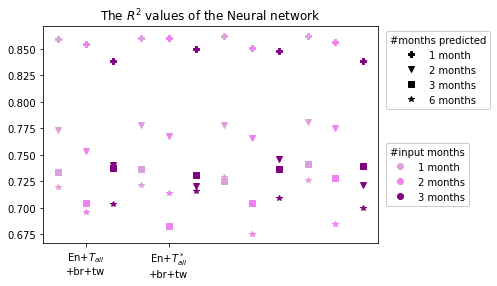

In [125]:
colors=['plum','violet','purple','indigo']
fig, ax = plt.subplots()
plt.plot(R2_allfeatures_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_allfeatures_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_allfeatures_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_allfeatures_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,3,4)+0.33
plt.plot(offset_2inputs,R2_allfeatures_arr[4],marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_allfeatures_arr[5],marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_allfeatures_arr[6],marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,R2_allfeatures_arr[7],marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,3,4)+0.66
plt.plot(offset_3inputs,R2_allfeatures_arr[8],marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_allfeatures_arr[9],marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_allfeatures_arr[10],marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,R2_allfeatures_arr[11],marker='*',linestyle = 'None',color=colors[2])

plt.title('The $R^2$ values of the Neural network')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']
labels2 = ['1 month','2 months','3 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels2, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.33, 1.33],['En+$T_{all}$ \n+br+tw' ,'En+$T_{all}^*$ \n+br+tw'])
plt.show()

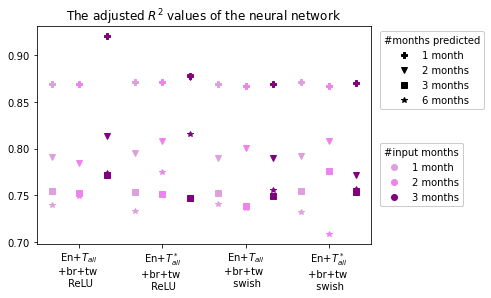

In [123]:
#colors=['greenyellow','yellowgreen','olivedrab','darkolivegreen']
#colors=['lightcoral','indianred','brown','']
colors=['plum','violet','purple','indigo']
fig, ax = plt.subplots()
plt.plot(R2_arr[0],marker='P',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[1],marker='v',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[2],marker='s',linestyle = 'None',color=colors[0])
plt.plot(R2_arr[3],marker='*',linestyle = 'None',color=colors[0])
offset_2inputs=np.linspace(0,3,4)+0.33
plt.plot(offset_2inputs,npR2[4]-R2np1D[0]+pred1month,marker='P',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[5]-R2np1D[1]+pred2month,marker='v',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[6]-R2np1D[2]+pred3month,marker='s',linestyle = 'None',color=colors[1])
plt.plot(offset_2inputs,npR2[7]-R2np1D[3]+pred6month,marker='*',linestyle = 'None',color=colors[1])
offset_3inputs=np.linspace(0,3,4)+0.66
plt.plot(offset_3inputs,npR2[8]-R2np1D[4]+pred1month,marker='P',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[9]-R2np1D[5]+pred2month,marker='v',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[10]-R2np1D[6]+pred3month,marker='s',linestyle = 'None',color=colors[2])
plt.plot(offset_3inputs,npR2[11]-R2np1D[7]+pred6month,marker='*',linestyle = 'None',color=colors[2])


plt.title('The adjusted $R^2$ values of the neural network')

#legend
markers=["P","v","s","*"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]

handles1 = [f("o", colors[i]) for i in range(4)]
handles2 = [f(markers[i], "k") for i in range(4)]
labels = ['1 month','2 months','3 months','6 months']
labels2 = ['1 month','2 months','3 months']

legend1=ax.legend(handles2, labels, framealpha=1,title='#months predicted',bbox_to_anchor=(1.01, 1), loc='best')
ax.add_artist(legend1)
legend2=ax.legend(handles1, labels2, framealpha=1,title='#input months',bbox_to_anchor=(1.01, 0.15), loc='lower left')
ax.add_artist(legend2)

#X axis
plt.xticks([0.33, 1.33, 2.33,3.33],['En+$T_{all}$ \n+br+tw \n ReLU' ,'En+$T_{all}^*$ \n+br+tw \n ReLU',
                        'En+$T_{all}$ \n+br+tw \n swish' ,'En+$T_{all}^*$ \n+br+tw \n swish'])
plt.show()

In [126]:
nppred1236month=np.array([R2_allfeatures_arr[0], R2_allfeatures_arr[1], R2_allfeatures_arr[2],R2_allfeatures_arr[3],
                        R2_allfeatures_arr[0], R2_allfeatures_arr[1], R2_allfeatures_arr[2],R2_allfeatures_arr[3]])

adR2=npR2[4:12]-R2np1D+nppred1236month
i=0
for data in bigdata_arr:
    print('nim=%i nom=%i' %(data[0],data[1]))
    if data[0] == 1:
        print(npR2[i])
    else :
        print(adR2[i-4])
    i+=1

nim=1 nom=1
[0.85878589 0.8601967  0.86168761 0.86207543]
nim=1 nom=2
[0.77296397 0.7783625  0.77851453 0.7811677 ]
nim=1 nom=3
[0.73360802 0.73699128 0.7256887  0.7408724 ]
nim=1 nom=6
[0.72004496 0.72151916 0.72931215 0.72616449]
nim=2 nom=1
[0.85872265 0.86025511 0.85957695 0.85873238]
nim=2 nom=2
[0.76656631 0.79078517 0.78925041 0.79733279]
nim=2 nom=3
[0.73223316 0.73434887 0.71193609 0.76260877]
nim=2 nom=6
[0.73038871 0.76245556 0.72472381 0.70236478]
nim=3 nom=1
[0.90938666 0.86618416 0.86164401 0.86181938]
nim=3 nom=2
[0.79627787 0.85892308 0.77842587 0.76121221]
nim=3 nom=3
[0.75100146 0.73065497 0.72206666 0.74005744]
nim=3 nom=6
[0.75426408 0.80322487 0.74431342 0.75081731]


## PCA

In [134]:
def run_PCA_NN_tests(data_PCA,En,dim,nom,pr=False):
    n_splits=10
    R2mean_arr=[]
    history_arr=[]
    if pr:
        print('\n#####################################')
        print('ReLU')
        print('#####################################')
    features=data_PCA
    
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        #create model
        model = tf.keras.models.Sequential([
                tf.keras.layers.Dense(40, input_dim=dim, activation='relu'),
                tf.keras.layers.Dense(nom)])
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)
    
    if pr:
        print('\n#####################################')
        print('Swish')
        print('#####################################')        
    kf = KFold(n_splits, shuffle=True)
    R2_arr=[]
    for train_index, test_index in kf.split(features): 
        model = Sequential()
        model.add(Dense(40, input_dim=dim, activation='swish'))
        model.add(Dense(nom))
        model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.MeanSquaredError()])
        cmodel=model
        history = cmodel.fit(features[train_index,], En[train_index], 
                             validation_data=(features[test_index,], En[test_index]), epochs=20)
        y_pred = cmodel.predict(features[test_index,])
        R2_arr.append(r2_score(En[test_index,], y_pred))
        
    if pr:
        # The coefficient of determination: 1 is perfect prediction
        print('Coefficient of determination: ' )
        print(np.mean(R2_arr))

    R2mean_arr.append(np.mean(R2_arr))
    history_arr.append(history)
    return R2mean_arr,history_arr

In [137]:
#in both cases 4 seems like enough
comps=40
compsdaily=40

R2NN=[]
R2NN_daily=[]
R2NN_ft=[]
R2NN_daily_ft=[]



for cdata in bigdata_arr:
    if not(cdata[0] ==6 and cdata[1] == 6):
        
        nim=cdata[0]
        nom=cdata[1]
        print('nim=%i nom=%i' %(nim,nom))
        
        #features
        data=cdata[2]
        En=data[0]
        features=np.column_stack(((data[1],data[3][:,np.arange(0,nim)],data[4][:,np.arange(0,nim)],
                               data[5][:,np.arange(0,nim)],data[6],data[7])))
        
        features_ft=np.column_stack(((data[1],data[3],data[4],data[5],data[6],data[7]))) #ft=future temps
        
        #PCA
        pca = PCA(n_components=comps)
        pca_dims = pca.fit_transform(features)
        pca = PCA(n_components=comps)
        pca_dims_ft = pca.fit_transform(features_ft)

        #Training and testing(PCA)
        R2,_ = run_PCA_NN_tests(pca_dims,En,comps,nom,pr=False)
        R2_ft,_ = run_PCA_NN_tests(pca_dims_day,En,comps,nom,pr=False)
        
        #Saving R2 values
        #PCA
        R2NN.append(R2)
        R2NN_ft.append(R2_ft)


nim=1 nom=1
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 92us/sample - loss: 0.2724 - mean_squared_error: 0.2724 - val_loss: 0.1696 - val_mean_squared_error: 0.1696
Epoch 2/20
15979/15979 [==============================] - 1s 56us/sample - loss: 0.1522 - mean_squared_error: 0.1522 - val_loss: 0.1691 - val_mean_squared_error: 0.1691
Epoch 3/20
15979/15979 [==============================] - 1s 54us/sample - loss: 0.1446 - mean_squared_error: 0.1446 - val_loss: 0.1569 - val_mean_squared_error: 0.1569
Epoch 4/20
15979/15979 [==============================] - 1s 53us/sample - loss: 0.1496 - mean_squared_error: 0.1496 - val_loss: 0.1589 - val_mean_squared_error: 0.1589
Epoch 5/20
15979/15979 [==============================] - 1s 56us/sample - loss: 0.1469 - mean_squared_error: 0.1469 - val_loss: 0.1756 - val_mean_squared_error: 0.1756
Epoch 6/20
15979/15979 [==============================] - 1s 57us/sample - loss: 0.1395 - mean

15979/15979 [==============================] - 1s 47us/sample - loss: 0.1418 - mean_squared_error: 0.1418 - val_loss: 0.1337 - val_mean_squared_error: 0.1337
Epoch 9/20
15979/15979 [==============================] - 1s 43us/sample - loss: 0.1405 - mean_squared_error: 0.1405 - val_loss: 0.1266 - val_mean_squared_error: 0.1266
Epoch 10/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1488 - mean_squared_error: 0.1488 - val_loss: 0.1309 - val_mean_squared_error: 0.1309
Epoch 11/20
15979/15979 [==============================] - 1s 50us/sample - loss: 0.1399 - mean_squared_error: 0.1399 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 12/20
15979/15979 [==============================] - 1s 48us/sample - loss: 0.1423 - mean_squared_error: 0.1423 - val_loss: 0.1271 - val_mean_squared_error: 0.1271
Epoch 13/20
15979/15979 [==============================] - 1s 39us/sample - loss: 0.1417 - mean_squared_error: 0.1417 - val_loss: 0.1284 - val_mean_squared_error: 

Epoch 16/20
15979/15979 [==============================] - 1s 36us/sample - loss: 0.1377 - mean_squared_error: 0.1377 - val_loss: 0.2048 - val_mean_squared_error: 0.2048
Epoch 17/20
15979/15979 [==============================] - 1s 36us/sample - loss: 0.1393 - mean_squared_error: 0.1393 - val_loss: 0.1960 - val_mean_squared_error: 0.1960
Epoch 18/20
15979/15979 [==============================] - 1s 35us/sample - loss: 0.1308 - mean_squared_error: 0.1308 - val_loss: 0.1802 - val_mean_squared_error: 0.1802
Epoch 19/20
15979/15979 [==============================] - 1s 35us/sample - loss: 0.1325 - mean_squared_error: 0.1325 - val_loss: 0.1882 - val_mean_squared_error: 0.1882
Epoch 20/20
15979/15979 [==============================] - 1s 37us/sample - loss: 0.1339 - mean_squared_error: 0.1339 - val_loss: 0.1722 - val_mean_squared_error: 0.1722
Train on 15980 samples, validate on 1775 samples
Epoch 1/20
15980/15980 [==============================] - 1s 61us/sample - loss: 0.3269 - mean_square

15980/15980 [==============================] - 1s 36us/sample - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1574 - val_mean_squared_error: 0.1574
Epoch 4/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1534 - mean_squared_error: 0.1534 - val_loss: 0.1613 - val_mean_squared_error: 0.1613
Epoch 5/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1474 - mean_squared_error: 0.1474 - val_loss: 0.1512 - val_mean_squared_error: 0.1512
Epoch 6/20
15980/15980 [==============================] - 1s 37us/sample - loss: 0.1470 - mean_squared_error: 0.1470 - val_loss: 0.1433 - val_mean_squared_error: 0.1433
Epoch 7/20
15980/15980 [==============================] - 1s 37us/sample - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 0.1413 - val_mean_squared_error: 0.1413
Epoch 8/20
15980/15980 [==============================] - 1s 37us/sample - loss: 0.1539 - mean_squared_error: 0.1539 - val_loss: 0.1492 - val_mean_squared_error: 0.14

Epoch 11/20
15980/15980 [==============================] - 1s 35us/sample - loss: 0.1402 - mean_squared_error: 0.1402 - val_loss: 0.1533 - val_mean_squared_error: 0.1533
Epoch 12/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.1594 - val_mean_squared_error: 0.1594
Epoch 13/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1367 - mean_squared_error: 0.1367 - val_loss: 0.1439 - val_mean_squared_error: 0.1439
Epoch 14/20
15980/15980 [==============================] - 1s 36us/sample - loss: 0.1421 - mean_squared_error: 0.1421 - val_loss: 0.1560 - val_mean_squared_error: 0.1560
Epoch 15/20
15980/15980 [==============================] - 1s 35us/sample - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.1347 - val_mean_squared_error: 0.1347
Epoch 16/20
15980/15980 [==============================] - 1s 35us/sample - loss: 0.1380 - mean_squared_error: 0.1380 - val_loss: 0.1340 - val_mean_sq

15979/15979 [==============================] - 0s 29us/step - loss: 0.1411 - mean_squared_error: 0.1581 - val_loss: 0.1178 - val_mean_squared_error: 0.1578
Epoch 20/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1410 - mean_squared_error: 0.1571 - val_loss: 0.1081 - val_mean_squared_error: 0.1568
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 38us/step - loss: 0.4088 - mean_squared_error: 0.7005 - val_loss: 0.1724 - val_mean_squared_error: 0.3963
Epoch 2/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1507 - mean_squared_error: 0.3181 - val_loss: 0.1521 - val_mean_squared_error: 0.2709
Epoch 3/20
15979/15979 [==============================] - 0s 30us/step - loss: 0.1509 - mean_squared_error: 0.2468 - val_loss: 0.1460 - val_mean_squared_error: 0.2302
Epoch 4/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1706 - mean_squared_error: 0.2208 - val_loss:

15979/15979 [==============================] - 0s 29us/step - loss: 0.1358 - mean_squared_error: 0.1734 - val_loss: 0.1430 - val_mean_squared_error: 0.1705
Epoch 8/20
15979/15979 [==============================] - 0s 30us/step - loss: 0.1389 - mean_squared_error: 0.1680 - val_loss: 0.1383 - val_mean_squared_error: 0.1666
Epoch 9/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1406 - mean_squared_error: 0.1651 - val_loss: 0.1426 - val_mean_squared_error: 0.1637
Epoch 10/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1357 - mean_squared_error: 0.1623 - val_loss: 0.1397 - val_mean_squared_error: 0.1609
Epoch 11/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1369 - mean_squared_error: 0.1597 - val_loss: 0.1396 - val_mean_squared_error: 0.1588
Epoch 12/20
15979/15979 [==============================] - 0s 30us/step - loss: 0.1357 - mean_squared_error: 0.1577 - val_loss: 0.1420 - val_mean_squared_error: 0.1569
Epoch 

15980/15980 [==============================] - 0s 30us/step - loss: 0.1392 - mean_squared_error: 0.1804 - val_loss: 0.1564 - val_mean_squared_error: 0.1794
Epoch 16/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1422 - mean_squared_error: 0.1781 - val_loss: 0.1597 - val_mean_squared_error: 0.1772
Epoch 17/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1390 - mean_squared_error: 0.1760 - val_loss: 0.1334 - val_mean_squared_error: 0.1749
Epoch 18/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1398 - mean_squared_error: 0.1738 - val_loss: 0.1534 - val_mean_squared_error: 0.1730
Epoch 19/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1358 - mean_squared_error: 0.1719 - val_loss: 0.1365 - val_mean_squared_error: 0.1711
Epoch 20/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1385 - mean_squared_error: 0.1703 - val_loss: 0.1479 - val_mean_squared_error: 0.1695
Trai

15980/15980 [==============================] - 0s 29us/step - loss: 0.1552 - mean_squared_error: 0.2692 - val_loss: 0.1729 - val_mean_squared_error: 0.2494
Epoch 4/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1408 - mean_squared_error: 0.2344 - val_loss: 0.1635 - val_mean_squared_error: 0.2225
Epoch 5/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1436 - mean_squared_error: 0.2137 - val_loss: 0.1738 - val_mean_squared_error: 0.2072
Epoch 6/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1486 - mean_squared_error: 0.2024 - val_loss: 0.1873 - val_mean_squared_error: 0.1979
Epoch 7/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1553 - mean_squared_error: 0.1952 - val_loss: 0.1696 - val_mean_squared_error: 0.1920
Epoch 8/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1393 - mean_squared_error: 0.1886 - val_loss: 0.1740 - val_mean_squared_error: 0.1858
Epoch 9/2

15979/15979 [==============================] - 1s 44us/sample - loss: 0.1363 - mean_squared_error: 0.1363 - val_loss: 0.1363 - val_mean_squared_error: 0.1363
Epoch 12/20
15979/15979 [==============================] - 1s 42us/sample - loss: 0.1287 - mean_squared_error: 0.1287 - val_loss: 0.1520 - val_mean_squared_error: 0.1520
Epoch 13/20
15979/15979 [==============================] - 1s 40us/sample - loss: 0.1326 - mean_squared_error: 0.1326 - val_loss: 0.1356 - val_mean_squared_error: 0.1356
Epoch 14/20
15979/15979 [==============================] - 1s 40us/sample - loss: 0.1289 - mean_squared_error: 0.1289 - val_loss: 0.1412 - val_mean_squared_error: 0.1412
Epoch 15/20
15979/15979 [==============================] - 1s 39us/sample - loss: 0.1249 - mean_squared_error: 0.1249 - val_loss: 0.1307 - val_mean_squared_error: 0.1307
Epoch 16/20
15979/15979 [==============================] - 1s 41us/sample - loss: 0.1266 - mean_squared_error: 0.1266 - val_loss: 0.1320 - val_mean_squared_error:

Epoch 19/20
15979/15979 [==============================] - 1s 38us/sample - loss: 0.1278 - mean_squared_error: 0.1278 - val_loss: 0.1251 - val_mean_squared_error: 0.1251
Epoch 20/20
15979/15979 [==============================] - 1s 38us/sample - loss: 0.1253 - mean_squared_error: 0.1253 - val_loss: 0.1216 - val_mean_squared_error: 0.1216
Train on 15979 samples, validate on 1776 samples
Epoch 1/20
15979/15979 [==============================] - 1s 78us/sample - loss: 0.3156 - mean_squared_error: 0.3156 - val_loss: 0.1643 - val_mean_squared_error: 0.1643
Epoch 2/20
15979/15979 [==============================] - 1s 40us/sample - loss: 0.1512 - mean_squared_error: 0.1512 - val_loss: 0.1458 - val_mean_squared_error: 0.1458
Epoch 3/20
15979/15979 [==============================] - 1s 38us/sample - loss: 0.1451 - mean_squared_error: 0.1451 - val_loss: 0.1498 - val_mean_squared_error: 0.1498
Epoch 4/20
15979/15979 [==============================] - 1s 37us/sample - loss: 0.1446 - mean_squared_e

15980/15980 [==============================] - 1s 39us/sample - loss: 0.1374 - mean_squared_error: 0.1374 - val_loss: 0.1539 - val_mean_squared_error: 0.1539
Epoch 7/20
15980/15980 [==============================] - 1s 38us/sample - loss: 0.1386 - mean_squared_error: 0.1386 - val_loss: 0.1603 - val_mean_squared_error: 0.1603
Epoch 8/20
15980/15980 [==============================] - 1s 38us/sample - loss: 0.1341 - mean_squared_error: 0.1341 - val_loss: 0.1554 - val_mean_squared_error: 0.1554
Epoch 9/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1358 - mean_squared_error: 0.1358 - val_loss: 0.1604 - val_mean_squared_error: 0.1604
Epoch 10/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1306 - mean_squared_error: 0.1306 - val_loss: 0.1539 - val_mean_squared_error: 0.1539
Epoch 11/20
15980/15980 [==============================] - 1s 39us/sample - loss: 0.1302 - mean_squared_error: 0.1302 - val_loss: 0.1486 - val_mean_squared_error: 0.

15980/15980 [==============================] - 1s 38us/sample - loss: 0.1303 - mean_squared_error: 0.1303 - val_loss: 0.1679 - val_mean_squared_error: 0.1679
Epoch 14/20
15980/15980 [==============================] - 1s 38us/sample - loss: 0.1290 - mean_squared_error: 0.1290 - val_loss: 0.1711 - val_mean_squared_error: 0.1711
Epoch 15/20
15980/15980 [==============================] - 1s 39us/sample - loss: 0.1314 - mean_squared_error: 0.1314 - val_loss: 0.1839 - val_mean_squared_error: 0.1839
Epoch 16/20
15980/15980 [==============================] - 1s 40us/sample - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 0.1645 - val_mean_squared_error: 0.1645
Epoch 17/20
15980/15980 [==============================] - 1s 53us/sample - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.1505 - val_mean_squared_error: 0.1505
Epoch 18/20
15980/15980 [==============================] - 1s 58us/sample - loss: 0.1279 - mean_squared_error: 0.1279 - val_loss: 0.1686 - val_mean_squared_error:

15979/15979 [==============================] - 1s 48us/step - loss: 0.2621 - mean_squared_error: 0.4022 - val_loss: 0.1639 - val_mean_squared_error: 0.2590
Epoch 2/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1469 - mean_squared_error: 0.2218 - val_loss: 0.1499 - val_mean_squared_error: 0.2020
Epoch 3/20
15979/15979 [==============================] - 0s 30us/step - loss: 0.1357 - mean_squared_error: 0.1883 - val_loss: 0.1400 - val_mean_squared_error: 0.1798
Epoch 4/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1349 - mean_squared_error: 0.1735 - val_loss: 0.1705 - val_mean_squared_error: 0.1692
Epoch 5/20
15979/15979 [==============================] - 0s 29us/step - loss: 0.1387 - mean_squared_error: 0.1650 - val_loss: 0.1445 - val_mean_squared_error: 0.1633
Epoch 6/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1360 - mean_squared_error: 0.1601 - val_loss: 0.1580 - val_mean_squared_error: 0.1589
Epoch 7/2

15979/15979 [==============================] - 1s 32us/step - loss: 0.1345 - mean_squared_error: 0.1533 - val_loss: 0.1400 - val_mean_squared_error: 0.1522
Epoch 10/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1394 - mean_squared_error: 0.1519 - val_loss: 0.1310 - val_mean_squared_error: 0.1509
Epoch 11/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1310 - mean_squared_error: 0.1498 - val_loss: 0.1329 - val_mean_squared_error: 0.1491
Epoch 12/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1311 - mean_squared_error: 0.1481 - val_loss: 0.1340 - val_mean_squared_error: 0.1476
Epoch 13/20
15979/15979 [==============================] - 1s 32us/step - loss: 0.1277 - mean_squared_error: 0.1466 - val_loss: 0.1568 - val_mean_squared_error: 0.1462
Epoch 14/20
15979/15979 [==============================] - 1s 33us/step - loss: 0.1289 - mean_squared_error: 0.1456 - val_loss: 0.1355 - val_mean_squared_error: 0.1451
Epoc

15980/15980 [==============================] - 1s 32us/step - loss: 0.1243 - mean_squared_error: 0.1649 - val_loss: 0.1736 - val_mean_squared_error: 0.1640
Epoch 18/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1241 - mean_squared_error: 0.1630 - val_loss: 0.1680 - val_mean_squared_error: 0.1620
Epoch 19/20
15980/15980 [==============================] - 0s 31us/step - loss: 0.1248 - mean_squared_error: 0.1609 - val_loss: 0.1894 - val_mean_squared_error: 0.1604
Epoch 20/20
15980/15980 [==============================] - 0s 31us/step - loss: 0.1223 - mean_squared_error: 0.1594 - val_loss: 0.1806 - val_mean_squared_error: 0.1588
Train on 15980 samples, validate on 1775 samples
Epoch 1/20
15980/15980 [==============================] - 1s 38us/step - loss: 0.2474 - mean_squared_error: 0.3712 - val_loss: 0.1756 - val_mean_squared_error: 0.2448
Epoch 2/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1529 - mean_squared_error: 0.2123 - val_los

15980/15980 [==============================] - 0s 29us/step - loss: 0.1477 - mean_squared_error: 0.1999 - val_loss: 0.1384 - val_mean_squared_error: 0.1945
Epoch 6/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1459 - mean_squared_error: 0.1900 - val_loss: 0.1272 - val_mean_squared_error: 0.1860
Epoch 7/20
15980/15980 [==============================] - 0s 29us/step - loss: 0.1394 - mean_squared_error: 0.1820 - val_loss: 0.1341 - val_mean_squared_error: 0.1792
Epoch 8/20
15980/15980 [==============================] - 0s 30us/step - loss: 0.1484 - mean_squared_error: 0.1767 - val_loss: 0.1328 - val_mean_squared_error: 0.1751
Epoch 9/20
15980/15980 [==============================] - 1s 32us/step - loss: 0.1403 - mean_squared_error: 0.1732 - val_loss: 0.1341 - val_mean_squared_error: 0.1712
Epoch 10/20
15980/15980 [==============================] - 0s 31us/step - loss: 0.1372 - mean_squared_error: 0.1694 - val_loss: 0.1325 - val_mean_squared_error: 0.1677
Epoch 11

13231/13231 [==============================] - 1s 50us/sample - loss: 0.2215 - mean_squared_error: 0.2215 - val_loss: 0.2339 - val_mean_squared_error: 0.2339
Epoch 14/20
13231/13231 [==============================] - 1s 47us/sample - loss: 0.2248 - mean_squared_error: 0.2248 - val_loss: 0.2231 - val_mean_squared_error: 0.2231
Epoch 15/20
13231/13231 [==============================] - 0s 38us/sample - loss: 0.2209 - mean_squared_error: 0.2209 - val_loss: 0.2158 - val_mean_squared_error: 0.2158
Epoch 16/20
13231/13231 [==============================] - 1s 39us/sample - loss: 0.2189 - mean_squared_error: 0.2189 - val_loss: 0.2205 - val_mean_squared_error: 0.2205
Epoch 17/20
13231/13231 [==============================] - 0s 37us/sample - loss: 0.2203 - mean_squared_error: 0.2203 - val_loss: 0.2404 - val_mean_squared_error: 0.2404
Epoch 18/20
13231/13231 [==============================] - 0s 36us/sample - loss: 0.2236 - mean_squared_error: 0.2236 - val_loss: 0.2359 - val_mean_squared_error:

Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 76us/sample - loss: 0.7823 - mean_squared_error: 0.7823 - val_loss: 0.4357 - val_mean_squared_error: 0.4357
Epoch 2/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2806 - mean_squared_error: 0.2806 - val_loss: 0.3030 - val_mean_squared_error: 0.3030
Epoch 3/20
13232/13232 [==============================] - 1s 43us/sample - loss: 0.2407 - mean_squared_error: 0.2407 - val_loss: 0.2722 - val_mean_squared_error: 0.2722
Epoch 4/20
13232/13232 [==============================] - 1s 45us/sample - loss: 0.2283 - mean_squared_error: 0.2283 - val_loss: 0.2762 - val_mean_squared_error: 0.2762
Epoch 5/20
13232/13232 [==============================] - 1s 40us/sample - loss: 0.2272 - mean_squared_error: 0.2272 - val_loss: 0.2623 - val_mean_squared_error: 0.2623
Epoch 6/20
13232/13232 [==============================] - 1s 38us/sample - loss: 0.2254 - mean_squared_err

13232/13232 [==============================] - 0s 36us/sample - loss: 0.2284 - mean_squared_error: 0.2284 - val_loss: 0.2524 - val_mean_squared_error: 0.2524
Epoch 9/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.2220 - mean_squared_error: 0.2220 - val_loss: 0.2419 - val_mean_squared_error: 0.2419
Epoch 10/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.2187 - mean_squared_error: 0.2187 - val_loss: 0.2294 - val_mean_squared_error: 0.2294
Epoch 11/20
13232/13232 [==============================] - 0s 38us/sample - loss: 0.2189 - mean_squared_error: 0.2189 - val_loss: 0.2356 - val_mean_squared_error: 0.2356
Epoch 12/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.2184 - mean_squared_error: 0.2184 - val_loss: 0.2352 - val_mean_squared_error: 0.2352
Epoch 13/20
13232/13232 [==============================] - 1s 49us/sample - loss: 0.2185 - mean_squared_error: 0.2185 - val_loss: 0.2351 - val_mean_squared_error: 

Epoch 16/20
13232/13232 [==============================] - 1s 39us/sample - loss: 0.2253 - mean_squared_error: 0.2253 - val_loss: 0.2218 - val_mean_squared_error: 0.2218
Epoch 17/20
13232/13232 [==============================] - 1s 39us/sample - loss: 0.2278 - mean_squared_error: 0.2278 - val_loss: 0.2129 - val_mean_squared_error: 0.2129
Epoch 18/20
13232/13232 [==============================] - 1s 41us/sample - loss: 0.2189 - mean_squared_error: 0.2189 - val_loss: 0.2097 - val_mean_squared_error: 0.2097
Epoch 19/20
13232/13232 [==============================] - 1s 38us/sample - loss: 0.2176 - mean_squared_error: 0.2176 - val_loss: 0.2148 - val_mean_squared_error: 0.2148
Epoch 20/20
13232/13232 [==============================] - 0s 37us/sample - loss: 0.2245 - mean_squared_error: 0.2245 - val_loss: 0.2227 - val_mean_squared_error: 0.2227
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 102us/sample - loss: 0.6249 - mean_squar

Epoch 3/20
13231/13231 [==============================] - 0s 35us/step - loss: 0.2371 - mean_squared_error: 0.3992 - val_loss: 0.2554 - val_mean_squared_error: 0.3712
Epoch 4/20
13231/13231 [==============================] - 1s 44us/step - loss: 0.2274 - mean_squared_error: 0.3510 - val_loss: 0.2470 - val_mean_squared_error: 0.3354
Epoch 5/20
13231/13231 [==============================] - 1s 46us/step - loss: 0.2211 - mean_squared_error: 0.3225 - val_loss: 0.2470 - val_mean_squared_error: 0.3128
Epoch 6/20
13231/13231 [==============================] - 0s 38us/step - loss: 0.2201 - mean_squared_error: 0.3032 - val_loss: 0.2527 - val_mean_squared_error: 0.2977
Epoch 7/20
13231/13231 [==============================] - 0s 34us/step - loss: 0.2198 - mean_squared_error: 0.2920 - val_loss: 0.2411 - val_mean_squared_error: 0.2869
Epoch 8/20
13231/13231 [==============================] - 0s 33us/step - loss: 0.2186 - mean_squared_error: 0.2822 - val_loss: 0.2448 - val_mean_squared_error: 0.278

13232/13232 [==============================] - 0s 31us/step - loss: 0.2204 - mean_squared_error: 0.2602 - val_loss: 0.2081 - val_mean_squared_error: 0.2587
Epoch 12/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2266 - mean_squared_error: 0.2568 - val_loss: 0.2040 - val_mean_squared_error: 0.2559
Epoch 13/20
13232/13232 [==============================] - 0s 31us/step - loss: 0.2274 - mean_squared_error: 0.2545 - val_loss: 0.1940 - val_mean_squared_error: 0.2534
Epoch 14/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2181 - mean_squared_error: 0.2518 - val_loss: 0.1985 - val_mean_squared_error: 0.2508
Epoch 15/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2214 - mean_squared_error: 0.2494 - val_loss: 0.2108 - val_mean_squared_error: 0.2487
Epoch 16/20
13232/13232 [==============================] - 0s 31us/step - loss: 0.2184 - mean_squared_error: 0.2475 - val_loss: 0.1927 - val_mean_squared_error: 0.2467
Epoc

13232/13232 [==============================] - 0s 32us/step - loss: 0.2196 - mean_squared_error: 0.2508 - val_loss: 0.1974 - val_mean_squared_error: 0.2500
Epoch 20/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2216 - mean_squared_error: 0.2492 - val_loss: 0.1926 - val_mean_squared_error: 0.2484
Train on 13232 samples, validate on 1470 samples
Epoch 1/20
13232/13232 [==============================] - 1s 39us/step - loss: 0.6118 - mean_squared_error: 0.9229 - val_loss: 0.2988 - val_mean_squared_error: 0.5975
Epoch 2/20
13232/13232 [==============================] - 0s 29us/step - loss: 0.2602 - mean_squared_error: 0.4859 - val_loss: 0.2588 - val_mean_squared_error: 0.4253
Epoch 3/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2353 - mean_squared_error: 0.3876 - val_loss: 0.2466 - val_mean_squared_error: 0.3614
Epoch 4/20
13232/13232 [==============================] - 0s 30us/step - loss: 0.2387 - mean_squared_error: 0.3433 - val_loss:

13232/13232 [==============================] - 1s 40us/step - loss: 0.2171 - mean_squared_error: 0.3086 - val_loss: 0.2956 - val_mean_squared_error: 0.3024
Epoch 8/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2145 - mean_squared_error: 0.2968 - val_loss: 0.2919 - val_mean_squared_error: 0.2923
Epoch 9/20
13232/13232 [==============================] - 0s 31us/step - loss: 0.2145 - mean_squared_error: 0.2867 - val_loss: 0.2956 - val_mean_squared_error: 0.2845
Epoch 10/20
13232/13232 [==============================] - 0s 32us/step - loss: 0.2149 - mean_squared_error: 0.2812 - val_loss: 0.2980 - val_mean_squared_error: 0.2783
Epoch 11/20
13232/13232 [==============================] - 0s 33us/step - loss: 0.2141 - mean_squared_error: 0.2757 - val_loss: 0.2951 - val_mean_squared_error: 0.2732
Epoch 12/20
13232/13232 [==============================] - 1s 41us/step - loss: 0.2124 - mean_squared_error: 0.2705 - val_loss: 0.2893 - val_mean_squared_error: 0.2688
Epoch 

13232/13232 [==============================] - 0s 31us/step - loss: 0.2235 - mean_squared_error: 0.2504 - val_loss: 0.2284 - val_mean_squared_error: 0.2496
Epoch 16/20
13232/13232 [==============================] - 0s 29us/step - loss: 0.2170 - mean_squared_error: 0.2487 - val_loss: 0.2333 - val_mean_squared_error: 0.2477
Epoch 17/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2160 - mean_squared_error: 0.2466 - val_loss: 0.2298 - val_mean_squared_error: 0.2459
Epoch 18/20
13232/13232 [==============================] - 0s 37us/step - loss: 0.2158 - mean_squared_error: 0.2448 - val_loss: 0.2276 - val_mean_squared_error: 0.2443
Epoch 19/20
13232/13232 [==============================] - 0s 34us/step - loss: 0.2171 - mean_squared_error: 0.2434 - val_loss: 0.2337 - val_mean_squared_error: 0.2429
Epoch 20/20
13232/13232 [==============================] - 0s 31us/step - loss: 0.2204 - mean_squared_error: 0.2422 - val_loss: 0.2268 - val_mean_squared_error: 0.2418


IndexError: index 14702 is out of bounds for axis 0 with size 14702

In [ ]:
#run tests
degree=2
#in both cases 4 seems like enough
comps=12
compsdaily=12

R2lin1D_daily=[]
R2lin1D_daily_ft=[]

R2lin1D_=[]
R2lin1D_ft=[]


for cdata in bigdata_arr:
    if not(cdata[0] ==6 and cdata[1] == 6) and cdata[0] != 1:
        
        nim=cdata[0]
        nom=cdata[1]
        print('nim=%i nom=%i' %(nim,nom))
        
        #models
        modellin=Ridge()
        modelpol=make_pipeline(PolynomialFeatures(degree),Ridge())
        
        #features
        data=cdata[2]
        
        #1 dimensionalise
        data1D=copy.deepcopy(data)
        data1D[1]=copy.deepcopy(data[1][:,-1].reshape(-1,1))
        data1D[2]=copy.deepcopy(data[2][:,nim-1,:].reshape(data[2].shape[0],1,28))
        data1D[3]=copy.deepcopy(data[3][:,np.arange(nim-1,nim+nom)])
        data1D[4]=copy.deepcopy(data[4][:,np.arange(nim-1,nim+nom)])
        data1D[5]=copy.deepcopy(data[5][:,np.arange(nim-1,nim+nom)])
        data1D=normalisedata(data1D)
        
        
        dailydata=data1D[2].reshape(data1D[2].shape[0],data1D[2].shape[1]*data1D[2].shape[2])
        features_daily=np.column_stack(((dailydata,data[3][:,0],data[4][:,0],
                               data[5][:,0],data[6],data[7])))
        features_daily_ft=np.column_stack(((dailydata,data[3],data[4],data[5],data[6],data[7])))
        
        features_daily=np.column_stack(((data[1][nim-1],data[3][:,0],data[4][:,0],
                               data[5][:,0],data[6],data[7])))
        features_daily_ft=np.column_stack(((data[1][nim-1],data[3],data[4],data[5],data[6],data[7])))
        

        #data1D=[1,data[1],data1D]
        
        
        
        #PCA
        pca = PCA(n_components=comps)
        pca_dims = pca.fit_transform(features)
        pca = PCA(n_components=comps)
        pca_dims_ft = pca.fit_transform(features_ft)
        
        pca_daily = PCA(n_components=compsdaily)
        pca_dims_daily = pca_daily.fit_transform(features_daily)
        pca_daily = PCA(n_components=compsdaily)
        pca_dims_daily_ft = pca_daily.fit_transform(features_daily_ft)
        
        #Training and testing(PCA)
        R2,_ = run_PCA_NN_tests(pca_dims,En,comps,nom,pr=False)
        R2_daily,_ = run_PCA_NN_tests(pca_dims_ft,En,comps,nom,pr=False)
        R2_ft,_ = run_PCA_NN_tests(pca_dims_daily,En,comps,nom,pr=False)
        R2_daily_ft,_ = run_PCA_NN_tests(pca_dims_daily_ft,En,comps,nom,pr=False)
        

        
        #Saving R2 values
        #PCA
        R2lin1D.append(R2)
        R2lin1D_ft.append(R2_ft)
        R2lin1D_daily.append(R2_daily)
        R2lin1D_daily_ft.append(R2_daily_ft)
        
